In [1]:
!pip install opendatasets --upgrade --quiet

In [3]:
import opendatasets as od


dataset_url = 'https://filesforruby-w251.s3.ca-central-1.amazonaws.com/ak.zip'
od.download(dataset_url)

 10%|▉         | 8380416/85410953 [00:00<00:01, 63757023.88it/s]

85417984it [00:19, 85942448.02it/s]                              

In [80]:
!ls /data/finalproject/fullfiles_bkp/vl

vl


In [31]:
import os 
import PIL
from PIL import Image
DATA_DIR = '/data/finalproject/fullfiles_bkp/bcc/'
%cd /data/finalproject/fullfiles_bkp/bcc

/data/finalproject/fullfiles_bkp/bcc


In [32]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [33]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [34]:
f = r'/data/finalproject/fullfiles_bkp/bcc/bcc'
for file in os.listdir(f):
    f_img = f+"/"+file
    img = Image.open(f_img)
    img = img.resize((64,64))
    img.save(f_img)

In [35]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

In [36]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [37]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [38]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

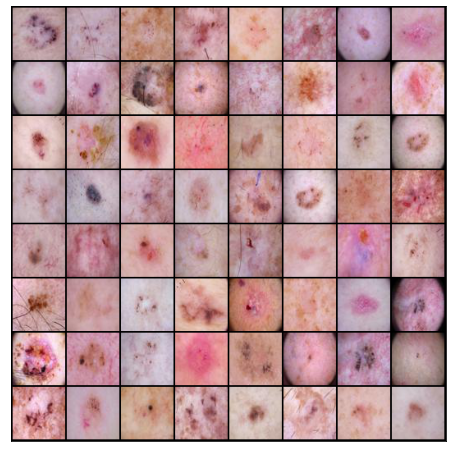

In [9]:
show_batch(train_dl)

In [39]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [40]:
device = get_default_device()
device

device(type='cuda')

In [41]:
train_dl = DeviceDataLoader(train_dl, device)

In [42]:
import torch.nn as nn

In [43]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [44]:
discriminator = to_device(discriminator, device)

In [45]:
latent_size = 128

In [46]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


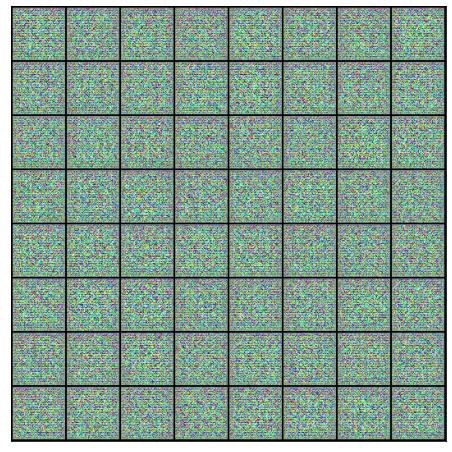

In [47]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [19]:
generator = to_device(generator, device)

In [20]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [21]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [22]:
from torchvision.utils import save_image
!pwd

/data/finalproject/fullfiles_bkp/bcc


In [23]:
sample_dir = 'generated'
single_files_dir = 'generated/single_files'
os.makedirs(sample_dir, exist_ok=True)
os.makedirs(single_files_dir, exist_ok=True)

In [24]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.jpg'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    fake_images_single = denorm(fake_images)[0]
    fake_fname_single = 'single-images-{0:0=10d}.jpg'.format(index)
    save_image(fake_images_single, os.path.join(single_files_dir, fake_fname_single))
    print('Saving', fake_fname)
    print('Saving Single Files', fake_fname_single)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [25]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.jpg
Saving Single Files single-images-0000000000.jpg


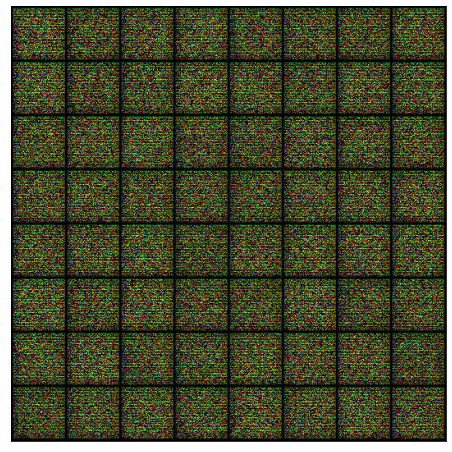

In [26]:
save_samples(0, fixed_latent)

In [27]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [28]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [29]:
lr = 0.0002
epochs = 2000

In [30]:
history = fit(epochs, lr)


Epoch [1/2000], loss_g: 4.3861, loss_d: 0.5760, real_score: 0.7842, fake_score: 0.2784
Saving generated-images-0001.jpg
Saving Single Files single-images-0000000001.jpg



Epoch [2/2000], loss_g: 7.0427, loss_d: 0.2468, real_score: 0.9423, fake_score: 0.1681
Saving generated-images-0002.jpg
Saving Single Files single-images-0000000002.jpg



Epoch [3/2000], loss_g: 6.5777, loss_d: 0.3059, real_score: 0.7964, fake_score: 0.0730
Saving generated-images-0003.jpg
Saving Single Files single-images-0000000003.jpg



Epoch [4/2000], loss_g: 12.0569, loss_d: 0.3092, real_score: 0.9998, fake_score: 0.2623
Saving generated-images-0004.jpg
Saving Single Files single-images-0000000004.jpg



Epoch [5/2000], loss_g: 11.6947, loss_d: 0.0124, real_score: 0.9880, fake_score: 0.0004
Saving generated-images-0005.jpg
Saving Single Files single-images-0000000005.jpg



Epoch [6/2000], loss_g: 16.5571, loss_d: 0.1486, real_score: 0.8710, fake_score: 0.0000
Saving generated-images-0006.jpg
Saving Single Files single-images-0000000006.jpg



Epoch [7/2000], loss_g: 16.5975, loss_d: 2.4928, real_score: 0.9995, fake_score: 0.9110
Saving generated-images-0007.jpg
Saving Single Files single-images-0000000007.jpg



Epoch [8/2000], loss_g: 15.6454, loss_d: 0.0015, real_score: 0.9985, fake_score: 0.0000
Saving generated-images-0008.jpg
Saving Single Files single-images-0000000008.jpg



Epoch [9/2000], loss_g: 16.7374, loss_d: 2.0591, real_score: 0.9999, fake_score: 0.8607
Saving generated-images-0009.jpg
Saving Single Files single-images-0000000009.jpg



Epoch [10/2000], loss_g: 15.6976, loss_d: 0.0016, real_score: 0.9984, fake_score: 0.0000
Saving generated-images-0010.jpg
Saving Single Files single-images-0000000010.jpg



Epoch [11/2000], loss_g: 5.3932, loss_d: 0.0063, real_score: 0.9999, fake_score: 0.0062
Saving generated-images-0011.jpg
Saving Single Files single-images-0000000011.jpg



Epoch [12/2000], loss_g: 17.1027, loss_d: 0.0224, real_score: 0.9780, fake_score: 0.0000
Saving generated-images-0012.jpg
Saving Single Files single-images-0000000012.jpg



Epoch [13/2000], loss_g: 9.5843, loss_d: 0.0075, real_score: 0.9926, fake_score: 0.0001
Saving generated-images-0013.jpg
Saving Single Files single-images-0000000013.jpg



Epoch [14/2000], loss_g: 18.3197, loss_d: 0.0992, real_score: 0.9067, fake_score: 0.0000
Saving generated-images-0014.jpg
Saving Single Files single-images-0000000014.jpg



Epoch [15/2000], loss_g: 12.1781, loss_d: 0.0096, real_score: 0.9904, fake_score: 0.0000
Saving generated-images-0015.jpg
Saving Single Files single-images-0000000015.jpg



Epoch [16/2000], loss_g: 16.4376, loss_d: 0.0006, real_score: 0.9994, fake_score: 0.0000
Saving generated-images-0016.jpg
Saving Single Files single-images-0000000016.jpg



Epoch [17/2000], loss_g: 6.8104, loss_d: 0.1074, real_score: 0.9045, fake_score: 0.0014
Saving generated-images-0017.jpg
Saving Single Files single-images-0000000017.jpg



Epoch [18/2000], loss_g: 10.8434, loss_d: 0.0044, real_score: 0.9966, fake_score: 0.0010
Saving generated-images-0018.jpg
Saving Single Files single-images-0000000018.jpg



Epoch [19/2000], loss_g: 8.0209, loss_d: 0.0055, real_score: 0.9962, fake_score: 0.0017
Saving generated-images-0019.jpg
Saving Single Files single-images-0000000019.jpg



Epoch [20/2000], loss_g: 1.7168, loss_d: 0.5061, real_score: 0.6610, fake_score: 0.0248
Saving generated-images-0020.jpg
Saving Single Files single-images-0000000020.jpg



Epoch [21/2000], loss_g: 6.7169, loss_d: 0.3828, real_score: 0.7301, fake_score: 0.0012
Saving generated-images-0021.jpg
Saving Single Files single-images-0000000021.jpg



Epoch [22/2000], loss_g: 4.7556, loss_d: 0.0504, real_score: 0.9678, fake_score: 0.0172
Saving generated-images-0022.jpg
Saving Single Files single-images-0000000022.jpg



Epoch [23/2000], loss_g: 15.2762, loss_d: 0.9526, real_score: 0.9920, fake_score: 0.5995
Saving generated-images-0023.jpg
Saving Single Files single-images-0000000023.jpg



Epoch [24/2000], loss_g: 6.7411, loss_d: 0.0021, real_score: 0.9993, fake_score: 0.0014
Saving generated-images-0024.jpg
Saving Single Files single-images-0000000024.jpg



Epoch [25/2000], loss_g: 5.3347, loss_d: 0.0445, real_score: 0.9927, fake_score: 0.0364
Saving generated-images-0025.jpg
Saving Single Files single-images-0000000025.jpg



Epoch [26/2000], loss_g: 4.3624, loss_d: 0.1588, real_score: 0.8709, fake_score: 0.0200
Saving generated-images-0026.jpg
Saving Single Files single-images-0000000026.jpg



Epoch [27/2000], loss_g: 2.4392, loss_d: 0.5830, real_score: 0.6550, fake_score: 0.0027
Saving generated-images-0027.jpg
Saving Single Files single-images-0000000027.jpg



Epoch [28/2000], loss_g: 5.2093, loss_d: 1.5806, real_score: 0.9994, fake_score: 0.7811
Saving generated-images-0028.jpg
Saving Single Files single-images-0000000028.jpg



Epoch [29/2000], loss_g: 2.3583, loss_d: 0.4772, real_score: 0.7246, fake_score: 0.1155
Saving generated-images-0029.jpg
Saving Single Files single-images-0000000029.jpg



Epoch [30/2000], loss_g: 3.2877, loss_d: 0.0509, real_score: 0.9931, fake_score: 0.0429
Saving generated-images-0030.jpg
Saving Single Files single-images-0000000030.jpg



Epoch [31/2000], loss_g: 4.6714, loss_d: 0.1489, real_score: 0.9565, fake_score: 0.0965
Saving generated-images-0031.jpg
Saving Single Files single-images-0000000031.jpg



Epoch [32/2000], loss_g: 3.6969, loss_d: 0.7202, real_score: 0.9972, fake_score: 0.4983
Saving generated-images-0032.jpg
Saving Single Files single-images-0000000032.jpg



Epoch [33/2000], loss_g: 0.0479, loss_d: 2.7531, real_score: 0.0711, fake_score: 0.0847
Saving generated-images-0033.jpg
Saving Single Files single-images-0000000033.jpg



Epoch [34/2000], loss_g: 1.9863, loss_d: 0.6876, real_score: 0.8559, fake_score: 0.3998
Saving generated-images-0034.jpg
Saving Single Files single-images-0000000034.jpg



Epoch [35/2000], loss_g: 3.9787, loss_d: 0.2156, real_score: 0.9871, fake_score: 0.1817
Saving generated-images-0035.jpg
Saving Single Files single-images-0000000035.jpg



Epoch [36/2000], loss_g: 3.0789, loss_d: 0.1737, real_score: 0.8798, fake_score: 0.0436
Saving generated-images-0036.jpg
Saving Single Files single-images-0000000036.jpg



Epoch [37/2000], loss_g: 2.6714, loss_d: 6.1572, real_score: 0.0039, fake_score: 0.0183
Saving generated-images-0037.jpg
Saving Single Files single-images-0000000037.jpg



Epoch [38/2000], loss_g: 2.6223, loss_d: 0.4621, real_score: 0.7519, fake_score: 0.1157
Saving generated-images-0038.jpg
Saving Single Files single-images-0000000038.jpg



Epoch [39/2000], loss_g: 4.3888, loss_d: 0.1671, real_score: 0.9722, fake_score: 0.1235
Saving generated-images-0039.jpg
Saving Single Files single-images-0000000039.jpg



Epoch [40/2000], loss_g: 1.8700, loss_d: 0.5690, real_score: 0.6538, fake_score: 0.0897
Saving generated-images-0040.jpg
Saving Single Files single-images-0000000040.jpg



Epoch [41/2000], loss_g: 0.3207, loss_d: 1.5008, real_score: 0.2801, fake_score: 0.0472
Saving generated-images-0041.jpg
Saving Single Files single-images-0000000041.jpg



Epoch [42/2000], loss_g: 2.1142, loss_d: 0.3196, real_score: 0.8759, fake_score: 0.1521
Saving generated-images-0042.jpg
Saving Single Files single-images-0000000042.jpg



Epoch [43/2000], loss_g: 4.1614, loss_d: 0.5018, real_score: 0.9622, fake_score: 0.3265
Saving generated-images-0043.jpg
Saving Single Files single-images-0000000043.jpg



Epoch [44/2000], loss_g: 2.5385, loss_d: 0.4664, real_score: 0.7353, fake_score: 0.0840
Saving generated-images-0044.jpg
Saving Single Files single-images-0000000044.jpg



Epoch [45/2000], loss_g: 4.2690, loss_d: 0.1053, real_score: 0.9971, fake_score: 0.0946
Saving generated-images-0045.jpg
Saving Single Files single-images-0000000045.jpg



Epoch [46/2000], loss_g: 0.0046, loss_d: 2.8504, real_score: 0.0646, fake_score: 0.0701
Saving generated-images-0046.jpg
Saving Single Files single-images-0000000046.jpg



Epoch [47/2000], loss_g: 1.8857, loss_d: 0.4313, real_score: 0.9917, fake_score: 0.3328
Saving generated-images-0047.jpg
Saving Single Files single-images-0000000047.jpg



Epoch [48/2000], loss_g: 2.0461, loss_d: 0.8969, real_score: 0.6931, fake_score: 0.3544
Saving generated-images-0048.jpg
Saving Single Files single-images-0000000048.jpg



Epoch [49/2000], loss_g: 2.5977, loss_d: 0.5891, real_score: 0.7545, fake_score: 0.2350
Saving generated-images-0049.jpg
Saving Single Files single-images-0000000049.jpg



Epoch [50/2000], loss_g: 4.2305, loss_d: 0.1863, real_score: 0.9909, fake_score: 0.1549
Saving generated-images-0050.jpg
Saving Single Files single-images-0000000050.jpg



Epoch [51/2000], loss_g: 4.4276, loss_d: 0.1181, real_score: 0.9831, fake_score: 0.0949
Saving generated-images-0051.jpg
Saving Single Files single-images-0000000051.jpg



Epoch [52/2000], loss_g: 1.6895, loss_d: 0.3635, real_score: 0.7196, fake_score: 0.0309
Saving generated-images-0052.jpg
Saving Single Files single-images-0000000052.jpg



Epoch [53/2000], loss_g: 4.2925, loss_d: 0.2914, real_score: 0.9228, fake_score: 0.1639
Saving generated-images-0053.jpg
Saving Single Files single-images-0000000053.jpg



Epoch [54/2000], loss_g: 4.5067, loss_d: 0.3901, real_score: 0.8495, fake_score: 0.1848
Saving generated-images-0054.jpg
Saving Single Files single-images-0000000054.jpg



Epoch [55/2000], loss_g: 4.2717, loss_d: 0.2611, real_score: 0.8906, fake_score: 0.1225
Saving generated-images-0055.jpg
Saving Single Files single-images-0000000055.jpg



Epoch [56/2000], loss_g: 0.0439, loss_d: 2.6271, real_score: 0.0976, fake_score: 0.0209
Saving generated-images-0056.jpg
Saving Single Files single-images-0000000056.jpg



Epoch [57/2000], loss_g: 3.0815, loss_d: 0.7078, real_score: 0.8115, fake_score: 0.3199
Saving generated-images-0057.jpg
Saving Single Files single-images-0000000057.jpg



Epoch [58/2000], loss_g: 2.6825, loss_d: 0.6954, real_score: 0.7886, fake_score: 0.3195
Saving generated-images-0058.jpg
Saving Single Files single-images-0000000058.jpg



Epoch [59/2000], loss_g: 1.5366, loss_d: 0.7815, real_score: 0.6662, fake_score: 0.2275
Saving generated-images-0059.jpg
Saving Single Files single-images-0000000059.jpg



Epoch [60/2000], loss_g: 4.2417, loss_d: 0.4603, real_score: 0.9706, fake_score: 0.3280
Saving generated-images-0060.jpg
Saving Single Files single-images-0000000060.jpg



Epoch [61/2000], loss_g: 0.6127, loss_d: 2.9583, real_score: 0.0759, fake_score: 0.0111
Saving generated-images-0061.jpg
Saving Single Files single-images-0000000061.jpg



Epoch [62/2000], loss_g: 4.9917, loss_d: 1.0554, real_score: 0.9790, fake_score: 0.5958
Saving generated-images-0062.jpg
Saving Single Files single-images-0000000062.jpg



Epoch [63/2000], loss_g: 1.9431, loss_d: 0.4769, real_score: 0.7818, fake_score: 0.1830
Saving generated-images-0063.jpg
Saving Single Files single-images-0000000063.jpg



Epoch [64/2000], loss_g: 0.4714, loss_d: 1.1535, real_score: 0.4084, fake_score: 0.2139
Saving generated-images-0064.jpg
Saving Single Files single-images-0000000064.jpg



Epoch [65/2000], loss_g: 1.0498, loss_d: 1.4102, real_score: 0.4613, fake_score: 0.4049
Saving generated-images-0065.jpg
Saving Single Files single-images-0000000065.jpg



Epoch [66/2000], loss_g: 3.9503, loss_d: 0.5243, real_score: 0.9489, fake_score: 0.3406
Saving generated-images-0066.jpg
Saving Single Files single-images-0000000066.jpg



Epoch [67/2000], loss_g: 0.7965, loss_d: 0.8695, real_score: 0.4749, fake_score: 0.0965
Saving generated-images-0067.jpg
Saving Single Files single-images-0000000067.jpg



Epoch [68/2000], loss_g: 0.8464, loss_d: 1.5026, real_score: 0.3612, fake_score: 0.3388
Saving generated-images-0068.jpg
Saving Single Files single-images-0000000068.jpg



Epoch [69/2000], loss_g: 3.1160, loss_d: 0.4856, real_score: 0.9253, fake_score: 0.3092
Saving generated-images-0069.jpg
Saving Single Files single-images-0000000069.jpg



Epoch [70/2000], loss_g: 0.0954, loss_d: 1.4821, real_score: 0.2718, fake_score: 0.1479
Saving generated-images-0070.jpg
Saving Single Files single-images-0000000070.jpg



Epoch [71/2000], loss_g: 2.8092, loss_d: 0.5800, real_score: 0.8813, fake_score: 0.3323
Saving generated-images-0071.jpg
Saving Single Files single-images-0000000071.jpg



Epoch [72/2000], loss_g: 0.6067, loss_d: 0.9810, real_score: 0.4901, fake_score: 0.1423
Saving generated-images-0072.jpg
Saving Single Files single-images-0000000072.jpg



Epoch [73/2000], loss_g: 2.9651, loss_d: 0.5296, real_score: 0.8828, fake_score: 0.3145
Saving generated-images-0073.jpg
Saving Single Files single-images-0000000073.jpg



Epoch [74/2000], loss_g: 0.7065, loss_d: 1.1364, real_score: 0.4205, fake_score: 0.1768
Saving generated-images-0074.jpg
Saving Single Files single-images-0000000074.jpg



Epoch [75/2000], loss_g: 2.9514, loss_d: 0.4201, real_score: 0.9892, fake_score: 0.3156
Saving generated-images-0075.jpg
Saving Single Files single-images-0000000075.jpg



Epoch [76/2000], loss_g: 0.6588, loss_d: 0.7740, real_score: 0.5154, fake_score: 0.0486
Saving generated-images-0076.jpg
Saving Single Files single-images-0000000076.jpg



Epoch [77/2000], loss_g: 2.5458, loss_d: 0.3641, real_score: 0.8960, fake_score: 0.2144
Saving generated-images-0077.jpg
Saving Single Files single-images-0000000077.jpg



Epoch [78/2000], loss_g: 2.7218, loss_d: 0.2723, real_score: 0.8780, fake_score: 0.1239
Saving generated-images-0078.jpg
Saving Single Files single-images-0000000078.jpg



Epoch [79/2000], loss_g: 4.5053, loss_d: 0.3053, real_score: 0.9948, fake_score: 0.2471
Saving generated-images-0079.jpg
Saving Single Files single-images-0000000079.jpg



Epoch [80/2000], loss_g: 4.2072, loss_d: 0.0167, real_score: 0.9985, fake_score: 0.0150
Saving generated-images-0080.jpg
Saving Single Files single-images-0000000080.jpg



Epoch [81/2000], loss_g: 3.8439, loss_d: 0.0805, real_score: 0.9989, fake_score: 0.0755
Saving generated-images-0081.jpg
Saving Single Files single-images-0000000081.jpg



Epoch [82/2000], loss_g: 4.3077, loss_d: 0.1687, real_score: 0.9851, fake_score: 0.1392
Saving generated-images-0082.jpg
Saving Single Files single-images-0000000082.jpg



Epoch [83/2000], loss_g: 3.1611, loss_d: 0.1862, real_score: 0.8653, fake_score: 0.0397
Saving generated-images-0083.jpg
Saving Single Files single-images-0000000083.jpg



Epoch [84/2000], loss_g: 5.6866, loss_d: 0.3089, real_score: 0.9861, fake_score: 0.2418
Saving generated-images-0084.jpg
Saving Single Files single-images-0000000084.jpg



Epoch [85/2000], loss_g: 0.1446, loss_d: 3.1354, real_score: 0.0633, fake_score: 0.2714
Saving generated-images-0085.jpg
Saving Single Files single-images-0000000085.jpg



Epoch [86/2000], loss_g: 4.1322, loss_d: 0.4809, real_score: 0.9993, fake_score: 0.3298
Saving generated-images-0086.jpg
Saving Single Files single-images-0000000086.jpg



Epoch [87/2000], loss_g: 1.1464, loss_d: 0.6104, real_score: 0.6558, fake_score: 0.1599
Saving generated-images-0087.jpg
Saving Single Files single-images-0000000087.jpg



Epoch [88/2000], loss_g: 3.9531, loss_d: 0.6754, real_score: 0.9428, fake_score: 0.4072
Saving generated-images-0088.jpg
Saving Single Files single-images-0000000088.jpg



Epoch [89/2000], loss_g: 0.7652, loss_d: 1.5749, real_score: 0.2436, fake_score: 0.1244
Saving generated-images-0089.jpg
Saving Single Files single-images-0000000089.jpg



Epoch [90/2000], loss_g: 2.4854, loss_d: 0.4558, real_score: 0.9350, fake_score: 0.2809
Saving generated-images-0090.jpg
Saving Single Files single-images-0000000090.jpg



Epoch [91/2000], loss_g: 0.2147, loss_d: 2.3061, real_score: 0.1364, fake_score: 0.1799
Saving generated-images-0091.jpg
Saving Single Files single-images-0000000091.jpg



Epoch [92/2000], loss_g: 3.0692, loss_d: 0.5211, real_score: 0.9101, fake_score: 0.3269
Saving generated-images-0092.jpg
Saving Single Files single-images-0000000092.jpg



Epoch [93/2000], loss_g: 0.2894, loss_d: 3.4543, real_score: 0.0423, fake_score: 0.2159
Saving generated-images-0093.jpg
Saving Single Files single-images-0000000093.jpg



Epoch [94/2000], loss_g: 2.0679, loss_d: 0.3299, real_score: 0.9300, fake_score: 0.2132
Saving generated-images-0094.jpg
Saving Single Files single-images-0000000094.jpg



Epoch [95/2000], loss_g: 1.1286, loss_d: 1.0888, real_score: 0.5247, fake_score: 0.3049
Saving generated-images-0095.jpg
Saving Single Files single-images-0000000095.jpg



Epoch [96/2000], loss_g: 3.1467, loss_d: 0.3700, real_score: 0.8695, fake_score: 0.1941
Saving generated-images-0096.jpg
Saving Single Files single-images-0000000096.jpg



Epoch [97/2000], loss_g: 0.8376, loss_d: 0.8177, real_score: 0.4950, fake_score: 0.0956
Saving generated-images-0097.jpg
Saving Single Files single-images-0000000097.jpg



Epoch [98/2000], loss_g: 1.6877, loss_d: 0.8468, real_score: 0.6054, fake_score: 0.2549
Saving generated-images-0098.jpg
Saving Single Files single-images-0000000098.jpg



Epoch [99/2000], loss_g: 3.1037, loss_d: 0.1863, real_score: 0.9510, fake_score: 0.1234
Saving generated-images-0099.jpg
Saving Single Files single-images-0000000099.jpg



Epoch [100/2000], loss_g: 0.4497, loss_d: 1.4138, real_score: 0.3989, fake_score: 0.2868
Saving generated-images-0100.jpg
Saving Single Files single-images-0000000100.jpg



Epoch [101/2000], loss_g: 3.2292, loss_d: 0.5472, real_score: 0.9965, fake_score: 0.3484
Saving generated-images-0101.jpg
Saving Single Files single-images-0000000101.jpg



Epoch [102/2000], loss_g: 6.7875, loss_d: 1.2921, real_score: 0.9983, fake_score: 0.6995
Saving generated-images-0102.jpg
Saving Single Files single-images-0000000102.jpg



Epoch [103/2000], loss_g: 3.5672, loss_d: 0.4619, real_score: 0.9539, fake_score: 0.3198
Saving generated-images-0103.jpg
Saving Single Files single-images-0000000103.jpg



Epoch [104/2000], loss_g: 1.4620, loss_d: 0.4485, real_score: 0.7490, fake_score: 0.1192
Saving generated-images-0104.jpg
Saving Single Files single-images-0000000104.jpg



Epoch [105/2000], loss_g: 1.2566, loss_d: 1.0740, real_score: 0.5721, fake_score: 0.2979
Saving generated-images-0105.jpg
Saving Single Files single-images-0000000105.jpg



Epoch [106/2000], loss_g: 3.8908, loss_d: 0.2248, real_score: 0.9858, fake_score: 0.1808
Saving generated-images-0106.jpg
Saving Single Files single-images-0000000106.jpg



Epoch [107/2000], loss_g: 3.6131, loss_d: 0.2138, real_score: 0.8245, fake_score: 0.0170
Saving generated-images-0107.jpg
Saving Single Files single-images-0000000107.jpg



Epoch [108/2000], loss_g: 4.0141, loss_d: 0.4688, real_score: 0.7940, fake_score: 0.2054
Saving generated-images-0108.jpg
Saving Single Files single-images-0000000108.jpg



Epoch [109/2000], loss_g: 0.0998, loss_d: 2.1754, real_score: 0.1668, fake_score: 0.0526
Saving generated-images-0109.jpg
Saving Single Files single-images-0000000109.jpg



Epoch [110/2000], loss_g: 3.8840, loss_d: 0.5934, real_score: 0.9959, fake_score: 0.4205
Saving generated-images-0110.jpg
Saving Single Files single-images-0000000110.jpg



Epoch [111/2000], loss_g: 1.3724, loss_d: 0.4963, real_score: 0.7116, fake_score: 0.1337
Saving generated-images-0111.jpg
Saving Single Files single-images-0000000111.jpg



Epoch [112/2000], loss_g: 1.3265, loss_d: 0.9912, real_score: 0.5568, fake_score: 0.3190
Saving generated-images-0112.jpg
Saving Single Files single-images-0000000112.jpg



Epoch [113/2000], loss_g: 4.8932, loss_d: 0.8809, real_score: 0.9428, fake_score: 0.5017
Saving generated-images-0113.jpg
Saving Single Files single-images-0000000113.jpg



Epoch [114/2000], loss_g: 1.2609, loss_d: 4.1464, real_score: 0.0523, fake_score: 0.0041
Saving generated-images-0114.jpg
Saving Single Files single-images-0000000114.jpg



Epoch [115/2000], loss_g: 0.3610, loss_d: 2.3537, real_score: 0.1326, fake_score: 0.0550
Saving generated-images-0115.jpg
Saving Single Files single-images-0000000115.jpg



Epoch [116/2000], loss_g: 3.7489, loss_d: 0.3735, real_score: 0.9913, fake_score: 0.2889
Saving generated-images-0116.jpg
Saving Single Files single-images-0000000116.jpg



Epoch [117/2000], loss_g: 3.6367, loss_d: 0.2076, real_score: 0.9233, fake_score: 0.1138
Saving generated-images-0117.jpg
Saving Single Files single-images-0000000117.jpg



Epoch [118/2000], loss_g: 3.2810, loss_d: 0.2308, real_score: 0.8587, fake_score: 0.0638
Saving generated-images-0118.jpg
Saving Single Files single-images-0000000118.jpg



Epoch [119/2000], loss_g: 4.4955, loss_d: 0.8024, real_score: 0.9117, fake_score: 0.4684
Saving generated-images-0119.jpg
Saving Single Files single-images-0000000119.jpg



Epoch [120/2000], loss_g: 0.4378, loss_d: 3.1766, real_score: 0.0544, fake_score: 0.0872
Saving generated-images-0120.jpg
Saving Single Files single-images-0000000120.jpg



Epoch [121/2000], loss_g: 3.3651, loss_d: 0.8997, real_score: 0.9855, fake_score: 0.5135
Saving generated-images-0121.jpg
Saving Single Files single-images-0000000121.jpg



Epoch [122/2000], loss_g: 1.0630, loss_d: 0.5927, real_score: 0.6728, fake_score: 0.1155
Saving generated-images-0122.jpg
Saving Single Files single-images-0000000122.jpg



Epoch [123/2000], loss_g: 3.8856, loss_d: 0.5009, real_score: 0.9996, fake_score: 0.3688
Saving generated-images-0123.jpg
Saving Single Files single-images-0000000123.jpg



Epoch [124/2000], loss_g: 0.5227, loss_d: 1.1215, real_score: 0.4682, fake_score: 0.1822
Saving generated-images-0124.jpg
Saving Single Files single-images-0000000124.jpg



Epoch [125/2000], loss_g: 3.3715, loss_d: 0.2026, real_score: 0.9896, fake_score: 0.1657
Saving generated-images-0125.jpg
Saving Single Files single-images-0000000125.jpg



Epoch [126/2000], loss_g: 0.4263, loss_d: 1.5444, real_score: 0.3927, fake_score: 0.1670
Saving generated-images-0126.jpg
Saving Single Files single-images-0000000126.jpg



Epoch [127/2000], loss_g: 3.2292, loss_d: 0.4003, real_score: 0.9991, fake_score: 0.3048
Saving generated-images-0127.jpg
Saving Single Files single-images-0000000127.jpg



Epoch [128/2000], loss_g: 3.6553, loss_d: 0.5736, real_score: 0.5930, fake_score: 0.0476
Saving generated-images-0128.jpg
Saving Single Files single-images-0000000128.jpg



Epoch [129/2000], loss_g: 0.8864, loss_d: 0.7603, real_score: 0.4919, fake_score: 0.0489
Saving generated-images-0129.jpg
Saving Single Files single-images-0000000129.jpg



Epoch [130/2000], loss_g: 4.3336, loss_d: 0.3561, real_score: 0.9991, fake_score: 0.2860
Saving generated-images-0130.jpg
Saving Single Files single-images-0000000130.jpg



Epoch [131/2000], loss_g: 0.0544, loss_d: 4.3200, real_score: 0.0153, fake_score: 0.1250
Saving generated-images-0131.jpg
Saving Single Files single-images-0000000131.jpg



Epoch [132/2000], loss_g: 3.8711, loss_d: 0.2662, real_score: 0.9525, fake_score: 0.1870
Saving generated-images-0132.jpg
Saving Single Files single-images-0000000132.jpg



Epoch [133/2000], loss_g: 4.1052, loss_d: 0.8218, real_score: 0.9942, fake_score: 0.5323
Saving generated-images-0133.jpg
Saving Single Files single-images-0000000133.jpg



Epoch [134/2000], loss_g: 0.9738, loss_d: 1.4808, real_score: 0.2580, fake_score: 0.0080
Saving generated-images-0134.jpg
Saving Single Files single-images-0000000134.jpg



Epoch [135/2000], loss_g: 3.1503, loss_d: 0.1189, real_score: 0.9978, fake_score: 0.1075
Saving generated-images-0135.jpg
Saving Single Files single-images-0000000135.jpg



Epoch [136/2000], loss_g: 5.1810, loss_d: 0.3897, real_score: 0.9758, fake_score: 0.2926
Saving generated-images-0136.jpg
Saving Single Files single-images-0000000136.jpg



Epoch [137/2000], loss_g: 5.1543, loss_d: 0.8120, real_score: 0.5635, fake_score: 0.0019
Saving generated-images-0137.jpg
Saving Single Files single-images-0000000137.jpg



Epoch [138/2000], loss_g: 3.0835, loss_d: 0.2584, real_score: 0.8985, fake_score: 0.1337
Saving generated-images-0138.jpg
Saving Single Files single-images-0000000138.jpg



Epoch [139/2000], loss_g: 7.2221, loss_d: 0.4963, real_score: 0.9840, fake_score: 0.3587
Saving generated-images-0139.jpg
Saving Single Files single-images-0000000139.jpg



Epoch [140/2000], loss_g: 0.5256, loss_d: 0.6621, real_score: 0.5893, fake_score: 0.0400
Saving generated-images-0140.jpg
Saving Single Files single-images-0000000140.jpg



Epoch [141/2000], loss_g: 3.5652, loss_d: 0.1059, real_score: 0.9746, fake_score: 0.0729
Saving generated-images-0141.jpg
Saving Single Files single-images-0000000141.jpg



Epoch [142/2000], loss_g: 2.8240, loss_d: 0.6372, real_score: 0.8231, fake_score: 0.3318
Saving generated-images-0142.jpg
Saving Single Files single-images-0000000142.jpg



Epoch [143/2000], loss_g: 5.1624, loss_d: 0.0306, real_score: 0.9766, fake_score: 0.0067
Saving generated-images-0143.jpg
Saving Single Files single-images-0000000143.jpg



Epoch [144/2000], loss_g: 2.8898, loss_d: 0.1487, real_score: 0.9230, fake_score: 0.0624
Saving generated-images-0144.jpg
Saving Single Files single-images-0000000144.jpg



Epoch [145/2000], loss_g: 7.0175, loss_d: 0.7885, real_score: 0.9997, fake_score: 0.4941
Saving generated-images-0145.jpg
Saving Single Files single-images-0000000145.jpg



Epoch [146/2000], loss_g: 2.5555, loss_d: 0.5105, real_score: 0.8262, fake_score: 0.2614
Saving generated-images-0146.jpg
Saving Single Files single-images-0000000146.jpg



Epoch [147/2000], loss_g: 3.8162, loss_d: 0.0617, real_score: 0.9694, fake_score: 0.0298
Saving generated-images-0147.jpg
Saving Single Files single-images-0000000147.jpg



Epoch [148/2000], loss_g: 1.8292, loss_d: 0.4739, real_score: 0.6500, fake_score: 0.0178
Saving generated-images-0148.jpg
Saving Single Files single-images-0000000148.jpg



Epoch [149/2000], loss_g: 0.6633, loss_d: 0.8853, real_score: 0.4363, fake_score: 0.0060
Saving generated-images-0149.jpg
Saving Single Files single-images-0000000149.jpg



Epoch [150/2000], loss_g: 2.8340, loss_d: 0.5196, real_score: 0.6650, fake_score: 0.0535
Saving generated-images-0150.jpg
Saving Single Files single-images-0000000150.jpg



Epoch [151/2000], loss_g: 4.4497, loss_d: 0.2604, real_score: 0.9369, fake_score: 0.1668
Saving generated-images-0151.jpg
Saving Single Files single-images-0000000151.jpg



Epoch [152/2000], loss_g: 3.1847, loss_d: 0.5423, real_score: 0.6125, fake_score: 0.0072
Saving generated-images-0152.jpg
Saving Single Files single-images-0000000152.jpg



Epoch [153/2000], loss_g: 4.8081, loss_d: 0.3459, real_score: 0.9912, fake_score: 0.2626
Saving generated-images-0153.jpg
Saving Single Files single-images-0000000153.jpg



Epoch [154/2000], loss_g: 5.2286, loss_d: 0.1267, real_score: 0.9973, fake_score: 0.1069
Saving generated-images-0154.jpg
Saving Single Files single-images-0000000154.jpg



Epoch [155/2000], loss_g: 1.6621, loss_d: 0.7954, real_score: 0.4695, fake_score: 0.0036
Saving generated-images-0155.jpg
Saving Single Files single-images-0000000155.jpg



Epoch [156/2000], loss_g: 10.7659, loss_d: 2.1330, real_score: 0.9984, fake_score: 0.8326
Saving generated-images-0156.jpg
Saving Single Files single-images-0000000156.jpg



Epoch [157/2000], loss_g: 2.1798, loss_d: 1.3525, real_score: 0.2609, fake_score: 0.0065
Saving generated-images-0157.jpg
Saving Single Files single-images-0000000157.jpg



Epoch [158/2000], loss_g: 3.2233, loss_d: 0.1427, real_score: 0.9284, fake_score: 0.0646
Saving generated-images-0158.jpg
Saving Single Files single-images-0000000158.jpg



Epoch [159/2000], loss_g: 4.8116, loss_d: 0.4116, real_score: 0.9825, fake_score: 0.3148
Saving generated-images-0159.jpg
Saving Single Files single-images-0000000159.jpg



Epoch [160/2000], loss_g: 4.4999, loss_d: 1.9656, real_score: 0.1586, fake_score: 0.0036
Saving generated-images-0160.jpg
Saving Single Files single-images-0000000160.jpg



Epoch [161/2000], loss_g: 4.2414, loss_d: 0.4983, real_score: 0.9493, fake_score: 0.3257
Saving generated-images-0161.jpg
Saving Single Files single-images-0000000161.jpg



Epoch [162/2000], loss_g: 4.3159, loss_d: 0.1621, real_score: 0.9927, fake_score: 0.1331
Saving generated-images-0162.jpg
Saving Single Files single-images-0000000162.jpg



Epoch [163/2000], loss_g: 0.2507, loss_d: 0.5799, real_score: 0.6153, fake_score: 0.0655
Saving generated-images-0163.jpg
Saving Single Files single-images-0000000163.jpg



Epoch [164/2000], loss_g: 5.4279, loss_d: 0.1940, real_score: 0.9917, fake_score: 0.1593
Saving generated-images-0164.jpg
Saving Single Files single-images-0000000164.jpg



Epoch [165/2000], loss_g: 0.8076, loss_d: 0.7793, real_score: 0.5509, fake_score: 0.0394
Saving generated-images-0165.jpg
Saving Single Files single-images-0000000165.jpg



Epoch [166/2000], loss_g: 4.3142, loss_d: 0.3285, real_score: 0.9988, fake_score: 0.2545
Saving generated-images-0166.jpg
Saving Single Files single-images-0000000166.jpg



Epoch [167/2000], loss_g: 0.6634, loss_d: 1.9631, real_score: 0.2817, fake_score: 0.1801
Saving generated-images-0167.jpg
Saving Single Files single-images-0000000167.jpg



Epoch [168/2000], loss_g: 3.6714, loss_d: 0.2802, real_score: 0.9066, fake_score: 0.1559
Saving generated-images-0168.jpg
Saving Single Files single-images-0000000168.jpg



Epoch [169/2000], loss_g: 3.4151, loss_d: 0.1718, real_score: 0.9816, fake_score: 0.1371
Saving generated-images-0169.jpg
Saving Single Files single-images-0000000169.jpg



Epoch [170/2000], loss_g: 3.9607, loss_d: 0.1397, real_score: 0.9662, fake_score: 0.0970
Saving generated-images-0170.jpg
Saving Single Files single-images-0000000170.jpg



Epoch [171/2000], loss_g: 3.1383, loss_d: 0.2136, real_score: 0.9940, fake_score: 0.1813
Saving generated-images-0171.jpg
Saving Single Files single-images-0000000171.jpg



Epoch [172/2000], loss_g: 2.7712, loss_d: 0.2194, real_score: 0.8637, fake_score: 0.0613
Saving generated-images-0172.jpg
Saving Single Files single-images-0000000172.jpg



Epoch [173/2000], loss_g: 3.1767, loss_d: 0.1353, real_score: 0.9850, fake_score: 0.1107
Saving generated-images-0173.jpg
Saving Single Files single-images-0000000173.jpg



Epoch [174/2000], loss_g: 3.6043, loss_d: 0.2380, real_score: 0.9518, fake_score: 0.1650
Saving generated-images-0174.jpg
Saving Single Files single-images-0000000174.jpg



Epoch [175/2000], loss_g: 2.4815, loss_d: 0.2575, real_score: 0.8332, fake_score: 0.0623
Saving generated-images-0175.jpg
Saving Single Files single-images-0000000175.jpg



Epoch [176/2000], loss_g: 4.4728, loss_d: 0.0920, real_score: 0.9883, fake_score: 0.0756
Saving generated-images-0176.jpg
Saving Single Files single-images-0000000176.jpg



Epoch [177/2000], loss_g: 2.6979, loss_d: 0.1880, real_score: 0.8508, fake_score: 0.0221
Saving generated-images-0177.jpg
Saving Single Files single-images-0000000177.jpg



Epoch [178/2000], loss_g: 2.1888, loss_d: 2.5351, real_score: 0.0880, fake_score: 0.0084
Saving generated-images-0178.jpg
Saving Single Files single-images-0000000178.jpg



Epoch [179/2000], loss_g: 5.0844, loss_d: 1.5070, real_score: 0.7624, fake_score: 0.6601
Saving generated-images-0179.jpg
Saving Single Files single-images-0000000179.jpg



Epoch [180/2000], loss_g: 3.5506, loss_d: 0.3289, real_score: 0.9320, fake_score: 0.2191
Saving generated-images-0180.jpg
Saving Single Files single-images-0000000180.jpg



Epoch [181/2000], loss_g: 3.1419, loss_d: 0.1378, real_score: 0.9016, fake_score: 0.0315
Saving generated-images-0181.jpg
Saving Single Files single-images-0000000181.jpg



Epoch [182/2000], loss_g: 4.3036, loss_d: 6.7294, real_score: 0.0015, fake_score: 0.0010
Saving generated-images-0182.jpg
Saving Single Files single-images-0000000182.jpg



Epoch [183/2000], loss_g: 0.7200, loss_d: 1.9996, real_score: 0.2382, fake_score: 0.2307
Saving generated-images-0183.jpg
Saving Single Files single-images-0000000183.jpg



Epoch [184/2000], loss_g: 0.6930, loss_d: 1.4569, real_score: 0.4032, fake_score: 0.2877
Saving generated-images-0184.jpg
Saving Single Files single-images-0000000184.jpg



Epoch [185/2000], loss_g: 1.3701, loss_d: 1.2704, real_score: 0.4864, fake_score: 0.2871
Saving generated-images-0185.jpg
Saving Single Files single-images-0000000185.jpg



Epoch [186/2000], loss_g: 0.8014, loss_d: 1.0572, real_score: 0.4486, fake_score: 0.1932
Saving generated-images-0186.jpg
Saving Single Files single-images-0000000186.jpg



Epoch [187/2000], loss_g: 2.4643, loss_d: 0.5305, real_score: 0.6970, fake_score: 0.1489
Saving generated-images-0187.jpg
Saving Single Files single-images-0000000187.jpg



Epoch [188/2000], loss_g: 3.2051, loss_d: 0.2204, real_score: 0.8650, fake_score: 0.0708
Saving generated-images-0188.jpg
Saving Single Files single-images-0000000188.jpg



Epoch [189/2000], loss_g: 5.1907, loss_d: 0.0699, real_score: 0.9499, fake_score: 0.0175
Saving generated-images-0189.jpg
Saving Single Files single-images-0000000189.jpg



Epoch [190/2000], loss_g: 6.0875, loss_d: 0.4250, real_score: 0.9944, fake_score: 0.3109
Saving generated-images-0190.jpg
Saving Single Files single-images-0000000190.jpg



Epoch [191/2000], loss_g: 2.0184, loss_d: 0.6133, real_score: 0.5505, fake_score: 0.0048
Saving generated-images-0191.jpg
Saving Single Files single-images-0000000191.jpg



Epoch [192/2000], loss_g: 0.2725, loss_d: 3.5039, real_score: 0.0692, fake_score: 0.0451
Saving generated-images-0192.jpg
Saving Single Files single-images-0000000192.jpg



Epoch [193/2000], loss_g: 3.9904, loss_d: 0.5882, real_score: 0.9919, fake_score: 0.3982
Saving generated-images-0193.jpg
Saving Single Files single-images-0000000193.jpg



Epoch [194/2000], loss_g: 3.6403, loss_d: 0.3471, real_score: 0.9920, fake_score: 0.2623
Saving generated-images-0194.jpg
Saving Single Files single-images-0000000194.jpg



Epoch [195/2000], loss_g: 4.1231, loss_d: 0.0931, real_score: 0.9996, fake_score: 0.0863
Saving generated-images-0195.jpg
Saving Single Files single-images-0000000195.jpg



Epoch [196/2000], loss_g: 2.0457, loss_d: 0.2345, real_score: 0.8255, fake_score: 0.0318
Saving generated-images-0196.jpg
Saving Single Files single-images-0000000196.jpg



Epoch [197/2000], loss_g: 0.4581, loss_d: 1.5491, real_score: 0.3659, fake_score: 0.3410
Saving generated-images-0197.jpg
Saving Single Files single-images-0000000197.jpg



Epoch [198/2000], loss_g: 3.4451, loss_d: 0.3742, real_score: 0.8727, fake_score: 0.1999
Saving generated-images-0198.jpg
Saving Single Files single-images-0000000198.jpg



Epoch [199/2000], loss_g: 3.3309, loss_d: 1.0250, real_score: 0.8593, fake_score: 0.5542
Saving generated-images-0199.jpg
Saving Single Files single-images-0000000199.jpg



Epoch [200/2000], loss_g: 1.8830, loss_d: 0.8716, real_score: 0.4604, fake_score: 0.0784
Saving generated-images-0200.jpg
Saving Single Files single-images-0000000200.jpg



Epoch [201/2000], loss_g: 1.7107, loss_d: 1.4120, real_score: 0.5745, fake_score: 0.5138
Saving generated-images-0201.jpg
Saving Single Files single-images-0000000201.jpg



Epoch [202/2000], loss_g: 3.0123, loss_d: 0.5270, real_score: 0.8065, fake_score: 0.2420
Saving generated-images-0202.jpg
Saving Single Files single-images-0000000202.jpg



Epoch [203/2000], loss_g: 0.8435, loss_d: 0.9790, real_score: 0.5157, fake_score: 0.1257
Saving generated-images-0203.jpg
Saving Single Files single-images-0000000203.jpg



Epoch [204/2000], loss_g: 5.8878, loss_d: 0.6572, real_score: 0.9947, fake_score: 0.4486
Saving generated-images-0204.jpg
Saving Single Files single-images-0000000204.jpg



Epoch [205/2000], loss_g: 3.4325, loss_d: 1.9119, real_score: 0.2494, fake_score: 0.0083
Saving generated-images-0205.jpg
Saving Single Files single-images-0000000205.jpg



Epoch [206/2000], loss_g: 4.2106, loss_d: 0.1956, real_score: 0.9585, fake_score: 0.1315
Saving generated-images-0206.jpg
Saving Single Files single-images-0000000206.jpg



Epoch [207/2000], loss_g: 4.4216, loss_d: 1.2050, real_score: 0.9727, fake_score: 0.6587
Saving generated-images-0207.jpg
Saving Single Files single-images-0000000207.jpg



Epoch [208/2000], loss_g: 1.0541, loss_d: 0.7175, real_score: 0.5468, fake_score: 0.0712
Saving generated-images-0208.jpg
Saving Single Files single-images-0000000208.jpg



Epoch [209/2000], loss_g: 2.6521, loss_d: 0.3973, real_score: 0.7444, fake_score: 0.0846
Saving generated-images-0209.jpg
Saving Single Files single-images-0000000209.jpg



Epoch [210/2000], loss_g: 3.8784, loss_d: 0.4695, real_score: 0.9724, fake_score: 0.3437
Saving generated-images-0210.jpg
Saving Single Files single-images-0000000210.jpg



Epoch [211/2000], loss_g: 4.7261, loss_d: 0.2002, real_score: 0.9756, fake_score: 0.1577
Saving generated-images-0211.jpg
Saving Single Files single-images-0000000211.jpg



Epoch [212/2000], loss_g: 0.0887, loss_d: 0.8686, real_score: 0.5092, fake_score: 0.0588
Saving generated-images-0212.jpg
Saving Single Files single-images-0000000212.jpg



Epoch [213/2000], loss_g: 4.7049, loss_d: 0.3137, real_score: 0.9963, fake_score: 0.2433
Saving generated-images-0213.jpg
Saving Single Files single-images-0000000213.jpg



Epoch [214/2000], loss_g: 2.2397, loss_d: 0.6256, real_score: 0.6961, fake_score: 0.2207
Saving generated-images-0214.jpg
Saving Single Files single-images-0000000214.jpg



Epoch [215/2000], loss_g: 2.9579, loss_d: 1.3960, real_score: 0.5584, fake_score: 0.4713
Saving generated-images-0215.jpg
Saving Single Files single-images-0000000215.jpg



Epoch [216/2000], loss_g: 4.2593, loss_d: 0.1167, real_score: 0.9968, fake_score: 0.1011
Saving generated-images-0216.jpg
Saving Single Files single-images-0000000216.jpg



Epoch [217/2000], loss_g: 2.3651, loss_d: 1.7293, real_score: 0.2075, fake_score: 0.0010
Saving generated-images-0217.jpg
Saving Single Files single-images-0000000217.jpg



Epoch [218/2000], loss_g: 1.2362, loss_d: 1.6660, real_score: 0.2228, fake_score: 0.0106
Saving generated-images-0218.jpg
Saving Single Files single-images-0000000218.jpg



Epoch [219/2000], loss_g: 6.2212, loss_d: 0.1762, real_score: 0.9300, fake_score: 0.0816
Saving generated-images-0219.jpg
Saving Single Files single-images-0000000219.jpg



Epoch [220/2000], loss_g: 3.0053, loss_d: 0.2859, real_score: 0.7920, fake_score: 0.0500
Saving generated-images-0220.jpg
Saving Single Files single-images-0000000220.jpg



Epoch [221/2000], loss_g: 3.8514, loss_d: 0.3845, real_score: 0.7353, fake_score: 0.0693
Saving generated-images-0221.jpg
Saving Single Files single-images-0000000221.jpg



Epoch [222/2000], loss_g: 1.3950, loss_d: 0.6742, real_score: 0.6293, fake_score: 0.1458
Saving generated-images-0222.jpg
Saving Single Files single-images-0000000222.jpg



Epoch [223/2000], loss_g: 2.5104, loss_d: 1.4242, real_score: 0.6088, fake_score: 0.4487
Saving generated-images-0223.jpg
Saving Single Files single-images-0000000223.jpg



Epoch [224/2000], loss_g: 2.5609, loss_d: 0.5769, real_score: 0.7562, fake_score: 0.2047
Saving generated-images-0224.jpg
Saving Single Files single-images-0000000224.jpg



Epoch [225/2000], loss_g: 3.8851, loss_d: 0.1161, real_score: 0.9776, fake_score: 0.0856
Saving generated-images-0225.jpg
Saving Single Files single-images-0000000225.jpg



Epoch [226/2000], loss_g: 2.0069, loss_d: 0.5386, real_score: 0.6115, fake_score: 0.0300
Saving generated-images-0226.jpg
Saving Single Files single-images-0000000226.jpg



Epoch [227/2000], loss_g: 1.8842, loss_d: 3.8030, real_score: 0.0904, fake_score: 0.0654
Saving generated-images-0227.jpg
Saving Single Files single-images-0000000227.jpg



Epoch [228/2000], loss_g: 2.2878, loss_d: 0.8980, real_score: 0.6651, fake_score: 0.3257
Saving generated-images-0228.jpg
Saving Single Files single-images-0000000228.jpg



Epoch [229/2000], loss_g: 3.7254, loss_d: 0.1681, real_score: 0.9980, fake_score: 0.1461
Saving generated-images-0229.jpg
Saving Single Files single-images-0000000229.jpg



Epoch [230/2000], loss_g: 1.6771, loss_d: 1.2441, real_score: 0.2976, fake_score: 0.0226
Saving generated-images-0230.jpg
Saving Single Files single-images-0000000230.jpg



Epoch [231/2000], loss_g: 3.6546, loss_d: 0.4112, real_score: 0.9812, fake_score: 0.3055
Saving generated-images-0231.jpg
Saving Single Files single-images-0000000231.jpg



Epoch [232/2000], loss_g: 2.4460, loss_d: 1.2890, real_score: 0.3006, fake_score: 0.0113
Saving generated-images-0232.jpg
Saving Single Files single-images-0000000232.jpg



Epoch [233/2000], loss_g: 2.2597, loss_d: 0.2446, real_score: 0.9586, fake_score: 0.1768
Saving generated-images-0233.jpg
Saving Single Files single-images-0000000233.jpg



Epoch [234/2000], loss_g: 3.5699, loss_d: 0.0577, real_score: 0.9950, fake_score: 0.0503
Saving generated-images-0234.jpg
Saving Single Files single-images-0000000234.jpg



Epoch [235/2000], loss_g: 5.3354, loss_d: 0.4060, real_score: 0.9996, fake_score: 0.3202
Saving generated-images-0235.jpg
Saving Single Files single-images-0000000235.jpg



Epoch [236/2000], loss_g: 2.6224, loss_d: 0.2630, real_score: 0.8346, fake_score: 0.0736
Saving generated-images-0236.jpg
Saving Single Files single-images-0000000236.jpg



Epoch [237/2000], loss_g: 2.2534, loss_d: 0.2946, real_score: 0.8325, fake_score: 0.0918
Saving generated-images-0237.jpg
Saving Single Files single-images-0000000237.jpg



Epoch [238/2000], loss_g: 3.4930, loss_d: 0.0955, real_score: 0.9339, fake_score: 0.0264
Saving generated-images-0238.jpg
Saving Single Files single-images-0000000238.jpg



Epoch [239/2000], loss_g: 4.4746, loss_d: 0.2511, real_score: 0.9982, fake_score: 0.2105
Saving generated-images-0239.jpg
Saving Single Files single-images-0000000239.jpg



Epoch [240/2000], loss_g: 4.2771, loss_d: 0.0336, real_score: 0.9887, fake_score: 0.0218
Saving generated-images-0240.jpg
Saving Single Files single-images-0000000240.jpg



Epoch [241/2000], loss_g: 5.9466, loss_d: 0.4074, real_score: 0.9993, fake_score: 0.3059
Saving generated-images-0241.jpg
Saving Single Files single-images-0000000241.jpg



Epoch [242/2000], loss_g: 1.6746, loss_d: 0.2326, real_score: 0.8039, fake_score: 0.0133
Saving generated-images-0242.jpg
Saving Single Files single-images-0000000242.jpg



Epoch [243/2000], loss_g: 4.3855, loss_d: 0.0496, real_score: 0.9950, fake_score: 0.0431
Saving generated-images-0243.jpg
Saving Single Files single-images-0000000243.jpg



Epoch [244/2000], loss_g: 0.0133, loss_d: 1.4071, real_score: 0.3603, fake_score: 0.0194
Saving generated-images-0244.jpg
Saving Single Files single-images-0000000244.jpg



Epoch [245/2000], loss_g: 6.6973, loss_d: 0.0898, real_score: 0.9880, fake_score: 0.0657
Saving generated-images-0245.jpg
Saving Single Files single-images-0000000245.jpg



Epoch [246/2000], loss_g: 0.4001, loss_d: 2.2728, real_score: 0.1333, fake_score: 0.2067
Saving generated-images-0246.jpg
Saving Single Files single-images-0000000246.jpg



Epoch [247/2000], loss_g: 2.7759, loss_d: 0.7853, real_score: 0.7639, fake_score: 0.3474
Saving generated-images-0247.jpg
Saving Single Files single-images-0000000247.jpg



Epoch [248/2000], loss_g: 4.2946, loss_d: 0.1248, real_score: 0.8986, fake_score: 0.0139
Saving generated-images-0248.jpg
Saving Single Files single-images-0000000248.jpg



Epoch [249/2000], loss_g: 4.8333, loss_d: 0.2489, real_score: 0.8036, fake_score: 0.0125
Saving generated-images-0249.jpg
Saving Single Files single-images-0000000249.jpg



Epoch [250/2000], loss_g: 4.5043, loss_d: 0.1563, real_score: 0.9784, fake_score: 0.1219
Saving generated-images-0250.jpg
Saving Single Files single-images-0000000250.jpg



Epoch [251/2000], loss_g: 3.8384, loss_d: 0.1840, real_score: 0.8962, fake_score: 0.0679
Saving generated-images-0251.jpg
Saving Single Files single-images-0000000251.jpg



Epoch [252/2000], loss_g: 3.4667, loss_d: 0.1529, real_score: 0.9653, fake_score: 0.1062
Saving generated-images-0252.jpg
Saving Single Files single-images-0000000252.jpg



Epoch [253/2000], loss_g: 0.0322, loss_d: 3.4643, real_score: 0.0460, fake_score: 0.0245
Saving generated-images-0253.jpg
Saving Single Files single-images-0000000253.jpg



Epoch [254/2000], loss_g: 2.2503, loss_d: 0.7548, real_score: 0.7540, fake_score: 0.2905
Saving generated-images-0254.jpg
Saving Single Files single-images-0000000254.jpg



Epoch [255/2000], loss_g: 0.0774, loss_d: 2.1129, real_score: 0.1360, fake_score: 0.0581
Saving generated-images-0255.jpg
Saving Single Files single-images-0000000255.jpg



Epoch [256/2000], loss_g: 2.8031, loss_d: 0.6131, real_score: 0.8951, fake_score: 0.3478
Saving generated-images-0256.jpg
Saving Single Files single-images-0000000256.jpg



Epoch [257/2000], loss_g: 2.5590, loss_d: 3.3508, real_score: 0.0354, fake_score: 0.0038
Saving generated-images-0257.jpg
Saving Single Files single-images-0000000257.jpg



Epoch [258/2000], loss_g: 4.0728, loss_d: 0.1805, real_score: 0.9741, fake_score: 0.1394
Saving generated-images-0258.jpg
Saving Single Files single-images-0000000258.jpg



Epoch [259/2000], loss_g: 2.8017, loss_d: 0.5909, real_score: 0.6159, fake_score: 0.0987
Saving generated-images-0259.jpg
Saving Single Files single-images-0000000259.jpg



Epoch [260/2000], loss_g: 1.0909, loss_d: 0.9417, real_score: 0.5650, fake_score: 0.2638
Saving generated-images-0260.jpg
Saving Single Files single-images-0000000260.jpg



Epoch [261/2000], loss_g: 0.2308, loss_d: 1.8257, real_score: 0.2474, fake_score: 0.0363
Saving generated-images-0261.jpg
Saving Single Files single-images-0000000261.jpg



Epoch [262/2000], loss_g: 2.3893, loss_d: 0.6571, real_score: 0.9437, fake_score: 0.4234
Saving generated-images-0262.jpg
Saving Single Files single-images-0000000262.jpg



Epoch [263/2000], loss_g: 1.5345, loss_d: 0.6067, real_score: 0.6575, fake_score: 0.1509
Saving generated-images-0263.jpg
Saving Single Files single-images-0000000263.jpg



Epoch [264/2000], loss_g: 3.6752, loss_d: 0.3168, real_score: 0.9551, fake_score: 0.2263
Saving generated-images-0264.jpg
Saving Single Files single-images-0000000264.jpg



Epoch [265/2000], loss_g: 3.2911, loss_d: 0.2543, real_score: 0.7952, fake_score: 0.0234
Saving generated-images-0265.jpg
Saving Single Files single-images-0000000265.jpg



Epoch [266/2000], loss_g: 3.0113, loss_d: 1.3988, real_score: 0.5707, fake_score: 0.5195
Saving generated-images-0266.jpg
Saving Single Files single-images-0000000266.jpg



Epoch [267/2000], loss_g: 5.6087, loss_d: 0.0355, real_score: 0.9793, fake_score: 0.0143
Saving generated-images-0267.jpg
Saving Single Files single-images-0000000267.jpg



Epoch [268/2000], loss_g: 4.3684, loss_d: 0.1411, real_score: 0.8972, fake_score: 0.0284
Saving generated-images-0268.jpg
Saving Single Files single-images-0000000268.jpg



Epoch [269/2000], loss_g: 3.8487, loss_d: 0.0952, real_score: 0.9447, fake_score: 0.0367
Saving generated-images-0269.jpg
Saving Single Files single-images-0000000269.jpg



Epoch [270/2000], loss_g: 4.9154, loss_d: 0.0619, real_score: 0.9484, fake_score: 0.0087
Saving generated-images-0270.jpg
Saving Single Files single-images-0000000270.jpg



Epoch [271/2000], loss_g: 1.5857, loss_d: 0.3952, real_score: 0.6845, fake_score: 0.0126
Saving generated-images-0271.jpg
Saving Single Files single-images-0000000271.jpg



Epoch [272/2000], loss_g: 1.2542, loss_d: 1.2745, real_score: 0.3660, fake_score: 0.1828
Saving generated-images-0272.jpg
Saving Single Files single-images-0000000272.jpg



Epoch [273/2000], loss_g: 3.1171, loss_d: 0.2393, real_score: 0.9611, fake_score: 0.1716
Saving generated-images-0273.jpg
Saving Single Files single-images-0000000273.jpg



Epoch [274/2000], loss_g: 6.9465, loss_d: 1.9278, real_score: 0.9923, fake_score: 0.8042
Saving generated-images-0274.jpg
Saving Single Files single-images-0000000274.jpg



Epoch [275/2000], loss_g: 5.1573, loss_d: 0.0600, real_score: 0.9569, fake_score: 0.0151
Saving generated-images-0275.jpg
Saving Single Files single-images-0000000275.jpg



Epoch [276/2000], loss_g: 2.9288, loss_d: 0.2739, real_score: 0.8869, fake_score: 0.1333
Saving generated-images-0276.jpg
Saving Single Files single-images-0000000276.jpg



Epoch [277/2000], loss_g: 5.3193, loss_d: 0.8618, real_score: 0.8829, fake_score: 0.4931
Saving generated-images-0277.jpg
Saving Single Files single-images-0000000277.jpg



Epoch [278/2000], loss_g: 7.1926, loss_d: 1.1523, real_score: 0.9965, fake_score: 0.6391
Saving generated-images-0278.jpg
Saving Single Files single-images-0000000278.jpg



Epoch [279/2000], loss_g: 3.8635, loss_d: 0.0525, real_score: 0.9759, fake_score: 0.0274
Saving generated-images-0279.jpg
Saving Single Files single-images-0000000279.jpg



Epoch [280/2000], loss_g: 0.4682, loss_d: 1.0660, real_score: 0.3675, fake_score: 0.0074
Saving generated-images-0280.jpg
Saving Single Files single-images-0000000280.jpg



Epoch [281/2000], loss_g: 4.2977, loss_d: 0.3901, real_score: 0.9657, fake_score: 0.2816
Saving generated-images-0281.jpg
Saving Single Files single-images-0000000281.jpg



Epoch [282/2000], loss_g: 2.5586, loss_d: 0.2933, real_score: 0.7612, fake_score: 0.0177
Saving generated-images-0282.jpg
Saving Single Files single-images-0000000282.jpg



Epoch [283/2000], loss_g: 3.7173, loss_d: 0.5707, real_score: 0.9615, fake_score: 0.3824
Saving generated-images-0283.jpg
Saving Single Files single-images-0000000283.jpg



Epoch [284/2000], loss_g: 2.9912, loss_d: 0.2612, real_score: 0.8040, fake_score: 0.0372
Saving generated-images-0284.jpg
Saving Single Files single-images-0000000284.jpg



Epoch [285/2000], loss_g: 3.1732, loss_d: 0.0701, real_score: 0.9513, fake_score: 0.0195
Saving generated-images-0285.jpg
Saving Single Files single-images-0000000285.jpg



Epoch [286/2000], loss_g: 3.1491, loss_d: 0.1651, real_score: 0.9203, fake_score: 0.0768
Saving generated-images-0286.jpg
Saving Single Files single-images-0000000286.jpg



Epoch [287/2000], loss_g: 3.5862, loss_d: 0.2548, real_score: 0.8809, fake_score: 0.1138
Saving generated-images-0287.jpg
Saving Single Files single-images-0000000287.jpg



Epoch [288/2000], loss_g: 0.2691, loss_d: 1.3869, real_score: 0.3668, fake_score: 0.0119
Saving generated-images-0288.jpg
Saving Single Files single-images-0000000288.jpg



Epoch [289/2000], loss_g: 3.2955, loss_d: 0.6972, real_score: 0.9852, fake_score: 0.4392
Saving generated-images-0289.jpg
Saving Single Files single-images-0000000289.jpg



Epoch [290/2000], loss_g: 2.8489, loss_d: 0.4616, real_score: 0.6706, fake_score: 0.0560
Saving generated-images-0290.jpg
Saving Single Files single-images-0000000290.jpg



Epoch [291/2000], loss_g: 5.7147, loss_d: 0.2198, real_score: 0.8049, fake_score: 0.0023
Saving generated-images-0291.jpg
Saving Single Files single-images-0000000291.jpg



Epoch [292/2000], loss_g: 1.5183, loss_d: 0.8120, real_score: 0.5294, fake_score: 0.0434
Saving generated-images-0292.jpg
Saving Single Files single-images-0000000292.jpg



Epoch [293/2000], loss_g: 3.9992, loss_d: 0.1471, real_score: 0.8852, fake_score: 0.0199
Saving generated-images-0293.jpg
Saving Single Files single-images-0000000293.jpg



Epoch [294/2000], loss_g: 3.2669, loss_d: 0.3772, real_score: 0.9983, fake_score: 0.2841
Saving generated-images-0294.jpg
Saving Single Files single-images-0000000294.jpg



Epoch [295/2000], loss_g: 4.0412, loss_d: 0.3882, real_score: 0.9664, fake_score: 0.2805
Saving generated-images-0295.jpg
Saving Single Files single-images-0000000295.jpg



Epoch [296/2000], loss_g: 2.0154, loss_d: 0.7287, real_score: 0.6830, fake_score: 0.2475
Saving generated-images-0296.jpg
Saving Single Files single-images-0000000296.jpg



Epoch [297/2000], loss_g: 2.1610, loss_d: 0.5971, real_score: 0.6019, fake_score: 0.0493
Saving generated-images-0297.jpg
Saving Single Files single-images-0000000297.jpg



Epoch [298/2000], loss_g: 3.1999, loss_d: 0.1666, real_score: 0.9702, fake_score: 0.1217
Saving generated-images-0298.jpg
Saving Single Files single-images-0000000298.jpg



Epoch [299/2000], loss_g: 3.6520, loss_d: 0.4237, real_score: 0.6560, fake_score: 0.0019
Saving generated-images-0299.jpg
Saving Single Files single-images-0000000299.jpg



Epoch [300/2000], loss_g: 0.7933, loss_d: 2.0822, real_score: 0.1297, fake_score: 0.0298
Saving generated-images-0300.jpg
Saving Single Files single-images-0000000300.jpg



Epoch [301/2000], loss_g: 2.0424, loss_d: 1.1248, real_score: 0.5109, fake_score: 0.1359
Saving generated-images-0301.jpg
Saving Single Files single-images-0000000301.jpg



Epoch [302/2000], loss_g: 5.1538, loss_d: 0.9048, real_score: 0.9411, fake_score: 0.5206
Saving generated-images-0302.jpg
Saving Single Files single-images-0000000302.jpg



Epoch [303/2000], loss_g: 3.2210, loss_d: 0.6243, real_score: 0.5986, fake_score: 0.0609
Saving generated-images-0303.jpg
Saving Single Files single-images-0000000303.jpg



Epoch [304/2000], loss_g: 4.0164, loss_d: 0.2729, real_score: 0.8298, fake_score: 0.0761
Saving generated-images-0304.jpg
Saving Single Files single-images-0000000304.jpg



Epoch [305/2000], loss_g: 4.4120, loss_d: 0.1009, real_score: 0.9944, fake_score: 0.0888
Saving generated-images-0305.jpg
Saving Single Files single-images-0000000305.jpg



Epoch [306/2000], loss_g: 5.9501, loss_d: 0.3536, real_score: 0.9994, fake_score: 0.2794
Saving generated-images-0306.jpg
Saving Single Files single-images-0000000306.jpg



Epoch [307/2000], loss_g: 6.2284, loss_d: 0.3832, real_score: 0.9983, fake_score: 0.3018
Saving generated-images-0307.jpg
Saving Single Files single-images-0000000307.jpg



Epoch [308/2000], loss_g: 3.0815, loss_d: 0.1506, real_score: 0.9025, fake_score: 0.0440
Saving generated-images-0308.jpg
Saving Single Files single-images-0000000308.jpg



Epoch [309/2000], loss_g: 5.7690, loss_d: 0.2933, real_score: 0.9973, fake_score: 0.2340
Saving generated-images-0309.jpg
Saving Single Files single-images-0000000309.jpg



Epoch [310/2000], loss_g: 6.5251, loss_d: 1.5493, real_score: 0.9998, fake_score: 0.7361
Saving generated-images-0310.jpg
Saving Single Files single-images-0000000310.jpg



Epoch [311/2000], loss_g: 3.8891, loss_d: 0.1515, real_score: 0.9782, fake_score: 0.1180
Saving generated-images-0311.jpg
Saving Single Files single-images-0000000311.jpg



Epoch [312/2000], loss_g: 3.8506, loss_d: 0.3222, real_score: 0.9914, fake_score: 0.2554
Saving generated-images-0312.jpg
Saving Single Files single-images-0000000312.jpg



Epoch [313/2000], loss_g: 1.1725, loss_d: 0.9652, real_score: 0.5552, fake_score: 0.1214
Saving generated-images-0313.jpg
Saving Single Files single-images-0000000313.jpg



Epoch [314/2000], loss_g: 4.9925, loss_d: 0.6334, real_score: 0.9668, fake_score: 0.4165
Saving generated-images-0314.jpg
Saving Single Files single-images-0000000314.jpg



Epoch [315/2000], loss_g: 1.0687, loss_d: 1.6820, real_score: 0.4082, fake_score: 0.1633
Saving generated-images-0315.jpg
Saving Single Files single-images-0000000315.jpg



Epoch [316/2000], loss_g: 1.0616, loss_d: 0.7684, real_score: 0.5868, fake_score: 0.1924
Saving generated-images-0316.jpg
Saving Single Files single-images-0000000316.jpg



Epoch [317/2000], loss_g: 4.6723, loss_d: 0.7954, real_score: 0.9877, fake_score: 0.5019
Saving generated-images-0317.jpg
Saving Single Files single-images-0000000317.jpg



Epoch [318/2000], loss_g: 5.0374, loss_d: 0.1028, real_score: 0.9105, fake_score: 0.0090
Saving generated-images-0318.jpg
Saving Single Files single-images-0000000318.jpg



Epoch [319/2000], loss_g: 2.6394, loss_d: 0.4831, real_score: 0.6403, fake_score: 0.0096
Saving generated-images-0319.jpg
Saving Single Files single-images-0000000319.jpg



Epoch [320/2000], loss_g: 3.4781, loss_d: 1.2848, real_score: 0.9981, fake_score: 0.6438
Saving generated-images-0320.jpg
Saving Single Files single-images-0000000320.jpg



Epoch [321/2000], loss_g: 4.3019, loss_d: 0.0463, real_score: 0.9974, fake_score: 0.0420
Saving generated-images-0321.jpg
Saving Single Files single-images-0000000321.jpg



Epoch [322/2000], loss_g: 4.6666, loss_d: 0.1000, real_score: 0.9566, fake_score: 0.0531
Saving generated-images-0322.jpg
Saving Single Files single-images-0000000322.jpg



Epoch [323/2000], loss_g: 3.4586, loss_d: 0.5606, real_score: 0.6400, fake_score: 0.0171
Saving generated-images-0323.jpg
Saving Single Files single-images-0000000323.jpg



Epoch [324/2000], loss_g: 3.6820, loss_d: 0.9568, real_score: 0.4383, fake_score: 0.0137
Saving generated-images-0324.jpg
Saving Single Files single-images-0000000324.jpg



Epoch [325/2000], loss_g: 3.3352, loss_d: 0.5439, real_score: 0.8684, fake_score: 0.3047
Saving generated-images-0325.jpg
Saving Single Files single-images-0000000325.jpg



Epoch [326/2000], loss_g: 4.6599, loss_d: 0.2866, real_score: 0.8610, fake_score: 0.1203
Saving generated-images-0326.jpg
Saving Single Files single-images-0000000326.jpg



Epoch [327/2000], loss_g: 1.5535, loss_d: 1.2691, real_score: 0.3266, fake_score: 0.0026
Saving generated-images-0327.jpg
Saving Single Files single-images-0000000327.jpg



Epoch [328/2000], loss_g: 2.8372, loss_d: 0.3562, real_score: 0.8556, fake_score: 0.1610
Saving generated-images-0328.jpg
Saving Single Files single-images-0000000328.jpg



Epoch [329/2000], loss_g: 4.5957, loss_d: 0.0577, real_score: 0.9896, fake_score: 0.0454
Saving generated-images-0329.jpg
Saving Single Files single-images-0000000329.jpg



Epoch [330/2000], loss_g: 7.0064, loss_d: 1.4430, real_score: 0.9962, fake_score: 0.7286
Saving generated-images-0330.jpg
Saving Single Files single-images-0000000330.jpg



Epoch [331/2000], loss_g: 6.5053, loss_d: 0.0165, real_score: 0.9879, fake_score: 0.0044
Saving generated-images-0331.jpg
Saving Single Files single-images-0000000331.jpg



Epoch [332/2000], loss_g: 5.4889, loss_d: 0.0155, real_score: 0.9904, fake_score: 0.0058
Saving generated-images-0332.jpg
Saving Single Files single-images-0000000332.jpg



Epoch [333/2000], loss_g: 3.2928, loss_d: 0.0839, real_score: 0.9881, fake_score: 0.0682
Saving generated-images-0333.jpg
Saving Single Files single-images-0000000333.jpg



Epoch [334/2000], loss_g: 4.6014, loss_d: 0.3489, real_score: 0.7270, fake_score: 0.0056
Saving generated-images-0334.jpg
Saving Single Files single-images-0000000334.jpg



Epoch [335/2000], loss_g: 4.8183, loss_d: 0.5150, real_score: 0.9984, fake_score: 0.3693
Saving generated-images-0335.jpg
Saving Single Files single-images-0000000335.jpg



Epoch [336/2000], loss_g: 6.8199, loss_d: 0.0060, real_score: 0.9961, fake_score: 0.0020
Saving generated-images-0336.jpg
Saving Single Files single-images-0000000336.jpg



Epoch [337/2000], loss_g: 0.4950, loss_d: 2.5821, real_score: 0.1241, fake_score: 0.0014
Saving generated-images-0337.jpg
Saving Single Files single-images-0000000337.jpg



Epoch [338/2000], loss_g: 1.6088, loss_d: 0.9770, real_score: 0.9934, fake_score: 0.5589
Saving generated-images-0338.jpg
Saving Single Files single-images-0000000338.jpg



Epoch [339/2000], loss_g: 2.0220, loss_d: 0.9142, real_score: 0.5044, fake_score: 0.0978
Saving generated-images-0339.jpg
Saving Single Files single-images-0000000339.jpg



Epoch [340/2000], loss_g: 3.4547, loss_d: 0.2784, real_score: 0.9888, fake_score: 0.2234
Saving generated-images-0340.jpg
Saving Single Files single-images-0000000340.jpg



Epoch [341/2000], loss_g: 3.4529, loss_d: 0.6020, real_score: 0.5562, fake_score: 0.0035
Saving generated-images-0341.jpg
Saving Single Files single-images-0000000341.jpg



Epoch [342/2000], loss_g: 3.2793, loss_d: 0.2613, real_score: 0.9650, fake_score: 0.1946
Saving generated-images-0342.jpg
Saving Single Files single-images-0000000342.jpg



Epoch [343/2000], loss_g: 1.1311, loss_d: 0.9712, real_score: 0.5845, fake_score: 0.2224
Saving generated-images-0343.jpg
Saving Single Files single-images-0000000343.jpg



Epoch [344/2000], loss_g: 3.7655, loss_d: 0.5281, real_score: 0.9800, fake_score: 0.3568
Saving generated-images-0344.jpg
Saving Single Files single-images-0000000344.jpg



Epoch [345/2000], loss_g: 3.8949, loss_d: 0.0504, real_score: 0.9992, fake_score: 0.0478
Saving generated-images-0345.jpg
Saving Single Files single-images-0000000345.jpg



Epoch [346/2000], loss_g: 3.6356, loss_d: 0.1689, real_score: 0.9618, fake_score: 0.1172
Saving generated-images-0346.jpg
Saving Single Files single-images-0000000346.jpg



Epoch [347/2000], loss_g: 2.6805, loss_d: 0.0376, real_score: 0.9992, fake_score: 0.0357
Saving generated-images-0347.jpg
Saving Single Files single-images-0000000347.jpg



Epoch [348/2000], loss_g: 2.4859, loss_d: 0.3098, real_score: 0.8632, fake_score: 0.1444
Saving generated-images-0348.jpg
Saving Single Files single-images-0000000348.jpg



Epoch [349/2000], loss_g: 7.3735, loss_d: 0.0072, real_score: 0.9936, fake_score: 0.0007
Saving generated-images-0349.jpg
Saving Single Files single-images-0000000349.jpg



Epoch [350/2000], loss_g: 3.5249, loss_d: 0.1221, real_score: 0.9633, fake_score: 0.0792
Saving generated-images-0350.jpg
Saving Single Files single-images-0000000350.jpg



Epoch [351/2000], loss_g: 3.6574, loss_d: 0.1224, real_score: 0.9069, fake_score: 0.0220
Saving generated-images-0351.jpg
Saving Single Files single-images-0000000351.jpg



Epoch [352/2000], loss_g: 5.1867, loss_d: 0.0498, real_score: 0.9683, fake_score: 0.0168
Saving generated-images-0352.jpg
Saving Single Files single-images-0000000352.jpg



Epoch [353/2000], loss_g: 7.2199, loss_d: 0.0027, real_score: 0.9988, fake_score: 0.0015
Saving generated-images-0353.jpg
Saving Single Files single-images-0000000353.jpg



Epoch [354/2000], loss_g: 8.1831, loss_d: 0.0248, real_score: 0.9760, fake_score: 0.0003
Saving generated-images-0354.jpg
Saving Single Files single-images-0000000354.jpg



Epoch [355/2000], loss_g: 4.0657, loss_d: 0.0458, real_score: 0.9987, fake_score: 0.0430
Saving generated-images-0355.jpg
Saving Single Files single-images-0000000355.jpg



Epoch [356/2000], loss_g: 3.7873, loss_d: 0.0937, real_score: 0.9425, fake_score: 0.0337
Saving generated-images-0356.jpg
Saving Single Files single-images-0000000356.jpg



Epoch [357/2000], loss_g: 6.9506, loss_d: 0.0516, real_score: 0.9508, fake_score: 0.0011
Saving generated-images-0357.jpg
Saving Single Files single-images-0000000357.jpg



Epoch [358/2000], loss_g: 8.9940, loss_d: 0.0014, real_score: 0.9987, fake_score: 0.0001
Saving generated-images-0358.jpg
Saving Single Files single-images-0000000358.jpg



Epoch [359/2000], loss_g: 5.6417, loss_d: 0.0664, real_score: 0.9877, fake_score: 0.0518
Saving generated-images-0359.jpg
Saving Single Files single-images-0000000359.jpg



Epoch [360/2000], loss_g: 7.7763, loss_d: 0.0017, real_score: 0.9990, fake_score: 0.0007
Saving generated-images-0360.jpg
Saving Single Files single-images-0000000360.jpg



Epoch [361/2000], loss_g: 2.7439, loss_d: 0.3125, real_score: 0.7450, fake_score: 0.0114
Saving generated-images-0361.jpg
Saving Single Files single-images-0000000361.jpg



Epoch [362/2000], loss_g: 5.8252, loss_d: 0.2401, real_score: 0.9977, fake_score: 0.1983
Saving generated-images-0362.jpg
Saving Single Files single-images-0000000362.jpg



Epoch [363/2000], loss_g: 6.4290, loss_d: 0.0097, real_score: 0.9938, fake_score: 0.0035
Saving generated-images-0363.jpg
Saving Single Files single-images-0000000363.jpg



Epoch [364/2000], loss_g: 5.2734, loss_d: 0.0131, real_score: 0.9957, fake_score: 0.0088
Saving generated-images-0364.jpg
Saving Single Files single-images-0000000364.jpg



Epoch [365/2000], loss_g: 6.8053, loss_d: 0.4620, real_score: 0.9995, fake_score: 0.3379
Saving generated-images-0365.jpg
Saving Single Files single-images-0000000365.jpg



Epoch [366/2000], loss_g: 3.9647, loss_d: 0.1131, real_score: 0.9367, fake_score: 0.0448
Saving generated-images-0366.jpg
Saving Single Files single-images-0000000366.jpg



Epoch [367/2000], loss_g: 8.0279, loss_d: 0.6138, real_score: 0.6142, fake_score: 0.0004
Saving generated-images-0367.jpg
Saving Single Files single-images-0000000367.jpg



Epoch [368/2000], loss_g: 5.2965, loss_d: 0.0313, real_score: 0.9889, fake_score: 0.0198
Saving generated-images-0368.jpg
Saving Single Files single-images-0000000368.jpg



Epoch [369/2000], loss_g: 3.6814, loss_d: 0.2591, real_score: 0.9078, fake_score: 0.1397
Saving generated-images-0369.jpg
Saving Single Files single-images-0000000369.jpg



Epoch [370/2000], loss_g: 3.1902, loss_d: 2.1297, real_score: 0.1422, fake_score: 0.0020
Saving generated-images-0370.jpg
Saving Single Files single-images-0000000370.jpg



Epoch [371/2000], loss_g: 4.9157, loss_d: 0.2014, real_score: 0.9659, fake_score: 0.1486
Saving generated-images-0371.jpg
Saving Single Files single-images-0000000371.jpg



Epoch [372/2000], loss_g: 4.6885, loss_d: 0.0487, real_score: 0.9664, fake_score: 0.0143
Saving generated-images-0372.jpg
Saving Single Files single-images-0000000372.jpg



Epoch [373/2000], loss_g: 4.0819, loss_d: 0.1534, real_score: 0.9973, fake_score: 0.1309
Saving generated-images-0373.jpg
Saving Single Files single-images-0000000373.jpg



Epoch [374/2000], loss_g: 3.5422, loss_d: 0.3651, real_score: 0.9670, fake_score: 0.2685
Saving generated-images-0374.jpg
Saving Single Files single-images-0000000374.jpg



Epoch [375/2000], loss_g: 3.5663, loss_d: 1.3381, real_score: 0.2686, fake_score: 0.0013
Saving generated-images-0375.jpg
Saving Single Files single-images-0000000375.jpg



Epoch [376/2000], loss_g: 3.3704, loss_d: 0.1128, real_score: 0.9728, fake_score: 0.0727
Saving generated-images-0376.jpg
Saving Single Files single-images-0000000376.jpg



Epoch [377/2000], loss_g: 5.4256, loss_d: 1.0275, real_score: 0.9832, fake_score: 0.5784
Saving generated-images-0377.jpg
Saving Single Files single-images-0000000377.jpg



Epoch [378/2000], loss_g: 4.1136, loss_d: 0.2881, real_score: 0.7794, fake_score: 0.0117
Saving generated-images-0378.jpg
Saving Single Files single-images-0000000378.jpg



Epoch [379/2000], loss_g: 1.6522, loss_d: 0.5215, real_score: 0.6953, fake_score: 0.0777
Saving generated-images-0379.jpg
Saving Single Files single-images-0000000379.jpg



Epoch [380/2000], loss_g: 6.6463, loss_d: 0.0905, real_score: 0.9162, fake_score: 0.0012
Saving generated-images-0380.jpg
Saving Single Files single-images-0000000380.jpg



Epoch [381/2000], loss_g: 4.3181, loss_d: 0.0674, real_score: 0.9947, fake_score: 0.0584
Saving generated-images-0381.jpg
Saving Single Files single-images-0000000381.jpg



Epoch [382/2000], loss_g: 6.3110, loss_d: 0.1802, real_score: 0.8525, fake_score: 0.0065
Saving generated-images-0382.jpg
Saving Single Files single-images-0000000382.jpg



Epoch [383/2000], loss_g: 6.8274, loss_d: 0.0079, real_score: 0.9931, fake_score: 0.0010
Saving generated-images-0383.jpg
Saving Single Files single-images-0000000383.jpg



Epoch [384/2000], loss_g: 0.4245, loss_d: 0.6731, real_score: 0.5174, fake_score: 0.0133
Saving generated-images-0384.jpg
Saving Single Files single-images-0000000384.jpg



Epoch [385/2000], loss_g: 2.7221, loss_d: 1.6999, real_score: 0.3492, fake_score: 0.2080
Saving generated-images-0385.jpg
Saving Single Files single-images-0000000385.jpg



Epoch [386/2000], loss_g: 2.8301, loss_d: 0.2012, real_score: 0.8875, fake_score: 0.0691
Saving generated-images-0386.jpg
Saving Single Files single-images-0000000386.jpg



Epoch [387/2000], loss_g: 3.1212, loss_d: 0.3058, real_score: 0.7861, fake_score: 0.0461
Saving generated-images-0387.jpg
Saving Single Files single-images-0000000387.jpg



Epoch [388/2000], loss_g: 5.3243, loss_d: 0.0198, real_score: 0.9851, fake_score: 0.0048
Saving generated-images-0388.jpg
Saving Single Files single-images-0000000388.jpg



Epoch [389/2000], loss_g: 3.7329, loss_d: 0.0709, real_score: 0.9552, fake_score: 0.0237
Saving generated-images-0389.jpg
Saving Single Files single-images-0000000389.jpg



Epoch [390/2000], loss_g: 0.9420, loss_d: 0.5096, real_score: 0.6321, fake_score: 0.0469
Saving generated-images-0390.jpg
Saving Single Files single-images-0000000390.jpg



Epoch [391/2000], loss_g: 5.3413, loss_d: 0.0115, real_score: 0.9925, fake_score: 0.0040
Saving generated-images-0391.jpg
Saving Single Files single-images-0000000391.jpg



Epoch [392/2000], loss_g: 4.7930, loss_d: 0.1869, real_score: 0.9992, fake_score: 0.1663
Saving generated-images-0392.jpg
Saving Single Files single-images-0000000392.jpg



Epoch [393/2000], loss_g: 6.4345, loss_d: 0.9742, real_score: 0.8706, fake_score: 0.5462
Saving generated-images-0393.jpg
Saving Single Files single-images-0000000393.jpg



Epoch [394/2000], loss_g: 7.6029, loss_d: 0.0036, real_score: 0.9979, fake_score: 0.0015
Saving generated-images-0394.jpg
Saving Single Files single-images-0000000394.jpg



Epoch [395/2000], loss_g: 1.3358, loss_d: 0.4273, real_score: 0.7325, fake_score: 0.0492
Saving generated-images-0395.jpg
Saving Single Files single-images-0000000395.jpg



Epoch [396/2000], loss_g: 5.1410, loss_d: 0.0204, real_score: 0.9892, fake_score: 0.0093
Saving generated-images-0396.jpg
Saving Single Files single-images-0000000396.jpg



Epoch [397/2000], loss_g: 4.3166, loss_d: 0.4430, real_score: 0.8305, fake_score: 0.1916
Saving generated-images-0397.jpg
Saving Single Files single-images-0000000397.jpg



Epoch [398/2000], loss_g: 7.7873, loss_d: 0.7522, real_score: 0.4885, fake_score: 0.0000
Saving generated-images-0398.jpg
Saving Single Files single-images-0000000398.jpg



Epoch [399/2000], loss_g: 2.9996, loss_d: 0.4327, real_score: 0.9778, fake_score: 0.2878
Saving generated-images-0399.jpg
Saving Single Files single-images-0000000399.jpg



Epoch [400/2000], loss_g: 4.1078, loss_d: 0.0454, real_score: 0.9846, fake_score: 0.0291
Saving generated-images-0400.jpg
Saving Single Files single-images-0000000400.jpg



Epoch [401/2000], loss_g: 4.3485, loss_d: 0.6328, real_score: 0.5351, fake_score: 0.0006
Saving generated-images-0401.jpg
Saving Single Files single-images-0000000401.jpg



Epoch [402/2000], loss_g: 3.6049, loss_d: 0.1978, real_score: 0.9986, fake_score: 0.1655
Saving generated-images-0402.jpg
Saving Single Files single-images-0000000402.jpg



Epoch [403/2000], loss_g: 5.6169, loss_d: 0.3710, real_score: 0.7331, fake_score: 0.0007
Saving generated-images-0403.jpg
Saving Single Files single-images-0000000403.jpg



Epoch [404/2000], loss_g: 6.2438, loss_d: 0.0480, real_score: 0.9569, fake_score: 0.0030
Saving generated-images-0404.jpg
Saving Single Files single-images-0000000404.jpg



Epoch [405/2000], loss_g: 5.4245, loss_d: 1.5049, real_score: 0.2956, fake_score: 0.0007
Saving generated-images-0405.jpg
Saving Single Files single-images-0000000405.jpg



Epoch [406/2000], loss_g: 0.8505, loss_d: 1.3470, real_score: 0.3579, fake_score: 0.2570
Saving generated-images-0406.jpg
Saving Single Files single-images-0000000406.jpg



Epoch [407/2000], loss_g: 5.0974, loss_d: 0.3226, real_score: 0.9997, fake_score: 0.2546
Saving generated-images-0407.jpg
Saving Single Files single-images-0000000407.jpg



Epoch [408/2000], loss_g: 0.6807, loss_d: 2.2554, real_score: 0.1940, fake_score: 0.0141
Saving generated-images-0408.jpg
Saving Single Files single-images-0000000408.jpg



Epoch [409/2000], loss_g: 3.0837, loss_d: 0.1570, real_score: 0.9495, fake_score: 0.0941
Saving generated-images-0409.jpg
Saving Single Files single-images-0000000409.jpg



Epoch [410/2000], loss_g: 0.8654, loss_d: 1.2955, real_score: 0.4604, fake_score: 0.0260
Saving generated-images-0410.jpg
Saving Single Files single-images-0000000410.jpg



Epoch [411/2000], loss_g: 2.9474, loss_d: 0.0744, real_score: 0.9638, fake_score: 0.0361
Saving generated-images-0411.jpg
Saving Single Files single-images-0000000411.jpg



Epoch [412/2000], loss_g: 3.4037, loss_d: 0.1682, real_score: 0.9640, fake_score: 0.1161
Saving generated-images-0412.jpg
Saving Single Files single-images-0000000412.jpg



Epoch [413/2000], loss_g: 3.1245, loss_d: 0.5388, real_score: 0.5852, fake_score: 0.0030
Saving generated-images-0413.jpg
Saving Single Files single-images-0000000413.jpg



Epoch [414/2000], loss_g: 7.2821, loss_d: 0.5117, real_score: 0.9968, fake_score: 0.3751
Saving generated-images-0414.jpg
Saving Single Files single-images-0000000414.jpg



Epoch [415/2000], loss_g: 8.6881, loss_d: 1.0734, real_score: 0.4916, fake_score: 0.0000
Saving generated-images-0415.jpg
Saving Single Files single-images-0000000415.jpg



Epoch [416/2000], loss_g: 6.3589, loss_d: 0.0187, real_score: 0.9860, fake_score: 0.0045
Saving generated-images-0416.jpg
Saving Single Files single-images-0000000416.jpg



Epoch [417/2000], loss_g: 5.1993, loss_d: 0.9066, real_score: 0.9136, fake_score: 0.5147
Saving generated-images-0417.jpg
Saving Single Files single-images-0000000417.jpg



Epoch [418/2000], loss_g: 8.4384, loss_d: 0.8510, real_score: 0.4827, fake_score: 0.0002
Saving generated-images-0418.jpg
Saving Single Files single-images-0000000418.jpg



Epoch [419/2000], loss_g: 5.0312, loss_d: 0.1193, real_score: 0.9014, fake_score: 0.0136
Saving generated-images-0419.jpg
Saving Single Files single-images-0000000419.jpg



Epoch [420/2000], loss_g: 6.2031, loss_d: 0.0711, real_score: 0.9344, fake_score: 0.0032
Saving generated-images-0420.jpg
Saving Single Files single-images-0000000420.jpg



Epoch [421/2000], loss_g: 8.7719, loss_d: 1.1186, real_score: 0.9944, fake_score: 0.6511
Saving generated-images-0421.jpg
Saving Single Files single-images-0000000421.jpg



Epoch [422/2000], loss_g: 4.0852, loss_d: 0.0354, real_score: 0.9958, fake_score: 0.0304
Saving generated-images-0422.jpg
Saving Single Files single-images-0000000422.jpg



Epoch [423/2000], loss_g: 6.7151, loss_d: 0.0144, real_score: 0.9870, fake_score: 0.0012
Saving generated-images-0423.jpg
Saving Single Files single-images-0000000423.jpg



Epoch [424/2000], loss_g: 3.8825, loss_d: 0.1646, real_score: 0.9822, fake_score: 0.1338
Saving generated-images-0424.jpg
Saving Single Files single-images-0000000424.jpg



Epoch [425/2000], loss_g: 7.6284, loss_d: 0.1312, real_score: 0.8776, fake_score: 0.0006
Saving generated-images-0425.jpg
Saving Single Files single-images-0000000425.jpg



Epoch [426/2000], loss_g: 3.2474, loss_d: 0.1623, real_score: 0.8582, fake_score: 0.0091
Saving generated-images-0426.jpg
Saving Single Files single-images-0000000426.jpg



Epoch [427/2000], loss_g: 6.2314, loss_d: 0.2321, real_score: 0.9987, fake_score: 0.1996
Saving generated-images-0427.jpg
Saving Single Files single-images-0000000427.jpg



Epoch [428/2000], loss_g: 4.2967, loss_d: 0.9017, real_score: 0.4223, fake_score: 0.0001
Saving generated-images-0428.jpg
Saving Single Files single-images-0000000428.jpg



Epoch [429/2000], loss_g: 4.9382, loss_d: 0.0380, real_score: 0.9727, fake_score: 0.0102
Saving generated-images-0429.jpg
Saving Single Files single-images-0000000429.jpg



Epoch [430/2000], loss_g: 5.2735, loss_d: 0.0481, real_score: 0.9800, fake_score: 0.0273
Saving generated-images-0430.jpg
Saving Single Files single-images-0000000430.jpg



Epoch [431/2000], loss_g: 3.3567, loss_d: 0.2606, real_score: 0.7947, fake_score: 0.0066
Saving generated-images-0431.jpg
Saving Single Files single-images-0000000431.jpg



Epoch [432/2000], loss_g: 0.0263, loss_d: 4.3472, real_score: 0.0192, fake_score: 0.1043
Saving generated-images-0432.jpg
Saving Single Files single-images-0000000432.jpg



Epoch [433/2000], loss_g: 4.2762, loss_d: 0.8165, real_score: 0.9994, fake_score: 0.5255
Saving generated-images-0433.jpg
Saving Single Files single-images-0000000433.jpg



Epoch [434/2000], loss_g: 3.7736, loss_d: 0.2584, real_score: 0.9061, fake_score: 0.1397
Saving generated-images-0434.jpg
Saving Single Files single-images-0000000434.jpg



Epoch [435/2000], loss_g: 5.4229, loss_d: 0.0264, real_score: 0.9839, fake_score: 0.0101
Saving generated-images-0435.jpg
Saving Single Files single-images-0000000435.jpg



Epoch [436/2000], loss_g: 2.9193, loss_d: 0.2147, real_score: 0.8205, fake_score: 0.0061
Saving generated-images-0436.jpg
Saving Single Files single-images-0000000436.jpg



Epoch [437/2000], loss_g: 4.9033, loss_d: 0.5106, real_score: 0.6769, fake_score: 0.0015
Saving generated-images-0437.jpg
Saving Single Files single-images-0000000437.jpg



Epoch [438/2000], loss_g: 3.7657, loss_d: 0.0321, real_score: 0.9883, fake_score: 0.0197
Saving generated-images-0438.jpg
Saving Single Files single-images-0000000438.jpg



Epoch [439/2000], loss_g: 0.0347, loss_d: 2.5644, real_score: 0.0897, fake_score: 0.1274
Saving generated-images-0439.jpg
Saving Single Files single-images-0000000439.jpg



Epoch [440/2000], loss_g: 2.5840, loss_d: 0.0729, real_score: 0.9759, fake_score: 0.0468
Saving generated-images-0440.jpg
Saving Single Files single-images-0000000440.jpg



Epoch [441/2000], loss_g: 1.4838, loss_d: 0.7766, real_score: 0.6196, fake_score: 0.1055
Saving generated-images-0441.jpg
Saving Single Files single-images-0000000441.jpg



Epoch [442/2000], loss_g: 2.9852, loss_d: 0.3743, real_score: 0.9985, fake_score: 0.3002
Saving generated-images-0442.jpg
Saving Single Files single-images-0000000442.jpg



Epoch [443/2000], loss_g: 4.3488, loss_d: 0.6054, real_score: 0.9940, fake_score: 0.4387
Saving generated-images-0443.jpg
Saving Single Files single-images-0000000443.jpg



Epoch [444/2000], loss_g: 3.7020, loss_d: 0.1245, real_score: 0.9240, fake_score: 0.0440
Saving generated-images-0444.jpg
Saving Single Files single-images-0000000444.jpg



Epoch [445/2000], loss_g: 2.8312, loss_d: 0.1925, real_score: 0.8930, fake_score: 0.0722
Saving generated-images-0445.jpg
Saving Single Files single-images-0000000445.jpg



Epoch [446/2000], loss_g: 5.0478, loss_d: 0.2685, real_score: 0.7662, fake_score: 0.0016
Saving generated-images-0446.jpg
Saving Single Files single-images-0000000446.jpg



Epoch [447/2000], loss_g: 7.0851, loss_d: 0.0105, real_score: 0.9914, fake_score: 0.0018
Saving generated-images-0447.jpg
Saving Single Files single-images-0000000447.jpg



Epoch [448/2000], loss_g: 4.6197, loss_d: 0.2868, real_score: 0.9914, fake_score: 0.2307
Saving generated-images-0448.jpg
Saving Single Files single-images-0000000448.jpg



Epoch [449/2000], loss_g: 3.8499, loss_d: 0.4786, real_score: 0.6266, fake_score: 0.0023
Saving generated-images-0449.jpg
Saving Single Files single-images-0000000449.jpg



Epoch [450/2000], loss_g: 3.4307, loss_d: 0.0414, real_score: 0.9916, fake_score: 0.0322
Saving generated-images-0450.jpg
Saving Single Files single-images-0000000450.jpg



Epoch [451/2000], loss_g: 3.8313, loss_d: 0.0283, real_score: 0.9964, fake_score: 0.0243
Saving generated-images-0451.jpg
Saving Single Files single-images-0000000451.jpg



Epoch [452/2000], loss_g: 6.6220, loss_d: 0.4444, real_score: 0.6466, fake_score: 0.0003
Saving generated-images-0452.jpg
Saving Single Files single-images-0000000452.jpg



Epoch [453/2000], loss_g: 4.2376, loss_d: 0.0482, real_score: 0.9776, fake_score: 0.0250
Saving generated-images-0453.jpg
Saving Single Files single-images-0000000453.jpg



Epoch [454/2000], loss_g: 7.1669, loss_d: 1.2599, real_score: 0.4367, fake_score: 0.0001
Saving generated-images-0454.jpg
Saving Single Files single-images-0000000454.jpg



Epoch [455/2000], loss_g: 3.8186, loss_d: 0.5277, real_score: 0.6634, fake_score: 0.0031
Saving generated-images-0455.jpg
Saving Single Files single-images-0000000455.jpg



Epoch [456/2000], loss_g: 4.8208, loss_d: 0.0575, real_score: 0.9535, fake_score: 0.0087
Saving generated-images-0456.jpg
Saving Single Files single-images-0000000456.jpg



Epoch [457/2000], loss_g: 3.9230, loss_d: 0.0482, real_score: 0.9843, fake_score: 0.0316
Saving generated-images-0457.jpg
Saving Single Files single-images-0000000457.jpg



Epoch [458/2000], loss_g: 4.3307, loss_d: 0.0334, real_score: 0.9789, fake_score: 0.0119
Saving generated-images-0458.jpg
Saving Single Files single-images-0000000458.jpg



Epoch [459/2000], loss_g: 10.7209, loss_d: 1.2386, real_score: 0.9974, fake_score: 0.6894
Saving generated-images-0459.jpg
Saving Single Files single-images-0000000459.jpg



Epoch [460/2000], loss_g: 6.7124, loss_d: 0.9512, real_score: 0.9889, fake_score: 0.5596
Saving generated-images-0460.jpg
Saving Single Files single-images-0000000460.jpg



Epoch [461/2000], loss_g: 8.4881, loss_d: 0.0071, real_score: 0.9935, fake_score: 0.0006
Saving generated-images-0461.jpg
Saving Single Files single-images-0000000461.jpg



Epoch [462/2000], loss_g: 8.2658, loss_d: 0.0940, real_score: 0.9111, fake_score: 0.0003
Saving generated-images-0462.jpg
Saving Single Files single-images-0000000462.jpg



Epoch [463/2000], loss_g: 7.5588, loss_d: 1.1165, real_score: 0.9955, fake_score: 0.6549
Saving generated-images-0463.jpg
Saving Single Files single-images-0000000463.jpg



Epoch [464/2000], loss_g: 7.8512, loss_d: 0.0012, real_score: 0.9994, fake_score: 0.0006
Saving generated-images-0464.jpg
Saving Single Files single-images-0000000464.jpg



Epoch [465/2000], loss_g: 4.7574, loss_d: 0.3191, real_score: 0.9995, fake_score: 0.2647
Saving generated-images-0465.jpg
Saving Single Files single-images-0000000465.jpg



Epoch [466/2000], loss_g: 8.5425, loss_d: 0.0014, real_score: 0.9989, fake_score: 0.0003
Saving generated-images-0466.jpg
Saving Single Files single-images-0000000466.jpg



Epoch [467/2000], loss_g: 7.0219, loss_d: 0.0235, real_score: 0.9834, fake_score: 0.0068
Saving generated-images-0467.jpg
Saving Single Files single-images-0000000467.jpg



Epoch [468/2000], loss_g: 2.8143, loss_d: 3.8687, real_score: 0.1497, fake_score: 0.0001
Saving generated-images-0468.jpg
Saving Single Files single-images-0000000468.jpg



Epoch [469/2000], loss_g: 3.6052, loss_d: 0.0543, real_score: 0.9924, fake_score: 0.0419
Saving generated-images-0469.jpg
Saving Single Files single-images-0000000469.jpg



Epoch [470/2000], loss_g: 5.7111, loss_d: 0.5172, real_score: 0.6540, fake_score: 0.0014
Saving generated-images-0470.jpg
Saving Single Files single-images-0000000470.jpg



Epoch [471/2000], loss_g: 4.2184, loss_d: 0.0873, real_score: 0.9806, fake_score: 0.0645
Saving generated-images-0471.jpg
Saving Single Files single-images-0000000471.jpg



Epoch [472/2000], loss_g: 1.9259, loss_d: 1.7884, real_score: 0.1753, fake_score: 0.0063
Saving generated-images-0472.jpg
Saving Single Files single-images-0000000472.jpg



Epoch [473/2000], loss_g: 3.6520, loss_d: 0.1292, real_score: 0.9995, fake_score: 0.1146
Saving generated-images-0473.jpg
Saving Single Files single-images-0000000473.jpg



Epoch [474/2000], loss_g: 0.8451, loss_d: 1.2813, real_score: 0.2837, fake_score: 0.0147
Saving generated-images-0474.jpg
Saving Single Files single-images-0000000474.jpg



Epoch [475/2000], loss_g: 2.1274, loss_d: 0.6952, real_score: 0.6241, fake_score: 0.1546
Saving generated-images-0475.jpg
Saving Single Files single-images-0000000475.jpg



Epoch [476/2000], loss_g: 1.9872, loss_d: 0.9233, real_score: 0.4215, fake_score: 0.0107
Saving generated-images-0476.jpg
Saving Single Files single-images-0000000476.jpg



Epoch [477/2000], loss_g: 6.2795, loss_d: 0.0422, real_score: 0.9604, fake_score: 0.0016
Saving generated-images-0477.jpg
Saving Single Files single-images-0000000477.jpg



Epoch [478/2000], loss_g: 4.3250, loss_d: 0.0519, real_score: 0.9654, fake_score: 0.0159
Saving generated-images-0478.jpg
Saving Single Files single-images-0000000478.jpg



Epoch [479/2000], loss_g: 3.2466, loss_d: 0.2023, real_score: 0.9565, fake_score: 0.1426
Saving generated-images-0479.jpg
Saving Single Files single-images-0000000479.jpg



Epoch [480/2000], loss_g: 8.5485, loss_d: 0.4939, real_score: 0.6104, fake_score: 0.0002
Saving generated-images-0480.jpg
Saving Single Files single-images-0000000480.jpg



Epoch [481/2000], loss_g: 6.9466, loss_d: 1.1304, real_score: 0.9956, fake_score: 0.6521
Saving generated-images-0481.jpg
Saving Single Files single-images-0000000481.jpg



Epoch [482/2000], loss_g: 4.3953, loss_d: 0.4443, real_score: 0.6662, fake_score: 0.0041
Saving generated-images-0482.jpg
Saving Single Files single-images-0000000482.jpg



Epoch [483/2000], loss_g: 5.7957, loss_d: 0.4151, real_score: 0.9866, fake_score: 0.3133
Saving generated-images-0483.jpg
Saving Single Files single-images-0000000483.jpg



Epoch [484/2000], loss_g: 6.0725, loss_d: 0.2567, real_score: 0.7771, fake_score: 0.0035
Saving generated-images-0484.jpg
Saving Single Files single-images-0000000484.jpg



Epoch [485/2000], loss_g: 4.9660, loss_d: 0.0178, real_score: 0.9958, fake_score: 0.0134
Saving generated-images-0485.jpg
Saving Single Files single-images-0000000485.jpg



Epoch [486/2000], loss_g: 3.6950, loss_d: 0.2570, real_score: 0.9194, fake_score: 0.1525
Saving generated-images-0486.jpg
Saving Single Files single-images-0000000486.jpg



Epoch [487/2000], loss_g: 3.6977, loss_d: 0.1015, real_score: 0.9836, fake_score: 0.0796
Saving generated-images-0487.jpg
Saving Single Files single-images-0000000487.jpg



Epoch [488/2000], loss_g: 4.2741, loss_d: 0.2315, real_score: 0.8055, fake_score: 0.0115
Saving generated-images-0488.jpg
Saving Single Files single-images-0000000488.jpg



Epoch [489/2000], loss_g: 7.8280, loss_d: 0.0018, real_score: 0.9986, fake_score: 0.0004
Saving generated-images-0489.jpg
Saving Single Files single-images-0000000489.jpg



Epoch [490/2000], loss_g: 6.6569, loss_d: 2.9429, real_score: 0.0532, fake_score: 0.0003
Saving generated-images-0490.jpg
Saving Single Files single-images-0000000490.jpg



Epoch [491/2000], loss_g: 4.3562, loss_d: 1.5183, real_score: 0.8763, fake_score: 0.6898
Saving generated-images-0491.jpg
Saving Single Files single-images-0000000491.jpg



Epoch [492/2000], loss_g: 0.8712, loss_d: 2.3356, real_score: 0.1730, fake_score: 0.1984
Saving generated-images-0492.jpg
Saving Single Files single-images-0000000492.jpg



Epoch [493/2000], loss_g: 3.0507, loss_d: 0.6962, real_score: 0.7800, fake_score: 0.3419
Saving generated-images-0493.jpg
Saving Single Files single-images-0000000493.jpg



Epoch [494/2000], loss_g: 2.5007, loss_d: 0.7385, real_score: 0.6839, fake_score: 0.2784
Saving generated-images-0494.jpg
Saving Single Files single-images-0000000494.jpg



Epoch [495/2000], loss_g: 5.4428, loss_d: 0.1907, real_score: 0.8443, fake_score: 0.0143
Saving generated-images-0495.jpg
Saving Single Files single-images-0000000495.jpg



Epoch [496/2000], loss_g: 4.5623, loss_d: 1.0098, real_score: 0.9559, fake_score: 0.5828
Saving generated-images-0496.jpg
Saving Single Files single-images-0000000496.jpg



Epoch [497/2000], loss_g: 3.8543, loss_d: 0.2145, real_score: 0.9033, fake_score: 0.1026
Saving generated-images-0497.jpg
Saving Single Files single-images-0000000497.jpg



Epoch [498/2000], loss_g: 4.9752, loss_d: 0.3069, real_score: 0.7510, fake_score: 0.0118
Saving generated-images-0498.jpg
Saving Single Files single-images-0000000498.jpg



Epoch [499/2000], loss_g: 2.3577, loss_d: 0.6373, real_score: 0.5475, fake_score: 0.0052
Saving generated-images-0499.jpg
Saving Single Files single-images-0000000499.jpg



Epoch [500/2000], loss_g: 4.4758, loss_d: 0.0758, real_score: 0.9795, fake_score: 0.0525
Saving generated-images-0500.jpg
Saving Single Files single-images-0000000500.jpg



Epoch [501/2000], loss_g: 2.5654, loss_d: 0.4865, real_score: 0.6393, fake_score: 0.0357
Saving generated-images-0501.jpg
Saving Single Files single-images-0000000501.jpg



Epoch [502/2000], loss_g: 3.3191, loss_d: 0.5103, real_score: 0.9824, fake_score: 0.3702
Saving generated-images-0502.jpg
Saving Single Files single-images-0000000502.jpg



Epoch [503/2000], loss_g: 4.2359, loss_d: 0.0716, real_score: 0.9766, fake_score: 0.0462
Saving generated-images-0503.jpg
Saving Single Files single-images-0000000503.jpg



Epoch [504/2000], loss_g: 2.7415, loss_d: 0.1419, real_score: 0.9515, fake_score: 0.0863
Saving generated-images-0504.jpg
Saving Single Files single-images-0000000504.jpg



Epoch [505/2000], loss_g: 6.0880, loss_d: 0.0521, real_score: 0.9561, fake_score: 0.0065
Saving generated-images-0505.jpg
Saving Single Files single-images-0000000505.jpg



Epoch [506/2000], loss_g: 8.2862, loss_d: 2.2065, real_score: 0.9976, fake_score: 0.8728
Saving generated-images-0506.jpg
Saving Single Files single-images-0000000506.jpg



Epoch [507/2000], loss_g: 5.6476, loss_d: 0.0714, real_score: 0.9392, fake_score: 0.0074
Saving generated-images-0507.jpg
Saving Single Files single-images-0000000507.jpg



Epoch [508/2000], loss_g: 7.7899, loss_d: 0.2029, real_score: 0.8249, fake_score: 0.0008
Saving generated-images-0508.jpg
Saving Single Files single-images-0000000508.jpg



Epoch [509/2000], loss_g: 2.7679, loss_d: 0.2275, real_score: 0.8491, fake_score: 0.0601
Saving generated-images-0509.jpg
Saving Single Files single-images-0000000509.jpg



Epoch [510/2000], loss_g: 1.9482, loss_d: 0.1511, real_score: 0.8801, fake_score: 0.0153
Saving generated-images-0510.jpg
Saving Single Files single-images-0000000510.jpg



Epoch [511/2000], loss_g: 3.2637, loss_d: 0.0865, real_score: 0.9993, fake_score: 0.0809
Saving generated-images-0511.jpg
Saving Single Files single-images-0000000511.jpg



Epoch [512/2000], loss_g: 5.4361, loss_d: 0.0127, real_score: 0.9924, fake_score: 0.0051
Saving generated-images-0512.jpg
Saving Single Files single-images-0000000512.jpg



Epoch [513/2000], loss_g: 5.8800, loss_d: 0.0368, real_score: 0.9660, fake_score: 0.0018
Saving generated-images-0513.jpg
Saving Single Files single-images-0000000513.jpg



Epoch [514/2000], loss_g: 3.8894, loss_d: 0.4315, real_score: 0.9962, fake_score: 0.3333
Saving generated-images-0514.jpg
Saving Single Files single-images-0000000514.jpg



Epoch [515/2000], loss_g: 6.4602, loss_d: 0.2268, real_score: 0.8116, fake_score: 0.0012
Saving generated-images-0515.jpg
Saving Single Files single-images-0000000515.jpg



Epoch [516/2000], loss_g: 4.1621, loss_d: 0.2354, real_score: 0.9860, fake_score: 0.1931
Saving generated-images-0516.jpg
Saving Single Files single-images-0000000516.jpg



Epoch [517/2000], loss_g: 6.4791, loss_d: 0.1229, real_score: 0.8867, fake_score: 0.0013
Saving generated-images-0517.jpg
Saving Single Files single-images-0000000517.jpg



Epoch [518/2000], loss_g: 3.2235, loss_d: 0.4486, real_score: 0.6521, fake_score: 0.0206
Saving generated-images-0518.jpg
Saving Single Files single-images-0000000518.jpg



Epoch [519/2000], loss_g: 6.4689, loss_d: 0.2469, real_score: 0.7880, fake_score: 0.0007
Saving generated-images-0519.jpg
Saving Single Files single-images-0000000519.jpg



Epoch [520/2000], loss_g: 5.5910, loss_d: 0.0084, real_score: 0.9965, fake_score: 0.0049
Saving generated-images-0520.jpg
Saving Single Files single-images-0000000520.jpg



Epoch [521/2000], loss_g: 6.0789, loss_d: 0.5027, real_score: 0.9995, fake_score: 0.3828
Saving generated-images-0521.jpg
Saving Single Files single-images-0000000521.jpg



Epoch [522/2000], loss_g: 6.3213, loss_d: 0.0048, real_score: 0.9973, fake_score: 0.0021
Saving generated-images-0522.jpg
Saving Single Files single-images-0000000522.jpg



Epoch [523/2000], loss_g: 4.0312, loss_d: 0.0408, real_score: 0.9717, fake_score: 0.0118
Saving generated-images-0523.jpg
Saving Single Files single-images-0000000523.jpg



Epoch [524/2000], loss_g: 5.8000, loss_d: 0.0057, real_score: 0.9976, fake_score: 0.0033
Saving generated-images-0524.jpg
Saving Single Files single-images-0000000524.jpg



Epoch [525/2000], loss_g: 2.7915, loss_d: 0.1938, real_score: 0.8459, fake_score: 0.0258
Saving generated-images-0525.jpg
Saving Single Files single-images-0000000525.jpg



Epoch [526/2000], loss_g: 4.1920, loss_d: 0.0332, real_score: 0.9998, fake_score: 0.0323
Saving generated-images-0526.jpg
Saving Single Files single-images-0000000526.jpg



Epoch [527/2000], loss_g: 1.1658, loss_d: 1.4753, real_score: 0.2326, fake_score: 0.0001
Saving generated-images-0527.jpg
Saving Single Files single-images-0000000527.jpg



Epoch [528/2000], loss_g: 4.5280, loss_d: 0.2326, real_score: 0.8878, fake_score: 0.1038
Saving generated-images-0528.jpg
Saving Single Files single-images-0000000528.jpg



Epoch [529/2000], loss_g: 4.4808, loss_d: 1.4741, real_score: 0.6562, fake_score: 0.6113
Saving generated-images-0529.jpg
Saving Single Files single-images-0000000529.jpg



Epoch [530/2000], loss_g: 3.6936, loss_d: 1.1418, real_score: 0.6799, fake_score: 0.4964
Saving generated-images-0530.jpg
Saving Single Files single-images-0000000530.jpg



Epoch [531/2000], loss_g: 5.7753, loss_d: 0.0318, real_score: 0.9721, fake_score: 0.0035
Saving generated-images-0531.jpg
Saving Single Files single-images-0000000531.jpg



Epoch [532/2000], loss_g: 5.9362, loss_d: 0.2612, real_score: 0.7716, fake_score: 0.0002
Saving generated-images-0532.jpg
Saving Single Files single-images-0000000532.jpg



Epoch [533/2000], loss_g: 9.2973, loss_d: 0.0023, real_score: 0.9978, fake_score: 0.0002
Saving generated-images-0533.jpg
Saving Single Files single-images-0000000533.jpg



Epoch [534/2000], loss_g: 4.4977, loss_d: 0.2233, real_score: 0.9348, fake_score: 0.1405
Saving generated-images-0534.jpg
Saving Single Files single-images-0000000534.jpg



Epoch [535/2000], loss_g: 4.3046, loss_d: 1.1856, real_score: 0.3900, fake_score: 0.0005
Saving generated-images-0535.jpg
Saving Single Files single-images-0000000535.jpg



Epoch [536/2000], loss_g: 8.3302, loss_d: 0.0012, real_score: 0.9997, fake_score: 0.0009
Saving generated-images-0536.jpg
Saving Single Files single-images-0000000536.jpg



Epoch [537/2000], loss_g: 4.6369, loss_d: 0.1714, real_score: 0.8567, fake_score: 0.0064
Saving generated-images-0537.jpg
Saving Single Files single-images-0000000537.jpg



Epoch [538/2000], loss_g: 10.5245, loss_d: 0.0876, real_score: 0.9162, fake_score: 0.0001
Saving generated-images-0538.jpg
Saving Single Files single-images-0000000538.jpg



Epoch [539/2000], loss_g: 3.9908, loss_d: 0.1528, real_score: 0.9017, fake_score: 0.0400
Saving generated-images-0539.jpg
Saving Single Files single-images-0000000539.jpg



Epoch [540/2000], loss_g: 7.3066, loss_d: 0.0026, real_score: 0.9992, fake_score: 0.0018
Saving generated-images-0540.jpg
Saving Single Files single-images-0000000540.jpg



Epoch [541/2000], loss_g: 2.8624, loss_d: 0.5838, real_score: 0.6506, fake_score: 0.0021
Saving generated-images-0541.jpg
Saving Single Files single-images-0000000541.jpg



Epoch [542/2000], loss_g: 8.2811, loss_d: 4.1524, real_score: 0.2321, fake_score: 0.0001
Saving generated-images-0542.jpg
Saving Single Files single-images-0000000542.jpg



Epoch [543/2000], loss_g: 5.3351, loss_d: 0.4925, real_score: 0.6489, fake_score: 0.0279
Saving generated-images-0543.jpg
Saving Single Files single-images-0000000543.jpg



Epoch [544/2000], loss_g: 8.2880, loss_d: 0.0021, real_score: 0.9984, fake_score: 0.0005
Saving generated-images-0544.jpg
Saving Single Files single-images-0000000544.jpg



Epoch [545/2000], loss_g: 5.9461, loss_d: 0.0078, real_score: 0.9985, fake_score: 0.0062
Saving generated-images-0545.jpg
Saving Single Files single-images-0000000545.jpg



Epoch [546/2000], loss_g: 3.5083, loss_d: 0.0833, real_score: 0.9789, fake_score: 0.0588
Saving generated-images-0546.jpg
Saving Single Files single-images-0000000546.jpg



Epoch [547/2000], loss_g: 4.2469, loss_d: 0.0533, real_score: 0.9994, fake_score: 0.0505
Saving generated-images-0547.jpg
Saving Single Files single-images-0000000547.jpg



Epoch [548/2000], loss_g: 5.5716, loss_d: 0.2678, real_score: 0.7810, fake_score: 0.0053
Saving generated-images-0548.jpg
Saving Single Files single-images-0000000548.jpg



Epoch [549/2000], loss_g: 3.9052, loss_d: 0.0272, real_score: 0.9988, fake_score: 0.0255
Saving generated-images-0549.jpg
Saving Single Files single-images-0000000549.jpg



Epoch [550/2000], loss_g: 2.9553, loss_d: 0.3117, real_score: 0.7637, fake_score: 0.0276
Saving generated-images-0550.jpg
Saving Single Files single-images-0000000550.jpg



Epoch [551/2000], loss_g: 6.0427, loss_d: 0.0090, real_score: 0.9953, fake_score: 0.0043
Saving generated-images-0551.jpg
Saving Single Files single-images-0000000551.jpg



Epoch [552/2000], loss_g: 3.2132, loss_d: 0.2704, real_score: 0.9702, fake_score: 0.2078
Saving generated-images-0552.jpg
Saving Single Files single-images-0000000552.jpg



Epoch [553/2000], loss_g: 1.6385, loss_d: 2.0607, real_score: 0.2726, fake_score: 0.4921
Saving generated-images-0553.jpg
Saving Single Files single-images-0000000553.jpg



Epoch [554/2000], loss_g: 4.6850, loss_d: 0.5825, real_score: 0.9998, fake_score: 0.4151
Saving generated-images-0554.jpg
Saving Single Files single-images-0000000554.jpg



Epoch [555/2000], loss_g: 4.4693, loss_d: 2.0994, real_score: 0.6025, fake_score: 0.7240
Saving generated-images-0555.jpg
Saving Single Files single-images-0000000555.jpg



Epoch [556/2000], loss_g: 4.8114, loss_d: 0.0122, real_score: 0.9986, fake_score: 0.0107
Saving generated-images-0556.jpg
Saving Single Files single-images-0000000556.jpg



Epoch [557/2000], loss_g: 6.7930, loss_d: 0.0033, real_score: 0.9977, fake_score: 0.0011
Saving generated-images-0557.jpg
Saving Single Files single-images-0000000557.jpg



Epoch [558/2000], loss_g: 3.3002, loss_d: 0.2073, real_score: 0.8266, fake_score: 0.0125
Saving generated-images-0558.jpg
Saving Single Files single-images-0000000558.jpg



Epoch [559/2000], loss_g: 5.0288, loss_d: 0.0228, real_score: 0.9988, fake_score: 0.0213
Saving generated-images-0559.jpg
Saving Single Files single-images-0000000559.jpg



Epoch [560/2000], loss_g: 8.5081, loss_d: 0.1312, real_score: 0.8800, fake_score: 0.0001
Saving generated-images-0560.jpg
Saving Single Files single-images-0000000560.jpg



Epoch [561/2000], loss_g: 8.7115, loss_d: 0.0008, real_score: 0.9994, fake_score: 0.0003
Saving generated-images-0561.jpg
Saving Single Files single-images-0000000561.jpg



Epoch [562/2000], loss_g: 6.5309, loss_d: 0.0068, real_score: 0.9948, fake_score: 0.0016
Saving generated-images-0562.jpg
Saving Single Files single-images-0000000562.jpg



Epoch [563/2000], loss_g: 7.5368, loss_d: 0.0038, real_score: 0.9969, fake_score: 0.0006
Saving generated-images-0563.jpg
Saving Single Files single-images-0000000563.jpg



Epoch [564/2000], loss_g: 6.0828, loss_d: 0.0036, real_score: 0.9993, fake_score: 0.0029
Saving generated-images-0564.jpg
Saving Single Files single-images-0000000564.jpg



Epoch [565/2000], loss_g: 4.4431, loss_d: 0.1351, real_score: 0.9987, fake_score: 0.1203
Saving generated-images-0565.jpg
Saving Single Files single-images-0000000565.jpg



Epoch [566/2000], loss_g: 8.1662, loss_d: 0.0010, real_score: 0.9992, fake_score: 0.0002
Saving generated-images-0566.jpg
Saving Single Files single-images-0000000566.jpg



Epoch [567/2000], loss_g: 6.6206, loss_d: 1.1268, real_score: 0.9999, fake_score: 0.6218
Saving generated-images-0567.jpg
Saving Single Files single-images-0000000567.jpg



Epoch [568/2000], loss_g: 4.4741, loss_d: 0.1277, real_score: 0.9995, fake_score: 0.1177
Saving generated-images-0568.jpg
Saving Single Files single-images-0000000568.jpg



Epoch [569/2000], loss_g: 7.7767, loss_d: 0.0269, real_score: 0.9739, fake_score: 0.0004
Saving generated-images-0569.jpg
Saving Single Files single-images-0000000569.jpg



Epoch [570/2000], loss_g: 10.1160, loss_d: 0.0007, real_score: 0.9993, fake_score: 0.0001
Saving generated-images-0570.jpg
Saving Single Files single-images-0000000570.jpg



Epoch [571/2000], loss_g: 2.0387, loss_d: 5.4901, real_score: 0.0042, fake_score: 0.0022
Saving generated-images-0571.jpg
Saving Single Files single-images-0000000571.jpg



Epoch [572/2000], loss_g: 2.4298, loss_d: 2.0485, real_score: 0.1333, fake_score: 0.0322
Saving generated-images-0572.jpg
Saving Single Files single-images-0000000572.jpg



Epoch [573/2000], loss_g: 3.3139, loss_d: 0.5564, real_score: 0.9969, fake_score: 0.3961
Saving generated-images-0573.jpg
Saving Single Files single-images-0000000573.jpg



Epoch [574/2000], loss_g: 4.5979, loss_d: 0.1249, real_score: 0.9328, fake_score: 0.0520
Saving generated-images-0574.jpg
Saving Single Files single-images-0000000574.jpg



Epoch [575/2000], loss_g: 5.9465, loss_d: 0.6856, real_score: 0.9938, fake_score: 0.4596
Saving generated-images-0575.jpg
Saving Single Files single-images-0000000575.jpg



Epoch [576/2000], loss_g: 4.9865, loss_d: 0.2386, real_score: 0.9970, fake_score: 0.2018
Saving generated-images-0576.jpg
Saving Single Files single-images-0000000576.jpg



Epoch [577/2000], loss_g: 3.3000, loss_d: 1.6441, real_score: 0.4448, fake_score: 0.5305
Saving generated-images-0577.jpg
Saving Single Files single-images-0000000577.jpg



Epoch [578/2000], loss_g: 6.9800, loss_d: 0.8982, real_score: 0.4485, fake_score: 0.0001
Saving generated-images-0578.jpg
Saving Single Files single-images-0000000578.jpg



Epoch [579/2000], loss_g: 5.6707, loss_d: 0.4739, real_score: 0.9508, fake_score: 0.3266
Saving generated-images-0579.jpg
Saving Single Files single-images-0000000579.jpg



Epoch [580/2000], loss_g: 7.9298, loss_d: 0.2026, real_score: 0.8290, fake_score: 0.0003
Saving generated-images-0580.jpg
Saving Single Files single-images-0000000580.jpg



Epoch [581/2000], loss_g: 4.4523, loss_d: 0.5969, real_score: 0.5777, fake_score: 0.0019
Saving generated-images-0581.jpg
Saving Single Files single-images-0000000581.jpg



Epoch [582/2000], loss_g: 9.6764, loss_d: 0.0118, real_score: 0.9883, fake_score: 0.0000
Saving generated-images-0582.jpg
Saving Single Files single-images-0000000582.jpg



Epoch [583/2000], loss_g: 4.8416, loss_d: 0.2152, real_score: 0.9703, fake_score: 0.1645
Saving generated-images-0583.jpg
Saving Single Files single-images-0000000583.jpg



Epoch [584/2000], loss_g: 2.5597, loss_d: 0.1834, real_score: 0.9187, fake_score: 0.0891
Saving generated-images-0584.jpg
Saving Single Files single-images-0000000584.jpg



Epoch [585/2000], loss_g: 5.2016, loss_d: 0.0086, real_score: 0.9986, fake_score: 0.0072
Saving generated-images-0585.jpg
Saving Single Files single-images-0000000585.jpg



Epoch [586/2000], loss_g: 5.1866, loss_d: 0.3456, real_score: 0.9792, fake_score: 0.2679
Saving generated-images-0586.jpg
Saving Single Files single-images-0000000586.jpg



Epoch [587/2000], loss_g: 8.7147, loss_d: 0.0149, real_score: 0.9854, fake_score: 0.0002
Saving generated-images-0587.jpg
Saving Single Files single-images-0000000587.jpg



Epoch [588/2000], loss_g: 4.3774, loss_d: 0.5275, real_score: 0.9996, fake_score: 0.3988
Saving generated-images-0588.jpg
Saving Single Files single-images-0000000588.jpg



Epoch [589/2000], loss_g: 3.5420, loss_d: 0.0343, real_score: 0.9936, fake_score: 0.0274
Saving generated-images-0589.jpg
Saving Single Files single-images-0000000589.jpg



Epoch [590/2000], loss_g: 3.8370, loss_d: 0.0501, real_score: 0.9986, fake_score: 0.0471
Saving generated-images-0590.jpg
Saving Single Files single-images-0000000590.jpg



Epoch [591/2000], loss_g: 9.6568, loss_d: 0.1307, real_score: 0.8829, fake_score: 0.0001
Saving generated-images-0591.jpg
Saving Single Files single-images-0000000591.jpg



Epoch [592/2000], loss_g: 3.5366, loss_d: 0.0964, real_score: 0.9503, fake_score: 0.0431
Saving generated-images-0592.jpg
Saving Single Files single-images-0000000592.jpg



Epoch [593/2000], loss_g: 5.0705, loss_d: 0.5062, real_score: 0.9768, fake_score: 0.3672
Saving generated-images-0593.jpg
Saving Single Files single-images-0000000593.jpg



Epoch [594/2000], loss_g: 4.0838, loss_d: 0.1036, real_score: 0.9138, fake_score: 0.0106
Saving generated-images-0594.jpg
Saving Single Files single-images-0000000594.jpg



Epoch [595/2000], loss_g: 4.6484, loss_d: 0.0144, real_score: 0.9999, fake_score: 0.0140
Saving generated-images-0595.jpg
Saving Single Files single-images-0000000595.jpg



Epoch [596/2000], loss_g: 4.4531, loss_d: 0.0103, real_score: 0.9995, fake_score: 0.0097
Saving generated-images-0596.jpg
Saving Single Files single-images-0000000596.jpg



Epoch [597/2000], loss_g: 9.7723, loss_d: 0.0008, real_score: 0.9993, fake_score: 0.0001
Saving generated-images-0597.jpg
Saving Single Files single-images-0000000597.jpg



Epoch [598/2000], loss_g: 11.4235, loss_d: 0.0028, real_score: 0.9972, fake_score: 0.0000
Saving generated-images-0598.jpg
Saving Single Files single-images-0000000598.jpg



Epoch [599/2000], loss_g: 9.0591, loss_d: 0.0014, real_score: 0.9988, fake_score: 0.0002
Saving generated-images-0599.jpg
Saving Single Files single-images-0000000599.jpg



Epoch [600/2000], loss_g: 0.0404, loss_d: 1.7924, real_score: 0.2189, fake_score: 0.2182
Saving generated-images-0600.jpg
Saving Single Files single-images-0000000600.jpg



Epoch [601/2000], loss_g: 3.6510, loss_d: 0.0524, real_score: 0.9988, fake_score: 0.0489
Saving generated-images-0601.jpg
Saving Single Files single-images-0000000601.jpg



Epoch [602/2000], loss_g: 7.1047, loss_d: 0.0013, real_score: 0.9997, fake_score: 0.0010
Saving generated-images-0602.jpg
Saving Single Files single-images-0000000602.jpg



Epoch [603/2000], loss_g: 8.5649, loss_d: 0.0044, real_score: 0.9958, fake_score: 0.0002
Saving generated-images-0603.jpg
Saving Single Files single-images-0000000603.jpg



Epoch [604/2000], loss_g: 4.1712, loss_d: 0.0529, real_score: 0.9994, fake_score: 0.0499
Saving generated-images-0604.jpg
Saving Single Files single-images-0000000604.jpg



Epoch [605/2000], loss_g: 4.3470, loss_d: 0.0233, real_score: 0.9946, fake_score: 0.0176
Saving generated-images-0605.jpg
Saving Single Files single-images-0000000605.jpg



Epoch [606/2000], loss_g: 4.3753, loss_d: 0.0199, real_score: 0.9888, fake_score: 0.0086
Saving generated-images-0606.jpg
Saving Single Files single-images-0000000606.jpg



Epoch [607/2000], loss_g: 13.6854, loss_d: 0.1697, real_score: 0.8447, fake_score: 0.0000
Saving generated-images-0607.jpg
Saving Single Files single-images-0000000607.jpg



Epoch [608/2000], loss_g: 5.9079, loss_d: 0.7306, real_score: 0.4941, fake_score: 0.0001
Saving generated-images-0608.jpg
Saving Single Files single-images-0000000608.jpg



Epoch [609/2000], loss_g: 7.2167, loss_d: 0.0024, real_score: 0.9986, fake_score: 0.0011
Saving generated-images-0609.jpg
Saving Single Files single-images-0000000609.jpg



Epoch [610/2000], loss_g: 4.7725, loss_d: 0.0129, real_score: 0.9971, fake_score: 0.0099
Saving generated-images-0610.jpg
Saving Single Files single-images-0000000610.jpg



Epoch [611/2000], loss_g: 6.1773, loss_d: 3.0898, real_score: 0.0800, fake_score: 0.0000
Saving generated-images-0611.jpg
Saving Single Files single-images-0000000611.jpg



Epoch [612/2000], loss_g: 6.8186, loss_d: 1.1748, real_score: 0.3970, fake_score: 0.0002
Saving generated-images-0612.jpg
Saving Single Files single-images-0000000612.jpg



Epoch [613/2000], loss_g: 3.0172, loss_d: 0.2689, real_score: 0.9749, fake_score: 0.2087
Saving generated-images-0613.jpg
Saving Single Files single-images-0000000613.jpg



Epoch [614/2000], loss_g: 2.0036, loss_d: 0.4581, real_score: 0.6612, fake_score: 0.0397
Saving generated-images-0614.jpg
Saving Single Files single-images-0000000614.jpg



Epoch [615/2000], loss_g: 3.5098, loss_d: 1.5701, real_score: 0.2133, fake_score: 0.0011
Saving generated-images-0615.jpg
Saving Single Files single-images-0000000615.jpg



Epoch [616/2000], loss_g: 6.3826, loss_d: 0.7677, real_score: 0.4661, fake_score: 0.0004
Saving generated-images-0616.jpg
Saving Single Files single-images-0000000616.jpg



Epoch [617/2000], loss_g: 4.0807, loss_d: 0.6491, real_score: 0.5493, fake_score: 0.0034
Saving generated-images-0617.jpg
Saving Single Files single-images-0000000617.jpg



Epoch [618/2000], loss_g: 1.6652, loss_d: 1.3930, real_score: 0.4934, fake_score: 0.0339
Saving generated-images-0618.jpg
Saving Single Files single-images-0000000618.jpg



Epoch [619/2000], loss_g: 6.2200, loss_d: 0.2165, real_score: 0.8148, fake_score: 0.0042
Saving generated-images-0619.jpg
Saving Single Files single-images-0000000619.jpg



Epoch [620/2000], loss_g: 5.5194, loss_d: 0.1336, real_score: 0.8791, fake_score: 0.0043
Saving generated-images-0620.jpg
Saving Single Files single-images-0000000620.jpg



Epoch [621/2000], loss_g: 3.9436, loss_d: 0.2593, real_score: 0.9702, fake_score: 0.1999
Saving generated-images-0621.jpg
Saving Single Files single-images-0000000621.jpg



Epoch [622/2000], loss_g: 8.7820, loss_d: 0.0132, real_score: 0.9872, fake_score: 0.0003
Saving generated-images-0622.jpg
Saving Single Files single-images-0000000622.jpg



Epoch [623/2000], loss_g: 5.2039, loss_d: 2.0465, real_score: 0.1352, fake_score: 0.0039
Saving generated-images-0623.jpg
Saving Single Files single-images-0000000623.jpg



Epoch [624/2000], loss_g: 3.6432, loss_d: 0.1543, real_score: 0.8911, fake_score: 0.0311
Saving generated-images-0624.jpg
Saving Single Files single-images-0000000624.jpg



Epoch [625/2000], loss_g: 7.1756, loss_d: 0.0194, real_score: 0.9825, fake_score: 0.0017
Saving generated-images-0625.jpg
Saving Single Files single-images-0000000625.jpg



Epoch [626/2000], loss_g: 2.0615, loss_d: 0.3138, real_score: 0.7782, fake_score: 0.0316
Saving generated-images-0626.jpg
Saving Single Files single-images-0000000626.jpg



Epoch [627/2000], loss_g: 5.2582, loss_d: 2.4346, real_score: 0.1341, fake_score: 0.0001
Saving generated-images-0627.jpg
Saving Single Files single-images-0000000627.jpg



Epoch [628/2000], loss_g: 5.4820, loss_d: 0.0761, real_score: 0.9403, fake_score: 0.0134
Saving generated-images-0628.jpg
Saving Single Files single-images-0000000628.jpg



Epoch [629/2000], loss_g: 3.5649, loss_d: 0.3074, real_score: 0.9009, fake_score: 0.1738
Saving generated-images-0629.jpg
Saving Single Files single-images-0000000629.jpg



Epoch [630/2000], loss_g: 7.6530, loss_d: 0.0204, real_score: 0.9808, fake_score: 0.0010
Saving generated-images-0630.jpg
Saving Single Files single-images-0000000630.jpg



Epoch [631/2000], loss_g: 2.7100, loss_d: 0.4069, real_score: 0.6869, fake_score: 0.0132
Saving generated-images-0631.jpg
Saving Single Files single-images-0000000631.jpg



Epoch [632/2000], loss_g: 9.6993, loss_d: 0.0060, real_score: 0.9941, fake_score: 0.0000
Saving generated-images-0632.jpg
Saving Single Files single-images-0000000632.jpg



Epoch [633/2000], loss_g: 9.6441, loss_d: 0.0074, real_score: 0.9928, fake_score: 0.0001
Saving generated-images-0633.jpg
Saving Single Files single-images-0000000633.jpg



Epoch [634/2000], loss_g: 8.6414, loss_d: 0.1668, real_score: 0.8545, fake_score: 0.0006
Saving generated-images-0634.jpg
Saving Single Files single-images-0000000634.jpg



Epoch [635/2000], loss_g: 4.3773, loss_d: 0.0417, real_score: 0.9753, fake_score: 0.0163
Saving generated-images-0635.jpg
Saving Single Files single-images-0000000635.jpg



Epoch [636/2000], loss_g: 5.0564, loss_d: 1.0557, real_score: 0.3499, fake_score: 0.0009
Saving generated-images-0636.jpg
Saving Single Files single-images-0000000636.jpg



Epoch [637/2000], loss_g: 3.3839, loss_d: 0.0320, real_score: 0.9991, fake_score: 0.0303
Saving generated-images-0637.jpg
Saving Single Files single-images-0000000637.jpg



Epoch [638/2000], loss_g: 5.3466, loss_d: 0.3292, real_score: 0.9969, fake_score: 0.2709
Saving generated-images-0638.jpg
Saving Single Files single-images-0000000638.jpg



Epoch [639/2000], loss_g: 4.0798, loss_d: 0.0153, real_score: 0.9980, fake_score: 0.0131
Saving generated-images-0639.jpg
Saving Single Files single-images-0000000639.jpg



Epoch [640/2000], loss_g: 8.2113, loss_d: 0.1544, real_score: 0.8593, fake_score: 0.0002
Saving generated-images-0640.jpg
Saving Single Files single-images-0000000640.jpg



Epoch [641/2000], loss_g: 4.6028, loss_d: 0.0204, real_score: 0.9934, fake_score: 0.0136
Saving generated-images-0641.jpg
Saving Single Files single-images-0000000641.jpg



Epoch [642/2000], loss_g: 10.6707, loss_d: 0.0026, real_score: 0.9975, fake_score: 0.0000
Saving generated-images-0642.jpg
Saving Single Files single-images-0000000642.jpg



Epoch [643/2000], loss_g: 4.8569, loss_d: 0.0348, real_score: 0.9809, fake_score: 0.0149
Saving generated-images-0643.jpg
Saving Single Files single-images-0000000643.jpg



Epoch [644/2000], loss_g: 6.8211, loss_d: 0.0245, real_score: 0.9765, fake_score: 0.0007
Saving generated-images-0644.jpg
Saving Single Files single-images-0000000644.jpg



Epoch [645/2000], loss_g: 12.9071, loss_d: 0.0163, real_score: 0.9839, fake_score: 0.0000
Saving generated-images-0645.jpg
Saving Single Files single-images-0000000645.jpg



Epoch [646/2000], loss_g: 9.8371, loss_d: 0.6766, real_score: 0.5160, fake_score: 0.0000
Saving generated-images-0646.jpg
Saving Single Files single-images-0000000646.jpg



Epoch [647/2000], loss_g: 8.7008, loss_d: 0.3449, real_score: 0.7440, fake_score: 0.0004
Saving generated-images-0647.jpg
Saving Single Files single-images-0000000647.jpg



Epoch [648/2000], loss_g: 6.0765, loss_d: 0.3596, real_score: 0.7912, fake_score: 0.0921
Saving generated-images-0648.jpg
Saving Single Files single-images-0000000648.jpg



Epoch [649/2000], loss_g: 5.7526, loss_d: 1.3024, real_score: 0.8578, fake_score: 0.6386
Saving generated-images-0649.jpg
Saving Single Files single-images-0000000649.jpg



Epoch [650/2000], loss_g: 5.5453, loss_d: 0.0275, real_score: 0.9751, fake_score: 0.0022
Saving generated-images-0650.jpg
Saving Single Files single-images-0000000650.jpg



Epoch [651/2000], loss_g: 10.2439, loss_d: 1.0066, real_score: 0.9908, fake_score: 0.5964
Saving generated-images-0651.jpg
Saving Single Files single-images-0000000651.jpg



Epoch [652/2000], loss_g: 5.3154, loss_d: 0.4794, real_score: 0.9981, fake_score: 0.3585
Saving generated-images-0652.jpg
Saving Single Files single-images-0000000652.jpg



Epoch [653/2000], loss_g: 1.5334, loss_d: 1.2888, real_score: 0.3046, fake_score: 0.0016
Saving generated-images-0653.jpg
Saving Single Files single-images-0000000653.jpg



Epoch [654/2000], loss_g: 1.8896, loss_d: 0.4853, real_score: 0.7420, fake_score: 0.1546
Saving generated-images-0654.jpg
Saving Single Files single-images-0000000654.jpg



Epoch [655/2000], loss_g: 7.8325, loss_d: 0.0760, real_score: 0.9297, fake_score: 0.0005
Saving generated-images-0655.jpg
Saving Single Files single-images-0000000655.jpg



Epoch [656/2000], loss_g: 7.9053, loss_d: 0.0208, real_score: 0.9803, fake_score: 0.0008
Saving generated-images-0656.jpg
Saving Single Files single-images-0000000656.jpg



Epoch [657/2000], loss_g: 6.0811, loss_d: 0.0115, real_score: 0.9907, fake_score: 0.0021
Saving generated-images-0657.jpg
Saving Single Files single-images-0000000657.jpg



Epoch [658/2000], loss_g: 8.0193, loss_d: 0.0116, real_score: 0.9889, fake_score: 0.0005
Saving generated-images-0658.jpg
Saving Single Files single-images-0000000658.jpg



Epoch [659/2000], loss_g: 4.4142, loss_d: 0.2453, real_score: 0.7998, fake_score: 0.0182
Saving generated-images-0659.jpg
Saving Single Files single-images-0000000659.jpg



Epoch [660/2000], loss_g: 8.0336, loss_d: 0.0180, real_score: 0.9827, fake_score: 0.0004
Saving generated-images-0660.jpg
Saving Single Files single-images-0000000660.jpg



Epoch [661/2000], loss_g: 6.2550, loss_d: 0.0232, real_score: 0.9824, fake_score: 0.0054
Saving generated-images-0661.jpg
Saving Single Files single-images-0000000661.jpg



Epoch [662/2000], loss_g: 6.3472, loss_d: 0.0054, real_score: 0.9963, fake_score: 0.0017
Saving generated-images-0662.jpg
Saving Single Files single-images-0000000662.jpg



Epoch [663/2000], loss_g: 8.4291, loss_d: 1.1831, real_score: 0.9986, fake_score: 0.6763
Saving generated-images-0663.jpg
Saving Single Files single-images-0000000663.jpg



Epoch [664/2000], loss_g: 7.9851, loss_d: 0.0051, real_score: 0.9954, fake_score: 0.0005
Saving generated-images-0664.jpg
Saving Single Files single-images-0000000664.jpg



Epoch [665/2000], loss_g: 7.9097, loss_d: 0.0047, real_score: 0.9956, fake_score: 0.0003
Saving generated-images-0665.jpg
Saving Single Files single-images-0000000665.jpg



Epoch [666/2000], loss_g: 5.2808, loss_d: 0.0750, real_score: 0.9311, fake_score: 0.0031
Saving generated-images-0666.jpg
Saving Single Files single-images-0000000666.jpg



Epoch [667/2000], loss_g: 6.2445, loss_d: 0.0069, real_score: 0.9963, fake_score: 0.0032
Saving generated-images-0667.jpg
Saving Single Files single-images-0000000667.jpg



Epoch [668/2000], loss_g: 7.2459, loss_d: 0.0021, real_score: 0.9990, fake_score: 0.0012
Saving generated-images-0668.jpg
Saving Single Files single-images-0000000668.jpg



Epoch [669/2000], loss_g: 6.0185, loss_d: 0.0330, real_score: 0.9705, fake_score: 0.0029
Saving generated-images-0669.jpg
Saving Single Files single-images-0000000669.jpg



Epoch [670/2000], loss_g: 10.1989, loss_d: 0.0013, real_score: 0.9987, fake_score: 0.0000
Saving generated-images-0670.jpg
Saving Single Files single-images-0000000670.jpg



Epoch [671/2000], loss_g: 4.4341, loss_d: 0.2419, real_score: 0.8083, fake_score: 0.0027
Saving generated-images-0671.jpg
Saving Single Files single-images-0000000671.jpg



Epoch [672/2000], loss_g: 12.1389, loss_d: 0.0174, real_score: 0.9829, fake_score: 0.0000
Saving generated-images-0672.jpg
Saving Single Files single-images-0000000672.jpg



Epoch [673/2000], loss_g: 7.7686, loss_d: 0.0278, real_score: 0.9735, fake_score: 0.0007
Saving generated-images-0673.jpg
Saving Single Files single-images-0000000673.jpg



Epoch [674/2000], loss_g: 9.0386, loss_d: 0.0719, real_score: 0.9312, fake_score: 0.0001
Saving generated-images-0674.jpg
Saving Single Files single-images-0000000674.jpg



Epoch [675/2000], loss_g: 9.8378, loss_d: 0.0020, real_score: 0.9981, fake_score: 0.0001
Saving generated-images-0675.jpg
Saving Single Files single-images-0000000675.jpg



Epoch [676/2000], loss_g: 8.2262, loss_d: 0.0023, real_score: 0.9982, fake_score: 0.0005
Saving generated-images-0676.jpg
Saving Single Files single-images-0000000676.jpg



Epoch [677/2000], loss_g: 6.4576, loss_d: 0.1850, real_score: 0.8419, fake_score: 0.0009
Saving generated-images-0677.jpg
Saving Single Files single-images-0000000677.jpg



Epoch [678/2000], loss_g: 9.6460, loss_d: 0.0018, real_score: 0.9983, fake_score: 0.0001
Saving generated-images-0678.jpg
Saving Single Files single-images-0000000678.jpg



Epoch [679/2000], loss_g: 5.8346, loss_d: 0.3334, real_score: 0.9997, fake_score: 0.2688
Saving generated-images-0679.jpg
Saving Single Files single-images-0000000679.jpg



Epoch [680/2000], loss_g: 7.7621, loss_d: 0.0019, real_score: 0.9987, fake_score: 0.0006
Saving generated-images-0680.jpg
Saving Single Files single-images-0000000680.jpg



Epoch [681/2000], loss_g: 11.0403, loss_d: 0.0023, real_score: 0.9978, fake_score: 0.0000
Saving generated-images-0681.jpg
Saving Single Files single-images-0000000681.jpg



Epoch [682/2000], loss_g: 12.0857, loss_d: 0.0145, real_score: 0.9856, fake_score: 0.0000
Saving generated-images-0682.jpg
Saving Single Files single-images-0000000682.jpg



Epoch [683/2000], loss_g: 7.4221, loss_d: 0.0010, real_score: 0.9998, fake_score: 0.0008
Saving generated-images-0683.jpg
Saving Single Files single-images-0000000683.jpg



Epoch [684/2000], loss_g: 9.0911, loss_d: 0.0004, real_score: 0.9998, fake_score: 0.0002
Saving generated-images-0684.jpg
Saving Single Files single-images-0000000684.jpg



Epoch [685/2000], loss_g: 7.6353, loss_d: 0.0012, real_score: 0.9996, fake_score: 0.0009
Saving generated-images-0685.jpg
Saving Single Files single-images-0000000685.jpg



Epoch [686/2000], loss_g: 0.1187, loss_d: 5.8876, real_score: 0.0038, fake_score: 0.0311
Saving generated-images-0686.jpg
Saving Single Files single-images-0000000686.jpg



Epoch [687/2000], loss_g: 3.0680, loss_d: 0.1987, real_score: 0.8999, fake_score: 0.0757
Saving generated-images-0687.jpg
Saving Single Files single-images-0000000687.jpg



Epoch [688/2000], loss_g: 3.8153, loss_d: 0.3212, real_score: 0.9978, fake_score: 0.2636
Saving generated-images-0688.jpg
Saving Single Files single-images-0000000688.jpg



Epoch [689/2000], loss_g: 5.0079, loss_d: 0.0267, real_score: 0.9995, fake_score: 0.0257
Saving generated-images-0689.jpg
Saving Single Files single-images-0000000689.jpg



Epoch [690/2000], loss_g: 5.1982, loss_d: 0.0207, real_score: 0.9856, fake_score: 0.0062
Saving generated-images-0690.jpg
Saving Single Files single-images-0000000690.jpg



Epoch [691/2000], loss_g: 2.5743, loss_d: 0.8157, real_score: 0.4464, fake_score: 0.0070
Saving generated-images-0691.jpg
Saving Single Files single-images-0000000691.jpg



Epoch [692/2000], loss_g: 12.1259, loss_d: 0.0203, real_score: 0.9800, fake_score: 0.0000
Saving generated-images-0692.jpg
Saving Single Files single-images-0000000692.jpg



Epoch [693/2000], loss_g: 5.2686, loss_d: 0.4432, real_score: 0.9995, fake_score: 0.3143
Saving generated-images-0693.jpg
Saving Single Files single-images-0000000693.jpg



Epoch [694/2000], loss_g: 4.4941, loss_d: 0.0460, real_score: 0.9659, fake_score: 0.0110
Saving generated-images-0694.jpg
Saving Single Files single-images-0000000694.jpg



Epoch [695/2000], loss_g: 6.0314, loss_d: 0.0459, real_score: 0.9641, fake_score: 0.0093
Saving generated-images-0695.jpg
Saving Single Files single-images-0000000695.jpg



Epoch [696/2000], loss_g: 9.7533, loss_d: 0.0023, real_score: 0.9978, fake_score: 0.0000
Saving generated-images-0696.jpg
Saving Single Files single-images-0000000696.jpg



Epoch [697/2000], loss_g: 5.2873, loss_d: 0.4040, real_score: 0.9939, fake_score: 0.3168
Saving generated-images-0697.jpg
Saving Single Files single-images-0000000697.jpg



Epoch [698/2000], loss_g: 9.4750, loss_d: 0.0207, real_score: 0.9796, fake_score: 0.0001
Saving generated-images-0698.jpg
Saving Single Files single-images-0000000698.jpg



Epoch [699/2000], loss_g: 6.4607, loss_d: 0.0039, real_score: 0.9987, fake_score: 0.0026
Saving generated-images-0699.jpg
Saving Single Files single-images-0000000699.jpg



Epoch [700/2000], loss_g: 10.1922, loss_d: 0.3490, real_score: 0.7258, fake_score: 0.0001
Saving generated-images-0700.jpg
Saving Single Files single-images-0000000700.jpg



Epoch [701/2000], loss_g: 3.9154, loss_d: 0.1431, real_score: 0.8882, fake_score: 0.0181
Saving generated-images-0701.jpg
Saving Single Files single-images-0000000701.jpg



Epoch [702/2000], loss_g: 6.5417, loss_d: 0.0953, real_score: 0.9100, fake_score: 0.0009
Saving generated-images-0702.jpg
Saving Single Files single-images-0000000702.jpg



Epoch [703/2000], loss_g: 4.9727, loss_d: 0.1292, real_score: 0.9974, fake_score: 0.1165
Saving generated-images-0703.jpg
Saving Single Files single-images-0000000703.jpg



Epoch [704/2000], loss_g: 8.4891, loss_d: 0.5200, real_score: 0.9831, fake_score: 0.3838
Saving generated-images-0704.jpg
Saving Single Files single-images-0000000704.jpg



Epoch [705/2000], loss_g: 4.4531, loss_d: 0.1934, real_score: 0.8291, fake_score: 0.0058
Saving generated-images-0705.jpg
Saving Single Files single-images-0000000705.jpg



Epoch [706/2000], loss_g: 8.5812, loss_d: 0.6080, real_score: 0.6286, fake_score: 0.0000
Saving generated-images-0706.jpg
Saving Single Files single-images-0000000706.jpg



Epoch [707/2000], loss_g: 5.7665, loss_d: 0.0393, real_score: 0.9733, fake_score: 0.0118
Saving generated-images-0707.jpg
Saving Single Files single-images-0000000707.jpg



Epoch [708/2000], loss_g: 4.0638, loss_d: 0.0988, real_score: 0.9323, fake_score: 0.0277
Saving generated-images-0708.jpg
Saving Single Files single-images-0000000708.jpg



Epoch [709/2000], loss_g: 4.0232, loss_d: 2.4485, real_score: 0.0873, fake_score: 0.0060
Saving generated-images-0709.jpg
Saving Single Files single-images-0000000709.jpg



Epoch [710/2000], loss_g: 6.3632, loss_d: 5.2345, real_score: 0.0072, fake_score: 0.0014
Saving generated-images-0710.jpg
Saving Single Files single-images-0000000710.jpg



Epoch [711/2000], loss_g: 4.0975, loss_d: 0.3443, real_score: 0.7599, fake_score: 0.0465
Saving generated-images-0711.jpg
Saving Single Files single-images-0000000711.jpg



Epoch [712/2000], loss_g: 3.5853, loss_d: 0.1920, real_score: 0.8904, fake_score: 0.0697
Saving generated-images-0712.jpg
Saving Single Files single-images-0000000712.jpg



Epoch [713/2000], loss_g: 5.8323, loss_d: 1.0862, real_score: 0.8668, fake_score: 0.5784
Saving generated-images-0713.jpg
Saving Single Files single-images-0000000713.jpg



Epoch [714/2000], loss_g: 7.6145, loss_d: 0.0990, real_score: 0.9107, fake_score: 0.0009
Saving generated-images-0714.jpg
Saving Single Files single-images-0000000714.jpg



Epoch [715/2000], loss_g: 1.0188, loss_d: 0.6253, real_score: 0.5947, fake_score: 0.0820
Saving generated-images-0715.jpg
Saving Single Files single-images-0000000715.jpg



Epoch [716/2000], loss_g: 5.9367, loss_d: 0.0242, real_score: 0.9792, fake_score: 0.0032
Saving generated-images-0716.jpg
Saving Single Files single-images-0000000716.jpg



Epoch [717/2000], loss_g: 9.8619, loss_d: 0.0440, real_score: 0.9571, fake_score: 0.0002
Saving generated-images-0717.jpg
Saving Single Files single-images-0000000717.jpg



Epoch [718/2000], loss_g: 7.0302, loss_d: 0.7068, real_score: 0.9825, fake_score: 0.4763
Saving generated-images-0718.jpg
Saving Single Files single-images-0000000718.jpg



Epoch [719/2000], loss_g: 9.3062, loss_d: 0.0133, real_score: 0.9869, fake_score: 0.0001
Saving generated-images-0719.jpg
Saving Single Files single-images-0000000719.jpg



Epoch [720/2000], loss_g: 4.3677, loss_d: 0.0569, real_score: 0.9979, fake_score: 0.0523
Saving generated-images-0720.jpg
Saving Single Files single-images-0000000720.jpg



Epoch [721/2000], loss_g: 4.0255, loss_d: 0.1388, real_score: 0.9879, fake_score: 0.1173
Saving generated-images-0721.jpg
Saving Single Files single-images-0000000721.jpg



Epoch [722/2000], loss_g: 2.7619, loss_d: 0.2816, real_score: 0.8908, fake_score: 0.1477
Saving generated-images-0722.jpg
Saving Single Files single-images-0000000722.jpg



Epoch [723/2000], loss_g: 3.3312, loss_d: 0.6866, real_score: 0.5145, fake_score: 0.0022
Saving generated-images-0723.jpg
Saving Single Files single-images-0000000723.jpg



Epoch [724/2000], loss_g: 8.1116, loss_d: 0.0939, real_score: 0.9109, fake_score: 0.0005
Saving generated-images-0724.jpg
Saving Single Files single-images-0000000724.jpg



Epoch [725/2000], loss_g: 5.9390, loss_d: 1.0119, real_score: 0.3951, fake_score: 0.0008
Saving generated-images-0725.jpg
Saving Single Files single-images-0000000725.jpg



Epoch [726/2000], loss_g: 6.5788, loss_d: 1.3349, real_score: 0.9875, fake_score: 0.6781
Saving generated-images-0726.jpg
Saving Single Files single-images-0000000726.jpg



Epoch [727/2000], loss_g: 10.5948, loss_d: 0.0586, real_score: 0.9437, fake_score: 0.0001
Saving generated-images-0727.jpg
Saving Single Files single-images-0000000727.jpg



Epoch [728/2000], loss_g: 4.3533, loss_d: 0.1732, real_score: 0.9982, fake_score: 0.1527
Saving generated-images-0728.jpg
Saving Single Files single-images-0000000728.jpg



Epoch [729/2000], loss_g: 7.9693, loss_d: 0.0043, real_score: 0.9961, fake_score: 0.0004
Saving generated-images-0729.jpg
Saving Single Files single-images-0000000729.jpg



Epoch [730/2000], loss_g: 6.7476, loss_d: 0.3671, real_score: 0.6944, fake_score: 0.0005
Saving generated-images-0730.jpg
Saving Single Files single-images-0000000730.jpg



Epoch [731/2000], loss_g: 3.5972, loss_d: 0.0989, real_score: 0.9417, fake_score: 0.0363
Saving generated-images-0731.jpg
Saving Single Files single-images-0000000731.jpg



Epoch [732/2000], loss_g: 7.7158, loss_d: 0.0010, real_score: 0.9997, fake_score: 0.0008
Saving generated-images-0732.jpg
Saving Single Files single-images-0000000732.jpg



Epoch [733/2000], loss_g: 5.3093, loss_d: 0.0104, real_score: 0.9957, fake_score: 0.0061
Saving generated-images-0733.jpg
Saving Single Files single-images-0000000733.jpg



Epoch [734/2000], loss_g: 4.5033, loss_d: 0.1743, real_score: 0.9998, fake_score: 0.1549
Saving generated-images-0734.jpg
Saving Single Files single-images-0000000734.jpg



Epoch [735/2000], loss_g: 5.3701, loss_d: 0.0222, real_score: 0.9800, fake_score: 0.0019
Saving generated-images-0735.jpg
Saving Single Files single-images-0000000735.jpg



Epoch [736/2000], loss_g: 1.5326, loss_d: 1.2625, real_score: 0.4051, fake_score: 0.0474
Saving generated-images-0736.jpg
Saving Single Files single-images-0000000736.jpg



Epoch [737/2000], loss_g: 4.6996, loss_d: 0.0193, real_score: 0.9961, fake_score: 0.0149
Saving generated-images-0737.jpg
Saving Single Files single-images-0000000737.jpg



Epoch [738/2000], loss_g: 9.4895, loss_d: 0.6485, real_score: 0.5729, fake_score: 0.0000
Saving generated-images-0738.jpg
Saving Single Files single-images-0000000738.jpg



Epoch [739/2000], loss_g: 6.9123, loss_d: 0.0060, real_score: 0.9969, fake_score: 0.0029
Saving generated-images-0739.jpg
Saving Single Files single-images-0000000739.jpg



Epoch [740/2000], loss_g: 3.5294, loss_d: 1.1210, real_score: 0.3279, fake_score: 0.0058
Saving generated-images-0740.jpg
Saving Single Files single-images-0000000740.jpg



Epoch [741/2000], loss_g: 3.9462, loss_d: 0.1302, real_score: 0.9868, fake_score: 0.1079
Saving generated-images-0741.jpg
Saving Single Files single-images-0000000741.jpg



Epoch [742/2000], loss_g: 3.7474, loss_d: 0.8143, real_score: 0.4916, fake_score: 0.0036
Saving generated-images-0742.jpg
Saving Single Files single-images-0000000742.jpg



Epoch [743/2000], loss_g: 4.2208, loss_d: 0.0385, real_score: 0.9961, fake_score: 0.0327
Saving generated-images-0743.jpg
Saving Single Files single-images-0000000743.jpg



Epoch [744/2000], loss_g: 7.3746, loss_d: 0.0116, real_score: 0.9916, fake_score: 0.0031
Saving generated-images-0744.jpg
Saving Single Files single-images-0000000744.jpg



Epoch [745/2000], loss_g: 2.3063, loss_d: 2.3232, real_score: 0.4275, fake_score: 0.2973
Saving generated-images-0745.jpg
Saving Single Files single-images-0000000745.jpg



Epoch [746/2000], loss_g: 5.3386, loss_d: 0.0099, real_score: 0.9992, fake_score: 0.0090
Saving generated-images-0746.jpg
Saving Single Files single-images-0000000746.jpg



Epoch [747/2000], loss_g: 4.0385, loss_d: 0.0784, real_score: 0.9844, fake_score: 0.0593
Saving generated-images-0747.jpg
Saving Single Files single-images-0000000747.jpg



Epoch [748/2000], loss_g: 3.9994, loss_d: 0.1045, real_score: 0.9936, fake_score: 0.0908
Saving generated-images-0748.jpg
Saving Single Files single-images-0000000748.jpg



Epoch [749/2000], loss_g: 0.4191, loss_d: 2.7620, real_score: 0.0868, fake_score: 0.0043
Saving generated-images-0749.jpg
Saving Single Files single-images-0000000749.jpg



Epoch [750/2000], loss_g: 5.7084, loss_d: 0.0660, real_score: 0.9403, fake_score: 0.0045
Saving generated-images-0750.jpg
Saving Single Files single-images-0000000750.jpg



Epoch [751/2000], loss_g: 5.0233, loss_d: 0.2379, real_score: 0.9769, fake_score: 0.1869
Saving generated-images-0751.jpg
Saving Single Files single-images-0000000751.jpg



Epoch [752/2000], loss_g: 4.4099, loss_d: 0.0305, real_score: 0.9986, fake_score: 0.0285
Saving generated-images-0752.jpg
Saving Single Files single-images-0000000752.jpg



Epoch [753/2000], loss_g: 8.1087, loss_d: 0.0067, real_score: 0.9939, fake_score: 0.0006
Saving generated-images-0753.jpg
Saving Single Files single-images-0000000753.jpg



Epoch [754/2000], loss_g: 6.0278, loss_d: 0.4028, real_score: 0.9994, fake_score: 0.2994
Saving generated-images-0754.jpg
Saving Single Files single-images-0000000754.jpg



Epoch [755/2000], loss_g: 4.8225, loss_d: 0.1423, real_score: 0.8742, fake_score: 0.0052
Saving generated-images-0755.jpg
Saving Single Files single-images-0000000755.jpg



Epoch [756/2000], loss_g: 10.5215, loss_d: 0.0628, real_score: 0.9398, fake_score: 0.0000
Saving generated-images-0756.jpg
Saving Single Files single-images-0000000756.jpg



Epoch [757/2000], loss_g: 8.4474, loss_d: 0.0023, real_score: 0.9981, fake_score: 0.0003
Saving generated-images-0757.jpg
Saving Single Files single-images-0000000757.jpg



Epoch [758/2000], loss_g: 3.4403, loss_d: 0.2665, real_score: 0.7824, fake_score: 0.0094
Saving generated-images-0758.jpg
Saving Single Files single-images-0000000758.jpg



Epoch [759/2000], loss_g: 10.5941, loss_d: 0.0029, real_score: 0.9972, fake_score: 0.0000
Saving generated-images-0759.jpg
Saving Single Files single-images-0000000759.jpg



Epoch [760/2000], loss_g: 9.4448, loss_d: 0.0042, real_score: 0.9960, fake_score: 0.0001
Saving generated-images-0760.jpg
Saving Single Files single-images-0000000760.jpg



Epoch [761/2000], loss_g: 6.0935, loss_d: 0.0336, real_score: 0.9698, fake_score: 0.0029
Saving generated-images-0761.jpg
Saving Single Files single-images-0000000761.jpg



Epoch [762/2000], loss_g: 11.6639, loss_d: 0.0289, real_score: 0.9716, fake_score: 0.0000
Saving generated-images-0762.jpg
Saving Single Files single-images-0000000762.jpg



Epoch [763/2000], loss_g: 9.4225, loss_d: 0.0156, real_score: 0.9846, fake_score: 0.0001
Saving generated-images-0763.jpg
Saving Single Files single-images-0000000763.jpg



Epoch [764/2000], loss_g: 8.9483, loss_d: 0.0341, real_score: 0.9666, fake_score: 0.0002
Saving generated-images-0764.jpg
Saving Single Files single-images-0000000764.jpg



Epoch [765/2000], loss_g: 4.3418, loss_d: 0.3003, real_score: 0.7540, fake_score: 0.0032
Saving generated-images-0765.jpg
Saving Single Files single-images-0000000765.jpg



Epoch [766/2000], loss_g: 9.2073, loss_d: 0.5417, real_score: 0.9974, fake_score: 0.3922
Saving generated-images-0766.jpg
Saving Single Files single-images-0000000766.jpg



Epoch [767/2000], loss_g: 10.5282, loss_d: 0.0021, real_score: 0.9979, fake_score: 0.0000
Saving generated-images-0767.jpg
Saving Single Files single-images-0000000767.jpg



Epoch [768/2000], loss_g: 5.1260, loss_d: 0.1349, real_score: 0.9998, fake_score: 0.1134
Saving generated-images-0768.jpg
Saving Single Files single-images-0000000768.jpg



Epoch [769/2000], loss_g: 11.4555, loss_d: 0.8465, real_score: 0.5801, fake_score: 0.0000
Saving generated-images-0769.jpg
Saving Single Files single-images-0000000769.jpg



Epoch [770/2000], loss_g: 8.1389, loss_d: 0.8057, real_score: 0.5796, fake_score: 0.0040
Saving generated-images-0770.jpg
Saving Single Files single-images-0000000770.jpg



Epoch [771/2000], loss_g: 9.1201, loss_d: 0.1649, real_score: 0.8549, fake_score: 0.0001
Saving generated-images-0771.jpg
Saving Single Files single-images-0000000771.jpg



Epoch [772/2000], loss_g: 9.7073, loss_d: 0.0022, real_score: 0.9979, fake_score: 0.0001
Saving generated-images-0772.jpg
Saving Single Files single-images-0000000772.jpg



Epoch [773/2000], loss_g: 4.8155, loss_d: 0.0520, real_score: 0.9902, fake_score: 0.0403
Saving generated-images-0773.jpg
Saving Single Files single-images-0000000773.jpg



Epoch [774/2000], loss_g: 8.3004, loss_d: 0.0020, real_score: 0.9985, fake_score: 0.0005
Saving generated-images-0774.jpg
Saving Single Files single-images-0000000774.jpg



Epoch [775/2000], loss_g: 10.1268, loss_d: 0.0056, real_score: 0.9945, fake_score: 0.0001
Saving generated-images-0775.jpg
Saving Single Files single-images-0000000775.jpg



Epoch [776/2000], loss_g: 7.2547, loss_d: 4.4664, real_score: 0.0171, fake_score: 0.0005
Saving generated-images-0776.jpg
Saving Single Files single-images-0000000776.jpg



Epoch [777/2000], loss_g: 3.2146, loss_d: 0.0703, real_score: 0.9996, fake_score: 0.0642
Saving generated-images-0777.jpg
Saving Single Files single-images-0000000777.jpg



Epoch [778/2000], loss_g: 3.2034, loss_d: 0.1635, real_score: 0.8819, fake_score: 0.0345
Saving generated-images-0778.jpg
Saving Single Files single-images-0000000778.jpg



Epoch [779/2000], loss_g: 3.0712, loss_d: 0.2859, real_score: 0.9823, fake_score: 0.2212
Saving generated-images-0779.jpg
Saving Single Files single-images-0000000779.jpg



Epoch [780/2000], loss_g: 5.3964, loss_d: 0.2900, real_score: 0.7632, fake_score: 0.0120
Saving generated-images-0780.jpg
Saving Single Files single-images-0000000780.jpg



Epoch [781/2000], loss_g: 2.5132, loss_d: 1.4652, real_score: 0.4022, fake_score: 0.0097
Saving generated-images-0781.jpg
Saving Single Files single-images-0000000781.jpg



Epoch [782/2000], loss_g: 14.0389, loss_d: 0.0014, real_score: 0.9986, fake_score: 0.0000
Saving generated-images-0782.jpg
Saving Single Files single-images-0000000782.jpg



Epoch [783/2000], loss_g: 10.5052, loss_d: 0.0001, real_score: 1.0000, fake_score: 0.0001
Saving generated-images-0783.jpg
Saving Single Files single-images-0000000783.jpg



Epoch [784/2000], loss_g: 8.6264, loss_d: 0.0438, real_score: 0.9596, fake_score: 0.0026
Saving generated-images-0784.jpg
Saving Single Files single-images-0000000784.jpg



Epoch [785/2000], loss_g: 6.3760, loss_d: 0.0027, real_score: 0.9999, fake_score: 0.0026
Saving generated-images-0785.jpg
Saving Single Files single-images-0000000785.jpg



Epoch [786/2000], loss_g: 10.3410, loss_d: 0.0071, real_score: 0.9930, fake_score: 0.0001
Saving generated-images-0786.jpg
Saving Single Files single-images-0000000786.jpg



Epoch [787/2000], loss_g: 7.6655, loss_d: 0.0018, real_score: 0.9992, fake_score: 0.0010
Saving generated-images-0787.jpg
Saving Single Files single-images-0000000787.jpg



Epoch [788/2000], loss_g: 4.8197, loss_d: 0.0180, real_score: 0.9991, fake_score: 0.0168
Saving generated-images-0788.jpg
Saving Single Files single-images-0000000788.jpg



Epoch [789/2000], loss_g: 6.7968, loss_d: 0.0101, real_score: 0.9915, fake_score: 0.0015
Saving generated-images-0789.jpg
Saving Single Files single-images-0000000789.jpg



Epoch [790/2000], loss_g: 8.8417, loss_d: 0.0020, real_score: 0.9983, fake_score: 0.0004
Saving generated-images-0790.jpg
Saving Single Files single-images-0000000790.jpg



Epoch [791/2000], loss_g: 11.9890, loss_d: 0.1319, real_score: 0.8767, fake_score: 0.0000
Saving generated-images-0791.jpg
Saving Single Files single-images-0000000791.jpg



Epoch [792/2000], loss_g: 4.3601, loss_d: 0.0119, real_score: 0.9987, fake_score: 0.0106
Saving generated-images-0792.jpg
Saving Single Files single-images-0000000792.jpg



Epoch [793/2000], loss_g: 9.3871, loss_d: 0.0029, real_score: 0.9972, fake_score: 0.0001
Saving generated-images-0793.jpg
Saving Single Files single-images-0000000793.jpg



Epoch [794/2000], loss_g: 5.1581, loss_d: 0.1140, real_score: 0.9944, fake_score: 0.1002
Saving generated-images-0794.jpg
Saving Single Files single-images-0000000794.jpg



Epoch [795/2000], loss_g: 13.2084, loss_d: 0.0109, real_score: 0.9892, fake_score: 0.0000
Saving generated-images-0795.jpg
Saving Single Files single-images-0000000795.jpg



Epoch [796/2000], loss_g: 6.3752, loss_d: 0.0393, real_score: 0.9643, fake_score: 0.0029
Saving generated-images-0796.jpg
Saving Single Files single-images-0000000796.jpg



Epoch [797/2000], loss_g: 5.9370, loss_d: 0.0053, real_score: 0.9981, fake_score: 0.0034
Saving generated-images-0797.jpg
Saving Single Files single-images-0000000797.jpg



Epoch [798/2000], loss_g: 2.0308, loss_d: 1.6286, real_score: 0.2588, fake_score: 0.0004
Saving generated-images-0798.jpg
Saving Single Files single-images-0000000798.jpg



Epoch [799/2000], loss_g: 3.7944, loss_d: 0.8282, real_score: 0.5829, fake_score: 0.0016
Saving generated-images-0799.jpg
Saving Single Files single-images-0000000799.jpg



Epoch [800/2000], loss_g: 6.3052, loss_d: 0.2059, real_score: 0.9997, fake_score: 0.1566
Saving generated-images-0800.jpg
Saving Single Files single-images-0000000800.jpg



Epoch [801/2000], loss_g: 5.8056, loss_d: 0.0825, real_score: 0.9340, fake_score: 0.0122
Saving generated-images-0801.jpg
Saving Single Files single-images-0000000801.jpg



Epoch [802/2000], loss_g: 6.9212, loss_d: 0.0026, real_score: 0.9988, fake_score: 0.0014
Saving generated-images-0802.jpg
Saving Single Files single-images-0000000802.jpg



Epoch [803/2000], loss_g: 4.9870, loss_d: 1.2990, real_score: 0.3593, fake_score: 0.0002
Saving generated-images-0803.jpg
Saving Single Files single-images-0000000803.jpg



Epoch [804/2000], loss_g: 5.8457, loss_d: 0.0034, real_score: 0.9995, fake_score: 0.0029
Saving generated-images-0804.jpg
Saving Single Files single-images-0000000804.jpg



Epoch [805/2000], loss_g: 8.2907, loss_d: 0.0008, real_score: 1.0000, fake_score: 0.0007
Saving generated-images-0805.jpg
Saving Single Files single-images-0000000805.jpg



Epoch [806/2000], loss_g: 5.2966, loss_d: 0.2984, real_score: 0.9994, fake_score: 0.2394
Saving generated-images-0806.jpg
Saving Single Files single-images-0000000806.jpg



Epoch [807/2000], loss_g: 4.2219, loss_d: 0.0792, real_score: 0.9994, fake_score: 0.0664
Saving generated-images-0807.jpg
Saving Single Files single-images-0000000807.jpg



Epoch [808/2000], loss_g: 3.7865, loss_d: 0.0363, real_score: 0.9838, fake_score: 0.0195
Saving generated-images-0808.jpg
Saving Single Files single-images-0000000808.jpg



Epoch [809/2000], loss_g: 4.6979, loss_d: 0.1238, real_score: 0.9082, fake_score: 0.0259
Saving generated-images-0809.jpg
Saving Single Files single-images-0000000809.jpg



Epoch [810/2000], loss_g: 7.4181, loss_d: 1.0457, real_score: 0.5375, fake_score: 0.0000
Saving generated-images-0810.jpg
Saving Single Files single-images-0000000810.jpg



Epoch [811/2000], loss_g: 4.1670, loss_d: 0.4776, real_score: 0.7669, fake_score: 0.1784
Saving generated-images-0811.jpg
Saving Single Files single-images-0000000811.jpg



Epoch [812/2000], loss_g: 5.5900, loss_d: 0.7827, real_score: 0.9957, fake_score: 0.5207
Saving generated-images-0812.jpg
Saving Single Files single-images-0000000812.jpg



Epoch [813/2000], loss_g: 11.4210, loss_d: 0.0004, real_score: 0.9996, fake_score: 0.0000
Saving generated-images-0813.jpg
Saving Single Files single-images-0000000813.jpg



Epoch [814/2000], loss_g: 7.2263, loss_d: 0.0287, real_score: 0.9729, fake_score: 0.0012
Saving generated-images-0814.jpg
Saving Single Files single-images-0000000814.jpg



Epoch [815/2000], loss_g: 7.4408, loss_d: 1.6410, real_score: 0.9966, fake_score: 0.7947
Saving generated-images-0815.jpg
Saving Single Files single-images-0000000815.jpg



Epoch [816/2000], loss_g: 9.4884, loss_d: 0.1362, real_score: 0.8746, fake_score: 0.0001
Saving generated-images-0816.jpg
Saving Single Files single-images-0000000816.jpg



Epoch [817/2000], loss_g: 10.4548, loss_d: 0.0613, real_score: 0.9409, fake_score: 0.0000
Saving generated-images-0817.jpg
Saving Single Files single-images-0000000817.jpg



Epoch [818/2000], loss_g: 10.8785, loss_d: 0.2001, real_score: 0.8279, fake_score: 0.0000
Saving generated-images-0818.jpg
Saving Single Files single-images-0000000818.jpg



Epoch [819/2000], loss_g: 2.3593, loss_d: 1.3791, real_score: 0.4778, fake_score: 0.0027
Saving generated-images-0819.jpg
Saving Single Files single-images-0000000819.jpg



Epoch [820/2000], loss_g: 12.9575, loss_d: 0.0277, real_score: 0.9729, fake_score: 0.0000
Saving generated-images-0820.jpg
Saving Single Files single-images-0000000820.jpg



Epoch [821/2000], loss_g: 4.6524, loss_d: 0.0472, real_score: 0.9882, fake_score: 0.0342
Saving generated-images-0821.jpg
Saving Single Files single-images-0000000821.jpg



Epoch [822/2000], loss_g: 10.6091, loss_d: 0.4491, real_score: 0.6695, fake_score: 0.0000
Saving generated-images-0822.jpg
Saving Single Files single-images-0000000822.jpg



Epoch [823/2000], loss_g: 8.9402, loss_d: 0.1214, real_score: 0.8898, fake_score: 0.0002
Saving generated-images-0823.jpg
Saving Single Files single-images-0000000823.jpg



Epoch [824/2000], loss_g: 4.5227, loss_d: 0.6643, real_score: 0.9653, fake_score: 0.4235
Saving generated-images-0824.jpg
Saving Single Files single-images-0000000824.jpg



Epoch [825/2000], loss_g: 8.9774, loss_d: 0.0035, real_score: 0.9969, fake_score: 0.0004
Saving generated-images-0825.jpg
Saving Single Files single-images-0000000825.jpg



Epoch [826/2000], loss_g: 7.6747, loss_d: 0.0084, real_score: 0.9923, fake_score: 0.0006
Saving generated-images-0826.jpg
Saving Single Files single-images-0000000826.jpg



Epoch [827/2000], loss_g: 6.7871, loss_d: 0.0025, real_score: 0.9994, fake_score: 0.0019
Saving generated-images-0827.jpg
Saving Single Files single-images-0000000827.jpg



Epoch [828/2000], loss_g: 11.6151, loss_d: 0.0211, real_score: 0.9792, fake_score: 0.0000
Saving generated-images-0828.jpg
Saving Single Files single-images-0000000828.jpg



Epoch [829/2000], loss_g: 9.1446, loss_d: 0.2579, real_score: 0.7750, fake_score: 0.0001
Saving generated-images-0829.jpg
Saving Single Files single-images-0000000829.jpg



Epoch [830/2000], loss_g: 5.1766, loss_d: 0.0471, real_score: 0.9975, fake_score: 0.0431
Saving generated-images-0830.jpg
Saving Single Files single-images-0000000830.jpg



Epoch [831/2000], loss_g: 12.2239, loss_d: 0.3403, real_score: 0.7521, fake_score: 0.0000
Saving generated-images-0831.jpg
Saving Single Files single-images-0000000831.jpg



Epoch [832/2000], loss_g: 9.2615, loss_d: 0.0007, real_score: 0.9995, fake_score: 0.0002
Saving generated-images-0832.jpg
Saving Single Files single-images-0000000832.jpg



Epoch [833/2000], loss_g: 6.9759, loss_d: 0.0022, real_score: 0.9996, fake_score: 0.0018
Saving generated-images-0833.jpg
Saving Single Files single-images-0000000833.jpg



Epoch [834/2000], loss_g: 5.1114, loss_d: 0.3540, real_score: 0.9993, fake_score: 0.2882
Saving generated-images-0834.jpg
Saving Single Files single-images-0000000834.jpg



Epoch [835/2000], loss_g: 3.4168, loss_d: 0.3598, real_score: 0.8331, fake_score: 0.1569
Saving generated-images-0835.jpg
Saving Single Files single-images-0000000835.jpg



Epoch [836/2000], loss_g: 11.1361, loss_d: 0.0324, real_score: 0.9684, fake_score: 0.0000
Saving generated-images-0836.jpg
Saving Single Files single-images-0000000836.jpg



Epoch [837/2000], loss_g: 13.2231, loss_d: 0.0075, real_score: 0.9926, fake_score: 0.0000
Saving generated-images-0837.jpg
Saving Single Files single-images-0000000837.jpg



Epoch [838/2000], loss_g: 4.5225, loss_d: 0.0218, real_score: 0.9963, fake_score: 0.0178
Saving generated-images-0838.jpg
Saving Single Files single-images-0000000838.jpg



Epoch [839/2000], loss_g: 4.3316, loss_d: 0.0242, real_score: 0.9996, fake_score: 0.0234
Saving generated-images-0839.jpg
Saving Single Files single-images-0000000839.jpg



Epoch [840/2000], loss_g: 6.2010, loss_d: 0.0028, real_score: 0.9992, fake_score: 0.0019
Saving generated-images-0840.jpg
Saving Single Files single-images-0000000840.jpg



Epoch [841/2000], loss_g: 9.3399, loss_d: 0.1034, real_score: 0.9038, fake_score: 0.0001
Saving generated-images-0841.jpg
Saving Single Files single-images-0000000841.jpg



Epoch [842/2000], loss_g: 0.4020, loss_d: 1.3642, real_score: 0.2600, fake_score: 0.0040
Saving generated-images-0842.jpg
Saving Single Files single-images-0000000842.jpg



Epoch [843/2000], loss_g: 5.0490, loss_d: 0.0378, real_score: 0.9955, fake_score: 0.0322
Saving generated-images-0843.jpg
Saving Single Files single-images-0000000843.jpg



Epoch [844/2000], loss_g: 3.9683, loss_d: 0.4874, real_score: 0.6484, fake_score: 0.0028
Saving generated-images-0844.jpg
Saving Single Files single-images-0000000844.jpg



Epoch [845/2000], loss_g: 10.8580, loss_d: 0.0121, real_score: 0.9881, fake_score: 0.0001
Saving generated-images-0845.jpg
Saving Single Files single-images-0000000845.jpg



Epoch [846/2000], loss_g: 6.8935, loss_d: 0.2838, real_score: 0.7545, fake_score: 0.0009
Saving generated-images-0846.jpg
Saving Single Files single-images-0000000846.jpg



Epoch [847/2000], loss_g: 8.3689, loss_d: 0.8993, real_score: 0.4241, fake_score: 0.0000
Saving generated-images-0847.jpg
Saving Single Files single-images-0000000847.jpg



Epoch [848/2000], loss_g: 11.5141, loss_d: 0.0544, real_score: 0.9480, fake_score: 0.0000
Saving generated-images-0848.jpg
Saving Single Files single-images-0000000848.jpg



Epoch [849/2000], loss_g: 8.2414, loss_d: 0.0018, real_score: 0.9985, fake_score: 0.0003
Saving generated-images-0849.jpg
Saving Single Files single-images-0000000849.jpg



Epoch [850/2000], loss_g: 7.3692, loss_d: 1.1521, real_score: 0.8825, fake_score: 0.6149
Saving generated-images-0850.jpg
Saving Single Files single-images-0000000850.jpg



Epoch [851/2000], loss_g: 7.8679, loss_d: 0.0069, real_score: 0.9939, fake_score: 0.0007
Saving generated-images-0851.jpg
Saving Single Files single-images-0000000851.jpg



Epoch [852/2000], loss_g: 10.9981, loss_d: 0.2099, real_score: 0.8136, fake_score: 0.0000
Saving generated-images-0852.jpg
Saving Single Files single-images-0000000852.jpg



Epoch [853/2000], loss_g: 4.5445, loss_d: 0.2013, real_score: 0.9999, fake_score: 0.1569
Saving generated-images-0853.jpg
Saving Single Files single-images-0000000853.jpg



Epoch [854/2000], loss_g: 8.4612, loss_d: 1.0205, real_score: 0.9997, fake_score: 0.6067
Saving generated-images-0854.jpg
Saving Single Files single-images-0000000854.jpg



Epoch [855/2000], loss_g: 5.4456, loss_d: 0.0268, real_score: 0.9999, fake_score: 0.0240
Saving generated-images-0855.jpg
Saving Single Files single-images-0000000855.jpg



Epoch [856/2000], loss_g: 4.6653, loss_d: 0.0112, real_score: 0.9982, fake_score: 0.0093
Saving generated-images-0856.jpg
Saving Single Files single-images-0000000856.jpg



Epoch [857/2000], loss_g: 5.2340, loss_d: 0.0190, real_score: 0.9981, fake_score: 0.0170
Saving generated-images-0857.jpg
Saving Single Files single-images-0000000857.jpg



Epoch [858/2000], loss_g: 4.6652, loss_d: 0.2204, real_score: 0.9998, fake_score: 0.1943
Saving generated-images-0858.jpg
Saving Single Files single-images-0000000858.jpg



Epoch [859/2000], loss_g: 9.0778, loss_d: 0.0425, real_score: 0.9589, fake_score: 0.0001
Saving generated-images-0859.jpg
Saving Single Files single-images-0000000859.jpg



Epoch [860/2000], loss_g: 2.9496, loss_d: 0.0442, real_score: 0.9693, fake_score: 0.0126
Saving generated-images-0860.jpg
Saving Single Files single-images-0000000860.jpg



Epoch [861/2000], loss_g: 10.6796, loss_d: 0.0751, real_score: 0.9279, fake_score: 0.0000
Saving generated-images-0861.jpg
Saving Single Files single-images-0000000861.jpg



Epoch [862/2000], loss_g: 7.0653, loss_d: 0.0195, real_score: 0.9815, fake_score: 0.0007
Saving generated-images-0862.jpg
Saving Single Files single-images-0000000862.jpg



Epoch [863/2000], loss_g: 3.9738, loss_d: 0.0802, real_score: 0.9796, fake_score: 0.0575
Saving generated-images-0863.jpg
Saving Single Files single-images-0000000863.jpg



Epoch [864/2000], loss_g: 9.9014, loss_d: 0.0338, real_score: 0.9672, fake_score: 0.0001
Saving generated-images-0864.jpg
Saving Single Files single-images-0000000864.jpg



Epoch [865/2000], loss_g: 7.8077, loss_d: 0.0401, real_score: 0.9616, fake_score: 0.0007
Saving generated-images-0865.jpg
Saving Single Files single-images-0000000865.jpg



Epoch [866/2000], loss_g: 8.3298, loss_d: 0.1028, real_score: 0.9026, fake_score: 0.0003
Saving generated-images-0866.jpg
Saving Single Files single-images-0000000866.jpg



Epoch [867/2000], loss_g: 6.8886, loss_d: 0.0086, real_score: 0.9927, fake_score: 0.0012
Saving generated-images-0867.jpg
Saving Single Files single-images-0000000867.jpg



Epoch [868/2000], loss_g: 9.4895, loss_d: 0.0114, real_score: 0.9888, fake_score: 0.0001
Saving generated-images-0868.jpg
Saving Single Files single-images-0000000868.jpg



Epoch [869/2000], loss_g: 5.5493, loss_d: 1.1688, real_score: 0.6709, fake_score: 0.4891
Saving generated-images-0869.jpg
Saving Single Files single-images-0000000869.jpg



Epoch [870/2000], loss_g: 6.8867, loss_d: 0.0141, real_score: 0.9871, fake_score: 0.0011
Saving generated-images-0870.jpg
Saving Single Files single-images-0000000870.jpg



Epoch [871/2000], loss_g: 3.8328, loss_d: 0.1146, real_score: 0.9894, fake_score: 0.0973
Saving generated-images-0871.jpg
Saving Single Files single-images-0000000871.jpg



Epoch [872/2000], loss_g: 8.9925, loss_d: 0.0057, real_score: 0.9945, fake_score: 0.0002
Saving generated-images-0872.jpg
Saving Single Files single-images-0000000872.jpg



Epoch [873/2000], loss_g: 3.8439, loss_d: 0.1450, real_score: 0.9604, fake_score: 0.0955
Saving generated-images-0873.jpg
Saving Single Files single-images-0000000873.jpg



Epoch [874/2000], loss_g: 12.9401, loss_d: 0.0023, real_score: 0.9977, fake_score: 0.0000
Saving generated-images-0874.jpg
Saving Single Files single-images-0000000874.jpg



Epoch [875/2000], loss_g: 2.8534, loss_d: 0.1571, real_score: 0.9397, fake_score: 0.0889
Saving generated-images-0875.jpg
Saving Single Files single-images-0000000875.jpg



Epoch [876/2000], loss_g: 4.8401, loss_d: 0.0112, real_score: 0.9985, fake_score: 0.0097
Saving generated-images-0876.jpg
Saving Single Files single-images-0000000876.jpg



Epoch [877/2000], loss_g: 3.6790, loss_d: 0.1479, real_score: 0.8727, fake_score: 0.0074
Saving generated-images-0877.jpg
Saving Single Files single-images-0000000877.jpg



Epoch [878/2000], loss_g: 4.0606, loss_d: 0.0927, real_score: 0.9941, fake_score: 0.0822
Saving generated-images-0878.jpg
Saving Single Files single-images-0000000878.jpg



Epoch [879/2000], loss_g: 8.9516, loss_d: 1.4282, real_score: 0.9959, fake_score: 0.7300
Saving generated-images-0879.jpg
Saving Single Files single-images-0000000879.jpg



Epoch [880/2000], loss_g: 7.1625, loss_d: 0.0178, real_score: 0.9841, fake_score: 0.0018
Saving generated-images-0880.jpg
Saving Single Files single-images-0000000880.jpg



Epoch [881/2000], loss_g: 5.5203, loss_d: 0.0129, real_score: 0.9939, fake_score: 0.0067
Saving generated-images-0881.jpg
Saving Single Files single-images-0000000881.jpg



Epoch [882/2000], loss_g: 7.5975, loss_d: 0.1268, real_score: 0.8865, fake_score: 0.0002
Saving generated-images-0882.jpg
Saving Single Files single-images-0000000882.jpg



Epoch [883/2000], loss_g: 10.2604, loss_d: 0.2510, real_score: 0.7983, fake_score: 0.0000
Saving generated-images-0883.jpg
Saving Single Files single-images-0000000883.jpg



Epoch [884/2000], loss_g: 7.4185, loss_d: 0.9158, real_score: 0.4003, fake_score: 0.0002
Saving generated-images-0884.jpg
Saving Single Files single-images-0000000884.jpg



Epoch [885/2000], loss_g: 6.8371, loss_d: 0.0031, real_score: 0.9983, fake_score: 0.0015
Saving generated-images-0885.jpg
Saving Single Files single-images-0000000885.jpg



Epoch [886/2000], loss_g: 4.8707, loss_d: 0.0154, real_score: 0.9991, fake_score: 0.0144
Saving generated-images-0886.jpg
Saving Single Files single-images-0000000886.jpg



Epoch [887/2000], loss_g: 6.8130, loss_d: 0.0131, real_score: 0.9908, fake_score: 0.0038
Saving generated-images-0887.jpg
Saving Single Files single-images-0000000887.jpg



Epoch [888/2000], loss_g: 10.3142, loss_d: 0.0288, real_score: 0.9717, fake_score: 0.0000
Saving generated-images-0888.jpg
Saving Single Files single-images-0000000888.jpg



Epoch [889/2000], loss_g: 8.8393, loss_d: 0.0010, real_score: 0.9992, fake_score: 0.0002
Saving generated-images-0889.jpg
Saving Single Files single-images-0000000889.jpg



Epoch [890/2000], loss_g: 3.9820, loss_d: 0.0761, real_score: 0.9626, fake_score: 0.0368
Saving generated-images-0890.jpg
Saving Single Files single-images-0000000890.jpg



Epoch [891/2000], loss_g: 10.7601, loss_d: 0.0038, real_score: 0.9962, fake_score: 0.0000
Saving generated-images-0891.jpg
Saving Single Files single-images-0000000891.jpg



Epoch [892/2000], loss_g: 1.6816, loss_d: 0.3053, real_score: 0.7467, fake_score: 0.0116
Saving generated-images-0892.jpg
Saving Single Files single-images-0000000892.jpg



Epoch [893/2000], loss_g: 11.3562, loss_d: 0.0027, real_score: 0.9973, fake_score: 0.0000
Saving generated-images-0893.jpg
Saving Single Files single-images-0000000893.jpg



Epoch [894/2000], loss_g: 13.2133, loss_d: 0.0016, real_score: 0.9984, fake_score: 0.0000
Saving generated-images-0894.jpg
Saving Single Files single-images-0000000894.jpg



Epoch [895/2000], loss_g: 5.3518, loss_d: 0.0159, real_score: 0.9914, fake_score: 0.0073
Saving generated-images-0895.jpg
Saving Single Files single-images-0000000895.jpg



Epoch [896/2000], loss_g: 6.7492, loss_d: 0.4433, real_score: 0.9788, fake_score: 0.3213
Saving generated-images-0896.jpg
Saving Single Files single-images-0000000896.jpg



Epoch [897/2000], loss_g: 12.4593, loss_d: 0.0911, real_score: 0.9135, fake_score: 0.0000
Saving generated-images-0897.jpg
Saving Single Files single-images-0000000897.jpg



Epoch [898/2000], loss_g: 5.9458, loss_d: 0.0073, real_score: 0.9986, fake_score: 0.0059
Saving generated-images-0898.jpg
Saving Single Files single-images-0000000898.jpg



Epoch [899/2000], loss_g: 5.9970, loss_d: 0.2936, real_score: 0.9590, fake_score: 0.2166
Saving generated-images-0899.jpg
Saving Single Files single-images-0000000899.jpg



Epoch [900/2000], loss_g: 3.4562, loss_d: 0.1039, real_score: 0.9551, fake_score: 0.0560
Saving generated-images-0900.jpg
Saving Single Files single-images-0000000900.jpg



Epoch [901/2000], loss_g: 4.4534, loss_d: 0.0584, real_score: 0.9942, fake_score: 0.0509
Saving generated-images-0901.jpg
Saving Single Files single-images-0000000901.jpg



Epoch [902/2000], loss_g: 13.7165, loss_d: 0.0010, real_score: 0.9990, fake_score: 0.0000
Saving generated-images-0902.jpg
Saving Single Files single-images-0000000902.jpg



Epoch [903/2000], loss_g: 9.2534, loss_d: 0.0546, real_score: 0.9477, fake_score: 0.0001
Saving generated-images-0903.jpg
Saving Single Files single-images-0000000903.jpg



Epoch [904/2000], loss_g: 5.5215, loss_d: 0.0201, real_score: 0.9844, fake_score: 0.0043
Saving generated-images-0904.jpg
Saving Single Files single-images-0000000904.jpg



Epoch [905/2000], loss_g: 11.6962, loss_d: 0.0036, real_score: 0.9964, fake_score: 0.0000
Saving generated-images-0905.jpg
Saving Single Files single-images-0000000905.jpg



Epoch [906/2000], loss_g: 7.5633, loss_d: 0.0307, real_score: 0.9707, fake_score: 0.0007
Saving generated-images-0906.jpg
Saving Single Files single-images-0000000906.jpg



Epoch [907/2000], loss_g: 5.7172, loss_d: 0.0062, real_score: 0.9985, fake_score: 0.0046
Saving generated-images-0907.jpg
Saving Single Files single-images-0000000907.jpg



Epoch [908/2000], loss_g: 6.0263, loss_d: 0.0045, real_score: 0.9996, fake_score: 0.0042
Saving generated-images-0908.jpg
Saving Single Files single-images-0000000908.jpg



Epoch [909/2000], loss_g: 6.6486, loss_d: 0.0231, real_score: 0.9795, fake_score: 0.0022
Saving generated-images-0909.jpg
Saving Single Files single-images-0000000909.jpg



Epoch [910/2000], loss_g: 10.7787, loss_d: 0.0483, real_score: 0.9529, fake_score: 0.0000
Saving generated-images-0910.jpg
Saving Single Files single-images-0000000910.jpg



Epoch [911/2000], loss_g: 6.0900, loss_d: 0.1162, real_score: 0.8956, fake_score: 0.0019
Saving generated-images-0911.jpg
Saving Single Files single-images-0000000911.jpg



Epoch [912/2000], loss_g: 5.5651, loss_d: 0.0058, real_score: 0.9998, fake_score: 0.0056
Saving generated-images-0912.jpg
Saving Single Files single-images-0000000912.jpg



Epoch [913/2000], loss_g: 3.3148, loss_d: 0.6531, real_score: 0.6979, fake_score: 0.2116
Saving generated-images-0913.jpg
Saving Single Files single-images-0000000913.jpg



Epoch [914/2000], loss_g: 9.1899, loss_d: 0.0008, real_score: 0.9998, fake_score: 0.0006
Saving generated-images-0914.jpg
Saving Single Files single-images-0000000914.jpg



Epoch [915/2000], loss_g: 8.2092, loss_d: 0.0015, real_score: 0.9990, fake_score: 0.0005
Saving generated-images-0915.jpg
Saving Single Files single-images-0000000915.jpg



Epoch [916/2000], loss_g: 6.2378, loss_d: 0.0060, real_score: 0.9999, fake_score: 0.0059
Saving generated-images-0916.jpg
Saving Single Files single-images-0000000916.jpg



Epoch [917/2000], loss_g: 11.6683, loss_d: 0.0542, real_score: 0.9479, fake_score: 0.0000
Saving generated-images-0917.jpg
Saving Single Files single-images-0000000917.jpg



Epoch [918/2000], loss_g: 8.9274, loss_d: 0.0013, real_score: 0.9988, fake_score: 0.0002
Saving generated-images-0918.jpg
Saving Single Files single-images-0000000918.jpg



Epoch [919/2000], loss_g: 12.4284, loss_d: 0.0023, real_score: 0.9977, fake_score: 0.0000
Saving generated-images-0919.jpg
Saving Single Files single-images-0000000919.jpg



Epoch [920/2000], loss_g: 5.7488, loss_d: 0.1515, real_score: 0.9394, fake_score: 0.0826
Saving generated-images-0920.jpg
Saving Single Files single-images-0000000920.jpg



Epoch [921/2000], loss_g: 10.2343, loss_d: 0.0018, real_score: 0.9983, fake_score: 0.0000
Saving generated-images-0921.jpg
Saving Single Files single-images-0000000921.jpg



Epoch [922/2000], loss_g: 6.2730, loss_d: 0.0690, real_score: 0.9990, fake_score: 0.0642
Saving generated-images-0922.jpg
Saving Single Files single-images-0000000922.jpg



Epoch [923/2000], loss_g: 8.1441, loss_d: 0.0010, real_score: 0.9994, fake_score: 0.0004
Saving generated-images-0923.jpg
Saving Single Files single-images-0000000923.jpg



Epoch [924/2000], loss_g: 7.1889, loss_d: 1.6542, real_score: 0.3884, fake_score: 0.0000
Saving generated-images-0924.jpg
Saving Single Files single-images-0000000924.jpg



Epoch [925/2000], loss_g: 7.5350, loss_d: 0.0016, real_score: 0.9999, fake_score: 0.0015
Saving generated-images-0925.jpg
Saving Single Files single-images-0000000925.jpg



Epoch [926/2000], loss_g: 4.5634, loss_d: 0.0324, real_score: 1.0000, fake_score: 0.0312
Saving generated-images-0926.jpg
Saving Single Files single-images-0000000926.jpg



Epoch [927/2000], loss_g: 10.9470, loss_d: 0.0533, real_score: 0.9484, fake_score: 0.0000
Saving generated-images-0927.jpg
Saving Single Files single-images-0000000927.jpg



Epoch [928/2000], loss_g: 5.2413, loss_d: 0.0143, real_score: 0.9969, fake_score: 0.0111
Saving generated-images-0928.jpg
Saving Single Files single-images-0000000928.jpg



Epoch [929/2000], loss_g: 5.8408, loss_d: 0.0051, real_score: 0.9984, fake_score: 0.0035
Saving generated-images-0929.jpg
Saving Single Files single-images-0000000929.jpg



Epoch [930/2000], loss_g: 5.9666, loss_d: 0.0061, real_score: 0.9997, fake_score: 0.0057
Saving generated-images-0930.jpg
Saving Single Files single-images-0000000930.jpg



Epoch [931/2000], loss_g: 12.1387, loss_d: 0.0082, real_score: 0.9919, fake_score: 0.0000
Saving generated-images-0931.jpg
Saving Single Files single-images-0000000931.jpg



Epoch [932/2000], loss_g: 3.2877, loss_d: 0.2086, real_score: 0.8288, fake_score: 0.0171
Saving generated-images-0932.jpg
Saving Single Files single-images-0000000932.jpg



Epoch [933/2000], loss_g: 7.7797, loss_d: 2.5890, real_score: 0.1220, fake_score: 0.0000
Saving generated-images-0933.jpg
Saving Single Files single-images-0000000933.jpg



Epoch [934/2000], loss_g: 8.6134, loss_d: 0.8644, real_score: 0.5703, fake_score: 0.0001
Saving generated-images-0934.jpg
Saving Single Files single-images-0000000934.jpg



Epoch [935/2000], loss_g: 7.8190, loss_d: 0.0078, real_score: 0.9947, fake_score: 0.0025
Saving generated-images-0935.jpg
Saving Single Files single-images-0000000935.jpg



Epoch [936/2000], loss_g: 1.4159, loss_d: 0.5866, real_score: 0.6044, fake_score: 0.0067
Saving generated-images-0936.jpg
Saving Single Files single-images-0000000936.jpg



Epoch [937/2000], loss_g: 8.4835, loss_d: 0.0013, real_score: 0.9990, fake_score: 0.0003
Saving generated-images-0937.jpg
Saving Single Files single-images-0000000937.jpg



Epoch [938/2000], loss_g: 5.8338, loss_d: 0.0470, real_score: 0.9589, fake_score: 0.0047
Saving generated-images-0938.jpg
Saving Single Files single-images-0000000938.jpg



Epoch [939/2000], loss_g: 4.2704, loss_d: 0.2254, real_score: 0.8122, fake_score: 0.0017
Saving generated-images-0939.jpg
Saving Single Files single-images-0000000939.jpg



Epoch [940/2000], loss_g: 7.9264, loss_d: 0.0147, real_score: 0.9860, fake_score: 0.0006
Saving generated-images-0940.jpg
Saving Single Files single-images-0000000940.jpg



Epoch [941/2000], loss_g: 0.1461, loss_d: 0.6166, real_score: 0.5819, fake_score: 0.0382
Saving generated-images-0941.jpg
Saving Single Files single-images-0000000941.jpg



Epoch [942/2000], loss_g: 9.3667, loss_d: 2.8124, real_score: 1.0000, fake_score: 0.9209
Saving generated-images-0942.jpg
Saving Single Files single-images-0000000942.jpg



Epoch [943/2000], loss_g: 11.7070, loss_d: 0.0087, real_score: 0.9913, fake_score: 0.0000
Saving generated-images-0943.jpg
Saving Single Files single-images-0000000943.jpg



Epoch [944/2000], loss_g: 5.6993, loss_d: 0.0237, real_score: 0.9994, fake_score: 0.0222
Saving generated-images-0944.jpg
Saving Single Files single-images-0000000944.jpg



Epoch [945/2000], loss_g: 8.5488, loss_d: 2.5789, real_score: 0.9995, fake_score: 0.8954
Saving generated-images-0945.jpg
Saving Single Files single-images-0000000945.jpg



Epoch [946/2000], loss_g: 6.2508, loss_d: 0.8389, real_score: 0.9999, fake_score: 0.5135
Saving generated-images-0946.jpg
Saving Single Files single-images-0000000946.jpg



Epoch [947/2000], loss_g: 5.0747, loss_d: 0.4319, real_score: 1.0000, fake_score: 0.3031
Saving generated-images-0947.jpg
Saving Single Files single-images-0000000947.jpg



Epoch [948/2000], loss_g: 10.7028, loss_d: 0.0008, real_score: 0.9992, fake_score: 0.0000
Saving generated-images-0948.jpg
Saving Single Files single-images-0000000948.jpg



Epoch [949/2000], loss_g: 4.9616, loss_d: 0.1986, real_score: 0.9999, fake_score: 0.1749
Saving generated-images-0949.jpg
Saving Single Files single-images-0000000949.jpg



Epoch [950/2000], loss_g: 5.3322, loss_d: 0.0106, real_score: 0.9976, fake_score: 0.0081
Saving generated-images-0950.jpg
Saving Single Files single-images-0000000950.jpg



Epoch [951/2000], loss_g: 3.4532, loss_d: 0.0496, real_score: 0.9999, fake_score: 0.0475
Saving generated-images-0951.jpg
Saving Single Files single-images-0000000951.jpg



Epoch [952/2000], loss_g: 8.3883, loss_d: 0.0155, real_score: 0.9851, fake_score: 0.0004
Saving generated-images-0952.jpg
Saving Single Files single-images-0000000952.jpg



Epoch [953/2000], loss_g: 5.9185, loss_d: 0.2284, real_score: 0.9999, fake_score: 0.1969
Saving generated-images-0953.jpg
Saving Single Files single-images-0000000953.jpg



Epoch [954/2000], loss_g: 4.0254, loss_d: 0.0572, real_score: 1.0000, fake_score: 0.0546
Saving generated-images-0954.jpg
Saving Single Files single-images-0000000954.jpg



Epoch [955/2000], loss_g: 5.2060, loss_d: 0.2041, real_score: 0.9999, fake_score: 0.1804
Saving generated-images-0955.jpg
Saving Single Files single-images-0000000955.jpg



Epoch [956/2000], loss_g: 7.6684, loss_d: 0.0027, real_score: 0.9978, fake_score: 0.0005
Saving generated-images-0956.jpg
Saving Single Files single-images-0000000956.jpg



Epoch [957/2000], loss_g: 8.9618, loss_d: 0.6067, real_score: 0.9997, fake_score: 0.4307
Saving generated-images-0957.jpg
Saving Single Files single-images-0000000957.jpg



Epoch [958/2000], loss_g: 13.7731, loss_d: 0.0002, real_score: 0.9998, fake_score: 0.0000
Saving generated-images-0958.jpg
Saving Single Files single-images-0000000958.jpg



Epoch [959/2000], loss_g: 11.1331, loss_d: 0.0083, real_score: 0.9917, fake_score: 0.0000
Saving generated-images-0959.jpg
Saving Single Files single-images-0000000959.jpg



Epoch [960/2000], loss_g: 9.5806, loss_d: 0.0001, real_score: 1.0000, fake_score: 0.0001
Saving generated-images-0960.jpg
Saving Single Files single-images-0000000960.jpg



Epoch [961/2000], loss_g: 10.0163, loss_d: 0.0012, real_score: 0.9989, fake_score: 0.0001
Saving generated-images-0961.jpg
Saving Single Files single-images-0000000961.jpg



Epoch [962/2000], loss_g: 5.8218, loss_d: 0.0157, real_score: 0.9871, fake_score: 0.0027
Saving generated-images-0962.jpg
Saving Single Files single-images-0000000962.jpg



Epoch [963/2000], loss_g: 10.7204, loss_d: 0.0024, real_score: 0.9977, fake_score: 0.0000
Saving generated-images-0963.jpg
Saving Single Files single-images-0000000963.jpg



Epoch [964/2000], loss_g: 12.1439, loss_d: 3.0699, real_score: 0.0594, fake_score: 0.0000
Saving generated-images-0964.jpg
Saving Single Files single-images-0000000964.jpg



Epoch [965/2000], loss_g: 5.6993, loss_d: 0.1508, real_score: 0.8654, fake_score: 0.0061
Saving generated-images-0965.jpg
Saving Single Files single-images-0000000965.jpg



Epoch [966/2000], loss_g: 5.8403, loss_d: 1.2688, real_score: 0.7284, fake_score: 0.5883
Saving generated-images-0966.jpg
Saving Single Files single-images-0000000966.jpg



Epoch [967/2000], loss_g: 5.8973, loss_d: 0.2117, real_score: 0.8149, fake_score: 0.0037
Saving generated-images-0967.jpg
Saving Single Files single-images-0000000967.jpg



Epoch [968/2000], loss_g: 4.0514, loss_d: 0.0235, real_score: 0.9982, fake_score: 0.0213
Saving generated-images-0968.jpg
Saving Single Files single-images-0000000968.jpg



Epoch [969/2000], loss_g: 0.2525, loss_d: 1.3494, real_score: 0.2712, fake_score: 0.0063
Saving generated-images-0969.jpg
Saving Single Files single-images-0000000969.jpg



Epoch [970/2000], loss_g: 3.5099, loss_d: 0.4178, real_score: 0.6598, fake_score: 0.0019
Saving generated-images-0970.jpg
Saving Single Files single-images-0000000970.jpg



Epoch [971/2000], loss_g: 4.2405, loss_d: 0.0472, real_score: 0.9993, fake_score: 0.0446
Saving generated-images-0971.jpg
Saving Single Files single-images-0000000971.jpg



Epoch [972/2000], loss_g: 12.0236, loss_d: 0.0104, real_score: 0.9897, fake_score: 0.0000
Saving generated-images-0972.jpg
Saving Single Files single-images-0000000972.jpg



Epoch [973/2000], loss_g: 7.0371, loss_d: 0.3063, real_score: 0.9649, fake_score: 0.2264
Saving generated-images-0973.jpg
Saving Single Files single-images-0000000973.jpg



Epoch [974/2000], loss_g: 8.4935, loss_d: 0.0265, real_score: 0.9743, fake_score: 0.0001
Saving generated-images-0974.jpg
Saving Single Files single-images-0000000974.jpg



Epoch [975/2000], loss_g: 4.2629, loss_d: 0.0605, real_score: 0.9718, fake_score: 0.0307
Saving generated-images-0975.jpg
Saving Single Files single-images-0000000975.jpg



Epoch [976/2000], loss_g: 1.6538, loss_d: 0.9133, real_score: 0.4555, fake_score: 0.0023
Saving generated-images-0976.jpg
Saving Single Files single-images-0000000976.jpg



Epoch [977/2000], loss_g: 7.4985, loss_d: 0.5274, real_score: 0.6113, fake_score: 0.0011
Saving generated-images-0977.jpg
Saving Single Files single-images-0000000977.jpg



Epoch [978/2000], loss_g: 10.9990, loss_d: 0.0960, real_score: 0.9107, fake_score: 0.0000
Saving generated-images-0978.jpg
Saving Single Files single-images-0000000978.jpg



Epoch [979/2000], loss_g: 4.6960, loss_d: 0.3238, real_score: 0.9585, fake_score: 0.2302
Saving generated-images-0979.jpg
Saving Single Files single-images-0000000979.jpg



Epoch [980/2000], loss_g: 3.0481, loss_d: 1.2397, real_score: 0.5506, fake_score: 0.4219
Saving generated-images-0980.jpg
Saving Single Files single-images-0000000980.jpg



Epoch [981/2000], loss_g: 3.4165, loss_d: 0.2011, real_score: 0.9509, fake_score: 0.1351
Saving generated-images-0981.jpg
Saving Single Files single-images-0000000981.jpg



Epoch [982/2000], loss_g: 3.1515, loss_d: 0.0409, real_score: 0.9902, fake_score: 0.0290
Saving generated-images-0982.jpg
Saving Single Files single-images-0000000982.jpg



Epoch [983/2000], loss_g: 3.7475, loss_d: 0.6380, real_score: 0.9911, fake_score: 0.4271
Saving generated-images-0983.jpg
Saving Single Files single-images-0000000983.jpg



Epoch [984/2000], loss_g: 7.5651, loss_d: 0.0373, real_score: 0.9642, fake_score: 0.0009
Saving generated-images-0984.jpg
Saving Single Files single-images-0000000984.jpg



Epoch [985/2000], loss_g: 7.6536, loss_d: 0.0719, real_score: 0.9328, fake_score: 0.0017
Saving generated-images-0985.jpg
Saving Single Files single-images-0000000985.jpg



Epoch [986/2000], loss_g: 4.7068, loss_d: 0.2381, real_score: 0.9999, fake_score: 0.2014
Saving generated-images-0986.jpg
Saving Single Files single-images-0000000986.jpg



Epoch [987/2000], loss_g: 8.5705, loss_d: 0.0075, real_score: 0.9927, fake_score: 0.0002
Saving generated-images-0987.jpg
Saving Single Files single-images-0000000987.jpg



Epoch [988/2000], loss_g: 2.9093, loss_d: 0.2005, real_score: 0.8437, fake_score: 0.0231
Saving generated-images-0988.jpg
Saving Single Files single-images-0000000988.jpg



Epoch [989/2000], loss_g: 4.1226, loss_d: 0.2492, real_score: 0.9808, fake_score: 0.2003
Saving generated-images-0989.jpg
Saving Single Files single-images-0000000989.jpg



Epoch [990/2000], loss_g: 12.8095, loss_d: 0.1169, real_score: 0.8914, fake_score: 0.0000
Saving generated-images-0990.jpg
Saving Single Files single-images-0000000990.jpg



Epoch [991/2000], loss_g: 4.2448, loss_d: 0.0272, real_score: 0.9987, fake_score: 0.0254
Saving generated-images-0991.jpg
Saving Single Files single-images-0000000991.jpg



Epoch [992/2000], loss_g: 5.7944, loss_d: 0.0981, real_score: 0.9129, fake_score: 0.0025
Saving generated-images-0992.jpg
Saving Single Files single-images-0000000992.jpg



Epoch [993/2000], loss_g: 10.4874, loss_d: 0.0065, real_score: 0.9936, fake_score: 0.0000
Saving generated-images-0993.jpg
Saving Single Files single-images-0000000993.jpg



Epoch [994/2000], loss_g: 3.7900, loss_d: 0.0632, real_score: 1.0000, fake_score: 0.0597
Saving generated-images-0994.jpg
Saving Single Files single-images-0000000994.jpg



Epoch [995/2000], loss_g: 13.0356, loss_d: 0.3778, real_score: 0.7164, fake_score: 0.0000
Saving generated-images-0995.jpg
Saving Single Files single-images-0000000995.jpg



Epoch [996/2000], loss_g: 9.6907, loss_d: 0.0006, real_score: 0.9995, fake_score: 0.0001
Saving generated-images-0996.jpg
Saving Single Files single-images-0000000996.jpg



Epoch [997/2000], loss_g: 4.8089, loss_d: 0.0220, real_score: 0.9986, fake_score: 0.0203
Saving generated-images-0997.jpg
Saving Single Files single-images-0000000997.jpg



Epoch [998/2000], loss_g: 9.4990, loss_d: 0.0065, real_score: 0.9936, fake_score: 0.0001
Saving generated-images-0998.jpg
Saving Single Files single-images-0000000998.jpg



Epoch [999/2000], loss_g: 10.6805, loss_d: 0.0006, real_score: 0.9995, fake_score: 0.0000
Saving generated-images-0999.jpg
Saving Single Files single-images-0000000999.jpg



Epoch [1000/2000], loss_g: 11.2362, loss_d: 0.0004, real_score: 0.9996, fake_score: 0.0000
Saving generated-images-1000.jpg
Saving Single Files single-images-0000001000.jpg



Epoch [1001/2000], loss_g: 9.6366, loss_d: 1.2204, real_score: 0.3558, fake_score: 0.0000
Saving generated-images-1001.jpg
Saving Single Files single-images-0000001001.jpg



Epoch [1002/2000], loss_g: 11.1758, loss_d: 0.0001, real_score: 1.0000, fake_score: 0.0001
Saving generated-images-1002.jpg
Saving Single Files single-images-0000001002.jpg



Epoch [1003/2000], loss_g: 6.9064, loss_d: 8.2459, real_score: 0.0003, fake_score: 0.0001
Saving generated-images-1003.jpg
Saving Single Files single-images-0000001003.jpg



Epoch [1004/2000], loss_g: 8.6034, loss_d: 0.1929, real_score: 0.8365, fake_score: 0.0004
Saving generated-images-1004.jpg
Saving Single Files single-images-0000001004.jpg



Epoch [1005/2000], loss_g: 4.0823, loss_d: 0.0799, real_score: 0.9646, fake_score: 0.0420
Saving generated-images-1005.jpg
Saving Single Files single-images-0000001005.jpg



Epoch [1006/2000], loss_g: 4.3938, loss_d: 0.0640, real_score: 0.9733, fake_score: 0.0357
Saving generated-images-1006.jpg
Saving Single Files single-images-0000001006.jpg



Epoch [1007/2000], loss_g: 11.0745, loss_d: 1.4403, real_score: 0.9943, fake_score: 0.7338
Saving generated-images-1007.jpg
Saving Single Files single-images-0000001007.jpg



Epoch [1008/2000], loss_g: 5.3938, loss_d: 0.0187, real_score: 0.9892, fake_score: 0.0077
Saving generated-images-1008.jpg
Saving Single Files single-images-0000001008.jpg



Epoch [1009/2000], loss_g: 9.3651, loss_d: 4.2895, real_score: 0.0138, fake_score: 0.0000
Saving generated-images-1009.jpg
Saving Single Files single-images-0000001009.jpg



Epoch [1010/2000], loss_g: 4.0384, loss_d: 0.0744, real_score: 0.9896, fake_score: 0.0607
Saving generated-images-1010.jpg
Saving Single Files single-images-0000001010.jpg



Epoch [1011/2000], loss_g: 3.4406, loss_d: 0.1313, real_score: 0.8941, fake_score: 0.0132
Saving generated-images-1011.jpg
Saving Single Files single-images-0000001011.jpg



Epoch [1012/2000], loss_g: 3.7293, loss_d: 0.3088, real_score: 0.7607, fake_score: 0.0194
Saving generated-images-1012.jpg
Saving Single Files single-images-0000001012.jpg



Epoch [1013/2000], loss_g: 2.1923, loss_d: 0.6316, real_score: 0.5787, fake_score: 0.0108
Saving generated-images-1013.jpg
Saving Single Files single-images-0000001013.jpg



Epoch [1014/2000], loss_g: 4.9062, loss_d: 2.2728, real_score: 0.1834, fake_score: 0.0003
Saving generated-images-1014.jpg
Saving Single Files single-images-0000001014.jpg



Epoch [1015/2000], loss_g: 8.7379, loss_d: 1.1636, real_score: 0.3501, fake_score: 0.0001
Saving generated-images-1015.jpg
Saving Single Files single-images-0000001015.jpg



Epoch [1016/2000], loss_g: 8.1649, loss_d: 0.2354, real_score: 0.7919, fake_score: 0.0007
Saving generated-images-1016.jpg
Saving Single Files single-images-0000001016.jpg



Epoch [1017/2000], loss_g: 10.2564, loss_d: 0.0120, real_score: 0.9882, fake_score: 0.0001
Saving generated-images-1017.jpg
Saving Single Files single-images-0000001017.jpg



Epoch [1018/2000], loss_g: 9.5023, loss_d: 0.0007, real_score: 0.9998, fake_score: 0.0005
Saving generated-images-1018.jpg
Saving Single Files single-images-0000001018.jpg



Epoch [1019/2000], loss_g: 8.5813, loss_d: 0.0054, real_score: 0.9951, fake_score: 0.0005
Saving generated-images-1019.jpg
Saving Single Files single-images-0000001019.jpg



Epoch [1020/2000], loss_g: 8.5506, loss_d: 0.0336, real_score: 0.9673, fake_score: 0.0002
Saving generated-images-1020.jpg
Saving Single Files single-images-0000001020.jpg



Epoch [1021/2000], loss_g: 9.9681, loss_d: 0.0469, real_score: 0.9542, fake_score: 0.0001
Saving generated-images-1021.jpg
Saving Single Files single-images-0000001021.jpg



Epoch [1022/2000], loss_g: 5.0279, loss_d: 0.0112, real_score: 0.9979, fake_score: 0.0090
Saving generated-images-1022.jpg
Saving Single Files single-images-0000001022.jpg



Epoch [1023/2000], loss_g: 6.0351, loss_d: 0.4997, real_score: 0.6109, fake_score: 0.0004
Saving generated-images-1023.jpg
Saving Single Files single-images-0000001023.jpg



Epoch [1024/2000], loss_g: 8.3314, loss_d: 0.0129, real_score: 0.9874, fake_score: 0.0002
Saving generated-images-1024.jpg
Saving Single Files single-images-0000001024.jpg



Epoch [1025/2000], loss_g: 10.2573, loss_d: 0.0083, real_score: 0.9918, fake_score: 0.0000
Saving generated-images-1025.jpg
Saving Single Files single-images-0000001025.jpg



Epoch [1026/2000], loss_g: 4.7719, loss_d: 0.1973, real_score: 0.8667, fake_score: 0.0416
Saving generated-images-1026.jpg
Saving Single Files single-images-0000001026.jpg



Epoch [1027/2000], loss_g: 9.7329, loss_d: 0.0025, real_score: 0.9976, fake_score: 0.0001
Saving generated-images-1027.jpg
Saving Single Files single-images-0000001027.jpg



Epoch [1028/2000], loss_g: 7.6879, loss_d: 0.7182, real_score: 0.9997, fake_score: 0.4894
Saving generated-images-1028.jpg
Saving Single Files single-images-0000001028.jpg



Epoch [1029/2000], loss_g: 12.2117, loss_d: 0.0002, real_score: 0.9998, fake_score: 0.0000
Saving generated-images-1029.jpg
Saving Single Files single-images-0000001029.jpg



Epoch [1030/2000], loss_g: 11.2610, loss_d: 0.0008, real_score: 0.9992, fake_score: 0.0000
Saving generated-images-1030.jpg
Saving Single Files single-images-0000001030.jpg



Epoch [1031/2000], loss_g: 7.8704, loss_d: 0.0384, real_score: 0.9629, fake_score: 0.0004
Saving generated-images-1031.jpg
Saving Single Files single-images-0000001031.jpg



Epoch [1032/2000], loss_g: 5.3018, loss_d: 0.0297, real_score: 0.9895, fake_score: 0.0188
Saving generated-images-1032.jpg
Saving Single Files single-images-0000001032.jpg



Epoch [1033/2000], loss_g: 10.5959, loss_d: 0.0362, real_score: 0.9648, fake_score: 0.0000
Saving generated-images-1033.jpg
Saving Single Files single-images-0000001033.jpg



Epoch [1034/2000], loss_g: 4.6630, loss_d: 0.0196, real_score: 0.9964, fake_score: 0.0156
Saving generated-images-1034.jpg
Saving Single Files single-images-0000001034.jpg



Epoch [1035/2000], loss_g: 5.3460, loss_d: 0.0066, real_score: 0.9989, fake_score: 0.0055
Saving generated-images-1035.jpg
Saving Single Files single-images-0000001035.jpg



Epoch [1036/2000], loss_g: 3.5062, loss_d: 0.0492, real_score: 0.9997, fake_score: 0.0470
Saving generated-images-1036.jpg
Saving Single Files single-images-0000001036.jpg



Epoch [1037/2000], loss_g: 11.5596, loss_d: 0.0058, real_score: 0.9942, fake_score: 0.0000
Saving generated-images-1037.jpg
Saving Single Files single-images-0000001037.jpg



Epoch [1038/2000], loss_g: 12.2484, loss_d: 0.0064, real_score: 0.9936, fake_score: 0.0000
Saving generated-images-1038.jpg
Saving Single Files single-images-0000001038.jpg



Epoch [1039/2000], loss_g: 10.3426, loss_d: 0.0037, real_score: 0.9964, fake_score: 0.0001
Saving generated-images-1039.jpg
Saving Single Files single-images-0000001039.jpg



Epoch [1040/2000], loss_g: 10.3496, loss_d: 0.0005, real_score: 0.9995, fake_score: 0.0001
Saving generated-images-1040.jpg
Saving Single Files single-images-0000001040.jpg



Epoch [1041/2000], loss_g: 8.7022, loss_d: 0.0005, real_score: 0.9998, fake_score: 0.0002
Saving generated-images-1041.jpg
Saving Single Files single-images-0000001041.jpg



Epoch [1042/2000], loss_g: 4.2599, loss_d: 0.0226, real_score: 0.9998, fake_score: 0.0219
Saving generated-images-1042.jpg
Saving Single Files single-images-0000001042.jpg



Epoch [1043/2000], loss_g: 10.1447, loss_d: 0.0068, real_score: 0.9933, fake_score: 0.0001
Saving generated-images-1043.jpg
Saving Single Files single-images-0000001043.jpg



Epoch [1044/2000], loss_g: 6.1473, loss_d: 0.0030, real_score: 0.9999, fake_score: 0.0029
Saving generated-images-1044.jpg
Saving Single Files single-images-0000001044.jpg



Epoch [1045/2000], loss_g: 4.7267, loss_d: 0.0088, real_score: 0.9997, fake_score: 0.0084
Saving generated-images-1045.jpg
Saving Single Files single-images-0000001045.jpg



Epoch [1046/2000], loss_g: 7.0860, loss_d: 0.0009, real_score: 0.9993, fake_score: 0.0001
Saving generated-images-1046.jpg
Saving Single Files single-images-0000001046.jpg



Epoch [1047/2000], loss_g: 4.7922, loss_d: 0.0272, real_score: 1.0000, fake_score: 0.0256
Saving generated-images-1047.jpg
Saving Single Files single-images-0000001047.jpg



Epoch [1048/2000], loss_g: 8.3347, loss_d: 0.0030, real_score: 0.9988, fake_score: 0.0018
Saving generated-images-1048.jpg
Saving Single Files single-images-0000001048.jpg



Epoch [1049/2000], loss_g: 9.9599, loss_d: 0.2560, real_score: 0.7994, fake_score: 0.0001
Saving generated-images-1049.jpg
Saving Single Files single-images-0000001049.jpg



Epoch [1050/2000], loss_g: 9.4687, loss_d: 0.0003, real_score: 0.9998, fake_score: 0.0001
Saving generated-images-1050.jpg
Saving Single Files single-images-0000001050.jpg



Epoch [1051/2000], loss_g: 4.8241, loss_d: 0.3041, real_score: 0.9929, fake_score: 0.2471
Saving generated-images-1051.jpg
Saving Single Files single-images-0000001051.jpg



Epoch [1052/2000], loss_g: 4.5364, loss_d: 0.0230, real_score: 0.9996, fake_score: 0.0223
Saving generated-images-1052.jpg
Saving Single Files single-images-0000001052.jpg



Epoch [1053/2000], loss_g: 4.7961, loss_d: 0.0339, real_score: 0.9984, fake_score: 0.0314
Saving generated-images-1053.jpg
Saving Single Files single-images-0000001053.jpg



Epoch [1054/2000], loss_g: 11.3799, loss_d: 0.0039, real_score: 0.9961, fake_score: 0.0000
Saving generated-images-1054.jpg
Saving Single Files single-images-0000001054.jpg



Epoch [1055/2000], loss_g: 3.9727, loss_d: 0.1469, real_score: 0.9935, fake_score: 0.1274
Saving generated-images-1055.jpg
Saving Single Files single-images-0000001055.jpg



Epoch [1056/2000], loss_g: 12.3007, loss_d: 0.0010, real_score: 0.9990, fake_score: 0.0000
Saving generated-images-1056.jpg
Saving Single Files single-images-0000001056.jpg



Epoch [1057/2000], loss_g: 13.0056, loss_d: 0.0008, real_score: 0.9992, fake_score: 0.0000
Saving generated-images-1057.jpg
Saving Single Files single-images-0000001057.jpg



Epoch [1058/2000], loss_g: 8.7421, loss_d: 3.1652, real_score: 0.0431, fake_score: 0.0000
Saving generated-images-1058.jpg
Saving Single Files single-images-0000001058.jpg



Epoch [1059/2000], loss_g: 7.3541, loss_d: 0.0492, real_score: 0.9535, fake_score: 0.0016
Saving generated-images-1059.jpg
Saving Single Files single-images-0000001059.jpg



Epoch [1060/2000], loss_g: 5.5387, loss_d: 0.0041, real_score: 0.9997, fake_score: 0.0038
Saving generated-images-1060.jpg
Saving Single Files single-images-0000001060.jpg



Epoch [1061/2000], loss_g: 5.2836, loss_d: 1.8964, real_score: 0.2014, fake_score: 0.0000
Saving generated-images-1061.jpg
Saving Single Files single-images-0000001061.jpg



Epoch [1062/2000], loss_g: 3.7041, loss_d: 0.5115, real_score: 0.7107, fake_score: 0.1022
Saving generated-images-1062.jpg
Saving Single Files single-images-0000001062.jpg



Epoch [1063/2000], loss_g: 2.6026, loss_d: 1.5563, real_score: 0.2117, fake_score: 0.0036
Saving generated-images-1063.jpg
Saving Single Files single-images-0000001063.jpg



Epoch [1064/2000], loss_g: 12.7324, loss_d: 0.9047, real_score: 0.4915, fake_score: 0.0000
Saving generated-images-1064.jpg
Saving Single Files single-images-0000001064.jpg



Epoch [1065/2000], loss_g: 5.2082, loss_d: 1.8294, real_score: 0.9992, fake_score: 0.7768
Saving generated-images-1065.jpg
Saving Single Files single-images-0000001065.jpg



Epoch [1066/2000], loss_g: 10.8557, loss_d: 0.0417, real_score: 0.9598, fake_score: 0.0000
Saving generated-images-1066.jpg
Saving Single Files single-images-0000001066.jpg



Epoch [1067/2000], loss_g: 5.0942, loss_d: 0.0788, real_score: 0.9364, fake_score: 0.0117
Saving generated-images-1067.jpg
Saving Single Files single-images-0000001067.jpg



Epoch [1068/2000], loss_g: 7.5684, loss_d: 0.0462, real_score: 0.9553, fake_score: 0.0004
Saving generated-images-1068.jpg
Saving Single Files single-images-0000001068.jpg



Epoch [1069/2000], loss_g: 7.8124, loss_d: 0.0056, real_score: 0.9950, fake_score: 0.0005
Saving generated-images-1069.jpg
Saving Single Files single-images-0000001069.jpg



Epoch [1070/2000], loss_g: 5.9477, loss_d: 0.0051, real_score: 0.9994, fake_score: 0.0045
Saving generated-images-1070.jpg
Saving Single Files single-images-0000001070.jpg



Epoch [1071/2000], loss_g: 2.9771, loss_d: 0.5076, real_score: 0.9841, fake_score: 0.3532
Saving generated-images-1071.jpg
Saving Single Files single-images-0000001071.jpg



Epoch [1072/2000], loss_g: 9.7147, loss_d: 0.0204, real_score: 0.9799, fake_score: 0.0001
Saving generated-images-1072.jpg
Saving Single Files single-images-0000001072.jpg



Epoch [1073/2000], loss_g: 7.7399, loss_d: 0.1626, real_score: 0.8535, fake_score: 0.0004
Saving generated-images-1073.jpg
Saving Single Files single-images-0000001073.jpg



Epoch [1074/2000], loss_g: 8.4937, loss_d: 0.5686, real_score: 0.6446, fake_score: 0.0003
Saving generated-images-1074.jpg
Saving Single Files single-images-0000001074.jpg



Epoch [1075/2000], loss_g: 8.8653, loss_d: 0.8135, real_score: 0.5672, fake_score: 0.0002
Saving generated-images-1075.jpg
Saving Single Files single-images-0000001075.jpg



Epoch [1076/2000], loss_g: 6.6318, loss_d: 0.0032, real_score: 0.9999, fake_score: 0.0031
Saving generated-images-1076.jpg
Saving Single Files single-images-0000001076.jpg



Epoch [1077/2000], loss_g: 5.6146, loss_d: 0.0184, real_score: 0.9897, fake_score: 0.0079
Saving generated-images-1077.jpg
Saving Single Files single-images-0000001077.jpg



Epoch [1078/2000], loss_g: 10.0615, loss_d: 0.0232, real_score: 0.9772, fake_score: 0.0000
Saving generated-images-1078.jpg
Saving Single Files single-images-0000001078.jpg



Epoch [1079/2000], loss_g: 6.8500, loss_d: 0.0036, real_score: 0.9977, fake_score: 0.0013
Saving generated-images-1079.jpg
Saving Single Files single-images-0000001079.jpg



Epoch [1080/2000], loss_g: 10.1081, loss_d: 0.0012, real_score: 0.9989, fake_score: 0.0001
Saving generated-images-1080.jpg
Saving Single Files single-images-0000001080.jpg



Epoch [1081/2000], loss_g: 5.0712, loss_d: 0.0079, real_score: 0.9989, fake_score: 0.0067
Saving generated-images-1081.jpg
Saving Single Files single-images-0000001081.jpg



Epoch [1082/2000], loss_g: 4.2521, loss_d: 0.0334, real_score: 0.9770, fake_score: 0.0100
Saving generated-images-1082.jpg
Saving Single Files single-images-0000001082.jpg



Epoch [1083/2000], loss_g: 7.9622, loss_d: 0.2416, real_score: 0.7858, fake_score: 0.0006
Saving generated-images-1083.jpg
Saving Single Files single-images-0000001083.jpg



Epoch [1084/2000], loss_g: 9.4439, loss_d: 0.0176, real_score: 0.9827, fake_score: 0.0001
Saving generated-images-1084.jpg
Saving Single Files single-images-0000001084.jpg



Epoch [1085/2000], loss_g: 9.4247, loss_d: 0.0638, real_score: 0.9386, fake_score: 0.0001
Saving generated-images-1085.jpg
Saving Single Files single-images-0000001085.jpg



Epoch [1086/2000], loss_g: 7.7470, loss_d: 0.5922, real_score: 0.9982, fake_score: 0.4299
Saving generated-images-1086.jpg
Saving Single Files single-images-0000001086.jpg



Epoch [1087/2000], loss_g: 8.8969, loss_d: 0.0068, real_score: 0.9934, fake_score: 0.0001
Saving generated-images-1087.jpg
Saving Single Files single-images-0000001087.jpg



Epoch [1088/2000], loss_g: 3.7694, loss_d: 0.1647, real_score: 0.8570, fake_score: 0.0091
Saving generated-images-1088.jpg
Saving Single Files single-images-0000001088.jpg



Epoch [1089/2000], loss_g: 15.0144, loss_d: 0.5228, real_score: 0.6011, fake_score: 0.0000
Saving generated-images-1089.jpg
Saving Single Files single-images-0000001089.jpg



Epoch [1090/2000], loss_g: 3.4426, loss_d: 0.2019, real_score: 0.8699, fake_score: 0.0482
Saving generated-images-1090.jpg
Saving Single Files single-images-0000001090.jpg



Epoch [1091/2000], loss_g: 14.1002, loss_d: 0.0026, real_score: 0.9975, fake_score: 0.0000
Saving generated-images-1091.jpg
Saving Single Files single-images-0000001091.jpg



Epoch [1092/2000], loss_g: 6.0872, loss_d: 0.0383, real_score: 0.9666, fake_score: 0.0041
Saving generated-images-1092.jpg
Saving Single Files single-images-0000001092.jpg



Epoch [1093/2000], loss_g: 3.6771, loss_d: 0.2679, real_score: 0.7874, fake_score: 0.0245
Saving generated-images-1093.jpg
Saving Single Files single-images-0000001093.jpg



Epoch [1094/2000], loss_g: 7.7840, loss_d: 0.1005, real_score: 0.9065, fake_score: 0.0003
Saving generated-images-1094.jpg
Saving Single Files single-images-0000001094.jpg



Epoch [1095/2000], loss_g: 6.5830, loss_d: 0.0018, real_score: 0.9998, fake_score: 0.0016
Saving generated-images-1095.jpg
Saving Single Files single-images-0000001095.jpg



Epoch [1096/2000], loss_g: 4.5116, loss_d: 0.2760, real_score: 0.9486, fake_score: 0.1905
Saving generated-images-1096.jpg
Saving Single Files single-images-0000001096.jpg



Epoch [1097/2000], loss_g: 4.8863, loss_d: 0.0132, real_score: 0.9991, fake_score: 0.0122
Saving generated-images-1097.jpg
Saving Single Files single-images-0000001097.jpg



Epoch [1098/2000], loss_g: 11.5782, loss_d: 0.0738, real_score: 0.9294, fake_score: 0.0000
Saving generated-images-1098.jpg
Saving Single Files single-images-0000001098.jpg



Epoch [1099/2000], loss_g: 7.7100, loss_d: 0.6634, real_score: 0.5534, fake_score: 0.0001
Saving generated-images-1099.jpg
Saving Single Files single-images-0000001099.jpg



Epoch [1100/2000], loss_g: 3.2600, loss_d: 0.3876, real_score: 0.7927, fake_score: 0.1381
Saving generated-images-1100.jpg
Saving Single Files single-images-0000001100.jpg



Epoch [1101/2000], loss_g: 10.8637, loss_d: 0.0001, real_score: 0.9999, fake_score: 0.0000
Saving generated-images-1101.jpg
Saving Single Files single-images-0000001101.jpg



Epoch [1102/2000], loss_g: 4.2665, loss_d: 0.1120, real_score: 0.9969, fake_score: 0.1008
Saving generated-images-1102.jpg
Saving Single Files single-images-0000001102.jpg



Epoch [1103/2000], loss_g: 9.3578, loss_d: 0.0005, real_score: 0.9997, fake_score: 0.0002
Saving generated-images-1103.jpg
Saving Single Files single-images-0000001103.jpg



Epoch [1104/2000], loss_g: 13.7353, loss_d: 0.0012, real_score: 0.9988, fake_score: 0.0000
Saving generated-images-1104.jpg
Saving Single Files single-images-0000001104.jpg



Epoch [1105/2000], loss_g: 10.8653, loss_d: 0.0003, real_score: 0.9997, fake_score: 0.0000
Saving generated-images-1105.jpg
Saving Single Files single-images-0000001105.jpg



Epoch [1106/2000], loss_g: 5.2762, loss_d: 0.1988, real_score: 0.9991, fake_score: 0.1649
Saving generated-images-1106.jpg
Saving Single Files single-images-0000001106.jpg



Epoch [1107/2000], loss_g: 11.7935, loss_d: 0.0259, real_score: 0.9745, fake_score: 0.0000
Saving generated-images-1107.jpg
Saving Single Files single-images-0000001107.jpg



Epoch [1108/2000], loss_g: 7.4292, loss_d: 0.0025, real_score: 0.9988, fake_score: 0.0013
Saving generated-images-1108.jpg
Saving Single Files single-images-0000001108.jpg



Epoch [1109/2000], loss_g: 13.5063, loss_d: 0.0044, real_score: 0.9956, fake_score: 0.0000
Saving generated-images-1109.jpg
Saving Single Files single-images-0000001109.jpg



Epoch [1110/2000], loss_g: 4.2246, loss_d: 0.0695, real_score: 0.9625, fake_score: 0.0306
Saving generated-images-1110.jpg
Saving Single Files single-images-0000001110.jpg



Epoch [1111/2000], loss_g: 13.5426, loss_d: 0.0190, real_score: 0.9812, fake_score: 0.0000
Saving generated-images-1111.jpg
Saving Single Files single-images-0000001111.jpg



Epoch [1112/2000], loss_g: 10.9787, loss_d: 0.0011, real_score: 0.9989, fake_score: 0.0000
Saving generated-images-1112.jpg
Saving Single Files single-images-0000001112.jpg



Epoch [1113/2000], loss_g: 10.0260, loss_d: 0.0010, real_score: 0.9994, fake_score: 0.0003
Saving generated-images-1113.jpg
Saving Single Files single-images-0000001113.jpg



Epoch [1114/2000], loss_g: 5.8055, loss_d: 0.1433, real_score: 0.9971, fake_score: 0.1284
Saving generated-images-1114.jpg
Saving Single Files single-images-0000001114.jpg



Epoch [1115/2000], loss_g: 4.9820, loss_d: 0.0111, real_score: 0.9998, fake_score: 0.0108
Saving generated-images-1115.jpg
Saving Single Files single-images-0000001115.jpg



Epoch [1116/2000], loss_g: 12.3469, loss_d: 0.0009, real_score: 0.9991, fake_score: 0.0000
Saving generated-images-1116.jpg
Saving Single Files single-images-0000001116.jpg



Epoch [1117/2000], loss_g: 8.5267, loss_d: 0.0004, real_score: 1.0000, fake_score: 0.0003
Saving generated-images-1117.jpg
Saving Single Files single-images-0000001117.jpg



Epoch [1118/2000], loss_g: 8.5351, loss_d: 0.0015, real_score: 0.9989, fake_score: 0.0005
Saving generated-images-1118.jpg
Saving Single Files single-images-0000001118.jpg



Epoch [1119/2000], loss_g: 5.6507, loss_d: 0.0358, real_score: 0.9709, fake_score: 0.0063
Saving generated-images-1119.jpg
Saving Single Files single-images-0000001119.jpg



Epoch [1120/2000], loss_g: 5.9206, loss_d: 0.0008, real_score: 0.9997, fake_score: 0.0005
Saving generated-images-1120.jpg
Saving Single Files single-images-0000001120.jpg



Epoch [1121/2000], loss_g: 10.9090, loss_d: 0.0043, real_score: 0.9958, fake_score: 0.0001
Saving generated-images-1121.jpg
Saving Single Files single-images-0000001121.jpg



Epoch [1122/2000], loss_g: 5.7010, loss_d: 0.0093, real_score: 0.9952, fake_score: 0.0045
Saving generated-images-1122.jpg
Saving Single Files single-images-0000001122.jpg



Epoch [1123/2000], loss_g: 8.8326, loss_d: 0.5638, real_score: 0.6171, fake_score: 0.0000
Saving generated-images-1123.jpg
Saving Single Files single-images-0000001123.jpg



Epoch [1124/2000], loss_g: 13.0950, loss_d: 0.3401, real_score: 0.7250, fake_score: 0.0000
Saving generated-images-1124.jpg
Saving Single Files single-images-0000001124.jpg



Epoch [1125/2000], loss_g: 7.0489, loss_d: 0.0009, real_score: 1.0000, fake_score: 0.0009
Saving generated-images-1125.jpg
Saving Single Files single-images-0000001125.jpg



Epoch [1126/2000], loss_g: 8.7284, loss_d: 0.2307, real_score: 0.8040, fake_score: 0.0001
Saving generated-images-1126.jpg
Saving Single Files single-images-0000001126.jpg



Epoch [1127/2000], loss_g: 9.7969, loss_d: 0.0146, real_score: 0.9857, fake_score: 0.0001
Saving generated-images-1127.jpg
Saving Single Files single-images-0000001127.jpg



Epoch [1128/2000], loss_g: 13.0488, loss_d: 0.0115, real_score: 0.9886, fake_score: 0.0000
Saving generated-images-1128.jpg
Saving Single Files single-images-0000001128.jpg



Epoch [1129/2000], loss_g: 9.3067, loss_d: 0.0014, real_score: 0.9987, fake_score: 0.0001
Saving generated-images-1129.jpg
Saving Single Files single-images-0000001129.jpg



Epoch [1130/2000], loss_g: 7.9397, loss_d: 0.0012, real_score: 0.9999, fake_score: 0.0011
Saving generated-images-1130.jpg
Saving Single Files single-images-0000001130.jpg



Epoch [1131/2000], loss_g: 10.4797, loss_d: 0.0039, real_score: 0.9962, fake_score: 0.0000
Saving generated-images-1131.jpg
Saving Single Files single-images-0000001131.jpg



Epoch [1132/2000], loss_g: 7.6054, loss_d: 0.0009, real_score: 0.9999, fake_score: 0.0008
Saving generated-images-1132.jpg
Saving Single Files single-images-0000001132.jpg



Epoch [1133/2000], loss_g: 10.2649, loss_d: 1.1431, real_score: 0.9809, fake_score: 0.6525
Saving generated-images-1133.jpg
Saving Single Files single-images-0000001133.jpg



Epoch [1134/2000], loss_g: 10.6065, loss_d: 0.0007, real_score: 0.9994, fake_score: 0.0001
Saving generated-images-1134.jpg
Saving Single Files single-images-0000001134.jpg



Epoch [1135/2000], loss_g: 11.7125, loss_d: 0.0045, real_score: 0.9956, fake_score: 0.0000
Saving generated-images-1135.jpg
Saving Single Files single-images-0000001135.jpg



Epoch [1136/2000], loss_g: 8.7727, loss_d: 0.0006, real_score: 0.9997, fake_score: 0.0003
Saving generated-images-1136.jpg
Saving Single Files single-images-0000001136.jpg



Epoch [1137/2000], loss_g: 6.1378, loss_d: 0.0067, real_score: 0.9954, fake_score: 0.0021
Saving generated-images-1137.jpg
Saving Single Files single-images-0000001137.jpg



Epoch [1138/2000], loss_g: 8.5560, loss_d: 0.6006, real_score: 0.9999, fake_score: 0.4219
Saving generated-images-1138.jpg
Saving Single Files single-images-0000001138.jpg



Epoch [1139/2000], loss_g: 11.7979, loss_d: 0.0007, real_score: 0.9993, fake_score: 0.0000
Saving generated-images-1139.jpg
Saving Single Files single-images-0000001139.jpg



Epoch [1140/2000], loss_g: 13.3022, loss_d: 0.0143, real_score: 0.9858, fake_score: 0.0000
Saving generated-images-1140.jpg
Saving Single Files single-images-0000001140.jpg



Epoch [1141/2000], loss_g: 11.3586, loss_d: 0.0007, real_score: 0.9993, fake_score: 0.0000
Saving generated-images-1141.jpg
Saving Single Files single-images-0000001141.jpg



Epoch [1142/2000], loss_g: 11.5965, loss_d: 2.0534, real_score: 0.9982, fake_score: 0.8417
Saving generated-images-1142.jpg
Saving Single Files single-images-0000001142.jpg



Epoch [1143/2000], loss_g: 5.3662, loss_d: 0.0077, real_score: 0.9981, fake_score: 0.0057
Saving generated-images-1143.jpg
Saving Single Files single-images-0000001143.jpg



Epoch [1144/2000], loss_g: 10.0477, loss_d: 0.1415, real_score: 0.8682, fake_score: 0.0000
Saving generated-images-1144.jpg
Saving Single Files single-images-0000001144.jpg



Epoch [1145/2000], loss_g: 9.6030, loss_d: 0.0012, real_score: 0.9991, fake_score: 0.0003
Saving generated-images-1145.jpg
Saving Single Files single-images-0000001145.jpg



Epoch [1146/2000], loss_g: 3.3528, loss_d: 0.1271, real_score: 0.9991, fake_score: 0.1156
Saving generated-images-1146.jpg
Saving Single Files single-images-0000001146.jpg



Epoch [1147/2000], loss_g: 6.2769, loss_d: 0.0036, real_score: 0.9999, fake_score: 0.0034
Saving generated-images-1147.jpg
Saving Single Files single-images-0000001147.jpg



Epoch [1148/2000], loss_g: 9.3958, loss_d: 0.0604, real_score: 0.9415, fake_score: 0.0001
Saving generated-images-1148.jpg
Saving Single Files single-images-0000001148.jpg



Epoch [1149/2000], loss_g: 8.6826, loss_d: 0.0006, real_score: 0.9996, fake_score: 0.0002
Saving generated-images-1149.jpg
Saving Single Files single-images-0000001149.jpg



Epoch [1150/2000], loss_g: 4.3438, loss_d: 0.0315, real_score: 0.9998, fake_score: 0.0307
Saving generated-images-1150.jpg
Saving Single Files single-images-0000001150.jpg



Epoch [1151/2000], loss_g: 6.4866, loss_d: 1.1405, real_score: 0.9319, fake_score: 0.6421
Saving generated-images-1151.jpg
Saving Single Files single-images-0000001151.jpg



Epoch [1152/2000], loss_g: 7.5809, loss_d: 0.0093, real_score: 0.9913, fake_score: 0.0005
Saving generated-images-1152.jpg
Saving Single Files single-images-0000001152.jpg



Epoch [1153/2000], loss_g: 7.1870, loss_d: 0.0039, real_score: 0.9971, fake_score: 0.0010
Saving generated-images-1153.jpg
Saving Single Files single-images-0000001153.jpg



Epoch [1154/2000], loss_g: 5.0759, loss_d: 0.0459, real_score: 0.9676, fake_score: 0.0123
Saving generated-images-1154.jpg
Saving Single Files single-images-0000001154.jpg



Epoch [1155/2000], loss_g: 5.9948, loss_d: 0.0298, real_score: 0.9735, fake_score: 0.0030
Saving generated-images-1155.jpg
Saving Single Files single-images-0000001155.jpg



Epoch [1156/2000], loss_g: 14.4743, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-1156.jpg
Saving Single Files single-images-0000001156.jpg



Epoch [1157/2000], loss_g: 12.4800, loss_d: 0.0002, real_score: 0.9998, fake_score: 0.0000
Saving generated-images-1157.jpg
Saving Single Files single-images-0000001157.jpg



Epoch [1158/2000], loss_g: 4.3824, loss_d: 0.5319, real_score: 0.8448, fake_score: 0.2651
Saving generated-images-1158.jpg
Saving Single Files single-images-0000001158.jpg



Epoch [1159/2000], loss_g: 9.7910, loss_d: 0.0008, real_score: 0.9994, fake_score: 0.0002
Saving generated-images-1159.jpg
Saving Single Files single-images-0000001159.jpg



Epoch [1160/2000], loss_g: 5.2044, loss_d: 0.0088, real_score: 0.9980, fake_score: 0.0068
Saving generated-images-1160.jpg
Saving Single Files single-images-0000001160.jpg



Epoch [1161/2000], loss_g: 9.6425, loss_d: 0.1140, real_score: 0.8931, fake_score: 0.0000
Saving generated-images-1161.jpg
Saving Single Files single-images-0000001161.jpg



Epoch [1162/2000], loss_g: 13.4520, loss_d: 0.0009, real_score: 0.9991, fake_score: 0.0000
Saving generated-images-1162.jpg
Saving Single Files single-images-0000001162.jpg



Epoch [1163/2000], loss_g: 12.3544, loss_d: 0.0094, real_score: 0.9907, fake_score: 0.0000
Saving generated-images-1163.jpg
Saving Single Files single-images-0000001163.jpg



Epoch [1164/2000], loss_g: 13.5898, loss_d: 0.0038, real_score: 0.9962, fake_score: 0.0000
Saving generated-images-1164.jpg
Saving Single Files single-images-0000001164.jpg



Epoch [1165/2000], loss_g: 8.2401, loss_d: 0.0015, real_score: 0.9987, fake_score: 0.0002
Saving generated-images-1165.jpg
Saving Single Files single-images-0000001165.jpg



Epoch [1166/2000], loss_g: 7.7877, loss_d: 0.0014, real_score: 0.9991, fake_score: 0.0005
Saving generated-images-1166.jpg
Saving Single Files single-images-0000001166.jpg



Epoch [1167/2000], loss_g: 13.7386, loss_d: 0.0835, real_score: 0.9216, fake_score: 0.0000
Saving generated-images-1167.jpg
Saving Single Files single-images-0000001167.jpg



Epoch [1168/2000], loss_g: 10.2378, loss_d: 0.0007, real_score: 0.9994, fake_score: 0.0001
Saving generated-images-1168.jpg
Saving Single Files single-images-0000001168.jpg



Epoch [1169/2000], loss_g: 8.0267, loss_d: 0.1154, real_score: 0.8915, fake_score: 0.0002
Saving generated-images-1169.jpg
Saving Single Files single-images-0000001169.jpg



Epoch [1170/2000], loss_g: 10.6039, loss_d: 0.0031, real_score: 0.9969, fake_score: 0.0000
Saving generated-images-1170.jpg
Saving Single Files single-images-0000001170.jpg



Epoch [1171/2000], loss_g: 11.2505, loss_d: 0.0251, real_score: 0.9753, fake_score: 0.0000
Saving generated-images-1171.jpg
Saving Single Files single-images-0000001171.jpg



Epoch [1172/2000], loss_g: 8.9959, loss_d: 0.0013, real_score: 0.9999, fake_score: 0.0012
Saving generated-images-1172.jpg
Saving Single Files single-images-0000001172.jpg



Epoch [1173/2000], loss_g: 4.5303, loss_d: 0.1594, real_score: 0.8567, fake_score: 0.0040
Saving generated-images-1173.jpg
Saving Single Files single-images-0000001173.jpg



Epoch [1174/2000], loss_g: 8.6811, loss_d: 0.0002, real_score: 0.9999, fake_score: 0.0002
Saving generated-images-1174.jpg
Saving Single Files single-images-0000001174.jpg



Epoch [1175/2000], loss_g: 8.7220, loss_d: 0.9454, real_score: 0.9387, fake_score: 0.5693
Saving generated-images-1175.jpg
Saving Single Files single-images-0000001175.jpg



Epoch [1176/2000], loss_g: 12.3643, loss_d: 0.0014, real_score: 0.9986, fake_score: 0.0000
Saving generated-images-1176.jpg
Saving Single Files single-images-0000001176.jpg



Epoch [1177/2000], loss_g: 7.9358, loss_d: 0.3420, real_score: 0.7276, fake_score: 0.0001
Saving generated-images-1177.jpg
Saving Single Files single-images-0000001177.jpg



Epoch [1178/2000], loss_g: 12.4582, loss_d: 0.0503, real_score: 0.9518, fake_score: 0.0000
Saving generated-images-1178.jpg
Saving Single Files single-images-0000001178.jpg



Epoch [1179/2000], loss_g: 10.6878, loss_d: 0.2374, real_score: 0.8094, fake_score: 0.0000
Saving generated-images-1179.jpg
Saving Single Files single-images-0000001179.jpg



Epoch [1180/2000], loss_g: 12.2021, loss_d: 0.0218, real_score: 0.9784, fake_score: 0.0000
Saving generated-images-1180.jpg
Saving Single Files single-images-0000001180.jpg



Epoch [1181/2000], loss_g: 4.7519, loss_d: 0.0140, real_score: 0.9945, fake_score: 0.0084
Saving generated-images-1181.jpg
Saving Single Files single-images-0000001181.jpg



Epoch [1182/2000], loss_g: 6.1780, loss_d: 0.0053, real_score: 0.9987, fake_score: 0.0040
Saving generated-images-1182.jpg
Saving Single Files single-images-0000001182.jpg



Epoch [1183/2000], loss_g: 11.7880, loss_d: 0.0212, real_score: 0.9790, fake_score: 0.0000
Saving generated-images-1183.jpg
Saving Single Files single-images-0000001183.jpg



Epoch [1184/2000], loss_g: 10.6476, loss_d: 0.0006, real_score: 0.9995, fake_score: 0.0000
Saving generated-images-1184.jpg
Saving Single Files single-images-0000001184.jpg



Epoch [1185/2000], loss_g: 6.3193, loss_d: 0.0040, real_score: 1.0000, fake_score: 0.0040
Saving generated-images-1185.jpg
Saving Single Files single-images-0000001185.jpg



Epoch [1186/2000], loss_g: 4.3261, loss_d: 0.0595, real_score: 0.9988, fake_score: 0.0561
Saving generated-images-1186.jpg
Saving Single Files single-images-0000001186.jpg



Epoch [1187/2000], loss_g: 9.3544, loss_d: 0.0009, real_score: 0.9992, fake_score: 0.0001
Saving generated-images-1187.jpg
Saving Single Files single-images-0000001187.jpg



Epoch [1188/2000], loss_g: 12.0501, loss_d: 0.6267, real_score: 0.9998, fake_score: 0.4441
Saving generated-images-1188.jpg
Saving Single Files single-images-0000001188.jpg



Epoch [1189/2000], loss_g: 10.2641, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-1189.jpg
Saving Single Files single-images-0000001189.jpg



Epoch [1190/2000], loss_g: 10.1390, loss_d: 0.5425, real_score: 0.6149, fake_score: 0.0000
Saving generated-images-1190.jpg
Saving Single Files single-images-0000001190.jpg



Epoch [1191/2000], loss_g: 5.6973, loss_d: 0.9770, real_score: 0.9999, fake_score: 0.4865
Saving generated-images-1191.jpg
Saving Single Files single-images-0000001191.jpg



Epoch [1192/2000], loss_g: 7.4752, loss_d: 0.0006, real_score: 1.0000, fake_score: 0.0005
Saving generated-images-1192.jpg
Saving Single Files single-images-0000001192.jpg



Epoch [1193/2000], loss_g: 7.8573, loss_d: 1.4167, real_score: 0.2645, fake_score: 0.0000
Saving generated-images-1193.jpg
Saving Single Files single-images-0000001193.jpg



Epoch [1194/2000], loss_g: 6.7862, loss_d: 1.5948, real_score: 0.2876, fake_score: 0.0006
Saving generated-images-1194.jpg
Saving Single Files single-images-0000001194.jpg



Epoch [1195/2000], loss_g: 4.3935, loss_d: 0.0878, real_score: 0.9375, fake_score: 0.0217
Saving generated-images-1195.jpg
Saving Single Files single-images-0000001195.jpg



Epoch [1196/2000], loss_g: 12.6122, loss_d: 0.3372, real_score: 0.7138, fake_score: 0.0000
Saving generated-images-1196.jpg
Saving Single Files single-images-0000001196.jpg



Epoch [1197/2000], loss_g: 9.0174, loss_d: 0.0716, real_score: 0.9328, fake_score: 0.0019
Saving generated-images-1197.jpg
Saving Single Files single-images-0000001197.jpg



Epoch [1198/2000], loss_g: 5.6633, loss_d: 0.5862, real_score: 1.0000, fake_score: 0.4089
Saving generated-images-1198.jpg
Saving Single Files single-images-0000001198.jpg



Epoch [1199/2000], loss_g: 4.5985, loss_d: 0.0171, real_score: 0.9947, fake_score: 0.0117
Saving generated-images-1199.jpg
Saving Single Files single-images-0000001199.jpg



Epoch [1200/2000], loss_g: 6.2652, loss_d: 0.0089, real_score: 0.9941, fake_score: 0.0030
Saving generated-images-1200.jpg
Saving Single Files single-images-0000001200.jpg



Epoch [1201/2000], loss_g: 7.6174, loss_d: 0.0312, real_score: 0.9704, fake_score: 0.0009
Saving generated-images-1201.jpg
Saving Single Files single-images-0000001201.jpg



Epoch [1202/2000], loss_g: 7.6633, loss_d: 0.4922, real_score: 0.9961, fake_score: 0.3638
Saving generated-images-1202.jpg
Saving Single Files single-images-0000001202.jpg



Epoch [1203/2000], loss_g: 12.2680, loss_d: 0.0099, real_score: 0.9901, fake_score: 0.0000
Saving generated-images-1203.jpg
Saving Single Files single-images-0000001203.jpg



Epoch [1204/2000], loss_g: 5.2712, loss_d: 0.3505, real_score: 0.9995, fake_score: 0.2792
Saving generated-images-1204.jpg
Saving Single Files single-images-0000001204.jpg



Epoch [1205/2000], loss_g: 6.7796, loss_d: 0.1003, real_score: 0.9076, fake_score: 0.0010
Saving generated-images-1205.jpg
Saving Single Files single-images-0000001205.jpg



Epoch [1206/2000], loss_g: 7.3154, loss_d: 0.0026, real_score: 0.9983, fake_score: 0.0010
Saving generated-images-1206.jpg
Saving Single Files single-images-0000001206.jpg



Epoch [1207/2000], loss_g: 4.5606, loss_d: 0.1544, real_score: 0.9988, fake_score: 0.1378
Saving generated-images-1207.jpg
Saving Single Files single-images-0000001207.jpg



Epoch [1208/2000], loss_g: 11.8436, loss_d: 0.1100, real_score: 0.8959, fake_score: 0.0000
Saving generated-images-1208.jpg
Saving Single Files single-images-0000001208.jpg



Epoch [1209/2000], loss_g: 8.8305, loss_d: 0.0207, real_score: 0.9798, fake_score: 0.0001
Saving generated-images-1209.jpg
Saving Single Files single-images-0000001209.jpg



Epoch [1210/2000], loss_g: 8.9739, loss_d: 0.0233, real_score: 0.9775, fake_score: 0.0004
Saving generated-images-1210.jpg
Saving Single Files single-images-0000001210.jpg



Epoch [1211/2000], loss_g: 13.8756, loss_d: 3.3482, real_score: 0.9989, fake_score: 0.9585
Saving generated-images-1211.jpg
Saving Single Files single-images-0000001211.jpg



Epoch [1212/2000], loss_g: 4.8632, loss_d: 0.0129, real_score: 0.9990, fake_score: 0.0116
Saving generated-images-1212.jpg
Saving Single Files single-images-0000001212.jpg



Epoch [1213/2000], loss_g: 2.1724, loss_d: 0.7263, real_score: 0.5610, fake_score: 0.0204
Saving generated-images-1213.jpg
Saving Single Files single-images-0000001213.jpg



Epoch [1214/2000], loss_g: 12.7915, loss_d: 0.4549, real_score: 0.6580, fake_score: 0.0000
Saving generated-images-1214.jpg
Saving Single Files single-images-0000001214.jpg



Epoch [1215/2000], loss_g: 4.6758, loss_d: 0.0258, real_score: 0.9965, fake_score: 0.0219
Saving generated-images-1215.jpg
Saving Single Files single-images-0000001215.jpg



Epoch [1216/2000], loss_g: 7.0268, loss_d: 0.7120, real_score: 0.9993, fake_score: 0.4801
Saving generated-images-1216.jpg
Saving Single Files single-images-0000001216.jpg



Epoch [1217/2000], loss_g: 7.2092, loss_d: 0.0088, real_score: 0.9920, fake_score: 0.0008
Saving generated-images-1217.jpg
Saving Single Files single-images-0000001217.jpg



Epoch [1218/2000], loss_g: 3.5122, loss_d: 0.1329, real_score: 0.9764, fake_score: 0.1009
Saving generated-images-1218.jpg
Saving Single Files single-images-0000001218.jpg



Epoch [1219/2000], loss_g: 7.3836, loss_d: 0.1529, real_score: 0.8591, fake_score: 0.0009
Saving generated-images-1219.jpg
Saving Single Files single-images-0000001219.jpg



Epoch [1220/2000], loss_g: 4.7269, loss_d: 0.0956, real_score: 0.9999, fake_score: 0.0898
Saving generated-images-1220.jpg
Saving Single Files single-images-0000001220.jpg



Epoch [1221/2000], loss_g: 4.3078, loss_d: 0.0944, real_score: 0.9286, fake_score: 0.0197
Saving generated-images-1221.jpg
Saving Single Files single-images-0000001221.jpg



Epoch [1222/2000], loss_g: 4.6122, loss_d: 0.0223, real_score: 0.9997, fake_score: 0.0217
Saving generated-images-1222.jpg
Saving Single Files single-images-0000001222.jpg



Epoch [1223/2000], loss_g: 9.1627, loss_d: 0.0128, real_score: 0.9874, fake_score: 0.0001
Saving generated-images-1223.jpg
Saving Single Files single-images-0000001223.jpg



Epoch [1224/2000], loss_g: 8.1063, loss_d: 0.3229, real_score: 0.9740, fake_score: 0.2483
Saving generated-images-1224.jpg
Saving Single Files single-images-0000001224.jpg



Epoch [1225/2000], loss_g: 7.7517, loss_d: 0.0053, real_score: 0.9953, fake_score: 0.0005
Saving generated-images-1225.jpg
Saving Single Files single-images-0000001225.jpg



Epoch [1226/2000], loss_g: 4.2781, loss_d: 0.0305, real_score: 0.9968, fake_score: 0.0268
Saving generated-images-1226.jpg
Saving Single Files single-images-0000001226.jpg



Epoch [1227/2000], loss_g: 5.6178, loss_d: 0.4105, real_score: 0.6864, fake_score: 0.0002
Saving generated-images-1227.jpg
Saving Single Files single-images-0000001227.jpg



Epoch [1228/2000], loss_g: 12.7257, loss_d: 1.6101, real_score: 0.9999, fake_score: 0.6631
Saving generated-images-1228.jpg
Saving Single Files single-images-0000001228.jpg



Epoch [1229/2000], loss_g: 4.7892, loss_d: 0.2052, real_score: 0.9994, fake_score: 0.1527
Saving generated-images-1229.jpg
Saving Single Files single-images-0000001229.jpg



Epoch [1230/2000], loss_g: 4.3065, loss_d: 0.0223, real_score: 0.9942, fake_score: 0.0163
Saving generated-images-1230.jpg
Saving Single Files single-images-0000001230.jpg



Epoch [1231/2000], loss_g: 6.0145, loss_d: 0.0075, real_score: 0.9945, fake_score: 0.0020
Saving generated-images-1231.jpg
Saving Single Files single-images-0000001231.jpg



Epoch [1232/2000], loss_g: 4.1803, loss_d: 0.1621, real_score: 0.9898, fake_score: 0.1357
Saving generated-images-1232.jpg
Saving Single Files single-images-0000001232.jpg



Epoch [1233/2000], loss_g: 9.8482, loss_d: 1.0578, real_score: 0.3773, fake_score: 0.0000
Saving generated-images-1233.jpg
Saving Single Files single-images-0000001233.jpg



Epoch [1234/2000], loss_g: 8.9663, loss_d: 4.3404, real_score: 0.0190, fake_score: 0.0000
Saving generated-images-1234.jpg
Saving Single Files single-images-0000001234.jpg



Epoch [1235/2000], loss_g: 3.3585, loss_d: 0.0199, real_score: 0.9997, fake_score: 0.0194
Saving generated-images-1235.jpg
Saving Single Files single-images-0000001235.jpg



Epoch [1236/2000], loss_g: 4.9282, loss_d: 1.3442, real_score: 1.0000, fake_score: 0.6851
Saving generated-images-1236.jpg
Saving Single Files single-images-0000001236.jpg



Epoch [1237/2000], loss_g: 5.7988, loss_d: 0.0063, real_score: 0.9990, fake_score: 0.0053
Saving generated-images-1237.jpg
Saving Single Files single-images-0000001237.jpg



Epoch [1238/2000], loss_g: 3.4211, loss_d: 0.1623, real_score: 0.9806, fake_score: 0.1295
Saving generated-images-1238.jpg
Saving Single Files single-images-0000001238.jpg



Epoch [1239/2000], loss_g: 9.1216, loss_d: 0.0054, real_score: 0.9947, fake_score: 0.0001
Saving generated-images-1239.jpg
Saving Single Files single-images-0000001239.jpg



Epoch [1240/2000], loss_g: 4.3608, loss_d: 0.1493, real_score: 0.9967, fake_score: 0.1324
Saving generated-images-1240.jpg
Saving Single Files single-images-0000001240.jpg



Epoch [1241/2000], loss_g: 7.5002, loss_d: 0.9735, real_score: 0.3809, fake_score: 0.0004
Saving generated-images-1241.jpg
Saving Single Files single-images-0000001241.jpg



Epoch [1242/2000], loss_g: 7.5606, loss_d: 0.1855, real_score: 0.8341, fake_score: 0.0041
Saving generated-images-1242.jpg
Saving Single Files single-images-0000001242.jpg



Epoch [1243/2000], loss_g: 9.1195, loss_d: 1.8536, real_score: 0.9999, fake_score: 0.8070
Saving generated-images-1243.jpg
Saving Single Files single-images-0000001243.jpg



Epoch [1244/2000], loss_g: 10.5742, loss_d: 0.0517, real_score: 0.9500, fake_score: 0.0001
Saving generated-images-1244.jpg
Saving Single Files single-images-0000001244.jpg



Epoch [1245/2000], loss_g: 6.7720, loss_d: 0.0040, real_score: 0.9980, fake_score: 0.0020
Saving generated-images-1245.jpg
Saving Single Files single-images-0000001245.jpg



Epoch [1246/2000], loss_g: 4.9819, loss_d: 0.2542, real_score: 0.9834, fake_score: 0.2015
Saving generated-images-1246.jpg
Saving Single Files single-images-0000001246.jpg



Epoch [1247/2000], loss_g: 3.3143, loss_d: 0.1778, real_score: 0.9127, fake_score: 0.0764
Saving generated-images-1247.jpg
Saving Single Files single-images-0000001247.jpg



Epoch [1248/2000], loss_g: 6.7849, loss_d: 0.3399, real_score: 0.7127, fake_score: 0.0007
Saving generated-images-1248.jpg
Saving Single Files single-images-0000001248.jpg



Epoch [1249/2000], loss_g: 6.0442, loss_d: 0.1156, real_score: 0.8933, fake_score: 0.0027
Saving generated-images-1249.jpg
Saving Single Files single-images-0000001249.jpg



Epoch [1250/2000], loss_g: 7.3239, loss_d: 1.1649, real_score: 0.3798, fake_score: 0.0000
Saving generated-images-1250.jpg
Saving Single Files single-images-0000001250.jpg



Epoch [1251/2000], loss_g: 10.7362, loss_d: 0.0031, real_score: 0.9969, fake_score: 0.0000
Saving generated-images-1251.jpg
Saving Single Files single-images-0000001251.jpg



Epoch [1252/2000], loss_g: 3.6444, loss_d: 2.3764, real_score: 0.0929, fake_score: 0.0001
Saving generated-images-1252.jpg
Saving Single Files single-images-0000001252.jpg



Epoch [1253/2000], loss_g: 2.1591, loss_d: 0.3707, real_score: 0.7654, fake_score: 0.0693
Saving generated-images-1253.jpg
Saving Single Files single-images-0000001253.jpg



Epoch [1254/2000], loss_g: 5.3558, loss_d: 0.0611, real_score: 0.9512, fake_score: 0.0106
Saving generated-images-1254.jpg
Saving Single Files single-images-0000001254.jpg



Epoch [1255/2000], loss_g: 6.0257, loss_d: 0.0267, real_score: 0.9822, fake_score: 0.0086
Saving generated-images-1255.jpg
Saving Single Files single-images-0000001255.jpg



Epoch [1256/2000], loss_g: 7.3604, loss_d: 0.0125, real_score: 0.9886, fake_score: 0.0010
Saving generated-images-1256.jpg
Saving Single Files single-images-0000001256.jpg



Epoch [1257/2000], loss_g: 4.8030, loss_d: 0.0111, real_score: 0.9978, fake_score: 0.0088
Saving generated-images-1257.jpg
Saving Single Files single-images-0000001257.jpg



Epoch [1258/2000], loss_g: 4.4471, loss_d: 0.0265, real_score: 0.9939, fake_score: 0.0201
Saving generated-images-1258.jpg
Saving Single Files single-images-0000001258.jpg



Epoch [1259/2000], loss_g: 7.2651, loss_d: 1.2341, real_score: 0.3027, fake_score: 0.0001
Saving generated-images-1259.jpg
Saving Single Files single-images-0000001259.jpg



Epoch [1260/2000], loss_g: 5.2219, loss_d: 0.1278, real_score: 0.9973, fake_score: 0.1140
Saving generated-images-1260.jpg
Saving Single Files single-images-0000001260.jpg



Epoch [1261/2000], loss_g: 6.9800, loss_d: 0.6293, real_score: 0.9924, fake_score: 0.3674
Saving generated-images-1261.jpg
Saving Single Files single-images-0000001261.jpg



Epoch [1262/2000], loss_g: 4.5571, loss_d: 0.0236, real_score: 0.9997, fake_score: 0.0228
Saving generated-images-1262.jpg
Saving Single Files single-images-0000001262.jpg



Epoch [1263/2000], loss_g: 4.2746, loss_d: 0.0274, real_score: 0.9922, fake_score: 0.0193
Saving generated-images-1263.jpg
Saving Single Files single-images-0000001263.jpg



Epoch [1264/2000], loss_g: 6.2075, loss_d: 0.0042, real_score: 0.9978, fake_score: 0.0020
Saving generated-images-1264.jpg
Saving Single Files single-images-0000001264.jpg



Epoch [1265/2000], loss_g: 13.5531, loss_d: 0.0975, real_score: 0.9073, fake_score: 0.0000
Saving generated-images-1265.jpg
Saving Single Files single-images-0000001265.jpg



Epoch [1266/2000], loss_g: 5.5215, loss_d: 0.2176, real_score: 0.9996, fake_score: 0.1819
Saving generated-images-1266.jpg
Saving Single Files single-images-0000001266.jpg



Epoch [1267/2000], loss_g: 5.5146, loss_d: 0.0084, real_score: 0.9977, fake_score: 0.0060
Saving generated-images-1267.jpg
Saving Single Files single-images-0000001267.jpg



Epoch [1268/2000], loss_g: 10.4063, loss_d: 0.0005, real_score: 0.9995, fake_score: 0.0001
Saving generated-images-1268.jpg
Saving Single Files single-images-0000001268.jpg



Epoch [1269/2000], loss_g: 4.5101, loss_d: 0.1905, real_score: 0.8289, fake_score: 0.0023
Saving generated-images-1269.jpg
Saving Single Files single-images-0000001269.jpg



Epoch [1270/2000], loss_g: 6.1301, loss_d: 0.0064, real_score: 0.9956, fake_score: 0.0020
Saving generated-images-1270.jpg
Saving Single Files single-images-0000001270.jpg



Epoch [1271/2000], loss_g: 2.0455, loss_d: 0.9185, real_score: 0.5738, fake_score: 0.0137
Saving generated-images-1271.jpg
Saving Single Files single-images-0000001271.jpg



Epoch [1272/2000], loss_g: 7.3092, loss_d: 0.0456, real_score: 0.9576, fake_score: 0.0023
Saving generated-images-1272.jpg
Saving Single Files single-images-0000001272.jpg



Epoch [1273/2000], loss_g: 6.9974, loss_d: 0.6035, real_score: 0.9948, fake_score: 0.4186
Saving generated-images-1273.jpg
Saving Single Files single-images-0000001273.jpg



Epoch [1274/2000], loss_g: 6.4122, loss_d: 0.0065, real_score: 0.9958, fake_score: 0.0023
Saving generated-images-1274.jpg
Saving Single Files single-images-0000001274.jpg



Epoch [1275/2000], loss_g: 8.2705, loss_d: 0.0099, real_score: 0.9907, fake_score: 0.0006
Saving generated-images-1275.jpg
Saving Single Files single-images-0000001275.jpg



Epoch [1276/2000], loss_g: 8.1179, loss_d: 0.0012, real_score: 0.9995, fake_score: 0.0007
Saving generated-images-1276.jpg
Saving Single Files single-images-0000001276.jpg



Epoch [1277/2000], loss_g: 3.5123, loss_d: 0.0900, real_score: 0.9998, fake_score: 0.0841
Saving generated-images-1277.jpg
Saving Single Files single-images-0000001277.jpg



Epoch [1278/2000], loss_g: 6.3948, loss_d: 0.4264, real_score: 0.9933, fake_score: 0.3210
Saving generated-images-1278.jpg
Saving Single Files single-images-0000001278.jpg



Epoch [1279/2000], loss_g: 7.2720, loss_d: 0.7826, real_score: 0.4607, fake_score: 0.0001
Saving generated-images-1279.jpg
Saving Single Files single-images-0000001279.jpg



Epoch [1280/2000], loss_g: 8.5255, loss_d: 0.0008, real_score: 0.9994, fake_score: 0.0002
Saving generated-images-1280.jpg
Saving Single Files single-images-0000001280.jpg



Epoch [1281/2000], loss_g: 6.6156, loss_d: 0.0024, real_score: 0.9993, fake_score: 0.0017
Saving generated-images-1281.jpg
Saving Single Files single-images-0000001281.jpg



Epoch [1282/2000], loss_g: 5.4452, loss_d: 0.0090, real_score: 0.9973, fake_score: 0.0063
Saving generated-images-1282.jpg
Saving Single Files single-images-0000001282.jpg



Epoch [1283/2000], loss_g: 8.2169, loss_d: 0.0459, real_score: 0.9558, fake_score: 0.0006
Saving generated-images-1283.jpg
Saving Single Files single-images-0000001283.jpg



Epoch [1284/2000], loss_g: 5.1397, loss_d: 0.0433, real_score: 0.9637, fake_score: 0.0059
Saving generated-images-1284.jpg
Saving Single Files single-images-0000001284.jpg



Epoch [1285/2000], loss_g: 5.1009, loss_d: 0.0169, real_score: 0.9995, fake_score: 0.0162
Saving generated-images-1285.jpg
Saving Single Files single-images-0000001285.jpg



Epoch [1286/2000], loss_g: 5.3470, loss_d: 0.2953, real_score: 0.9999, fake_score: 0.2447
Saving generated-images-1286.jpg
Saving Single Files single-images-0000001286.jpg



Epoch [1287/2000], loss_g: 5.5128, loss_d: 0.0781, real_score: 0.9289, fake_score: 0.0043
Saving generated-images-1287.jpg
Saving Single Files single-images-0000001287.jpg



Epoch [1288/2000], loss_g: 4.4555, loss_d: 0.0417, real_score: 0.9944, fake_score: 0.0352
Saving generated-images-1288.jpg
Saving Single Files single-images-0000001288.jpg



Epoch [1289/2000], loss_g: 8.1696, loss_d: 0.0013, real_score: 0.9991, fake_score: 0.0004
Saving generated-images-1289.jpg
Saving Single Files single-images-0000001289.jpg



Epoch [1290/2000], loss_g: 10.5620, loss_d: 0.0499, real_score: 0.9517, fake_score: 0.0000
Saving generated-images-1290.jpg
Saving Single Files single-images-0000001290.jpg



Epoch [1291/2000], loss_g: 4.6526, loss_d: 0.0203, real_score: 0.9977, fake_score: 0.0178
Saving generated-images-1291.jpg
Saving Single Files single-images-0000001291.jpg



Epoch [1292/2000], loss_g: 8.8733, loss_d: 0.0610, real_score: 0.9424, fake_score: 0.0001
Saving generated-images-1292.jpg
Saving Single Files single-images-0000001292.jpg



Epoch [1293/2000], loss_g: 7.5439, loss_d: 0.0029, real_score: 0.9977, fake_score: 0.0007
Saving generated-images-1293.jpg
Saving Single Files single-images-0000001293.jpg



Epoch [1294/2000], loss_g: 4.7685, loss_d: 0.1846, real_score: 0.9892, fake_score: 0.1553
Saving generated-images-1294.jpg
Saving Single Files single-images-0000001294.jpg



Epoch [1295/2000], loss_g: 9.2205, loss_d: 0.0017, real_score: 0.9984, fake_score: 0.0001
Saving generated-images-1295.jpg
Saving Single Files single-images-0000001295.jpg



Epoch [1296/2000], loss_g: 8.4929, loss_d: 0.0022, real_score: 0.9981, fake_score: 0.0003
Saving generated-images-1296.jpg
Saving Single Files single-images-0000001296.jpg



Epoch [1297/2000], loss_g: 12.3839, loss_d: 0.8631, real_score: 0.9952, fake_score: 0.5453
Saving generated-images-1297.jpg
Saving Single Files single-images-0000001297.jpg



Epoch [1298/2000], loss_g: 9.5678, loss_d: 0.4962, real_score: 0.6105, fake_score: 0.0000
Saving generated-images-1298.jpg
Saving Single Files single-images-0000001298.jpg



Epoch [1299/2000], loss_g: 8.7269, loss_d: 0.0009, real_score: 0.9993, fake_score: 0.0003
Saving generated-images-1299.jpg
Saving Single Files single-images-0000001299.jpg



Epoch [1300/2000], loss_g: 10.2076, loss_d: 0.2270, real_score: 0.8133, fake_score: 0.0006
Saving generated-images-1300.jpg
Saving Single Files single-images-0000001300.jpg



Epoch [1301/2000], loss_g: 8.8889, loss_d: 0.0047, real_score: 0.9987, fake_score: 0.0034
Saving generated-images-1301.jpg
Saving Single Files single-images-0000001301.jpg



Epoch [1302/2000], loss_g: 3.6208, loss_d: 0.0574, real_score: 0.9857, fake_score: 0.0412
Saving generated-images-1302.jpg
Saving Single Files single-images-0000001302.jpg



Epoch [1303/2000], loss_g: 9.1949, loss_d: 0.0013, real_score: 0.9990, fake_score: 0.0003
Saving generated-images-1303.jpg
Saving Single Files single-images-0000001303.jpg



Epoch [1304/2000], loss_g: 7.8374, loss_d: 0.0008, real_score: 0.9998, fake_score: 0.0006
Saving generated-images-1304.jpg
Saving Single Files single-images-0000001304.jpg



Epoch [1305/2000], loss_g: 4.2141, loss_d: 0.0475, real_score: 0.9848, fake_score: 0.0314
Saving generated-images-1305.jpg
Saving Single Files single-images-0000001305.jpg



Epoch [1306/2000], loss_g: 3.1922, loss_d: 0.5274, real_score: 0.7994, fake_score: 0.2476
Saving generated-images-1306.jpg
Saving Single Files single-images-0000001306.jpg



Epoch [1307/2000], loss_g: 9.2871, loss_d: 0.2900, real_score: 0.7492, fake_score: 0.0013
Saving generated-images-1307.jpg
Saving Single Files single-images-0000001307.jpg



Epoch [1308/2000], loss_g: 8.9170, loss_d: 2.3315, real_score: 1.0000, fake_score: 0.8821
Saving generated-images-1308.jpg
Saving Single Files single-images-0000001308.jpg



Epoch [1309/2000], loss_g: 5.2385, loss_d: 0.0320, real_score: 0.9962, fake_score: 0.0238
Saving generated-images-1309.jpg
Saving Single Files single-images-0000001309.jpg



Epoch [1310/2000], loss_g: 11.3119, loss_d: 0.0008, real_score: 0.9992, fake_score: 0.0000
Saving generated-images-1310.jpg
Saving Single Files single-images-0000001310.jpg



Epoch [1311/2000], loss_g: 6.8369, loss_d: 0.0025, real_score: 0.9996, fake_score: 0.0021
Saving generated-images-1311.jpg
Saving Single Files single-images-0000001311.jpg



Epoch [1312/2000], loss_g: 4.2510, loss_d: 0.0337, real_score: 0.9979, fake_score: 0.0308
Saving generated-images-1312.jpg
Saving Single Files single-images-0000001312.jpg



Epoch [1313/2000], loss_g: 11.5121, loss_d: 0.0031, real_score: 0.9969, fake_score: 0.0000
Saving generated-images-1313.jpg
Saving Single Files single-images-0000001313.jpg



Epoch [1314/2000], loss_g: 6.4818, loss_d: 0.0045, real_score: 0.9997, fake_score: 0.0042
Saving generated-images-1314.jpg
Saving Single Files single-images-0000001314.jpg



Epoch [1315/2000], loss_g: 5.5884, loss_d: 0.0040, real_score: 0.9982, fake_score: 0.0022
Saving generated-images-1315.jpg
Saving Single Files single-images-0000001315.jpg



Epoch [1316/2000], loss_g: 7.6471, loss_d: 0.0019, real_score: 0.9988, fake_score: 0.0007
Saving generated-images-1316.jpg
Saving Single Files single-images-0000001316.jpg



Epoch [1317/2000], loss_g: 5.8345, loss_d: 0.0091, real_score: 0.9953, fake_score: 0.0043
Saving generated-images-1317.jpg
Saving Single Files single-images-0000001317.jpg



Epoch [1318/2000], loss_g: 7.0548, loss_d: 0.0039, real_score: 0.9979, fake_score: 0.0018
Saving generated-images-1318.jpg
Saving Single Files single-images-0000001318.jpg



Epoch [1319/2000], loss_g: 5.0919, loss_d: 0.3967, real_score: 0.9972, fake_score: 0.3139
Saving generated-images-1319.jpg
Saving Single Files single-images-0000001319.jpg



Epoch [1320/2000], loss_g: 10.3030, loss_d: 0.0003, real_score: 0.9998, fake_score: 0.0001
Saving generated-images-1320.jpg
Saving Single Files single-images-0000001320.jpg



Epoch [1321/2000], loss_g: 6.9747, loss_d: 0.0077, real_score: 0.9936, fake_score: 0.0013
Saving generated-images-1321.jpg
Saving Single Files single-images-0000001321.jpg



Epoch [1322/2000], loss_g: 2.8692, loss_d: 0.2444, real_score: 0.9161, fake_score: 0.1421
Saving generated-images-1322.jpg
Saving Single Files single-images-0000001322.jpg



Epoch [1323/2000], loss_g: 11.6591, loss_d: 0.0188, real_score: 0.9815, fake_score: 0.0000
Saving generated-images-1323.jpg
Saving Single Files single-images-0000001323.jpg



Epoch [1324/2000], loss_g: 10.2445, loss_d: 0.0001, real_score: 0.9999, fake_score: 0.0000
Saving generated-images-1324.jpg
Saving Single Files single-images-0000001324.jpg



Epoch [1325/2000], loss_g: 8.1433, loss_d: 0.0004, real_score: 0.9999, fake_score: 0.0003
Saving generated-images-1325.jpg
Saving Single Files single-images-0000001325.jpg



Epoch [1326/2000], loss_g: 5.0912, loss_d: 0.0330, real_score: 0.9771, fake_score: 0.0097
Saving generated-images-1326.jpg
Saving Single Files single-images-0000001326.jpg



Epoch [1327/2000], loss_g: 12.4562, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-1327.jpg
Saving Single Files single-images-0000001327.jpg



Epoch [1328/2000], loss_g: 8.4772, loss_d: 0.0213, real_score: 0.9794, fake_score: 0.0004
Saving generated-images-1328.jpg
Saving Single Files single-images-0000001328.jpg



Epoch [1329/2000], loss_g: 11.8381, loss_d: 0.0030, real_score: 0.9970, fake_score: 0.0000
Saving generated-images-1329.jpg
Saving Single Files single-images-0000001329.jpg



Epoch [1330/2000], loss_g: 5.1633, loss_d: 0.6166, real_score: 0.9940, fake_score: 0.4390
Saving generated-images-1330.jpg
Saving Single Files single-images-0000001330.jpg



Epoch [1331/2000], loss_g: 9.4517, loss_d: 0.0016, real_score: 0.9984, fake_score: 0.0001
Saving generated-images-1331.jpg
Saving Single Files single-images-0000001331.jpg



Epoch [1332/2000], loss_g: 13.5892, loss_d: 0.0017, real_score: 0.9983, fake_score: 0.0000
Saving generated-images-1332.jpg
Saving Single Files single-images-0000001332.jpg



Epoch [1333/2000], loss_g: 12.1915, loss_d: 0.0006, real_score: 0.9994, fake_score: 0.0000
Saving generated-images-1333.jpg
Saving Single Files single-images-0000001333.jpg



Epoch [1334/2000], loss_g: 6.4266, loss_d: 0.0023, real_score: 0.9998, fake_score: 0.0021
Saving generated-images-1334.jpg
Saving Single Files single-images-0000001334.jpg



Epoch [1335/2000], loss_g: 4.6557, loss_d: 0.0219, real_score: 0.9848, fake_score: 0.0066
Saving generated-images-1335.jpg
Saving Single Files single-images-0000001335.jpg



Epoch [1336/2000], loss_g: 8.1639, loss_d: 0.0010, real_score: 0.9999, fake_score: 0.0008
Saving generated-images-1336.jpg
Saving Single Files single-images-0000001336.jpg



Epoch [1337/2000], loss_g: 4.1635, loss_d: 0.0718, real_score: 0.9976, fake_score: 0.0653
Saving generated-images-1337.jpg
Saving Single Files single-images-0000001337.jpg



Epoch [1338/2000], loss_g: 3.7211, loss_d: 0.0630, real_score: 1.0000, fake_score: 0.0605
Saving generated-images-1338.jpg
Saving Single Files single-images-0000001338.jpg



Epoch [1339/2000], loss_g: 6.0845, loss_d: 0.0463, real_score: 0.9571, fake_score: 0.0023
Saving generated-images-1339.jpg
Saving Single Files single-images-0000001339.jpg



Epoch [1340/2000], loss_g: 8.2812, loss_d: 0.0003, real_score: 0.9999, fake_score: 0.0002
Saving generated-images-1340.jpg
Saving Single Files single-images-0000001340.jpg



Epoch [1341/2000], loss_g: 10.1742, loss_d: 0.0001, real_score: 0.9999, fake_score: 0.0000
Saving generated-images-1341.jpg
Saving Single Files single-images-0000001341.jpg



Epoch [1342/2000], loss_g: 8.0445, loss_d: 0.0174, real_score: 0.9828, fake_score: 0.0001
Saving generated-images-1342.jpg
Saving Single Files single-images-0000001342.jpg



Epoch [1343/2000], loss_g: 8.3059, loss_d: 0.0021, real_score: 0.9983, fake_score: 0.0004
Saving generated-images-1343.jpg
Saving Single Files single-images-0000001343.jpg



Epoch [1344/2000], loss_g: 9.1981, loss_d: 0.0007, real_score: 0.9994, fake_score: 0.0001
Saving generated-images-1344.jpg
Saving Single Files single-images-0000001344.jpg



Epoch [1345/2000], loss_g: 4.9685, loss_d: 0.0141, real_score: 0.9991, fake_score: 0.0131
Saving generated-images-1345.jpg
Saving Single Files single-images-0000001345.jpg



Epoch [1346/2000], loss_g: 4.1316, loss_d: 0.0282, real_score: 0.9951, fake_score: 0.0229
Saving generated-images-1346.jpg
Saving Single Files single-images-0000001346.jpg



Epoch [1347/2000], loss_g: 7.9887, loss_d: 0.0009, real_score: 0.9996, fake_score: 0.0005
Saving generated-images-1347.jpg
Saving Single Files single-images-0000001347.jpg



Epoch [1348/2000], loss_g: 11.6779, loss_d: 0.1645, real_score: 0.8484, fake_score: 0.0000
Saving generated-images-1348.jpg
Saving Single Files single-images-0000001348.jpg



Epoch [1349/2000], loss_g: 8.3389, loss_d: 0.0094, real_score: 0.9911, fake_score: 0.0004
Saving generated-images-1349.jpg
Saving Single Files single-images-0000001349.jpg



Epoch [1350/2000], loss_g: 13.4744, loss_d: 0.0018, real_score: 0.9982, fake_score: 0.0000
Saving generated-images-1350.jpg
Saving Single Files single-images-0000001350.jpg



Epoch [1351/2000], loss_g: 11.0335, loss_d: 0.4316, real_score: 0.7102, fake_score: 0.0000
Saving generated-images-1351.jpg
Saving Single Files single-images-0000001351.jpg



Epoch [1352/2000], loss_g: 11.3168, loss_d: 0.0001, real_score: 1.0000, fake_score: 0.0001
Saving generated-images-1352.jpg
Saving Single Files single-images-0000001352.jpg



Epoch [1353/2000], loss_g: 10.2955, loss_d: 0.0031, real_score: 0.9969, fake_score: 0.0001
Saving generated-images-1353.jpg
Saving Single Files single-images-0000001353.jpg



Epoch [1354/2000], loss_g: 13.8633, loss_d: 0.0003, real_score: 0.9997, fake_score: 0.0000
Saving generated-images-1354.jpg
Saving Single Files single-images-0000001354.jpg



Epoch [1355/2000], loss_g: 4.8124, loss_d: 0.0104, real_score: 0.9999, fake_score: 0.0102
Saving generated-images-1355.jpg
Saving Single Files single-images-0000001355.jpg



Epoch [1356/2000], loss_g: 6.0522, loss_d: 0.0057, real_score: 0.9967, fake_score: 0.0024
Saving generated-images-1356.jpg
Saving Single Files single-images-0000001356.jpg



Epoch [1357/2000], loss_g: 12.5971, loss_d: 0.0006, real_score: 0.9994, fake_score: 0.0000
Saving generated-images-1357.jpg
Saving Single Files single-images-0000001357.jpg



Epoch [1358/2000], loss_g: 7.1189, loss_d: 0.0016, real_score: 0.9997, fake_score: 0.0014
Saving generated-images-1358.jpg
Saving Single Files single-images-0000001358.jpg



Epoch [1359/2000], loss_g: 5.0011, loss_d: 0.0217, real_score: 0.9867, fake_score: 0.0082
Saving generated-images-1359.jpg
Saving Single Files single-images-0000001359.jpg



Epoch [1360/2000], loss_g: 8.3588, loss_d: 0.4808, real_score: 0.9999, fake_score: 0.3645
Saving generated-images-1360.jpg
Saving Single Files single-images-0000001360.jpg



Epoch [1361/2000], loss_g: 4.2256, loss_d: 0.1491, real_score: 0.8783, fake_score: 0.0103
Saving generated-images-1361.jpg
Saving Single Files single-images-0000001361.jpg



Epoch [1362/2000], loss_g: 7.4209, loss_d: 0.0021, real_score: 1.0000, fake_score: 0.0021
Saving generated-images-1362.jpg
Saving Single Files single-images-0000001362.jpg



Epoch [1363/2000], loss_g: 11.9247, loss_d: 1.5677, real_score: 0.3197, fake_score: 0.0000
Saving generated-images-1363.jpg
Saving Single Files single-images-0000001363.jpg



Epoch [1364/2000], loss_g: 9.2543, loss_d: 1.8249, real_score: 0.2664, fake_score: 0.0000
Saving generated-images-1364.jpg
Saving Single Files single-images-0000001364.jpg



Epoch [1365/2000], loss_g: 6.2907, loss_d: 0.0031, real_score: 1.0000, fake_score: 0.0031
Saving generated-images-1365.jpg
Saving Single Files single-images-0000001365.jpg



Epoch [1366/2000], loss_g: 5.8899, loss_d: 0.5803, real_score: 1.0000, fake_score: 0.4052
Saving generated-images-1366.jpg
Saving Single Files single-images-0000001366.jpg



Epoch [1367/2000], loss_g: 10.9583, loss_d: 0.0004, real_score: 0.9996, fake_score: 0.0000
Saving generated-images-1367.jpg
Saving Single Files single-images-0000001367.jpg



Epoch [1368/2000], loss_g: 9.1838, loss_d: 0.0075, real_score: 0.9931, fake_score: 0.0006
Saving generated-images-1368.jpg
Saving Single Files single-images-0000001368.jpg



Epoch [1369/2000], loss_g: 7.3179, loss_d: 0.0048, real_score: 0.9958, fake_score: 0.0006
Saving generated-images-1369.jpg
Saving Single Files single-images-0000001369.jpg



Epoch [1370/2000], loss_g: 6.3157, loss_d: 0.0012, real_score: 0.9998, fake_score: 0.0010
Saving generated-images-1370.jpg
Saving Single Files single-images-0000001370.jpg



Epoch [1371/2000], loss_g: 5.7522, loss_d: 0.1479, real_score: 1.0000, fake_score: 0.1312
Saving generated-images-1371.jpg
Saving Single Files single-images-0000001371.jpg



Epoch [1372/2000], loss_g: 7.8532, loss_d: 0.0005, real_score: 1.0000, fake_score: 0.0005
Saving generated-images-1372.jpg
Saving Single Files single-images-0000001372.jpg



Epoch [1373/2000], loss_g: 10.5970, loss_d: 0.0042, real_score: 0.9959, fake_score: 0.0000
Saving generated-images-1373.jpg
Saving Single Files single-images-0000001373.jpg



Epoch [1374/2000], loss_g: 12.3463, loss_d: 1.1057, real_score: 0.8147, fake_score: 0.5646
Saving generated-images-1374.jpg
Saving Single Files single-images-0000001374.jpg



Epoch [1375/2000], loss_g: 10.2276, loss_d: 0.1729, real_score: 0.8436, fake_score: 0.0000
Saving generated-images-1375.jpg
Saving Single Files single-images-0000001375.jpg



Epoch [1376/2000], loss_g: 11.9549, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-1376.jpg
Saving Single Files single-images-0000001376.jpg



Epoch [1377/2000], loss_g: 8.5634, loss_d: 0.0016, real_score: 0.9990, fake_score: 0.0006
Saving generated-images-1377.jpg
Saving Single Files single-images-0000001377.jpg



Epoch [1378/2000], loss_g: 9.1249, loss_d: 0.0003, real_score: 0.9999, fake_score: 0.0002
Saving generated-images-1378.jpg
Saving Single Files single-images-0000001378.jpg



Epoch [1379/2000], loss_g: 8.8949, loss_d: 0.2334, real_score: 0.7945, fake_score: 0.0000
Saving generated-images-1379.jpg
Saving Single Files single-images-0000001379.jpg



Epoch [1380/2000], loss_g: 6.4903, loss_d: 0.0030, real_score: 1.0000, fake_score: 0.0030
Saving generated-images-1380.jpg
Saving Single Files single-images-0000001380.jpg



Epoch [1381/2000], loss_g: 8.2931, loss_d: 0.6733, real_score: 0.9990, fake_score: 0.4243
Saving generated-images-1381.jpg
Saving Single Files single-images-0000001381.jpg



Epoch [1382/2000], loss_g: 8.2031, loss_d: 0.0049, real_score: 0.9958, fake_score: 0.0007
Saving generated-images-1382.jpg
Saving Single Files single-images-0000001382.jpg



Epoch [1383/2000], loss_g: 0.9735, loss_d: 2.6439, real_score: 0.0920, fake_score: 0.0074
Saving generated-images-1383.jpg
Saving Single Files single-images-0000001383.jpg



Epoch [1384/2000], loss_g: 3.9890, loss_d: 0.5271, real_score: 0.9993, fake_score: 0.3451
Saving generated-images-1384.jpg
Saving Single Files single-images-0000001384.jpg



Epoch [1385/2000], loss_g: 3.3073, loss_d: 0.3105, real_score: 0.7826, fake_score: 0.0279
Saving generated-images-1385.jpg
Saving Single Files single-images-0000001385.jpg



Epoch [1386/2000], loss_g: 8.2637, loss_d: 0.0537, real_score: 0.9484, fake_score: 0.0004
Saving generated-images-1386.jpg
Saving Single Files single-images-0000001386.jpg



Epoch [1387/2000], loss_g: 8.0524, loss_d: 0.6895, real_score: 0.9782, fake_score: 0.4452
Saving generated-images-1387.jpg
Saving Single Files single-images-0000001387.jpg



Epoch [1388/2000], loss_g: 3.7399, loss_d: 0.0888, real_score: 0.9968, fake_score: 0.0801
Saving generated-images-1388.jpg
Saving Single Files single-images-0000001388.jpg



Epoch [1389/2000], loss_g: 6.7999, loss_d: 0.0505, real_score: 0.9526, fake_score: 0.0018
Saving generated-images-1389.jpg
Saving Single Files single-images-0000001389.jpg



Epoch [1390/2000], loss_g: 10.2117, loss_d: 0.0704, real_score: 0.9323, fake_score: 0.0001
Saving generated-images-1390.jpg
Saving Single Files single-images-0000001390.jpg



Epoch [1391/2000], loss_g: 6.3396, loss_d: 0.0267, real_score: 0.9763, fake_score: 0.0025
Saving generated-images-1391.jpg
Saving Single Files single-images-0000001391.jpg



Epoch [1392/2000], loss_g: 9.0063, loss_d: 0.0313, real_score: 0.9693, fake_score: 0.0001
Saving generated-images-1392.jpg
Saving Single Files single-images-0000001392.jpg



Epoch [1393/2000], loss_g: 8.0217, loss_d: 1.1496, real_score: 0.3574, fake_score: 0.0007
Saving generated-images-1393.jpg
Saving Single Files single-images-0000001393.jpg



Epoch [1394/2000], loss_g: 10.2379, loss_d: 0.0194, real_score: 0.9822, fake_score: 0.0014
Saving generated-images-1394.jpg
Saving Single Files single-images-0000001394.jpg



Epoch [1395/2000], loss_g: 4.0090, loss_d: 0.2325, real_score: 0.9847, fake_score: 0.1706
Saving generated-images-1395.jpg
Saving Single Files single-images-0000001395.jpg



Epoch [1396/2000], loss_g: 5.8407, loss_d: 0.0152, real_score: 0.9917, fake_score: 0.0069
Saving generated-images-1396.jpg
Saving Single Files single-images-0000001396.jpg



Epoch [1397/2000], loss_g: 0.9990, loss_d: 1.5060, real_score: 0.2394, fake_score: 0.0319
Saving generated-images-1397.jpg
Saving Single Files single-images-0000001397.jpg



Epoch [1398/2000], loss_g: 6.6979, loss_d: 0.0035, real_score: 0.9989, fake_score: 0.0024
Saving generated-images-1398.jpg
Saving Single Files single-images-0000001398.jpg



Epoch [1399/2000], loss_g: 6.2516, loss_d: 0.0733, real_score: 0.9323, fake_score: 0.0029
Saving generated-images-1399.jpg
Saving Single Files single-images-0000001399.jpg



Epoch [1400/2000], loss_g: 4.2283, loss_d: 0.2961, real_score: 0.9968, fake_score: 0.2425
Saving generated-images-1400.jpg
Saving Single Files single-images-0000001400.jpg



Epoch [1401/2000], loss_g: 8.8091, loss_d: 0.0129, real_score: 0.9875, fake_score: 0.0003
Saving generated-images-1401.jpg
Saving Single Files single-images-0000001401.jpg



Epoch [1402/2000], loss_g: 10.8377, loss_d: 0.0343, real_score: 0.9666, fake_score: 0.0000
Saving generated-images-1402.jpg
Saving Single Files single-images-0000001402.jpg



Epoch [1403/2000], loss_g: 2.3792, loss_d: 0.5117, real_score: 0.6452, fake_score: 0.0135
Saving generated-images-1403.jpg
Saving Single Files single-images-0000001403.jpg



Epoch [1404/2000], loss_g: 14.8681, loss_d: 0.2637, real_score: 0.7889, fake_score: 0.0000
Saving generated-images-1404.jpg
Saving Single Files single-images-0000001404.jpg



Epoch [1405/2000], loss_g: 11.0953, loss_d: 0.0010, real_score: 0.9990, fake_score: 0.0000
Saving generated-images-1405.jpg
Saving Single Files single-images-0000001405.jpg



Epoch [1406/2000], loss_g: 6.7615, loss_d: 0.0310, real_score: 0.9715, fake_score: 0.0018
Saving generated-images-1406.jpg
Saving Single Files single-images-0000001406.jpg



Epoch [1407/2000], loss_g: 6.6157, loss_d: 0.6757, real_score: 0.5287, fake_score: 0.0000
Saving generated-images-1407.jpg
Saving Single Files single-images-0000001407.jpg



Epoch [1408/2000], loss_g: 5.7848, loss_d: 0.0775, real_score: 0.9292, fake_score: 0.0023
Saving generated-images-1408.jpg
Saving Single Files single-images-0000001408.jpg



Epoch [1409/2000], loss_g: 6.5689, loss_d: 0.9036, real_score: 0.4071, fake_score: 0.0004
Saving generated-images-1409.jpg
Saving Single Files single-images-0000001409.jpg



Epoch [1410/2000], loss_g: 5.0698, loss_d: 0.0279, real_score: 0.9929, fake_score: 0.0204
Saving generated-images-1410.jpg
Saving Single Files single-images-0000001410.jpg



Epoch [1411/2000], loss_g: 9.5381, loss_d: 0.0177, real_score: 0.9827, fake_score: 0.0001
Saving generated-images-1411.jpg
Saving Single Files single-images-0000001411.jpg



Epoch [1412/2000], loss_g: 5.2848, loss_d: 0.3919, real_score: 0.9975, fake_score: 0.3072
Saving generated-images-1412.jpg
Saving Single Files single-images-0000001412.jpg



Epoch [1413/2000], loss_g: 7.1029, loss_d: 0.0009, real_score: 1.0000, fake_score: 0.0009
Saving generated-images-1413.jpg
Saving Single Files single-images-0000001413.jpg



Epoch [1414/2000], loss_g: 4.1627, loss_d: 0.0761, real_score: 0.9997, fake_score: 0.0716
Saving generated-images-1414.jpg
Saving Single Files single-images-0000001414.jpg



Epoch [1415/2000], loss_g: 4.3289, loss_d: 0.0208, real_score: 0.9984, fake_score: 0.0190
Saving generated-images-1415.jpg
Saving Single Files single-images-0000001415.jpg



Epoch [1416/2000], loss_g: 11.9118, loss_d: 0.0001, real_score: 0.9999, fake_score: 0.0000
Saving generated-images-1416.jpg
Saving Single Files single-images-0000001416.jpg



Epoch [1417/2000], loss_g: 8.1226, loss_d: 0.0114, real_score: 0.9893, fake_score: 0.0007
Saving generated-images-1417.jpg
Saving Single Files single-images-0000001417.jpg



Epoch [1418/2000], loss_g: 9.8881, loss_d: 1.0477, real_score: 0.9975, fake_score: 0.5955
Saving generated-images-1418.jpg
Saving Single Files single-images-0000001418.jpg



Epoch [1419/2000], loss_g: 5.2063, loss_d: 0.1430, real_score: 1.0000, fake_score: 0.1219
Saving generated-images-1419.jpg
Saving Single Files single-images-0000001419.jpg



Epoch [1420/2000], loss_g: 4.9807, loss_d: 0.0161, real_score: 0.9960, fake_score: 0.0120
Saving generated-images-1420.jpg
Saving Single Files single-images-0000001420.jpg



Epoch [1421/2000], loss_g: 5.6491, loss_d: 0.1478, real_score: 0.8650, fake_score: 0.0028
Saving generated-images-1421.jpg
Saving Single Files single-images-0000001421.jpg



Epoch [1422/2000], loss_g: 6.0942, loss_d: 0.0028, real_score: 0.9999, fake_score: 0.0027
Saving generated-images-1422.jpg
Saving Single Files single-images-0000001422.jpg



Epoch [1423/2000], loss_g: 5.0563, loss_d: 0.0485, real_score: 0.9628, fake_score: 0.0105
Saving generated-images-1423.jpg
Saving Single Files single-images-0000001423.jpg



Epoch [1424/2000], loss_g: 11.9982, loss_d: 0.0002, real_score: 0.9998, fake_score: 0.0000
Saving generated-images-1424.jpg
Saving Single Files single-images-0000001424.jpg



Epoch [1425/2000], loss_g: 10.1155, loss_d: 0.0011, real_score: 0.9989, fake_score: 0.0001
Saving generated-images-1425.jpg
Saving Single Files single-images-0000001425.jpg



Epoch [1426/2000], loss_g: 13.5276, loss_d: 0.0357, real_score: 0.9652, fake_score: 0.0000
Saving generated-images-1426.jpg
Saving Single Files single-images-0000001426.jpg



Epoch [1427/2000], loss_g: 8.1363, loss_d: 0.0197, real_score: 0.9809, fake_score: 0.0005
Saving generated-images-1427.jpg
Saving Single Files single-images-0000001427.jpg



Epoch [1428/2000], loss_g: 11.6213, loss_d: 0.0005, real_score: 0.9995, fake_score: 0.0000
Saving generated-images-1428.jpg
Saving Single Files single-images-0000001428.jpg



Epoch [1429/2000], loss_g: 5.3663, loss_d: 0.2256, real_score: 0.9997, fake_score: 0.1937
Saving generated-images-1429.jpg
Saving Single Files single-images-0000001429.jpg



Epoch [1430/2000], loss_g: 5.7921, loss_d: 0.2084, real_score: 0.8205, fake_score: 0.0017
Saving generated-images-1430.jpg
Saving Single Files single-images-0000001430.jpg



Epoch [1431/2000], loss_g: 4.9312, loss_d: 0.0735, real_score: 0.9999, fake_score: 0.0677
Saving generated-images-1431.jpg
Saving Single Files single-images-0000001431.jpg



Epoch [1432/2000], loss_g: 11.9054, loss_d: 0.0003, real_score: 0.9997, fake_score: 0.0000
Saving generated-images-1432.jpg
Saving Single Files single-images-0000001432.jpg



Epoch [1433/2000], loss_g: 1.5313, loss_d: 0.8158, real_score: 0.5852, fake_score: 0.0221
Saving generated-images-1433.jpg
Saving Single Files single-images-0000001433.jpg



Epoch [1434/2000], loss_g: 3.3730, loss_d: 0.0579, real_score: 0.9983, fake_score: 0.0533
Saving generated-images-1434.jpg
Saving Single Files single-images-0000001434.jpg



Epoch [1435/2000], loss_g: 13.3674, loss_d: 0.0050, real_score: 0.9950, fake_score: 0.0000
Saving generated-images-1435.jpg
Saving Single Files single-images-0000001435.jpg



Epoch [1436/2000], loss_g: 10.6792, loss_d: 0.0002, real_score: 0.9998, fake_score: 0.0000
Saving generated-images-1436.jpg
Saving Single Files single-images-0000001436.jpg



Epoch [1437/2000], loss_g: 7.1541, loss_d: 0.0021, real_score: 0.9997, fake_score: 0.0018
Saving generated-images-1437.jpg
Saving Single Files single-images-0000001437.jpg



Epoch [1438/2000], loss_g: 4.9752, loss_d: 0.0134, real_score: 0.9991, fake_score: 0.0124
Saving generated-images-1438.jpg
Saving Single Files single-images-0000001438.jpg



Epoch [1439/2000], loss_g: 3.8852, loss_d: 0.1110, real_score: 1.0000, fake_score: 0.1008
Saving generated-images-1439.jpg
Saving Single Files single-images-0000001439.jpg



Epoch [1440/2000], loss_g: 7.4293, loss_d: 0.0028, real_score: 0.9987, fake_score: 0.0015
Saving generated-images-1440.jpg
Saving Single Files single-images-0000001440.jpg



Epoch [1441/2000], loss_g: 2.9806, loss_d: 0.7237, real_score: 0.5450, fake_score: 0.0024
Saving generated-images-1441.jpg
Saving Single Files single-images-0000001441.jpg



Epoch [1442/2000], loss_g: 5.0132, loss_d: 0.0231, real_score: 0.9939, fake_score: 0.0167
Saving generated-images-1442.jpg
Saving Single Files single-images-0000001442.jpg



Epoch [1443/2000], loss_g: 8.5149, loss_d: 0.6986, real_score: 0.9999, fake_score: 0.4526
Saving generated-images-1443.jpg
Saving Single Files single-images-0000001443.jpg



Epoch [1444/2000], loss_g: 13.2712, loss_d: 0.0024, real_score: 0.9976, fake_score: 0.0000
Saving generated-images-1444.jpg
Saving Single Files single-images-0000001444.jpg



Epoch [1445/2000], loss_g: 11.8896, loss_d: 0.0001, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-1445.jpg
Saving Single Files single-images-0000001445.jpg



Epoch [1446/2000], loss_g: 5.4256, loss_d: 0.0059, real_score: 0.9999, fake_score: 0.0057
Saving generated-images-1446.jpg
Saving Single Files single-images-0000001446.jpg



Epoch [1447/2000], loss_g: 5.7038, loss_d: 0.0118, real_score: 0.9997, fake_score: 0.0112
Saving generated-images-1447.jpg
Saving Single Files single-images-0000001447.jpg



Epoch [1448/2000], loss_g: 6.7252, loss_d: 0.0074, real_score: 0.9939, fake_score: 0.0013
Saving generated-images-1448.jpg
Saving Single Files single-images-0000001448.jpg



Epoch [1449/2000], loss_g: 9.6462, loss_d: 0.0005, real_score: 0.9996, fake_score: 0.0001
Saving generated-images-1449.jpg
Saving Single Files single-images-0000001449.jpg



Epoch [1450/2000], loss_g: 14.7399, loss_d: 0.0364, real_score: 0.9645, fake_score: 0.0000
Saving generated-images-1450.jpg
Saving Single Files single-images-0000001450.jpg



Epoch [1451/2000], loss_g: 11.4083, loss_d: 0.0626, real_score: 0.9412, fake_score: 0.0000
Saving generated-images-1451.jpg
Saving Single Files single-images-0000001451.jpg



Epoch [1452/2000], loss_g: 14.2332, loss_d: 0.0012, real_score: 0.9989, fake_score: 0.0000
Saving generated-images-1452.jpg
Saving Single Files single-images-0000001452.jpg



Epoch [1453/2000], loss_g: 11.7504, loss_d: 0.0001, real_score: 0.9999, fake_score: 0.0000
Saving generated-images-1453.jpg
Saving Single Files single-images-0000001453.jpg



Epoch [1454/2000], loss_g: 4.6760, loss_d: 0.1599, real_score: 0.9990, fake_score: 0.1397
Saving generated-images-1454.jpg
Saving Single Files single-images-0000001454.jpg



Epoch [1455/2000], loss_g: 14.8371, loss_d: 0.0016, real_score: 0.9984, fake_score: 0.0000
Saving generated-images-1455.jpg
Saving Single Files single-images-0000001455.jpg



Epoch [1456/2000], loss_g: 13.5143, loss_d: 0.0053, real_score: 0.9947, fake_score: 0.0000
Saving generated-images-1456.jpg
Saving Single Files single-images-0000001456.jpg



Epoch [1457/2000], loss_g: 5.6717, loss_d: 2.3398, real_score: 0.0964, fake_score: 0.0001
Saving generated-images-1457.jpg
Saving Single Files single-images-0000001457.jpg



Epoch [1458/2000], loss_g: 10.2889, loss_d: 0.0011, real_score: 0.9989, fake_score: 0.0000
Saving generated-images-1458.jpg
Saving Single Files single-images-0000001458.jpg



Epoch [1459/2000], loss_g: 9.3096, loss_d: 0.0010, real_score: 0.9993, fake_score: 0.0003
Saving generated-images-1459.jpg
Saving Single Files single-images-0000001459.jpg



Epoch [1460/2000], loss_g: 9.8542, loss_d: 0.1300, real_score: 0.8850, fake_score: 0.0001
Saving generated-images-1460.jpg
Saving Single Files single-images-0000001460.jpg



Epoch [1461/2000], loss_g: 8.3353, loss_d: 0.4971, real_score: 0.6634, fake_score: 0.0000
Saving generated-images-1461.jpg
Saving Single Files single-images-0000001461.jpg



Epoch [1462/2000], loss_g: 11.0100, loss_d: 0.0026, real_score: 0.9974, fake_score: 0.0000
Saving generated-images-1462.jpg
Saving Single Files single-images-0000001462.jpg



Epoch [1463/2000], loss_g: 11.7845, loss_d: 0.0003, real_score: 0.9998, fake_score: 0.0000
Saving generated-images-1463.jpg
Saving Single Files single-images-0000001463.jpg



Epoch [1464/2000], loss_g: 5.2767, loss_d: 0.0380, real_score: 0.9699, fake_score: 0.0074
Saving generated-images-1464.jpg
Saving Single Files single-images-0000001464.jpg



Epoch [1465/2000], loss_g: 6.9257, loss_d: 0.0551, real_score: 0.9481, fake_score: 0.0017
Saving generated-images-1465.jpg
Saving Single Files single-images-0000001465.jpg



Epoch [1466/2000], loss_g: 10.2570, loss_d: 0.0743, real_score: 0.9286, fake_score: 0.0001
Saving generated-images-1466.jpg
Saving Single Files single-images-0000001466.jpg



Epoch [1467/2000], loss_g: 9.6982, loss_d: 0.1829, real_score: 0.8336, fake_score: 0.0001
Saving generated-images-1467.jpg
Saving Single Files single-images-0000001467.jpg



Epoch [1468/2000], loss_g: 2.9792, loss_d: 0.4186, real_score: 0.8593, fake_score: 0.2161
Saving generated-images-1468.jpg
Saving Single Files single-images-0000001468.jpg



Epoch [1469/2000], loss_g: 7.4269, loss_d: 0.2598, real_score: 0.9995, fake_score: 0.2053
Saving generated-images-1469.jpg
Saving Single Files single-images-0000001469.jpg



Epoch [1470/2000], loss_g: 15.3028, loss_d: 0.0037, real_score: 0.9963, fake_score: 0.0000
Saving generated-images-1470.jpg
Saving Single Files single-images-0000001470.jpg



Epoch [1471/2000], loss_g: 10.8843, loss_d: 0.0023, real_score: 0.9978, fake_score: 0.0000
Saving generated-images-1471.jpg
Saving Single Files single-images-0000001471.jpg



Epoch [1472/2000], loss_g: 12.7525, loss_d: 0.8219, real_score: 0.9990, fake_score: 0.5170
Saving generated-images-1472.jpg
Saving Single Files single-images-0000001472.jpg



Epoch [1473/2000], loss_g: 9.1864, loss_d: 0.0003, real_score: 0.9998, fake_score: 0.0001
Saving generated-images-1473.jpg
Saving Single Files single-images-0000001473.jpg



Epoch [1474/2000], loss_g: 9.1245, loss_d: 0.0086, real_score: 0.9917, fake_score: 0.0002
Saving generated-images-1474.jpg
Saving Single Files single-images-0000001474.jpg



Epoch [1475/2000], loss_g: 9.2770, loss_d: 0.0011, real_score: 0.9991, fake_score: 0.0002
Saving generated-images-1475.jpg
Saving Single Files single-images-0000001475.jpg



Epoch [1476/2000], loss_g: 13.8013, loss_d: 0.4259, real_score: 0.6596, fake_score: 0.0000
Saving generated-images-1476.jpg
Saving Single Files single-images-0000001476.jpg



Epoch [1477/2000], loss_g: 5.2694, loss_d: 0.0205, real_score: 0.9976, fake_score: 0.0179
Saving generated-images-1477.jpg
Saving Single Files single-images-0000001477.jpg



Epoch [1478/2000], loss_g: 3.3126, loss_d: 2.0559, real_score: 0.1280, fake_score: 0.0000
Saving generated-images-1478.jpg
Saving Single Files single-images-0000001478.jpg



Epoch [1479/2000], loss_g: 10.1240, loss_d: 0.0001, real_score: 0.9999, fake_score: 0.0000
Saving generated-images-1479.jpg
Saving Single Files single-images-0000001479.jpg



Epoch [1480/2000], loss_g: 7.8628, loss_d: 0.0511, real_score: 0.9507, fake_score: 0.0005
Saving generated-images-1480.jpg
Saving Single Files single-images-0000001480.jpg



Epoch [1481/2000], loss_g: 13.2240, loss_d: 0.0024, real_score: 0.9976, fake_score: 0.0000
Saving generated-images-1481.jpg
Saving Single Files single-images-0000001481.jpg



Epoch [1482/2000], loss_g: 6.5769, loss_d: 0.0040, real_score: 0.9989, fake_score: 0.0029
Saving generated-images-1482.jpg
Saving Single Files single-images-0000001482.jpg



Epoch [1483/2000], loss_g: 0.8504, loss_d: 2.9432, real_score: 0.0556, fake_score: 0.0001
Saving generated-images-1483.jpg
Saving Single Files single-images-0000001483.jpg



Epoch [1484/2000], loss_g: 6.2440, loss_d: 0.0060, real_score: 0.9998, fake_score: 0.0057
Saving generated-images-1484.jpg
Saving Single Files single-images-0000001484.jpg



Epoch [1485/2000], loss_g: 7.6999, loss_d: 0.0316, real_score: 0.9700, fake_score: 0.0010
Saving generated-images-1485.jpg
Saving Single Files single-images-0000001485.jpg



Epoch [1486/2000], loss_g: 14.7006, loss_d: 0.0004, real_score: 0.9996, fake_score: 0.0000
Saving generated-images-1486.jpg
Saving Single Files single-images-0000001486.jpg



Epoch [1487/2000], loss_g: 6.5238, loss_d: 0.0242, real_score: 0.9772, fake_score: 0.0011
Saving generated-images-1487.jpg
Saving Single Files single-images-0000001487.jpg



Epoch [1488/2000], loss_g: 16.7337, loss_d: 0.0205, real_score: 0.9799, fake_score: 0.0000
Saving generated-images-1488.jpg
Saving Single Files single-images-0000001488.jpg



Epoch [1489/2000], loss_g: 13.0768, loss_d: 0.0037, real_score: 0.9963, fake_score: 0.0000
Saving generated-images-1489.jpg
Saving Single Files single-images-0000001489.jpg



Epoch [1490/2000], loss_g: 12.5986, loss_d: 0.0001, real_score: 0.9999, fake_score: 0.0000
Saving generated-images-1490.jpg
Saving Single Files single-images-0000001490.jpg



Epoch [1491/2000], loss_g: 7.2762, loss_d: 0.0032, real_score: 0.9983, fake_score: 0.0015
Saving generated-images-1491.jpg
Saving Single Files single-images-0000001491.jpg



Epoch [1492/2000], loss_g: 10.8763, loss_d: 0.0186, real_score: 0.9817, fake_score: 0.0000
Saving generated-images-1492.jpg
Saving Single Files single-images-0000001492.jpg



Epoch [1493/2000], loss_g: 4.6530, loss_d: 0.0226, real_score: 0.9962, fake_score: 0.0185
Saving generated-images-1493.jpg
Saving Single Files single-images-0000001493.jpg



Epoch [1494/2000], loss_g: 10.5308, loss_d: 0.5994, real_score: 0.5529, fake_score: 0.0000
Saving generated-images-1494.jpg
Saving Single Files single-images-0000001494.jpg



Epoch [1495/2000], loss_g: 11.5846, loss_d: 4.8659, real_score: 1.0000, fake_score: 0.9905
Saving generated-images-1495.jpg
Saving Single Files single-images-0000001495.jpg



Epoch [1496/2000], loss_g: 12.6342, loss_d: 0.0001, real_score: 0.9999, fake_score: 0.0000
Saving generated-images-1496.jpg
Saving Single Files single-images-0000001496.jpg



Epoch [1497/2000], loss_g: 11.7620, loss_d: 0.0126, real_score: 0.9875, fake_score: 0.0000
Saving generated-images-1497.jpg
Saving Single Files single-images-0000001497.jpg



Epoch [1498/2000], loss_g: 6.6132, loss_d: 0.1988, real_score: 0.8334, fake_score: 0.0007
Saving generated-images-1498.jpg
Saving Single Files single-images-0000001498.jpg



Epoch [1499/2000], loss_g: 8.5538, loss_d: 0.0042, real_score: 0.9961, fake_score: 0.0003
Saving generated-images-1499.jpg
Saving Single Files single-images-0000001499.jpg



Epoch [1500/2000], loss_g: 4.0072, loss_d: 0.0315, real_score: 0.9997, fake_score: 0.0305
Saving generated-images-1500.jpg
Saving Single Files single-images-0000001500.jpg



Epoch [1501/2000], loss_g: 6.0459, loss_d: 0.1842, real_score: 0.8455, fake_score: 0.0009
Saving generated-images-1501.jpg
Saving Single Files single-images-0000001501.jpg



Epoch [1502/2000], loss_g: 11.9829, loss_d: 0.0226, real_score: 0.9777, fake_score: 0.0000
Saving generated-images-1502.jpg
Saving Single Files single-images-0000001502.jpg



Epoch [1503/2000], loss_g: 9.5851, loss_d: 0.0031, real_score: 0.9970, fake_score: 0.0001
Saving generated-images-1503.jpg
Saving Single Files single-images-0000001503.jpg



Epoch [1504/2000], loss_g: 12.3340, loss_d: 0.0355, real_score: 0.9652, fake_score: 0.0000
Saving generated-images-1504.jpg
Saving Single Files single-images-0000001504.jpg



Epoch [1505/2000], loss_g: 8.0678, loss_d: 0.0007, real_score: 0.9997, fake_score: 0.0004
Saving generated-images-1505.jpg
Saving Single Files single-images-0000001505.jpg



Epoch [1506/2000], loss_g: 12.0223, loss_d: 0.2782, real_score: 0.7644, fake_score: 0.0000
Saving generated-images-1506.jpg
Saving Single Files single-images-0000001506.jpg



Epoch [1507/2000], loss_g: 6.3695, loss_d: 0.1478, real_score: 0.8722, fake_score: 0.0006
Saving generated-images-1507.jpg
Saving Single Files single-images-0000001507.jpg



Epoch [1508/2000], loss_g: 8.3765, loss_d: 0.0037, real_score: 0.9968, fake_score: 0.0004
Saving generated-images-1508.jpg
Saving Single Files single-images-0000001508.jpg



Epoch [1509/2000], loss_g: 7.6038, loss_d: 0.0012, real_score: 0.9994, fake_score: 0.0007
Saving generated-images-1509.jpg
Saving Single Files single-images-0000001509.jpg



Epoch [1510/2000], loss_g: 5.2148, loss_d: 0.0242, real_score: 0.9847, fake_score: 0.0088
Saving generated-images-1510.jpg
Saving Single Files single-images-0000001510.jpg



Epoch [1511/2000], loss_g: 13.5424, loss_d: 0.0626, real_score: 0.9394, fake_score: 0.0000
Saving generated-images-1511.jpg
Saving Single Files single-images-0000001511.jpg



Epoch [1512/2000], loss_g: 4.5519, loss_d: 0.1047, real_score: 0.9993, fake_score: 0.0895
Saving generated-images-1512.jpg
Saving Single Files single-images-0000001512.jpg



Epoch [1513/2000], loss_g: 6.1741, loss_d: 0.0030, real_score: 0.9995, fake_score: 0.0025
Saving generated-images-1513.jpg
Saving Single Files single-images-0000001513.jpg



Epoch [1514/2000], loss_g: 5.8105, loss_d: 0.0065, real_score: 0.9990, fake_score: 0.0054
Saving generated-images-1514.jpg
Saving Single Files single-images-0000001514.jpg



Epoch [1515/2000], loss_g: 12.6021, loss_d: 0.0489, real_score: 0.9523, fake_score: 0.0000
Saving generated-images-1515.jpg
Saving Single Files single-images-0000001515.jpg



Epoch [1516/2000], loss_g: 13.6616, loss_d: 0.3272, real_score: 0.7375, fake_score: 0.0000
Saving generated-images-1516.jpg
Saving Single Files single-images-0000001516.jpg



Epoch [1517/2000], loss_g: 4.7012, loss_d: 0.2619, real_score: 0.9876, fake_score: 0.1991
Saving generated-images-1517.jpg
Saving Single Files single-images-0000001517.jpg



Epoch [1518/2000], loss_g: 5.4550, loss_d: 1.9428, real_score: 0.1468, fake_score: 0.0002
Saving generated-images-1518.jpg
Saving Single Files single-images-0000001518.jpg



Epoch [1519/2000], loss_g: 10.3787, loss_d: 0.0489, real_score: 0.9526, fake_score: 0.0001
Saving generated-images-1519.jpg
Saving Single Files single-images-0000001519.jpg



Epoch [1520/2000], loss_g: 4.4789, loss_d: 0.3935, real_score: 0.7889, fake_score: 0.1385
Saving generated-images-1520.jpg
Saving Single Files single-images-0000001520.jpg



Epoch [1521/2000], loss_g: 10.4953, loss_d: 0.0049, real_score: 0.9952, fake_score: 0.0001
Saving generated-images-1521.jpg
Saving Single Files single-images-0000001521.jpg



Epoch [1522/2000], loss_g: 8.7877, loss_d: 0.0040, real_score: 0.9966, fake_score: 0.0006
Saving generated-images-1522.jpg
Saving Single Files single-images-0000001522.jpg



Epoch [1523/2000], loss_g: 7.7205, loss_d: 0.0195, real_score: 0.9821, fake_score: 0.0015
Saving generated-images-1523.jpg
Saving Single Files single-images-0000001523.jpg



Epoch [1524/2000], loss_g: 7.1295, loss_d: 0.0396, real_score: 0.9625, fake_score: 0.0013
Saving generated-images-1524.jpg
Saving Single Files single-images-0000001524.jpg



Epoch [1525/2000], loss_g: 10.2900, loss_d: 0.1852, real_score: 0.8425, fake_score: 0.0000
Saving generated-images-1525.jpg
Saving Single Files single-images-0000001525.jpg



Epoch [1526/2000], loss_g: 7.3520, loss_d: 0.0011, real_score: 0.9997, fake_score: 0.0008
Saving generated-images-1526.jpg
Saving Single Files single-images-0000001526.jpg



Epoch [1527/2000], loss_g: 5.3783, loss_d: 0.8660, real_score: 0.4900, fake_score: 0.0003
Saving generated-images-1527.jpg
Saving Single Files single-images-0000001527.jpg



Epoch [1528/2000], loss_g: 8.3837, loss_d: 2.2272, real_score: 0.9999, fake_score: 0.8000
Saving generated-images-1528.jpg
Saving Single Files single-images-0000001528.jpg



Epoch [1529/2000], loss_g: 4.6443, loss_d: 0.0446, real_score: 0.9687, fake_score: 0.0125
Saving generated-images-1529.jpg
Saving Single Files single-images-0000001529.jpg



Epoch [1530/2000], loss_g: 6.3615, loss_d: 0.0150, real_score: 0.9877, fake_score: 0.0025
Saving generated-images-1530.jpg
Saving Single Files single-images-0000001530.jpg



Epoch [1531/2000], loss_g: 10.1362, loss_d: 0.1200, real_score: 0.8870, fake_score: 0.0000
Saving generated-images-1531.jpg
Saving Single Files single-images-0000001531.jpg



Epoch [1532/2000], loss_g: 7.3732, loss_d: 0.3248, real_score: 0.7379, fake_score: 0.0004
Saving generated-images-1532.jpg
Saving Single Files single-images-0000001532.jpg



Epoch [1533/2000], loss_g: 11.7265, loss_d: 0.0001, real_score: 0.9999, fake_score: 0.0000
Saving generated-images-1533.jpg
Saving Single Files single-images-0000001533.jpg



Epoch [1534/2000], loss_g: 10.1599, loss_d: 0.0028, real_score: 0.9973, fake_score: 0.0001
Saving generated-images-1534.jpg
Saving Single Files single-images-0000001534.jpg



Epoch [1535/2000], loss_g: 7.9229, loss_d: 0.0021, real_score: 0.9989, fake_score: 0.0009
Saving generated-images-1535.jpg
Saving Single Files single-images-0000001535.jpg



Epoch [1536/2000], loss_g: 5.9396, loss_d: 0.0043, real_score: 0.9996, fake_score: 0.0039
Saving generated-images-1536.jpg
Saving Single Files single-images-0000001536.jpg



Epoch [1537/2000], loss_g: 10.4130, loss_d: 0.6331, real_score: 0.5350, fake_score: 0.0000
Saving generated-images-1537.jpg
Saving Single Files single-images-0000001537.jpg



Epoch [1538/2000], loss_g: 12.8177, loss_d: 0.0123, real_score: 0.9878, fake_score: 0.0000
Saving generated-images-1538.jpg
Saving Single Files single-images-0000001538.jpg



Epoch [1539/2000], loss_g: 10.8570, loss_d: 0.0001, real_score: 0.9999, fake_score: 0.0000
Saving generated-images-1539.jpg
Saving Single Files single-images-0000001539.jpg



Epoch [1540/2000], loss_g: 10.4355, loss_d: 0.0011, real_score: 0.9989, fake_score: 0.0001
Saving generated-images-1540.jpg
Saving Single Files single-images-0000001540.jpg



Epoch [1541/2000], loss_g: 3.9031, loss_d: 0.0500, real_score: 0.9997, fake_score: 0.0471
Saving generated-images-1541.jpg
Saving Single Files single-images-0000001541.jpg



Epoch [1542/2000], loss_g: 6.6488, loss_d: 0.0021, real_score: 0.9997, fake_score: 0.0018
Saving generated-images-1542.jpg
Saving Single Files single-images-0000001542.jpg



Epoch [1543/2000], loss_g: 5.4307, loss_d: 0.0054, real_score: 0.9995, fake_score: 0.0049
Saving generated-images-1543.jpg
Saving Single Files single-images-0000001543.jpg



Epoch [1544/2000], loss_g: 11.1901, loss_d: 0.0004, real_score: 0.9996, fake_score: 0.0000
Saving generated-images-1544.jpg
Saving Single Files single-images-0000001544.jpg



Epoch [1545/2000], loss_g: 9.8082, loss_d: 0.0003, real_score: 0.9998, fake_score: 0.0001
Saving generated-images-1545.jpg
Saving Single Files single-images-0000001545.jpg



Epoch [1546/2000], loss_g: 4.6420, loss_d: 0.2589, real_score: 0.9376, fake_score: 0.1707
Saving generated-images-1546.jpg
Saving Single Files single-images-0000001546.jpg



Epoch [1547/2000], loss_g: 13.4783, loss_d: 0.0021, real_score: 0.9979, fake_score: 0.0000
Saving generated-images-1547.jpg
Saving Single Files single-images-0000001547.jpg



Epoch [1548/2000], loss_g: 11.1219, loss_d: 0.0001, real_score: 0.9999, fake_score: 0.0000
Saving generated-images-1548.jpg
Saving Single Files single-images-0000001548.jpg



Epoch [1549/2000], loss_g: 6.6112, loss_d: 0.6437, real_score: 0.9997, fake_score: 0.4350
Saving generated-images-1549.jpg
Saving Single Files single-images-0000001549.jpg



Epoch [1550/2000], loss_g: 10.7430, loss_d: 0.0007, real_score: 0.9994, fake_score: 0.0000
Saving generated-images-1550.jpg
Saving Single Files single-images-0000001550.jpg



Epoch [1551/2000], loss_g: 11.3399, loss_d: 0.0002, real_score: 0.9999, fake_score: 0.0000
Saving generated-images-1551.jpg
Saving Single Files single-images-0000001551.jpg



Epoch [1552/2000], loss_g: 9.4463, loss_d: 0.0003, real_score: 0.9998, fake_score: 0.0002
Saving generated-images-1552.jpg
Saving Single Files single-images-0000001552.jpg



Epoch [1553/2000], loss_g: 11.5696, loss_d: 0.0220, real_score: 0.9784, fake_score: 0.0000
Saving generated-images-1553.jpg
Saving Single Files single-images-0000001553.jpg



Epoch [1554/2000], loss_g: 11.8564, loss_d: 0.0001, real_score: 0.9999, fake_score: 0.0000
Saving generated-images-1554.jpg
Saving Single Files single-images-0000001554.jpg



Epoch [1555/2000], loss_g: 14.8705, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-1555.jpg
Saving Single Files single-images-0000001555.jpg



Epoch [1556/2000], loss_g: 11.3432, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-1556.jpg
Saving Single Files single-images-0000001556.jpg



Epoch [1557/2000], loss_g: 10.2779, loss_d: 0.0002, real_score: 0.9999, fake_score: 0.0001
Saving generated-images-1557.jpg
Saving Single Files single-images-0000001557.jpg



Epoch [1558/2000], loss_g: 10.6060, loss_d: 0.0021, real_score: 0.9980, fake_score: 0.0000
Saving generated-images-1558.jpg
Saving Single Files single-images-0000001558.jpg



Epoch [1559/2000], loss_g: 14.7890, loss_d: 0.0035, real_score: 0.9965, fake_score: 0.0000
Saving generated-images-1559.jpg
Saving Single Files single-images-0000001559.jpg



Epoch [1560/2000], loss_g: 10.5657, loss_d: 0.2139, real_score: 0.8074, fake_score: 0.0000
Saving generated-images-1560.jpg
Saving Single Files single-images-0000001560.jpg



Epoch [1561/2000], loss_g: 6.5012, loss_d: 0.1495, real_score: 0.9997, fake_score: 0.1345
Saving generated-images-1561.jpg
Saving Single Files single-images-0000001561.jpg



Epoch [1562/2000], loss_g: 10.7251, loss_d: 0.0262, real_score: 0.9742, fake_score: 0.0000
Saving generated-images-1562.jpg
Saving Single Files single-images-0000001562.jpg



Epoch [1563/2000], loss_g: 14.4021, loss_d: 0.0009, real_score: 0.9991, fake_score: 0.0000
Saving generated-images-1563.jpg
Saving Single Files single-images-0000001563.jpg



Epoch [1564/2000], loss_g: 10.6659, loss_d: 0.0005, real_score: 0.9995, fake_score: 0.0000
Saving generated-images-1564.jpg
Saving Single Files single-images-0000001564.jpg



Epoch [1565/2000], loss_g: 7.1259, loss_d: 0.0014, real_score: 0.9994, fake_score: 0.0008
Saving generated-images-1565.jpg
Saving Single Files single-images-0000001565.jpg



Epoch [1566/2000], loss_g: 6.3920, loss_d: 0.0132, real_score: 0.9873, fake_score: 0.0004
Saving generated-images-1566.jpg
Saving Single Files single-images-0000001566.jpg



Epoch [1567/2000], loss_g: 15.2177, loss_d: 0.0158, real_score: 0.9844, fake_score: 0.0000
Saving generated-images-1567.jpg
Saving Single Files single-images-0000001567.jpg



Epoch [1568/2000], loss_g: 8.8629, loss_d: 0.0896, real_score: 0.9173, fake_score: 0.0001
Saving generated-images-1568.jpg
Saving Single Files single-images-0000001568.jpg



Epoch [1569/2000], loss_g: 11.9646, loss_d: 0.0171, real_score: 0.9831, fake_score: 0.0000
Saving generated-images-1569.jpg
Saving Single Files single-images-0000001569.jpg



Epoch [1570/2000], loss_g: 4.7708, loss_d: 0.0410, real_score: 0.9786, fake_score: 0.0190
Saving generated-images-1570.jpg
Saving Single Files single-images-0000001570.jpg



Epoch [1571/2000], loss_g: 10.0747, loss_d: 0.0021, real_score: 0.9979, fake_score: 0.0000
Saving generated-images-1571.jpg
Saving Single Files single-images-0000001571.jpg



Epoch [1572/2000], loss_g: 13.4700, loss_d: 0.0087, real_score: 0.9913, fake_score: 0.0000
Saving generated-images-1572.jpg
Saving Single Files single-images-0000001572.jpg



Epoch [1573/2000], loss_g: 6.6512, loss_d: 0.0051, real_score: 0.9977, fake_score: 0.0028
Saving generated-images-1573.jpg
Saving Single Files single-images-0000001573.jpg



Epoch [1574/2000], loss_g: 13.7154, loss_d: 0.0002, real_score: 0.9998, fake_score: 0.0000
Saving generated-images-1574.jpg
Saving Single Files single-images-0000001574.jpg



Epoch [1575/2000], loss_g: 7.3660, loss_d: 0.1374, real_score: 0.8753, fake_score: 0.0004
Saving generated-images-1575.jpg
Saving Single Files single-images-0000001575.jpg



Epoch [1576/2000], loss_g: 11.0380, loss_d: 0.0164, real_score: 0.9838, fake_score: 0.0001
Saving generated-images-1576.jpg
Saving Single Files single-images-0000001576.jpg



Epoch [1577/2000], loss_g: 13.5740, loss_d: 0.0226, real_score: 0.9778, fake_score: 0.0000
Saving generated-images-1577.jpg
Saving Single Files single-images-0000001577.jpg



Epoch [1578/2000], loss_g: 4.4366, loss_d: 0.1353, real_score: 0.9501, fake_score: 0.0787
Saving generated-images-1578.jpg
Saving Single Files single-images-0000001578.jpg



Epoch [1579/2000], loss_g: 4.9066, loss_d: 0.1619, real_score: 0.9974, fake_score: 0.1415
Saving generated-images-1579.jpg
Saving Single Files single-images-0000001579.jpg



Epoch [1580/2000], loss_g: 5.5740, loss_d: 0.6228, real_score: 0.5733, fake_score: 0.0004
Saving generated-images-1580.jpg
Saving Single Files single-images-0000001580.jpg



Epoch [1581/2000], loss_g: 14.0811, loss_d: 0.0004, real_score: 0.9996, fake_score: 0.0000
Saving generated-images-1581.jpg
Saving Single Files single-images-0000001581.jpg



Epoch [1582/2000], loss_g: 13.9999, loss_d: 0.0001, real_score: 0.9999, fake_score: 0.0000
Saving generated-images-1582.jpg
Saving Single Files single-images-0000001582.jpg



Epoch [1583/2000], loss_g: 13.1765, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-1583.jpg
Saving Single Files single-images-0000001583.jpg



Epoch [1584/2000], loss_g: 12.2027, loss_d: 0.0276, real_score: 0.9731, fake_score: 0.0000
Saving generated-images-1584.jpg
Saving Single Files single-images-0000001584.jpg



Epoch [1585/2000], loss_g: 9.9197, loss_d: 0.0049, real_score: 0.9952, fake_score: 0.0001
Saving generated-images-1585.jpg
Saving Single Files single-images-0000001585.jpg



Epoch [1586/2000], loss_g: 9.0664, loss_d: 0.0004, real_score: 0.9999, fake_score: 0.0002
Saving generated-images-1586.jpg
Saving Single Files single-images-0000001586.jpg



Epoch [1587/2000], loss_g: 4.0640, loss_d: 0.0597, real_score: 0.9709, fake_score: 0.0291
Saving generated-images-1587.jpg
Saving Single Files single-images-0000001587.jpg



Epoch [1588/2000], loss_g: 13.5509, loss_d: 0.0003, real_score: 0.9997, fake_score: 0.0000
Saving generated-images-1588.jpg
Saving Single Files single-images-0000001588.jpg



Epoch [1589/2000], loss_g: 10.6985, loss_d: 0.0014, real_score: 0.9986, fake_score: 0.0000
Saving generated-images-1589.jpg
Saving Single Files single-images-0000001589.jpg



Epoch [1590/2000], loss_g: 9.0771, loss_d: 0.0091, real_score: 0.9912, fake_score: 0.0002
Saving generated-images-1590.jpg
Saving Single Files single-images-0000001590.jpg



Epoch [1591/2000], loss_g: 15.4292, loss_d: 0.4792, real_score: 0.6841, fake_score: 0.0000
Saving generated-images-1591.jpg
Saving Single Files single-images-0000001591.jpg



Epoch [1592/2000], loss_g: 13.7770, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-1592.jpg
Saving Single Files single-images-0000001592.jpg



Epoch [1593/2000], loss_g: 7.2481, loss_d: 0.0147, real_score: 1.0000, fake_score: 0.0129
Saving generated-images-1593.jpg
Saving Single Files single-images-0000001593.jpg



Epoch [1594/2000], loss_g: 14.1118, loss_d: 0.0002, real_score: 0.9998, fake_score: 0.0000
Saving generated-images-1594.jpg
Saving Single Files single-images-0000001594.jpg



Epoch [1595/2000], loss_g: 14.5482, loss_d: 0.0037, real_score: 0.9963, fake_score: 0.0000
Saving generated-images-1595.jpg
Saving Single Files single-images-0000001595.jpg



Epoch [1596/2000], loss_g: 5.9224, loss_d: 0.0054, real_score: 0.9982, fake_score: 0.0036
Saving generated-images-1596.jpg
Saving Single Files single-images-0000001596.jpg



Epoch [1597/2000], loss_g: 12.9527, loss_d: 0.0068, real_score: 0.9933, fake_score: 0.0000
Saving generated-images-1597.jpg
Saving Single Files single-images-0000001597.jpg



Epoch [1598/2000], loss_g: 11.9759, loss_d: 0.4109, real_score: 0.6894, fake_score: 0.0001
Saving generated-images-1598.jpg
Saving Single Files single-images-0000001598.jpg



Epoch [1599/2000], loss_g: 8.7283, loss_d: 0.4536, real_score: 1.0000, fake_score: 0.2561
Saving generated-images-1599.jpg
Saving Single Files single-images-0000001599.jpg



Epoch [1600/2000], loss_g: 14.3391, loss_d: 0.0003, real_score: 0.9997, fake_score: 0.0000
Saving generated-images-1600.jpg
Saving Single Files single-images-0000001600.jpg



Epoch [1601/2000], loss_g: 14.9723, loss_d: 0.0251, real_score: 0.9755, fake_score: 0.0000
Saving generated-images-1601.jpg
Saving Single Files single-images-0000001601.jpg



Epoch [1602/2000], loss_g: 3.9779, loss_d: 0.0170, real_score: 0.9998, fake_score: 0.0165
Saving generated-images-1602.jpg
Saving Single Files single-images-0000001602.jpg



Epoch [1603/2000], loss_g: 9.6698, loss_d: 1.2151, real_score: 0.4222, fake_score: 0.0002
Saving generated-images-1603.jpg
Saving Single Files single-images-0000001603.jpg



Epoch [1604/2000], loss_g: 13.2177, loss_d: 3.8877, real_score: 0.9995, fake_score: 0.9044
Saving generated-images-1604.jpg
Saving Single Files single-images-0000001604.jpg



Epoch [1605/2000], loss_g: 4.4043, loss_d: 0.1066, real_score: 0.9999, fake_score: 0.0949
Saving generated-images-1605.jpg
Saving Single Files single-images-0000001605.jpg



Epoch [1606/2000], loss_g: 11.1808, loss_d: 0.6604, real_score: 0.5829, fake_score: 0.0000
Saving generated-images-1606.jpg
Saving Single Files single-images-0000001606.jpg



Epoch [1607/2000], loss_g: 4.3487, loss_d: 0.2302, real_score: 0.9926, fake_score: 0.1742
Saving generated-images-1607.jpg
Saving Single Files single-images-0000001607.jpg



Epoch [1608/2000], loss_g: 4.3070, loss_d: 0.0381, real_score: 0.9863, fake_score: 0.0237
Saving generated-images-1608.jpg
Saving Single Files single-images-0000001608.jpg



Epoch [1609/2000], loss_g: 4.7627, loss_d: 0.0421, real_score: 0.9846, fake_score: 0.0254
Saving generated-images-1609.jpg
Saving Single Files single-images-0000001609.jpg



Epoch [1610/2000], loss_g: 4.3643, loss_d: 0.2304, real_score: 0.9206, fake_score: 0.1290
Saving generated-images-1610.jpg
Saving Single Files single-images-0000001610.jpg



Epoch [1611/2000], loss_g: 12.6251, loss_d: 0.3750, real_score: 0.6897, fake_score: 0.0000
Saving generated-images-1611.jpg
Saving Single Files single-images-0000001611.jpg



Epoch [1612/2000], loss_g: 8.1768, loss_d: 1.3040, real_score: 0.9583, fake_score: 0.6109
Saving generated-images-1612.jpg
Saving Single Files single-images-0000001612.jpg



Epoch [1613/2000], loss_g: 8.9686, loss_d: 0.0339, real_score: 0.9671, fake_score: 0.0002
Saving generated-images-1613.jpg
Saving Single Files single-images-0000001613.jpg



Epoch [1614/2000], loss_g: 14.6425, loss_d: 0.0009, real_score: 0.9991, fake_score: 0.0000
Saving generated-images-1614.jpg
Saving Single Files single-images-0000001614.jpg



Epoch [1615/2000], loss_g: 5.3189, loss_d: 0.1033, real_score: 0.9081, fake_score: 0.0048
Saving generated-images-1615.jpg
Saving Single Files single-images-0000001615.jpg



Epoch [1616/2000], loss_g: 13.7216, loss_d: 1.1105, real_score: 0.3412, fake_score: 0.0000
Saving generated-images-1616.jpg
Saving Single Files single-images-0000001616.jpg



Epoch [1617/2000], loss_g: 4.9319, loss_d: 0.0301, real_score: 0.9985, fake_score: 0.0277
Saving generated-images-1617.jpg
Saving Single Files single-images-0000001617.jpg



Epoch [1618/2000], loss_g: 10.6305, loss_d: 0.1035, real_score: 0.9037, fake_score: 0.0000
Saving generated-images-1618.jpg
Saving Single Files single-images-0000001618.jpg



Epoch [1619/2000], loss_g: 11.8941, loss_d: 0.0105, real_score: 0.9897, fake_score: 0.0000
Saving generated-images-1619.jpg
Saving Single Files single-images-0000001619.jpg



Epoch [1620/2000], loss_g: 4.8556, loss_d: 0.0288, real_score: 0.9999, fake_score: 0.0279
Saving generated-images-1620.jpg
Saving Single Files single-images-0000001620.jpg



Epoch [1621/2000], loss_g: 15.8270, loss_d: 0.8026, real_score: 0.4801, fake_score: 0.0000
Saving generated-images-1621.jpg
Saving Single Files single-images-0000001621.jpg



Epoch [1622/2000], loss_g: 2.0750, loss_d: 1.5002, real_score: 0.2275, fake_score: 0.0024
Saving generated-images-1622.jpg
Saving Single Files single-images-0000001622.jpg



Epoch [1623/2000], loss_g: 9.2757, loss_d: 0.0015, real_score: 0.9986, fake_score: 0.0002
Saving generated-images-1623.jpg
Saving Single Files single-images-0000001623.jpg



Epoch [1624/2000], loss_g: 7.7662, loss_d: 0.0008, real_score: 0.9997, fake_score: 0.0006
Saving generated-images-1624.jpg
Saving Single Files single-images-0000001624.jpg



Epoch [1625/2000], loss_g: 4.6311, loss_d: 0.2534, real_score: 0.9380, fake_score: 0.1650
Saving generated-images-1625.jpg
Saving Single Files single-images-0000001625.jpg



Epoch [1626/2000], loss_g: 4.2079, loss_d: 0.0150, real_score: 0.9995, fake_score: 0.0143
Saving generated-images-1626.jpg
Saving Single Files single-images-0000001626.jpg



Epoch [1627/2000], loss_g: 2.8930, loss_d: 0.4494, real_score: 0.7384, fake_score: 0.1302
Saving generated-images-1627.jpg
Saving Single Files single-images-0000001627.jpg



Epoch [1628/2000], loss_g: 10.6388, loss_d: 0.2048, real_score: 0.8241, fake_score: 0.0000
Saving generated-images-1628.jpg
Saving Single Files single-images-0000001628.jpg



Epoch [1629/2000], loss_g: 10.8551, loss_d: 1.5039, real_score: 0.9617, fake_score: 0.7292
Saving generated-images-1629.jpg
Saving Single Files single-images-0000001629.jpg



Epoch [1630/2000], loss_g: 12.0012, loss_d: 0.0064, real_score: 0.9936, fake_score: 0.0000
Saving generated-images-1630.jpg
Saving Single Files single-images-0000001630.jpg



Epoch [1631/2000], loss_g: 12.4974, loss_d: 0.0021, real_score: 0.9979, fake_score: 0.0000
Saving generated-images-1631.jpg
Saving Single Files single-images-0000001631.jpg



Epoch [1632/2000], loss_g: 15.8338, loss_d: 0.0055, real_score: 0.9945, fake_score: 0.0000
Saving generated-images-1632.jpg
Saving Single Files single-images-0000001632.jpg



Epoch [1633/2000], loss_g: 3.5292, loss_d: 0.0845, real_score: 0.9979, fake_score: 0.0776
Saving generated-images-1633.jpg
Saving Single Files single-images-0000001633.jpg



Epoch [1634/2000], loss_g: 5.8730, loss_d: 0.2066, real_score: 0.8201, fake_score: 0.0010
Saving generated-images-1634.jpg
Saving Single Files single-images-0000001634.jpg



Epoch [1635/2000], loss_g: 8.6247, loss_d: 0.0267, real_score: 0.9744, fake_score: 0.0006
Saving generated-images-1635.jpg
Saving Single Files single-images-0000001635.jpg



Epoch [1636/2000], loss_g: 8.4471, loss_d: 2.2128, real_score: 0.8865, fake_score: 0.8562
Saving generated-images-1636.jpg
Saving Single Files single-images-0000001636.jpg



Epoch [1637/2000], loss_g: 6.2764, loss_d: 0.0198, real_score: 0.9829, fake_score: 0.0025
Saving generated-images-1637.jpg
Saving Single Files single-images-0000001637.jpg



Epoch [1638/2000], loss_g: 6.0234, loss_d: 0.0060, real_score: 0.9971, fake_score: 0.0030
Saving generated-images-1638.jpg
Saving Single Files single-images-0000001638.jpg



Epoch [1639/2000], loss_g: 4.3076, loss_d: 0.5434, real_score: 0.8599, fake_score: 0.3028
Saving generated-images-1639.jpg
Saving Single Files single-images-0000001639.jpg



Epoch [1640/2000], loss_g: 9.9339, loss_d: 0.5887, real_score: 0.5552, fake_score: 0.0000
Saving generated-images-1640.jpg
Saving Single Files single-images-0000001640.jpg



Epoch [1641/2000], loss_g: 10.4998, loss_d: 2.1040, real_score: 0.2062, fake_score: 0.0000
Saving generated-images-1641.jpg
Saving Single Files single-images-0000001641.jpg



Epoch [1642/2000], loss_g: 8.8189, loss_d: 0.0186, real_score: 0.9832, fake_score: 0.0017
Saving generated-images-1642.jpg
Saving Single Files single-images-0000001642.jpg



Epoch [1643/2000], loss_g: 3.9169, loss_d: 0.4327, real_score: 0.9999, fake_score: 0.3334
Saving generated-images-1643.jpg
Saving Single Files single-images-0000001643.jpg



Epoch [1644/2000], loss_g: 9.4100, loss_d: 0.0017, real_score: 0.9986, fake_score: 0.0003
Saving generated-images-1644.jpg
Saving Single Files single-images-0000001644.jpg



Epoch [1645/2000], loss_g: 3.6397, loss_d: 0.0856, real_score: 0.9721, fake_score: 0.0550
Saving generated-images-1645.jpg
Saving Single Files single-images-0000001645.jpg



Epoch [1646/2000], loss_g: 3.2108, loss_d: 0.4000, real_score: 0.7125, fake_score: 0.0210
Saving generated-images-1646.jpg
Saving Single Files single-images-0000001646.jpg



Epoch [1647/2000], loss_g: 5.8104, loss_d: 0.0515, real_score: 0.9532, fake_score: 0.0034
Saving generated-images-1647.jpg
Saving Single Files single-images-0000001647.jpg



Epoch [1648/2000], loss_g: 7.8351, loss_d: 0.0016, real_score: 0.9997, fake_score: 0.0013
Saving generated-images-1648.jpg
Saving Single Files single-images-0000001648.jpg



Epoch [1649/2000], loss_g: 4.6510, loss_d: 0.4647, real_score: 0.9622, fake_score: 0.3338
Saving generated-images-1649.jpg
Saving Single Files single-images-0000001649.jpg



Epoch [1650/2000], loss_g: 4.0814, loss_d: 0.2429, real_score: 0.9838, fake_score: 0.1945
Saving generated-images-1650.jpg
Saving Single Files single-images-0000001650.jpg



Epoch [1651/2000], loss_g: 8.7884, loss_d: 0.0003, real_score: 0.9999, fake_score: 0.0002
Saving generated-images-1651.jpg
Saving Single Files single-images-0000001651.jpg



Epoch [1652/2000], loss_g: 4.0034, loss_d: 0.5284, real_score: 0.5931, fake_score: 0.0040
Saving generated-images-1652.jpg
Saving Single Files single-images-0000001652.jpg



Epoch [1653/2000], loss_g: 7.2680, loss_d: 0.0097, real_score: 0.9945, fake_score: 0.0041
Saving generated-images-1653.jpg
Saving Single Files single-images-0000001653.jpg



Epoch [1654/2000], loss_g: 10.3599, loss_d: 0.0784, real_score: 0.9262, fake_score: 0.0000
Saving generated-images-1654.jpg
Saving Single Files single-images-0000001654.jpg



Epoch [1655/2000], loss_g: 12.6477, loss_d: 0.1486, real_score: 0.8699, fake_score: 0.0000
Saving generated-images-1655.jpg
Saving Single Files single-images-0000001655.jpg



Epoch [1656/2000], loss_g: 9.3582, loss_d: 0.0665, real_score: 0.9359, fake_score: 0.0001
Saving generated-images-1656.jpg
Saving Single Files single-images-0000001656.jpg



Epoch [1657/2000], loss_g: 9.6592, loss_d: 0.0009, real_score: 0.9992, fake_score: 0.0001
Saving generated-images-1657.jpg
Saving Single Files single-images-0000001657.jpg



Epoch [1658/2000], loss_g: 5.5236, loss_d: 0.2087, real_score: 0.8181, fake_score: 0.0037
Saving generated-images-1658.jpg
Saving Single Files single-images-0000001658.jpg



Epoch [1659/2000], loss_g: 5.3401, loss_d: 0.0311, real_score: 0.9778, fake_score: 0.0085
Saving generated-images-1659.jpg
Saving Single Files single-images-0000001659.jpg



Epoch [1660/2000], loss_g: 5.2577, loss_d: 0.0095, real_score: 0.9971, fake_score: 0.0065
Saving generated-images-1660.jpg
Saving Single Files single-images-0000001660.jpg



Epoch [1661/2000], loss_g: 5.0793, loss_d: 0.6210, real_score: 0.5493, fake_score: 0.0003
Saving generated-images-1661.jpg
Saving Single Files single-images-0000001661.jpg



Epoch [1662/2000], loss_g: 8.8562, loss_d: 0.0002, real_score: 0.9999, fake_score: 0.0001
Saving generated-images-1662.jpg
Saving Single Files single-images-0000001662.jpg



Epoch [1663/2000], loss_g: 6.0774, loss_d: 0.0643, real_score: 0.9453, fake_score: 0.0067
Saving generated-images-1663.jpg
Saving Single Files single-images-0000001663.jpg



Epoch [1664/2000], loss_g: 12.2412, loss_d: 0.0137, real_score: 0.9864, fake_score: 0.0000
Saving generated-images-1664.jpg
Saving Single Files single-images-0000001664.jpg



Epoch [1665/2000], loss_g: 3.6352, loss_d: 0.1984, real_score: 0.9993, fake_score: 0.1733
Saving generated-images-1665.jpg
Saving Single Files single-images-0000001665.jpg



Epoch [1666/2000], loss_g: 3.4962, loss_d: 0.1757, real_score: 0.8715, fake_score: 0.0318
Saving generated-images-1666.jpg
Saving Single Files single-images-0000001666.jpg



Epoch [1667/2000], loss_g: 3.1765, loss_d: 0.1329, real_score: 0.9619, fake_score: 0.0879
Saving generated-images-1667.jpg
Saving Single Files single-images-0000001667.jpg



Epoch [1668/2000], loss_g: 5.3826, loss_d: 0.2959, real_score: 0.9965, fake_score: 0.2385
Saving generated-images-1668.jpg
Saving Single Files single-images-0000001668.jpg



Epoch [1669/2000], loss_g: 9.9287, loss_d: 0.0170, real_score: 0.9833, fake_score: 0.0001
Saving generated-images-1669.jpg
Saving Single Files single-images-0000001669.jpg



Epoch [1670/2000], loss_g: 10.8907, loss_d: 0.0034, real_score: 0.9968, fake_score: 0.0001
Saving generated-images-1670.jpg
Saving Single Files single-images-0000001670.jpg



Epoch [1671/2000], loss_g: 9.9274, loss_d: 0.0083, real_score: 0.9918, fake_score: 0.0001
Saving generated-images-1671.jpg
Saving Single Files single-images-0000001671.jpg



Epoch [1672/2000], loss_g: 10.1877, loss_d: 0.0148, real_score: 0.9853, fake_score: 0.0001
Saving generated-images-1672.jpg
Saving Single Files single-images-0000001672.jpg



Epoch [1673/2000], loss_g: 13.0504, loss_d: 2.0063, real_score: 0.9995, fake_score: 0.8372
Saving generated-images-1673.jpg
Saving Single Files single-images-0000001673.jpg



Epoch [1674/2000], loss_g: 8.3880, loss_d: 0.0005, real_score: 1.0000, fake_score: 0.0004
Saving generated-images-1674.jpg
Saving Single Files single-images-0000001674.jpg



Epoch [1675/2000], loss_g: 5.0783, loss_d: 0.0229, real_score: 0.9961, fake_score: 0.0185
Saving generated-images-1675.jpg
Saving Single Files single-images-0000001675.jpg



Epoch [1676/2000], loss_g: 4.3062, loss_d: 0.0260, real_score: 0.9997, fake_score: 0.0252
Saving generated-images-1676.jpg
Saving Single Files single-images-0000001676.jpg



Epoch [1677/2000], loss_g: 7.2030, loss_d: 0.5844, real_score: 0.9994, fake_score: 0.4290
Saving generated-images-1677.jpg
Saving Single Files single-images-0000001677.jpg



Epoch [1678/2000], loss_g: 11.4697, loss_d: 0.0007, real_score: 0.9993, fake_score: 0.0000
Saving generated-images-1678.jpg
Saving Single Files single-images-0000001678.jpg



Epoch [1679/2000], loss_g: 3.8749, loss_d: 0.0542, real_score: 0.9996, fake_score: 0.0518
Saving generated-images-1679.jpg
Saving Single Files single-images-0000001679.jpg



Epoch [1680/2000], loss_g: 11.0995, loss_d: 0.0014, real_score: 0.9986, fake_score: 0.0000
Saving generated-images-1680.jpg
Saving Single Files single-images-0000001680.jpg



Epoch [1681/2000], loss_g: 7.6784, loss_d: 0.0352, real_score: 0.9661, fake_score: 0.0006
Saving generated-images-1681.jpg
Saving Single Files single-images-0000001681.jpg



Epoch [1682/2000], loss_g: 4.6567, loss_d: 0.0293, real_score: 0.9820, fake_score: 0.0111
Saving generated-images-1682.jpg
Saving Single Files single-images-0000001682.jpg



Epoch [1683/2000], loss_g: 12.0354, loss_d: 0.0010, real_score: 0.9990, fake_score: 0.0000
Saving generated-images-1683.jpg
Saving Single Files single-images-0000001683.jpg



Epoch [1684/2000], loss_g: 7.9086, loss_d: 0.0008, real_score: 0.9999, fake_score: 0.0007
Saving generated-images-1684.jpg
Saving Single Files single-images-0000001684.jpg



Epoch [1685/2000], loss_g: 13.0903, loss_d: 0.0510, real_score: 0.9506, fake_score: 0.0000
Saving generated-images-1685.jpg
Saving Single Files single-images-0000001685.jpg



Epoch [1686/2000], loss_g: 7.0948, loss_d: 0.0025, real_score: 0.9985, fake_score: 0.0010
Saving generated-images-1686.jpg
Saving Single Files single-images-0000001686.jpg



Epoch [1687/2000], loss_g: 12.7769, loss_d: 0.1817, real_score: 0.8375, fake_score: 0.0000
Saving generated-images-1687.jpg
Saving Single Files single-images-0000001687.jpg



Epoch [1688/2000], loss_g: 4.4436, loss_d: 0.0190, real_score: 1.0000, fake_score: 0.0187
Saving generated-images-1688.jpg
Saving Single Files single-images-0000001688.jpg



Epoch [1689/2000], loss_g: 3.9214, loss_d: 0.0269, real_score: 0.9988, fake_score: 0.0253
Saving generated-images-1689.jpg
Saving Single Files single-images-0000001689.jpg



Epoch [1690/2000], loss_g: 7.8104, loss_d: 0.0039, real_score: 0.9966, fake_score: 0.0005
Saving generated-images-1690.jpg
Saving Single Files single-images-0000001690.jpg



Epoch [1691/2000], loss_g: 5.2917, loss_d: 0.2116, real_score: 0.9899, fake_score: 0.1723
Saving generated-images-1691.jpg
Saving Single Files single-images-0000001691.jpg



Epoch [1692/2000], loss_g: 11.2126, loss_d: 0.0055, real_score: 0.9945, fake_score: 0.0000
Saving generated-images-1692.jpg
Saving Single Files single-images-0000001692.jpg



Epoch [1693/2000], loss_g: 11.3304, loss_d: 0.0001, real_score: 0.9999, fake_score: 0.0000
Saving generated-images-1693.jpg
Saving Single Files single-images-0000001693.jpg



Epoch [1694/2000], loss_g: 8.0209, loss_d: 0.5823, real_score: 1.0000, fake_score: 0.4225
Saving generated-images-1694.jpg
Saving Single Files single-images-0000001694.jpg



Epoch [1695/2000], loss_g: 10.2028, loss_d: 0.0001, real_score: 1.0000, fake_score: 0.0001
Saving generated-images-1695.jpg
Saving Single Files single-images-0000001695.jpg



Epoch [1696/2000], loss_g: 10.6787, loss_d: 0.0001, real_score: 0.9999, fake_score: 0.0000
Saving generated-images-1696.jpg
Saving Single Files single-images-0000001696.jpg



Epoch [1697/2000], loss_g: 6.3514, loss_d: 0.0082, real_score: 0.9959, fake_score: 0.0041
Saving generated-images-1697.jpg
Saving Single Files single-images-0000001697.jpg



Epoch [1698/2000], loss_g: 12.6143, loss_d: 0.0016, real_score: 0.9984, fake_score: 0.0000
Saving generated-images-1698.jpg
Saving Single Files single-images-0000001698.jpg



Epoch [1699/2000], loss_g: 5.9185, loss_d: 0.0042, real_score: 0.9998, fake_score: 0.0041
Saving generated-images-1699.jpg
Saving Single Files single-images-0000001699.jpg



Epoch [1700/2000], loss_g: 7.5311, loss_d: 0.0010, real_score: 0.9998, fake_score: 0.0009
Saving generated-images-1700.jpg
Saving Single Files single-images-0000001700.jpg



Epoch [1701/2000], loss_g: 13.8416, loss_d: 0.0001, real_score: 0.9999, fake_score: 0.0000
Saving generated-images-1701.jpg
Saving Single Files single-images-0000001701.jpg



Epoch [1702/2000], loss_g: 8.9179, loss_d: 0.0007, real_score: 0.9996, fake_score: 0.0003
Saving generated-images-1702.jpg
Saving Single Files single-images-0000001702.jpg



Epoch [1703/2000], loss_g: 9.7111, loss_d: 0.0002, real_score: 0.9999, fake_score: 0.0001
Saving generated-images-1703.jpg
Saving Single Files single-images-0000001703.jpg



Epoch [1704/2000], loss_g: 7.8287, loss_d: 0.0006, real_score: 1.0000, fake_score: 0.0006
Saving generated-images-1704.jpg
Saving Single Files single-images-0000001704.jpg



Epoch [1705/2000], loss_g: 6.3608, loss_d: 0.0021, real_score: 0.9998, fake_score: 0.0019
Saving generated-images-1705.jpg
Saving Single Files single-images-0000001705.jpg



Epoch [1706/2000], loss_g: 15.1741, loss_d: 0.0007, real_score: 0.9993, fake_score: 0.0000
Saving generated-images-1706.jpg
Saving Single Files single-images-0000001706.jpg



Epoch [1707/2000], loss_g: 11.4858, loss_d: 0.0001, real_score: 0.9999, fake_score: 0.0000
Saving generated-images-1707.jpg
Saving Single Files single-images-0000001707.jpg



Epoch [1708/2000], loss_g: 11.4981, loss_d: 0.0050, real_score: 0.9951, fake_score: 0.0001
Saving generated-images-1708.jpg
Saving Single Files single-images-0000001708.jpg



Epoch [1709/2000], loss_g: 14.5540, loss_d: 0.1399, real_score: 0.8696, fake_score: 0.0000
Saving generated-images-1709.jpg
Saving Single Files single-images-0000001709.jpg



Epoch [1710/2000], loss_g: 5.3817, loss_d: 0.0043, real_score: 0.9994, fake_score: 0.0037
Saving generated-images-1710.jpg
Saving Single Files single-images-0000001710.jpg



Epoch [1711/2000], loss_g: 9.1197, loss_d: 0.0062, real_score: 0.9940, fake_score: 0.0001
Saving generated-images-1711.jpg
Saving Single Files single-images-0000001711.jpg



Epoch [1712/2000], loss_g: 14.9651, loss_d: 0.0001, real_score: 0.9999, fake_score: 0.0000
Saving generated-images-1712.jpg
Saving Single Files single-images-0000001712.jpg



Epoch [1713/2000], loss_g: 9.2732, loss_d: 0.0003, real_score: 0.9998, fake_score: 0.0001
Saving generated-images-1713.jpg
Saving Single Files single-images-0000001713.jpg



Epoch [1714/2000], loss_g: 13.9444, loss_d: 0.0030, real_score: 0.9970, fake_score: 0.0000
Saving generated-images-1714.jpg
Saving Single Files single-images-0000001714.jpg



Epoch [1715/2000], loss_g: 8.7363, loss_d: 0.0014, real_score: 0.9989, fake_score: 0.0003
Saving generated-images-1715.jpg
Saving Single Files single-images-0000001715.jpg



Epoch [1716/2000], loss_g: 2.1383, loss_d: 0.5080, real_score: 0.7055, fake_score: 0.1014
Saving generated-images-1716.jpg
Saving Single Files single-images-0000001716.jpg



Epoch [1717/2000], loss_g: 12.3592, loss_d: 0.0268, real_score: 0.9738, fake_score: 0.0000
Saving generated-images-1717.jpg
Saving Single Files single-images-0000001717.jpg



Epoch [1718/2000], loss_g: 14.8113, loss_d: 0.0217, real_score: 0.9787, fake_score: 0.0000
Saving generated-images-1718.jpg
Saving Single Files single-images-0000001718.jpg



Epoch [1719/2000], loss_g: 9.1206, loss_d: 0.0021, real_score: 0.9980, fake_score: 0.0002
Saving generated-images-1719.jpg
Saving Single Files single-images-0000001719.jpg



Epoch [1720/2000], loss_g: 6.7185, loss_d: 0.0083, real_score: 0.9933, fake_score: 0.0016
Saving generated-images-1720.jpg
Saving Single Files single-images-0000001720.jpg



Epoch [1721/2000], loss_g: 7.2126, loss_d: 0.2140, real_score: 0.9998, fake_score: 0.1854
Saving generated-images-1721.jpg
Saving Single Files single-images-0000001721.jpg



Epoch [1722/2000], loss_g: 14.6951, loss_d: 0.0016, real_score: 0.9984, fake_score: 0.0000
Saving generated-images-1722.jpg
Saving Single Files single-images-0000001722.jpg



Epoch [1723/2000], loss_g: 16.2549, loss_d: 0.0386, real_score: 0.9621, fake_score: 0.0000
Saving generated-images-1723.jpg
Saving Single Files single-images-0000001723.jpg



Epoch [1724/2000], loss_g: 14.2037, loss_d: 0.0018, real_score: 0.9982, fake_score: 0.0000
Saving generated-images-1724.jpg
Saving Single Files single-images-0000001724.jpg



Epoch [1725/2000], loss_g: 13.7552, loss_d: 0.9173, real_score: 0.4128, fake_score: 0.0000
Saving generated-images-1725.jpg
Saving Single Files single-images-0000001725.jpg



Epoch [1726/2000], loss_g: 6.8043, loss_d: 0.5715, real_score: 0.5649, fake_score: 0.0000
Saving generated-images-1726.jpg
Saving Single Files single-images-0000001726.jpg



Epoch [1727/2000], loss_g: 10.6124, loss_d: 0.2151, real_score: 0.8144, fake_score: 0.0010
Saving generated-images-1727.jpg
Saving Single Files single-images-0000001727.jpg



Epoch [1728/2000], loss_g: 12.7204, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-1728.jpg
Saving Single Files single-images-0000001728.jpg



Epoch [1729/2000], loss_g: 5.1034, loss_d: 1.0405, real_score: 0.4512, fake_score: 0.0002
Saving generated-images-1729.jpg
Saving Single Files single-images-0000001729.jpg



Epoch [1730/2000], loss_g: 9.7728, loss_d: 0.0063, real_score: 0.9938, fake_score: 0.0001
Saving generated-images-1730.jpg
Saving Single Files single-images-0000001730.jpg



Epoch [1731/2000], loss_g: 5.5002, loss_d: 0.0281, real_score: 0.9768, fake_score: 0.0046
Saving generated-images-1731.jpg
Saving Single Files single-images-0000001731.jpg



Epoch [1732/2000], loss_g: 4.6383, loss_d: 0.1443, real_score: 0.8777, fake_score: 0.0124
Saving generated-images-1732.jpg
Saving Single Files single-images-0000001732.jpg



Epoch [1733/2000], loss_g: 1.9794, loss_d: 1.6769, real_score: 0.1956, fake_score: 0.0002
Saving generated-images-1733.jpg
Saving Single Files single-images-0000001733.jpg



Epoch [1734/2000], loss_g: 9.4306, loss_d: 0.8553, real_score: 0.4259, fake_score: 0.0000
Saving generated-images-1734.jpg
Saving Single Files single-images-0000001734.jpg



Epoch [1735/2000], loss_g: 14.6206, loss_d: 1.7851, real_score: 0.4497, fake_score: 0.0000
Saving generated-images-1735.jpg
Saving Single Files single-images-0000001735.jpg



Epoch [1736/2000], loss_g: 5.6256, loss_d: 0.1450, real_score: 0.9999, fake_score: 0.1133
Saving generated-images-1736.jpg
Saving Single Files single-images-0000001736.jpg



Epoch [1737/2000], loss_g: 11.3356, loss_d: 0.0338, real_score: 0.9670, fake_score: 0.0000
Saving generated-images-1737.jpg
Saving Single Files single-images-0000001737.jpg



Epoch [1738/2000], loss_g: 15.5345, loss_d: 0.1060, real_score: 0.9032, fake_score: 0.0000
Saving generated-images-1738.jpg
Saving Single Files single-images-0000001738.jpg



Epoch [1739/2000], loss_g: 6.8556, loss_d: 0.0454, real_score: 0.9641, fake_score: 0.0081
Saving generated-images-1739.jpg
Saving Single Files single-images-0000001739.jpg



Epoch [1740/2000], loss_g: 11.6540, loss_d: 4.0646, real_score: 0.1171, fake_score: 0.0000
Saving generated-images-1740.jpg
Saving Single Files single-images-0000001740.jpg



Epoch [1741/2000], loss_g: 4.7238, loss_d: 0.0588, real_score: 0.9990, fake_score: 0.0545
Saving generated-images-1741.jpg
Saving Single Files single-images-0000001741.jpg



Epoch [1742/2000], loss_g: 10.0055, loss_d: 0.0013, real_score: 0.9988, fake_score: 0.0001
Saving generated-images-1742.jpg
Saving Single Files single-images-0000001742.jpg



Epoch [1743/2000], loss_g: 8.6431, loss_d: 0.0253, real_score: 0.9757, fake_score: 0.0008
Saving generated-images-1743.jpg
Saving Single Files single-images-0000001743.jpg



Epoch [1744/2000], loss_g: 12.1134, loss_d: 0.0003, real_score: 0.9998, fake_score: 0.0000
Saving generated-images-1744.jpg
Saving Single Files single-images-0000001744.jpg



Epoch [1745/2000], loss_g: 4.1135, loss_d: 0.2285, real_score: 0.8288, fake_score: 0.0370
Saving generated-images-1745.jpg
Saving Single Files single-images-0000001745.jpg



Epoch [1746/2000], loss_g: 4.9541, loss_d: 0.8674, real_score: 0.4299, fake_score: 0.0005
Saving generated-images-1746.jpg
Saving Single Files single-images-0000001746.jpg



Epoch [1747/2000], loss_g: 10.4334, loss_d: 0.1113, real_score: 0.8969, fake_score: 0.0009
Saving generated-images-1747.jpg
Saving Single Files single-images-0000001747.jpg



Epoch [1748/2000], loss_g: 8.7259, loss_d: 0.0278, real_score: 0.9728, fake_score: 0.0002
Saving generated-images-1748.jpg
Saving Single Files single-images-0000001748.jpg



Epoch [1749/2000], loss_g: 4.7979, loss_d: 0.2006, real_score: 0.9956, fake_score: 0.1692
Saving generated-images-1749.jpg
Saving Single Files single-images-0000001749.jpg



Epoch [1750/2000], loss_g: 5.2150, loss_d: 2.4173, real_score: 0.0892, fake_score: 0.0001
Saving generated-images-1750.jpg
Saving Single Files single-images-0000001750.jpg



Epoch [1751/2000], loss_g: 5.7359, loss_d: 0.5838, real_score: 0.9991, fake_score: 0.3299
Saving generated-images-1751.jpg
Saving Single Files single-images-0000001751.jpg



Epoch [1752/2000], loss_g: 5.7504, loss_d: 0.5293, real_score: 0.5973, fake_score: 0.0004
Saving generated-images-1752.jpg
Saving Single Files single-images-0000001752.jpg



Epoch [1753/2000], loss_g: 2.9605, loss_d: 0.8673, real_score: 0.4513, fake_score: 0.0017
Saving generated-images-1753.jpg
Saving Single Files single-images-0000001753.jpg



Epoch [1754/2000], loss_g: 5.2543, loss_d: 0.2504, real_score: 0.9932, fake_score: 0.2062
Saving generated-images-1754.jpg
Saving Single Files single-images-0000001754.jpg



Epoch [1755/2000], loss_g: 3.7097, loss_d: 0.5807, real_score: 0.5796, fake_score: 0.0010
Saving generated-images-1755.jpg
Saving Single Files single-images-0000001755.jpg



Epoch [1756/2000], loss_g: 7.7481, loss_d: 0.0968, real_score: 0.9108, fake_score: 0.0005
Saving generated-images-1756.jpg
Saving Single Files single-images-0000001756.jpg



Epoch [1757/2000], loss_g: 4.7370, loss_d: 0.2263, real_score: 0.9859, fake_score: 0.1867
Saving generated-images-1757.jpg
Saving Single Files single-images-0000001757.jpg



Epoch [1758/2000], loss_g: 4.1624, loss_d: 0.0917, real_score: 0.9958, fake_score: 0.0787
Saving generated-images-1758.jpg
Saving Single Files single-images-0000001758.jpg



Epoch [1759/2000], loss_g: 14.0163, loss_d: 0.0279, real_score: 0.9728, fake_score: 0.0000
Saving generated-images-1759.jpg
Saving Single Files single-images-0000001759.jpg



Epoch [1760/2000], loss_g: 14.2330, loss_d: 0.2831, real_score: 0.7671, fake_score: 0.0000
Saving generated-images-1760.jpg
Saving Single Files single-images-0000001760.jpg



Epoch [1761/2000], loss_g: 5.2843, loss_d: 0.0233, real_score: 0.9940, fake_score: 0.0168
Saving generated-images-1761.jpg
Saving Single Files single-images-0000001761.jpg



Epoch [1762/2000], loss_g: 0.1194, loss_d: 0.9421, real_score: 0.4341, fake_score: 0.0671
Saving generated-images-1762.jpg
Saving Single Files single-images-0000001762.jpg



Epoch [1763/2000], loss_g: 6.8347, loss_d: 0.2960, real_score: 0.7523, fake_score: 0.0006
Saving generated-images-1763.jpg
Saving Single Files single-images-0000001763.jpg



Epoch [1764/2000], loss_g: 12.2017, loss_d: 1.5816, real_score: 0.2197, fake_score: 0.0000
Saving generated-images-1764.jpg
Saving Single Files single-images-0000001764.jpg



Epoch [1765/2000], loss_g: 5.2129, loss_d: 0.4105, real_score: 0.8341, fake_score: 0.1799
Saving generated-images-1765.jpg
Saving Single Files single-images-0000001765.jpg



Epoch [1766/2000], loss_g: 4.6242, loss_d: 0.0323, real_score: 0.9999, fake_score: 0.0306
Saving generated-images-1766.jpg
Saving Single Files single-images-0000001766.jpg



Epoch [1767/2000], loss_g: 9.4526, loss_d: 0.0054, real_score: 0.9951, fake_score: 0.0005
Saving generated-images-1767.jpg
Saving Single Files single-images-0000001767.jpg



Epoch [1768/2000], loss_g: 10.5759, loss_d: 0.0066, real_score: 0.9936, fake_score: 0.0001
Saving generated-images-1768.jpg
Saving Single Files single-images-0000001768.jpg



Epoch [1769/2000], loss_g: 9.9782, loss_d: 0.0564, real_score: 0.9455, fake_score: 0.0001
Saving generated-images-1769.jpg
Saving Single Files single-images-0000001769.jpg



Epoch [1770/2000], loss_g: 5.6142, loss_d: 0.1967, real_score: 0.9999, fake_score: 0.1577
Saving generated-images-1770.jpg
Saving Single Files single-images-0000001770.jpg



Epoch [1771/2000], loss_g: 14.2359, loss_d: 0.2821, real_score: 0.7684, fake_score: 0.0000
Saving generated-images-1771.jpg
Saving Single Files single-images-0000001771.jpg



Epoch [1772/2000], loss_g: 16.3157, loss_d: 0.0012, real_score: 0.9988, fake_score: 0.0000
Saving generated-images-1772.jpg
Saving Single Files single-images-0000001772.jpg



Epoch [1773/2000], loss_g: 8.7224, loss_d: 0.0017, real_score: 0.9987, fake_score: 0.0004
Saving generated-images-1773.jpg
Saving Single Files single-images-0000001773.jpg



Epoch [1774/2000], loss_g: 16.7420, loss_d: 0.0102, real_score: 0.9899, fake_score: 0.0000
Saving generated-images-1774.jpg
Saving Single Files single-images-0000001774.jpg



Epoch [1775/2000], loss_g: 13.8487, loss_d: 0.0667, real_score: 0.9355, fake_score: 0.0000
Saving generated-images-1775.jpg
Saving Single Files single-images-0000001775.jpg



Epoch [1776/2000], loss_g: 6.9045, loss_d: 0.0055, real_score: 0.9980, fake_score: 0.0034
Saving generated-images-1776.jpg
Saving Single Files single-images-0000001776.jpg



Epoch [1777/2000], loss_g: 6.0991, loss_d: 0.0697, real_score: 0.9366, fake_score: 0.0023
Saving generated-images-1777.jpg
Saving Single Files single-images-0000001777.jpg



Epoch [1778/2000], loss_g: 7.4414, loss_d: 0.0453, real_score: 0.9566, fake_score: 0.0009
Saving generated-images-1778.jpg
Saving Single Files single-images-0000001778.jpg



Epoch [1779/2000], loss_g: 6.3467, loss_d: 0.6277, real_score: 0.5400, fake_score: 0.0002
Saving generated-images-1779.jpg
Saving Single Files single-images-0000001779.jpg



Epoch [1780/2000], loss_g: 14.9255, loss_d: 0.0036, real_score: 0.9964, fake_score: 0.0000
Saving generated-images-1780.jpg
Saving Single Files single-images-0000001780.jpg



Epoch [1781/2000], loss_g: 11.2038, loss_d: 0.0197, real_score: 0.9806, fake_score: 0.0000
Saving generated-images-1781.jpg
Saving Single Files single-images-0000001781.jpg



Epoch [1782/2000], loss_g: 7.6420, loss_d: 0.0018, real_score: 0.9992, fake_score: 0.0010
Saving generated-images-1782.jpg
Saving Single Files single-images-0000001782.jpg



Epoch [1783/2000], loss_g: 6.0015, loss_d: 0.0169, real_score: 0.9861, fake_score: 0.0029
Saving generated-images-1783.jpg
Saving Single Files single-images-0000001783.jpg



Epoch [1784/2000], loss_g: 12.7214, loss_d: 0.0001, real_score: 0.9999, fake_score: 0.0000
Saving generated-images-1784.jpg
Saving Single Files single-images-0000001784.jpg



Epoch [1785/2000], loss_g: 10.3463, loss_d: 0.2606, real_score: 0.7745, fake_score: 0.0001
Saving generated-images-1785.jpg
Saving Single Files single-images-0000001785.jpg



Epoch [1786/2000], loss_g: 4.3636, loss_d: 0.0839, real_score: 0.9969, fake_score: 0.0757
Saving generated-images-1786.jpg
Saving Single Files single-images-0000001786.jpg



Epoch [1787/2000], loss_g: 5.2661, loss_d: 0.0151, real_score: 0.9975, fake_score: 0.0125
Saving generated-images-1787.jpg
Saving Single Files single-images-0000001787.jpg



Epoch [1788/2000], loss_g: 7.3209, loss_d: 0.5309, real_score: 0.9996, fake_score: 0.3763
Saving generated-images-1788.jpg
Saving Single Files single-images-0000001788.jpg



Epoch [1789/2000], loss_g: 7.6701, loss_d: 0.0439, real_score: 0.9581, fake_score: 0.0005
Saving generated-images-1789.jpg
Saving Single Files single-images-0000001789.jpg



Epoch [1790/2000], loss_g: 8.6577, loss_d: 0.0116, real_score: 0.9888, fake_score: 0.0003
Saving generated-images-1790.jpg
Saving Single Files single-images-0000001790.jpg



Epoch [1791/2000], loss_g: 12.8305, loss_d: 0.0170, real_score: 0.9833, fake_score: 0.0000
Saving generated-images-1791.jpg
Saving Single Files single-images-0000001791.jpg



Epoch [1792/2000], loss_g: 13.3184, loss_d: 0.0004, real_score: 0.9996, fake_score: 0.0000
Saving generated-images-1792.jpg
Saving Single Files single-images-0000001792.jpg



Epoch [1793/2000], loss_g: 8.3980, loss_d: 0.0040, real_score: 0.9965, fake_score: 0.0005
Saving generated-images-1793.jpg
Saving Single Files single-images-0000001793.jpg



Epoch [1794/2000], loss_g: 12.8913, loss_d: 1.4082, real_score: 0.9995, fake_score: 0.7022
Saving generated-images-1794.jpg
Saving Single Files single-images-0000001794.jpg



Epoch [1795/2000], loss_g: 12.0900, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-1795.jpg
Saving Single Files single-images-0000001795.jpg



Epoch [1796/2000], loss_g: 9.9064, loss_d: 0.6135, real_score: 0.9990, fake_score: 0.4322
Saving generated-images-1796.jpg
Saving Single Files single-images-0000001796.jpg



Epoch [1797/2000], loss_g: 12.0928, loss_d: 0.0856, real_score: 0.9189, fake_score: 0.0000
Saving generated-images-1797.jpg
Saving Single Files single-images-0000001797.jpg



Epoch [1798/2000], loss_g: 5.7954, loss_d: 0.0367, real_score: 0.9666, fake_score: 0.0028
Saving generated-images-1798.jpg
Saving Single Files single-images-0000001798.jpg



Epoch [1799/2000], loss_g: 13.7269, loss_d: 0.4396, real_score: 0.6792, fake_score: 0.0000
Saving generated-images-1799.jpg
Saving Single Files single-images-0000001799.jpg



Epoch [1800/2000], loss_g: 9.5274, loss_d: 0.0005, real_score: 0.9998, fake_score: 0.0002
Saving generated-images-1800.jpg
Saving Single Files single-images-0000001800.jpg



Epoch [1801/2000], loss_g: 8.1936, loss_d: 0.0014, real_score: 0.9994, fake_score: 0.0008
Saving generated-images-1801.jpg
Saving Single Files single-images-0000001801.jpg



Epoch [1802/2000], loss_g: 15.0538, loss_d: 0.0045, real_score: 0.9956, fake_score: 0.0000
Saving generated-images-1802.jpg
Saving Single Files single-images-0000001802.jpg



Epoch [1803/2000], loss_g: 5.3498, loss_d: 0.0074, real_score: 0.9992, fake_score: 0.0065
Saving generated-images-1803.jpg
Saving Single Files single-images-0000001803.jpg



Epoch [1804/2000], loss_g: 3.9237, loss_d: 0.2355, real_score: 0.9959, fake_score: 0.2031
Saving generated-images-1804.jpg
Saving Single Files single-images-0000001804.jpg



Epoch [1805/2000], loss_g: 13.2960, loss_d: 0.0215, real_score: 0.9788, fake_score: 0.0000
Saving generated-images-1805.jpg
Saving Single Files single-images-0000001805.jpg



Epoch [1806/2000], loss_g: 10.1139, loss_d: 0.0053, real_score: 0.9948, fake_score: 0.0001
Saving generated-images-1806.jpg
Saving Single Files single-images-0000001806.jpg



Epoch [1807/2000], loss_g: 11.0697, loss_d: 0.0026, real_score: 0.9974, fake_score: 0.0000
Saving generated-images-1807.jpg
Saving Single Files single-images-0000001807.jpg



Epoch [1808/2000], loss_g: 16.4780, loss_d: 0.0013, real_score: 0.9987, fake_score: 0.0000
Saving generated-images-1808.jpg
Saving Single Files single-images-0000001808.jpg



Epoch [1809/2000], loss_g: 9.3759, loss_d: 0.0207, real_score: 0.9798, fake_score: 0.0001
Saving generated-images-1809.jpg
Saving Single Files single-images-0000001809.jpg



Epoch [1810/2000], loss_g: 4.6900, loss_d: 0.0430, real_score: 0.9674, fake_score: 0.0097
Saving generated-images-1810.jpg
Saving Single Files single-images-0000001810.jpg



Epoch [1811/2000], loss_g: 14.3040, loss_d: 0.0710, real_score: 0.9315, fake_score: 0.0000
Saving generated-images-1811.jpg
Saving Single Files single-images-0000001811.jpg



Epoch [1812/2000], loss_g: 6.1657, loss_d: 0.0056, real_score: 0.9998, fake_score: 0.0053
Saving generated-images-1812.jpg
Saving Single Files single-images-0000001812.jpg



Epoch [1813/2000], loss_g: 13.7167, loss_d: 0.0006, real_score: 0.9994, fake_score: 0.0000
Saving generated-images-1813.jpg
Saving Single Files single-images-0000001813.jpg



Epoch [1814/2000], loss_g: 6.4686, loss_d: 0.2959, real_score: 1.0000, fake_score: 0.2261
Saving generated-images-1814.jpg
Saving Single Files single-images-0000001814.jpg



Epoch [1815/2000], loss_g: 12.8816, loss_d: 0.0006, real_score: 0.9994, fake_score: 0.0000
Saving generated-images-1815.jpg
Saving Single Files single-images-0000001815.jpg



Epoch [1816/2000], loss_g: 11.2548, loss_d: 0.0001, real_score: 0.9999, fake_score: 0.0000
Saving generated-images-1816.jpg
Saving Single Files single-images-0000001816.jpg



Epoch [1817/2000], loss_g: 10.2762, loss_d: 0.0071, real_score: 0.9930, fake_score: 0.0000
Saving generated-images-1817.jpg
Saving Single Files single-images-0000001817.jpg



Epoch [1818/2000], loss_g: 8.4792, loss_d: 1.3776, real_score: 0.2579, fake_score: 0.0000
Saving generated-images-1818.jpg
Saving Single Files single-images-0000001818.jpg



Epoch [1819/2000], loss_g: 10.3541, loss_d: 0.3597, real_score: 0.7161, fake_score: 0.0001
Saving generated-images-1819.jpg
Saving Single Files single-images-0000001819.jpg



Epoch [1820/2000], loss_g: 8.6620, loss_d: 0.0012, real_score: 0.9997, fake_score: 0.0009
Saving generated-images-1820.jpg
Saving Single Files single-images-0000001820.jpg



Epoch [1821/2000], loss_g: 2.7020, loss_d: 0.2562, real_score: 1.0000, fake_score: 0.2105
Saving generated-images-1821.jpg
Saving Single Files single-images-0000001821.jpg



Epoch [1822/2000], loss_g: 8.3982, loss_d: 0.0107, real_score: 0.9909, fake_score: 0.0015
Saving generated-images-1822.jpg
Saving Single Files single-images-0000001822.jpg



Epoch [1823/2000], loss_g: 5.3067, loss_d: 0.0251, real_score: 0.9897, fake_score: 0.0146
Saving generated-images-1823.jpg
Saving Single Files single-images-0000001823.jpg



Epoch [1824/2000], loss_g: 5.5340, loss_d: 0.0127, real_score: 0.9984, fake_score: 0.0111
Saving generated-images-1824.jpg
Saving Single Files single-images-0000001824.jpg



Epoch [1825/2000], loss_g: 7.2390, loss_d: 0.0049, real_score: 0.9976, fake_score: 0.0025
Saving generated-images-1825.jpg
Saving Single Files single-images-0000001825.jpg



Epoch [1826/2000], loss_g: 4.8990, loss_d: 0.0150, real_score: 0.9963, fake_score: 0.0112
Saving generated-images-1826.jpg
Saving Single Files single-images-0000001826.jpg



Epoch [1827/2000], loss_g: 7.2550, loss_d: 0.0823, real_score: 0.9253, fake_score: 0.0025
Saving generated-images-1827.jpg
Saving Single Files single-images-0000001827.jpg



Epoch [1828/2000], loss_g: 3.5861, loss_d: 0.0630, real_score: 0.9885, fake_score: 0.0495
Saving generated-images-1828.jpg
Saving Single Files single-images-0000001828.jpg



Epoch [1829/2000], loss_g: 3.3563, loss_d: 0.3330, real_score: 0.7507, fake_score: 0.0187
Saving generated-images-1829.jpg
Saving Single Files single-images-0000001829.jpg



Epoch [1830/2000], loss_g: 4.8615, loss_d: 0.2373, real_score: 0.7961, fake_score: 0.0032
Saving generated-images-1830.jpg
Saving Single Files single-images-0000001830.jpg



Epoch [1831/2000], loss_g: 6.7849, loss_d: 0.1453, real_score: 0.8692, fake_score: 0.0017
Saving generated-images-1831.jpg
Saving Single Files single-images-0000001831.jpg



Epoch [1832/2000], loss_g: 3.7011, loss_d: 0.4556, real_score: 0.6534, fake_score: 0.0040
Saving generated-images-1832.jpg
Saving Single Files single-images-0000001832.jpg



Epoch [1833/2000], loss_g: 10.1198, loss_d: 0.0014, real_score: 0.9987, fake_score: 0.0001
Saving generated-images-1833.jpg
Saving Single Files single-images-0000001833.jpg



Epoch [1834/2000], loss_g: 4.3414, loss_d: 0.0712, real_score: 0.9739, fake_score: 0.0434
Saving generated-images-1834.jpg
Saving Single Files single-images-0000001834.jpg



Epoch [1835/2000], loss_g: 4.4709, loss_d: 0.1256, real_score: 0.9653, fake_score: 0.0844
Saving generated-images-1835.jpg
Saving Single Files single-images-0000001835.jpg



Epoch [1836/2000], loss_g: 0.0123, loss_d: 2.3161, real_score: 0.1010, fake_score: 0.0211
Saving generated-images-1836.jpg
Saving Single Files single-images-0000001836.jpg



Epoch [1837/2000], loss_g: 12.8735, loss_d: 0.1104, real_score: 0.8960, fake_score: 0.0000
Saving generated-images-1837.jpg
Saving Single Files single-images-0000001837.jpg



Epoch [1838/2000], loss_g: 10.9091, loss_d: 0.0001, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-1838.jpg
Saving Single Files single-images-0000001838.jpg



Epoch [1839/2000], loss_g: 0.8437, loss_d: 1.3710, real_score: 0.2676, fake_score: 0.0499
Saving generated-images-1839.jpg
Saving Single Files single-images-0000001839.jpg



Epoch [1840/2000], loss_g: 7.7538, loss_d: 1.6603, real_score: 0.1964, fake_score: 0.0000
Saving generated-images-1840.jpg
Saving Single Files single-images-0000001840.jpg



Epoch [1841/2000], loss_g: 8.1394, loss_d: 0.5120, real_score: 0.6715, fake_score: 0.0002
Saving generated-images-1841.jpg
Saving Single Files single-images-0000001841.jpg



Epoch [1842/2000], loss_g: 1.2326, loss_d: 0.9484, real_score: 0.5714, fake_score: 0.0016
Saving generated-images-1842.jpg
Saving Single Files single-images-0000001842.jpg



Epoch [1843/2000], loss_g: 6.2060, loss_d: 0.6565, real_score: 0.9582, fake_score: 0.4012
Saving generated-images-1843.jpg
Saving Single Files single-images-0000001843.jpg



Epoch [1844/2000], loss_g: 0.4131, loss_d: 2.1583, real_score: 0.1298, fake_score: 0.0108
Saving generated-images-1844.jpg
Saving Single Files single-images-0000001844.jpg



Epoch [1845/2000], loss_g: 8.7446, loss_d: 0.0042, real_score: 0.9963, fake_score: 0.0005
Saving generated-images-1845.jpg
Saving Single Files single-images-0000001845.jpg



Epoch [1846/2000], loss_g: 11.0993, loss_d: 1.0884, real_score: 0.9926, fake_score: 0.6154
Saving generated-images-1846.jpg
Saving Single Files single-images-0000001846.jpg



Epoch [1847/2000], loss_g: 4.8147, loss_d: 0.1043, real_score: 0.9093, fake_score: 0.0089
Saving generated-images-1847.jpg
Saving Single Files single-images-0000001847.jpg



Epoch [1848/2000], loss_g: 7.7358, loss_d: 1.1080, real_score: 0.3542, fake_score: 0.0000
Saving generated-images-1848.jpg
Saving Single Files single-images-0000001848.jpg



Epoch [1849/2000], loss_g: 5.0207, loss_d: 3.9590, real_score: 0.0412, fake_score: 0.0001
Saving generated-images-1849.jpg
Saving Single Files single-images-0000001849.jpg



Epoch [1850/2000], loss_g: 11.8200, loss_d: 0.1024, real_score: 0.9062, fake_score: 0.0000
Saving generated-images-1850.jpg
Saving Single Files single-images-0000001850.jpg



Epoch [1851/2000], loss_g: 5.4314, loss_d: 0.0194, real_score: 0.9877, fake_score: 0.0069
Saving generated-images-1851.jpg
Saving Single Files single-images-0000001851.jpg



Epoch [1852/2000], loss_g: 9.3817, loss_d: 0.0012, real_score: 0.9989, fake_score: 0.0001
Saving generated-images-1852.jpg
Saving Single Files single-images-0000001852.jpg



Epoch [1853/2000], loss_g: 10.7127, loss_d: 0.0056, real_score: 0.9945, fake_score: 0.0000
Saving generated-images-1853.jpg
Saving Single Files single-images-0000001853.jpg



Epoch [1854/2000], loss_g: 13.5522, loss_d: 0.0133, real_score: 0.9868, fake_score: 0.0000
Saving generated-images-1854.jpg
Saving Single Files single-images-0000001854.jpg



Epoch [1855/2000], loss_g: 6.1989, loss_d: 0.5581, real_score: 0.5952, fake_score: 0.0006
Saving generated-images-1855.jpg
Saving Single Files single-images-0000001855.jpg



Epoch [1856/2000], loss_g: 10.8753, loss_d: 0.6031, real_score: 0.5765, fake_score: 0.0000
Saving generated-images-1856.jpg
Saving Single Files single-images-0000001856.jpg



Epoch [1857/2000], loss_g: 10.0617, loss_d: 0.0194, real_score: 0.9811, fake_score: 0.0002
Saving generated-images-1857.jpg
Saving Single Files single-images-0000001857.jpg



Epoch [1858/2000], loss_g: 6.3608, loss_d: 0.0035, real_score: 0.9993, fake_score: 0.0028
Saving generated-images-1858.jpg
Saving Single Files single-images-0000001858.jpg



Epoch [1859/2000], loss_g: 13.6720, loss_d: 1.0040, real_score: 0.4412, fake_score: 0.0000
Saving generated-images-1859.jpg
Saving Single Files single-images-0000001859.jpg



Epoch [1860/2000], loss_g: 9.3047, loss_d: 2.8252, real_score: 0.9990, fake_score: 0.8931
Saving generated-images-1860.jpg
Saving Single Files single-images-0000001860.jpg



Epoch [1861/2000], loss_g: 9.4481, loss_d: 0.0012, real_score: 0.9997, fake_score: 0.0009
Saving generated-images-1861.jpg
Saving Single Files single-images-0000001861.jpg



Epoch [1862/2000], loss_g: 13.9071, loss_d: 0.0150, real_score: 0.9851, fake_score: 0.0000
Saving generated-images-1862.jpg
Saving Single Files single-images-0000001862.jpg



Epoch [1863/2000], loss_g: 4.5710, loss_d: 0.5046, real_score: 0.9871, fake_score: 0.3230
Saving generated-images-1863.jpg
Saving Single Files single-images-0000001863.jpg



Epoch [1864/2000], loss_g: 14.1696, loss_d: 0.0356, real_score: 0.9653, fake_score: 0.0000
Saving generated-images-1864.jpg
Saving Single Files single-images-0000001864.jpg



Epoch [1865/2000], loss_g: 4.8647, loss_d: 0.2702, real_score: 0.9963, fake_score: 0.2135
Saving generated-images-1865.jpg
Saving Single Files single-images-0000001865.jpg



Epoch [1866/2000], loss_g: 2.8489, loss_d: 0.1463, real_score: 0.9356, fake_score: 0.0746
Saving generated-images-1866.jpg
Saving Single Files single-images-0000001866.jpg



Epoch [1867/2000], loss_g: 5.5142, loss_d: 0.0766, real_score: 0.9323, fake_score: 0.0053
Saving generated-images-1867.jpg
Saving Single Files single-images-0000001867.jpg



Epoch [1868/2000], loss_g: 12.0996, loss_d: 2.6205, real_score: 0.9985, fake_score: 0.9162
Saving generated-images-1868.jpg
Saving Single Files single-images-0000001868.jpg



Epoch [1869/2000], loss_g: 10.9781, loss_d: 0.0065, real_score: 0.9935, fake_score: 0.0000
Saving generated-images-1869.jpg
Saving Single Files single-images-0000001869.jpg



Epoch [1870/2000], loss_g: 6.7635, loss_d: 0.0019, real_score: 0.9999, fake_score: 0.0019
Saving generated-images-1870.jpg
Saving Single Files single-images-0000001870.jpg



Epoch [1871/2000], loss_g: 6.3418, loss_d: 0.5470, real_score: 0.5806, fake_score: 0.0003
Saving generated-images-1871.jpg
Saving Single Files single-images-0000001871.jpg



Epoch [1872/2000], loss_g: 3.9878, loss_d: 0.0235, real_score: 0.9990, fake_score: 0.0221
Saving generated-images-1872.jpg
Saving Single Files single-images-0000001872.jpg



Epoch [1873/2000], loss_g: 7.2045, loss_d: 0.0022, real_score: 0.9996, fake_score: 0.0018
Saving generated-images-1873.jpg
Saving Single Files single-images-0000001873.jpg



Epoch [1874/2000], loss_g: 10.1626, loss_d: 0.0886, real_score: 0.9161, fake_score: 0.0000
Saving generated-images-1874.jpg
Saving Single Files single-images-0000001874.jpg



Epoch [1875/2000], loss_g: 7.6972, loss_d: 0.0105, real_score: 0.9899, fake_score: 0.0003
Saving generated-images-1875.jpg
Saving Single Files single-images-0000001875.jpg



Epoch [1876/2000], loss_g: 5.1588, loss_d: 0.0068, real_score: 0.9989, fake_score: 0.0057
Saving generated-images-1876.jpg
Saving Single Files single-images-0000001876.jpg



Epoch [1877/2000], loss_g: 6.8279, loss_d: 0.0227, real_score: 0.9787, fake_score: 0.0011
Saving generated-images-1877.jpg
Saving Single Files single-images-0000001877.jpg



Epoch [1878/2000], loss_g: 10.3262, loss_d: 0.2910, real_score: 0.7475, fake_score: 0.0000
Saving generated-images-1878.jpg
Saving Single Files single-images-0000001878.jpg



Epoch [1879/2000], loss_g: 4.9720, loss_d: 0.1876, real_score: 0.9970, fake_score: 0.1642
Saving generated-images-1879.jpg
Saving Single Files single-images-0000001879.jpg



Epoch [1880/2000], loss_g: 7.8559, loss_d: 0.0019, real_score: 0.9987, fake_score: 0.0006
Saving generated-images-1880.jpg
Saving Single Files single-images-0000001880.jpg



Epoch [1881/2000], loss_g: 8.4211, loss_d: 0.0056, real_score: 0.9947, fake_score: 0.0003
Saving generated-images-1881.jpg
Saving Single Files single-images-0000001881.jpg



Epoch [1882/2000], loss_g: 11.4190, loss_d: 0.7112, real_score: 0.4937, fake_score: 0.0000
Saving generated-images-1882.jpg
Saving Single Files single-images-0000001882.jpg



Epoch [1883/2000], loss_g: 12.0569, loss_d: 0.0293, real_score: 0.9713, fake_score: 0.0000
Saving generated-images-1883.jpg
Saving Single Files single-images-0000001883.jpg



Epoch [1884/2000], loss_g: 10.7011, loss_d: 0.0107, real_score: 0.9894, fake_score: 0.0000
Saving generated-images-1884.jpg
Saving Single Files single-images-0000001884.jpg



Epoch [1885/2000], loss_g: 5.4743, loss_d: 0.0404, real_score: 0.9639, fake_score: 0.0031
Saving generated-images-1885.jpg
Saving Single Files single-images-0000001885.jpg



Epoch [1886/2000], loss_g: 12.3354, loss_d: 0.0005, real_score: 0.9995, fake_score: 0.0000
Saving generated-images-1886.jpg
Saving Single Files single-images-0000001886.jpg



Epoch [1887/2000], loss_g: 6.4805, loss_d: 0.0070, real_score: 0.9954, fake_score: 0.0023
Saving generated-images-1887.jpg
Saving Single Files single-images-0000001887.jpg



Epoch [1888/2000], loss_g: 8.2256, loss_d: 0.0013, real_score: 0.9989, fake_score: 0.0002
Saving generated-images-1888.jpg
Saving Single Files single-images-0000001888.jpg



Epoch [1889/2000], loss_g: 1.7640, loss_d: 1.4367, real_score: 0.2645, fake_score: 0.0007
Saving generated-images-1889.jpg
Saving Single Files single-images-0000001889.jpg



Epoch [1890/2000], loss_g: 4.4117, loss_d: 0.0555, real_score: 0.9999, fake_score: 0.0413
Saving generated-images-1890.jpg
Saving Single Files single-images-0000001890.jpg



Epoch [1891/2000], loss_g: 10.1675, loss_d: 0.0294, real_score: 0.9712, fake_score: 0.0002
Saving generated-images-1891.jpg
Saving Single Files single-images-0000001891.jpg



Epoch [1892/2000], loss_g: 3.4398, loss_d: 0.2704, real_score: 0.7746, fake_score: 0.0143
Saving generated-images-1892.jpg
Saving Single Files single-images-0000001892.jpg



Epoch [1893/2000], loss_g: 14.0415, loss_d: 0.0055, real_score: 0.9945, fake_score: 0.0000
Saving generated-images-1893.jpg
Saving Single Files single-images-0000001893.jpg



Epoch [1894/2000], loss_g: 4.6432, loss_d: 0.0144, real_score: 0.9966, fake_score: 0.0109
Saving generated-images-1894.jpg
Saving Single Files single-images-0000001894.jpg



Epoch [1895/2000], loss_g: 11.9528, loss_d: 0.0078, real_score: 0.9923, fake_score: 0.0000
Saving generated-images-1895.jpg
Saving Single Files single-images-0000001895.jpg



Epoch [1896/2000], loss_g: 5.8260, loss_d: 0.3702, real_score: 0.7341, fake_score: 0.0035
Saving generated-images-1896.jpg
Saving Single Files single-images-0000001896.jpg



Epoch [1897/2000], loss_g: 4.5888, loss_d: 0.0815, real_score: 0.9988, fake_score: 0.0722
Saving generated-images-1897.jpg
Saving Single Files single-images-0000001897.jpg



Epoch [1898/2000], loss_g: 6.5319, loss_d: 0.0942, real_score: 0.9146, fake_score: 0.0017
Saving generated-images-1898.jpg
Saving Single Files single-images-0000001898.jpg



Epoch [1899/2000], loss_g: 9.8577, loss_d: 0.0329, real_score: 0.9678, fake_score: 0.0001
Saving generated-images-1899.jpg
Saving Single Files single-images-0000001899.jpg



Epoch [1900/2000], loss_g: 5.9763, loss_d: 0.0726, real_score: 0.9362, fake_score: 0.0055
Saving generated-images-1900.jpg
Saving Single Files single-images-0000001900.jpg



Epoch [1901/2000], loss_g: 3.6629, loss_d: 0.0307, real_score: 0.9996, fake_score: 0.0296
Saving generated-images-1901.jpg
Saving Single Files single-images-0000001901.jpg



Epoch [1902/2000], loss_g: 4.5364, loss_d: 0.3234, real_score: 0.9407, fake_score: 0.2252
Saving generated-images-1902.jpg
Saving Single Files single-images-0000001902.jpg



Epoch [1903/2000], loss_g: 6.6893, loss_d: 0.0410, real_score: 0.9623, fake_score: 0.0020
Saving generated-images-1903.jpg
Saving Single Files single-images-0000001903.jpg



Epoch [1904/2000], loss_g: 8.9557, loss_d: 0.0013, real_score: 0.9988, fake_score: 0.0002
Saving generated-images-1904.jpg
Saving Single Files single-images-0000001904.jpg



Epoch [1905/2000], loss_g: 9.1153, loss_d: 0.0762, real_score: 0.9276, fake_score: 0.0001
Saving generated-images-1905.jpg
Saving Single Files single-images-0000001905.jpg



Epoch [1906/2000], loss_g: 8.3881, loss_d: 0.0005, real_score: 1.0000, fake_score: 0.0004
Saving generated-images-1906.jpg
Saving Single Files single-images-0000001906.jpg



Epoch [1907/2000], loss_g: 3.8994, loss_d: 2.1320, real_score: 0.1325, fake_score: 0.0001
Saving generated-images-1907.jpg
Saving Single Files single-images-0000001907.jpg



Epoch [1908/2000], loss_g: 4.0317, loss_d: 0.3341, real_score: 0.9666, fake_score: 0.2077
Saving generated-images-1908.jpg
Saving Single Files single-images-0000001908.jpg



Epoch [1909/2000], loss_g: 7.5778, loss_d: 0.0026, real_score: 0.9980, fake_score: 0.0006
Saving generated-images-1909.jpg
Saving Single Files single-images-0000001909.jpg



Epoch [1910/2000], loss_g: 13.4081, loss_d: 0.1784, real_score: 0.8367, fake_score: 0.0000
Saving generated-images-1910.jpg
Saving Single Files single-images-0000001910.jpg



Epoch [1911/2000], loss_g: 12.4650, loss_d: 0.0012, real_score: 0.9988, fake_score: 0.0000
Saving generated-images-1911.jpg
Saving Single Files single-images-0000001911.jpg



Epoch [1912/2000], loss_g: 10.2173, loss_d: 0.0005, real_score: 0.9996, fake_score: 0.0000
Saving generated-images-1912.jpg
Saving Single Files single-images-0000001912.jpg



Epoch [1913/2000], loss_g: 5.7397, loss_d: 0.0303, real_score: 0.9729, fake_score: 0.0028
Saving generated-images-1913.jpg
Saving Single Files single-images-0000001913.jpg



Epoch [1914/2000], loss_g: 13.1310, loss_d: 3.7437, real_score: 0.0269, fake_score: 0.0000
Saving generated-images-1914.jpg
Saving Single Files single-images-0000001914.jpg



Epoch [1915/2000], loss_g: 8.8074, loss_d: 1.1961, real_score: 1.0000, fake_score: 0.6633
Saving generated-images-1915.jpg
Saving Single Files single-images-0000001915.jpg



Epoch [1916/2000], loss_g: 11.2299, loss_d: 0.0046, real_score: 0.9954, fake_score: 0.0000
Saving generated-images-1916.jpg
Saving Single Files single-images-0000001916.jpg



Epoch [1917/2000], loss_g: 14.9525, loss_d: 0.0041, real_score: 0.9959, fake_score: 0.0000
Saving generated-images-1917.jpg
Saving Single Files single-images-0000001917.jpg



Epoch [1918/2000], loss_g: 4.3218, loss_d: 0.0730, real_score: 0.9525, fake_score: 0.0229
Saving generated-images-1918.jpg
Saving Single Files single-images-0000001918.jpg



Epoch [1919/2000], loss_g: 7.7816, loss_d: 0.0147, real_score: 0.9857, fake_score: 0.0002
Saving generated-images-1919.jpg
Saving Single Files single-images-0000001919.jpg



Epoch [1920/2000], loss_g: 9.1779, loss_d: 0.2979, real_score: 0.9997, fake_score: 0.2351
Saving generated-images-1920.jpg
Saving Single Files single-images-0000001920.jpg



Epoch [1921/2000], loss_g: 6.5811, loss_d: 0.3543, real_score: 0.9788, fake_score: 0.2717
Saving generated-images-1921.jpg
Saving Single Files single-images-0000001921.jpg



Epoch [1922/2000], loss_g: 14.5503, loss_d: 0.0014, real_score: 0.9986, fake_score: 0.0000
Saving generated-images-1922.jpg
Saving Single Files single-images-0000001922.jpg



Epoch [1923/2000], loss_g: 6.9713, loss_d: 0.0078, real_score: 0.9939, fake_score: 0.0017
Saving generated-images-1923.jpg
Saving Single Files single-images-0000001923.jpg



Epoch [1924/2000], loss_g: 11.9684, loss_d: 0.2179, real_score: 0.8150, fake_score: 0.0000
Saving generated-images-1924.jpg
Saving Single Files single-images-0000001924.jpg



Epoch [1925/2000], loss_g: 15.5846, loss_d: 0.2719, real_score: 0.7672, fake_score: 0.0000
Saving generated-images-1925.jpg
Saving Single Files single-images-0000001925.jpg



Epoch [1926/2000], loss_g: 8.2492, loss_d: 0.0010, real_score: 0.9994, fake_score: 0.0004
Saving generated-images-1926.jpg
Saving Single Files single-images-0000001926.jpg



Epoch [1927/2000], loss_g: 6.8683, loss_d: 0.0071, real_score: 0.9955, fake_score: 0.0025
Saving generated-images-1927.jpg
Saving Single Files single-images-0000001927.jpg



Epoch [1928/2000], loss_g: 6.5105, loss_d: 0.9814, real_score: 0.3923, fake_score: 0.0003
Saving generated-images-1928.jpg
Saving Single Files single-images-0000001928.jpg



Epoch [1929/2000], loss_g: 14.3337, loss_d: 0.7486, real_score: 0.5220, fake_score: 0.0000
Saving generated-images-1929.jpg
Saving Single Files single-images-0000001929.jpg



Epoch [1930/2000], loss_g: 12.1562, loss_d: 0.0027, real_score: 0.9973, fake_score: 0.0000
Saving generated-images-1930.jpg
Saving Single Files single-images-0000001930.jpg



Epoch [1931/2000], loss_g: 11.6245, loss_d: 0.0076, real_score: 0.9925, fake_score: 0.0000
Saving generated-images-1931.jpg
Saving Single Files single-images-0000001931.jpg



Epoch [1932/2000], loss_g: 4.2995, loss_d: 0.0667, real_score: 0.9765, fake_score: 0.0377
Saving generated-images-1932.jpg
Saving Single Files single-images-0000001932.jpg



Epoch [1933/2000], loss_g: 11.3636, loss_d: 0.1852, real_score: 0.8354, fake_score: 0.0000
Saving generated-images-1933.jpg
Saving Single Files single-images-0000001933.jpg



Epoch [1934/2000], loss_g: 11.9498, loss_d: 0.0420, real_score: 0.9591, fake_score: 0.0001
Saving generated-images-1934.jpg
Saving Single Files single-images-0000001934.jpg



Epoch [1935/2000], loss_g: 9.4371, loss_d: 0.0031, real_score: 0.9971, fake_score: 0.0001
Saving generated-images-1935.jpg
Saving Single Files single-images-0000001935.jpg



Epoch [1936/2000], loss_g: 6.3909, loss_d: 0.0047, real_score: 0.9992, fake_score: 0.0039
Saving generated-images-1936.jpg
Saving Single Files single-images-0000001936.jpg



Epoch [1937/2000], loss_g: 12.6138, loss_d: 0.7276, real_score: 0.4861, fake_score: 0.0000
Saving generated-images-1937.jpg
Saving Single Files single-images-0000001937.jpg



Epoch [1938/2000], loss_g: 11.8908, loss_d: 0.0126, real_score: 0.9875, fake_score: 0.0000
Saving generated-images-1938.jpg
Saving Single Files single-images-0000001938.jpg



Epoch [1939/2000], loss_g: 13.1187, loss_d: 0.0023, real_score: 0.9978, fake_score: 0.0000
Saving generated-images-1939.jpg
Saving Single Files single-images-0000001939.jpg



Epoch [1940/2000], loss_g: 10.7488, loss_d: 0.0075, real_score: 0.9925, fake_score: 0.0000
Saving generated-images-1940.jpg
Saving Single Files single-images-0000001940.jpg



Epoch [1941/2000], loss_g: 9.7450, loss_d: 0.0023, real_score: 0.9978, fake_score: 0.0001
Saving generated-images-1941.jpg
Saving Single Files single-images-0000001941.jpg



Epoch [1942/2000], loss_g: 7.7024, loss_d: 0.0013, real_score: 0.9995, fake_score: 0.0008
Saving generated-images-1942.jpg
Saving Single Files single-images-0000001942.jpg



Epoch [1943/2000], loss_g: 15.3630, loss_d: 0.1037, real_score: 0.9016, fake_score: 0.0000
Saving generated-images-1943.jpg
Saving Single Files single-images-0000001943.jpg



Epoch [1944/2000], loss_g: 3.6472, loss_d: 0.0609, real_score: 0.9993, fake_score: 0.0580
Saving generated-images-1944.jpg
Saving Single Files single-images-0000001944.jpg



Epoch [1945/2000], loss_g: 10.5434, loss_d: 0.0257, real_score: 0.9747, fake_score: 0.0001
Saving generated-images-1945.jpg
Saving Single Files single-images-0000001945.jpg



Epoch [1946/2000], loss_g: 4.0334, loss_d: 0.0538, real_score: 0.9986, fake_score: 0.0507
Saving generated-images-1946.jpg
Saving Single Files single-images-0000001946.jpg



Epoch [1947/2000], loss_g: 12.8085, loss_d: 0.0507, real_score: 0.9507, fake_score: 0.0000
Saving generated-images-1947.jpg
Saving Single Files single-images-0000001947.jpg



Epoch [1948/2000], loss_g: 9.4314, loss_d: 0.0031, real_score: 0.9970, fake_score: 0.0001
Saving generated-images-1948.jpg
Saving Single Files single-images-0000001948.jpg



Epoch [1949/2000], loss_g: 10.1728, loss_d: 0.0010, real_score: 0.9991, fake_score: 0.0000
Saving generated-images-1949.jpg
Saving Single Files single-images-0000001949.jpg



Epoch [1950/2000], loss_g: 4.9581, loss_d: 0.3456, real_score: 0.9985, fake_score: 0.2792
Saving generated-images-1950.jpg
Saving Single Files single-images-0000001950.jpg



Epoch [1951/2000], loss_g: 7.3865, loss_d: 0.0009, real_score: 0.9998, fake_score: 0.0008
Saving generated-images-1951.jpg
Saving Single Files single-images-0000001951.jpg



Epoch [1952/2000], loss_g: 11.5965, loss_d: 0.0004, real_score: 0.9997, fake_score: 0.0000
Saving generated-images-1952.jpg
Saving Single Files single-images-0000001952.jpg



Epoch [1953/2000], loss_g: 11.5007, loss_d: 0.0958, real_score: 0.9087, fake_score: 0.0000
Saving generated-images-1953.jpg
Saving Single Files single-images-0000001953.jpg



Epoch [1954/2000], loss_g: 10.3445, loss_d: 0.1372, real_score: 0.8738, fake_score: 0.0000
Saving generated-images-1954.jpg
Saving Single Files single-images-0000001954.jpg



Epoch [1955/2000], loss_g: 7.8469, loss_d: 0.0010, real_score: 0.9995, fake_score: 0.0005
Saving generated-images-1955.jpg
Saving Single Files single-images-0000001955.jpg



Epoch [1956/2000], loss_g: 5.2805, loss_d: 0.0065, real_score: 1.0000, fake_score: 0.0064
Saving generated-images-1956.jpg
Saving Single Files single-images-0000001956.jpg



Epoch [1957/2000], loss_g: 12.8051, loss_d: 0.2951, real_score: 0.7621, fake_score: 0.0000
Saving generated-images-1957.jpg
Saving Single Files single-images-0000001957.jpg



Epoch [1958/2000], loss_g: 4.9759, loss_d: 0.0144, real_score: 0.9999, fake_score: 0.0140
Saving generated-images-1958.jpg
Saving Single Files single-images-0000001958.jpg



Epoch [1959/2000], loss_g: 5.0813, loss_d: 0.0070, real_score: 0.9980, fake_score: 0.0050
Saving generated-images-1959.jpg
Saving Single Files single-images-0000001959.jpg



Epoch [1960/2000], loss_g: 7.4323, loss_d: 0.1221, real_score: 0.8875, fake_score: 0.0006
Saving generated-images-1960.jpg
Saving Single Files single-images-0000001960.jpg



Epoch [1961/2000], loss_g: 11.5702, loss_d: 0.0067, real_score: 0.9934, fake_score: 0.0001
Saving generated-images-1961.jpg
Saving Single Files single-images-0000001961.jpg



Epoch [1962/2000], loss_g: 13.0949, loss_d: 0.0007, real_score: 0.9993, fake_score: 0.0000
Saving generated-images-1962.jpg
Saving Single Files single-images-0000001962.jpg



Epoch [1963/2000], loss_g: 7.6307, loss_d: 0.0016, real_score: 0.9996, fake_score: 0.0011
Saving generated-images-1963.jpg
Saving Single Files single-images-0000001963.jpg



Epoch [1964/2000], loss_g: 8.2872, loss_d: 0.0017, real_score: 0.9988, fake_score: 0.0005
Saving generated-images-1964.jpg
Saving Single Files single-images-0000001964.jpg



Epoch [1965/2000], loss_g: 10.2012, loss_d: 0.0678, real_score: 0.9349, fake_score: 0.0000
Saving generated-images-1965.jpg
Saving Single Files single-images-0000001965.jpg



Epoch [1966/2000], loss_g: 9.1527, loss_d: 1.0074, real_score: 0.9899, fake_score: 0.5939
Saving generated-images-1966.jpg
Saving Single Files single-images-0000001966.jpg



Epoch [1967/2000], loss_g: 7.5841, loss_d: 0.0032, real_score: 0.9973, fake_score: 0.0005
Saving generated-images-1967.jpg
Saving Single Files single-images-0000001967.jpg



Epoch [1968/2000], loss_g: 13.8696, loss_d: 0.0005, real_score: 0.9995, fake_score: 0.0000
Saving generated-images-1968.jpg
Saving Single Files single-images-0000001968.jpg



Epoch [1969/2000], loss_g: 4.5145, loss_d: 0.1986, real_score: 0.9849, fake_score: 0.1639
Saving generated-images-1969.jpg
Saving Single Files single-images-0000001969.jpg



Epoch [1970/2000], loss_g: 3.7225, loss_d: 0.0716, real_score: 0.9818, fake_score: 0.0514
Saving generated-images-1970.jpg
Saving Single Files single-images-0000001970.jpg



Epoch [1971/2000], loss_g: 8.1568, loss_d: 0.0013, real_score: 0.9990, fake_score: 0.0003
Saving generated-images-1971.jpg
Saving Single Files single-images-0000001971.jpg



Epoch [1972/2000], loss_g: 11.8577, loss_d: 0.0339, real_score: 0.9668, fake_score: 0.0000
Saving generated-images-1972.jpg
Saving Single Files single-images-0000001972.jpg



Epoch [1973/2000], loss_g: 3.8952, loss_d: 0.0387, real_score: 0.9999, fake_score: 0.0373
Saving generated-images-1973.jpg
Saving Single Files single-images-0000001973.jpg



Epoch [1974/2000], loss_g: 4.4662, loss_d: 0.0179, real_score: 0.9998, fake_score: 0.0174
Saving generated-images-1974.jpg
Saving Single Files single-images-0000001974.jpg



Epoch [1975/2000], loss_g: 11.2728, loss_d: 0.0018, real_score: 0.9982, fake_score: 0.0000
Saving generated-images-1975.jpg
Saving Single Files single-images-0000001975.jpg



Epoch [1976/2000], loss_g: 10.0670, loss_d: 0.0064, real_score: 0.9937, fake_score: 0.0000
Saving generated-images-1976.jpg
Saving Single Files single-images-0000001976.jpg



Epoch [1977/2000], loss_g: 8.4893, loss_d: 0.0292, real_score: 0.9718, fake_score: 0.0002
Saving generated-images-1977.jpg
Saving Single Files single-images-0000001977.jpg



Epoch [1978/2000], loss_g: 10.5179, loss_d: 0.0024, real_score: 0.9977, fake_score: 0.0000
Saving generated-images-1978.jpg
Saving Single Files single-images-0000001978.jpg



Epoch [1979/2000], loss_g: 10.8744, loss_d: 0.0002, real_score: 0.9999, fake_score: 0.0000
Saving generated-images-1979.jpg
Saving Single Files single-images-0000001979.jpg



Epoch [1980/2000], loss_g: 14.1315, loss_d: 0.4010, real_score: 0.6787, fake_score: 0.0000
Saving generated-images-1980.jpg
Saving Single Files single-images-0000001980.jpg



Epoch [1981/2000], loss_g: 9.1985, loss_d: 0.0031, real_score: 0.9971, fake_score: 0.0002
Saving generated-images-1981.jpg
Saving Single Files single-images-0000001981.jpg



Epoch [1982/2000], loss_g: 15.5964, loss_d: 0.0204, real_score: 0.9798, fake_score: 0.0000
Saving generated-images-1982.jpg
Saving Single Files single-images-0000001982.jpg



Epoch [1983/2000], loss_g: 13.1742, loss_d: 0.5164, real_score: 0.6168, fake_score: 0.0000
Saving generated-images-1983.jpg
Saving Single Files single-images-0000001983.jpg



Epoch [1984/2000], loss_g: 9.6913, loss_d: 0.0252, real_score: 0.9754, fake_score: 0.0003
Saving generated-images-1984.jpg
Saving Single Files single-images-0000001984.jpg



Epoch [1985/2000], loss_g: 8.2368, loss_d: 0.4826, real_score: 1.0000, fake_score: 0.3478
Saving generated-images-1985.jpg
Saving Single Files single-images-0000001985.jpg



Epoch [1986/2000], loss_g: 5.4648, loss_d: 0.0032, real_score: 0.9999, fake_score: 0.0032
Saving generated-images-1986.jpg
Saving Single Files single-images-0000001986.jpg



Epoch [1987/2000], loss_g: 12.7000, loss_d: 0.0430, real_score: 0.9586, fake_score: 0.0000
Saving generated-images-1987.jpg
Saving Single Files single-images-0000001987.jpg



Epoch [1988/2000], loss_g: 10.2686, loss_d: 0.0023, real_score: 0.9978, fake_score: 0.0001
Saving generated-images-1988.jpg
Saving Single Files single-images-0000001988.jpg



Epoch [1989/2000], loss_g: 11.6825, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-1989.jpg
Saving Single Files single-images-0000001989.jpg



Epoch [1990/2000], loss_g: 6.6370, loss_d: 0.0020, real_score: 0.9999, fake_score: 0.0018
Saving generated-images-1990.jpg
Saving Single Files single-images-0000001990.jpg



Epoch [1991/2000], loss_g: 12.4924, loss_d: 0.0001, real_score: 0.9999, fake_score: 0.0000
Saving generated-images-1991.jpg
Saving Single Files single-images-0000001991.jpg



Epoch [1992/2000], loss_g: 4.2725, loss_d: 0.0661, real_score: 0.9489, fake_score: 0.0128
Saving generated-images-1992.jpg
Saving Single Files single-images-0000001992.jpg



Epoch [1993/2000], loss_g: 5.5924, loss_d: 0.2404, real_score: 0.9989, fake_score: 0.2008
Saving generated-images-1993.jpg
Saving Single Files single-images-0000001993.jpg



Epoch [1994/2000], loss_g: 7.1140, loss_d: 0.0055, real_score: 0.9956, fake_score: 0.0011
Saving generated-images-1994.jpg
Saving Single Files single-images-0000001994.jpg



Epoch [1995/2000], loss_g: 9.6736, loss_d: 0.0178, real_score: 0.9825, fake_score: 0.0001
Saving generated-images-1995.jpg
Saving Single Files single-images-0000001995.jpg



Epoch [1996/2000], loss_g: 4.6896, loss_d: 0.0249, real_score: 0.9941, fake_score: 0.0187
Saving generated-images-1996.jpg
Saving Single Files single-images-0000001996.jpg



Epoch [1997/2000], loss_g: 14.1670, loss_d: 0.0009, real_score: 0.9991, fake_score: 0.0000
Saving generated-images-1997.jpg
Saving Single Files single-images-0000001997.jpg



Epoch [1998/2000], loss_g: 10.7650, loss_d: 0.0003, real_score: 0.9997, fake_score: 0.0001
Saving generated-images-1998.jpg
Saving Single Files single-images-0000001998.jpg



Epoch [1999/2000], loss_g: 12.0722, loss_d: 0.0008, real_score: 0.9992, fake_score: 0.0000
Saving generated-images-1999.jpg
Saving Single Files single-images-0000001999.jpg



Epoch [2000/2000], loss_g: 8.4436, loss_d: 0.0070, real_score: 0.9934, fake_score: 0.0004
Saving generated-images-2000.jpg
Saving Single Files single-images-0000002000.jpg


In [146]:
losses_g, losses_d, real_scores, fake_scores = history

In [147]:
# Save the model checkpoints 
from IPython.display import Image
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

In [148]:
!ls /data/finalproject/fullfiles_bkp/df/generated/single_files/* | wc -l

2003


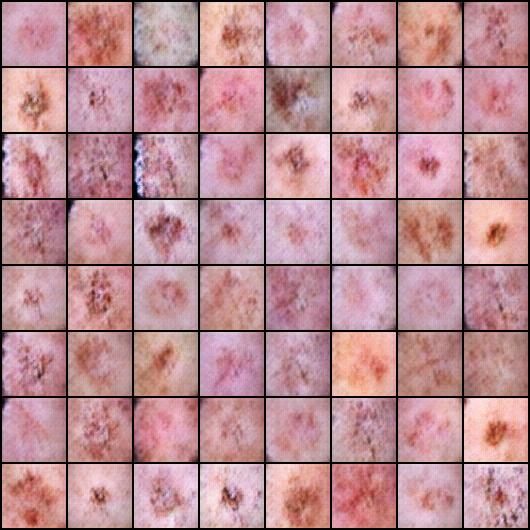

In [149]:
Image('./generated/generated-images-0500.jpg')

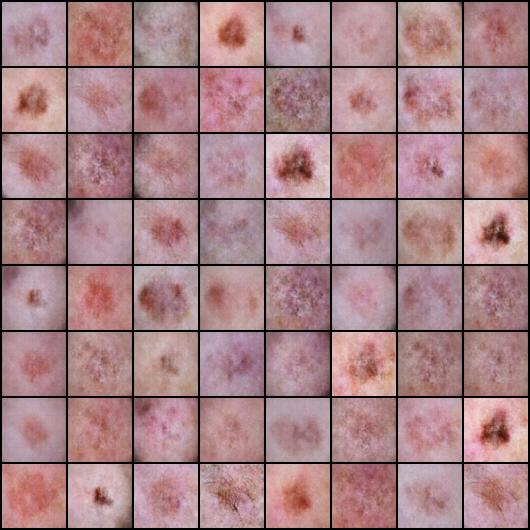

In [150]:
Image('./generated/generated-images-2000.jpg')

In [111]:
!cp Actinic_keratoses_Training.mp4 /workspace
#!ls

In [107]:
import cv2
import os

vid_fname = 'Actinic_keratoses_Training.mp4'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()
print(files)

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

['generated/generated-images-0001.png', 'generated/generated-images-0002.png', 'generated/generated-images-0003.png', 'generated/generated-images-0004.png', 'generated/generated-images-0005.png', 'generated/generated-images-0006.png', 'generated/generated-images-0007.png', 'generated/generated-images-0008.png', 'generated/generated-images-0009.png', 'generated/generated-images-0010.png', 'generated/generated-images-0011.png', 'generated/generated-images-0012.png', 'generated/generated-images-0013.png', 'generated/generated-images-0014.png', 'generated/generated-images-0015.png', 'generated/generated-images-0016.png', 'generated/generated-images-0017.png', 'generated/generated-images-0018.png', 'generated/generated-images-0019.png', 'generated/generated-images-0020.png', 'generated/generated-images-0021.png', 'generated/generated-images-0022.png', 'generated/generated-images-0023.png', 'generated/generated-images-0024.png', 'generated/generated-images-0025.png', 'generated/generated-ima